# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

# Importamos los datos

In [4]:
path = '../../../Base de datos/Trayectorias 200 eval'

## Datos de entrenamiento

### Datos

In [5]:
varftrain = np.load(path + '/varftrain.npy')
varftrain = np.transpose(varftrain, (0,3,1,2))

In [6]:
np.shape(varftrain)

(7000, 200, 10, 2)

### Coeficientes

In [7]:
coefvarftrain = np.load(path + '/coefvarftrain.npy')

In [8]:
np.shape(coefvarftrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
varftest = np.load(path + '/varftest.npy')
varftest = np.transpose(varftest, (0,3,1,2))

In [10]:
np.shape(varftest)

(2000, 200, 10, 2)

### Coeficientes

In [11]:
coefvarftest = np.load(path + '/coefvarftest.npy')

In [12]:
np.shape(coefvarftest)

(2000, 7)

## Datos de validación

### Datos

In [13]:
varfval = np.load(path + '/varfval.npy')
varfval = np.transpose(varfval, (0,3,1,2))

In [14]:
np.shape(varfval)

(1000, 200, 10, 2)

### Coeficienes

In [15]:
coefvarfval = np.load(path + '/coefvarfval.npy')

In [16]:
np.shape(coefvarfval)

(1000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((varftrain, coefvarftrain))
test_dataset = tf.data.Dataset.from_tensor_slices((varftest, coefvarftest))
val_dataset = tf.data.Dataset.from_tensor_slices((varfval, coefvarfval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(200, 10, 2), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 100
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [20]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [21]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=100.0)

In [22]:
def total_mae_loss(y_true, y_pred):
    total_loss = 0
    num_parameters = 7
    for i in range(num_parameters):
        total_loss += tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])
    tf.print(y_true, summarize = -1)
    tf.print(y_pred, summarize = -1)
    return total_loss / num_parameters

In [23]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [24]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [26]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l1, l2

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

def objective(trial):
    model = Sequential()
    n_conv_layers = trial.suggest_int("n_conv_layers", 1, 5)
    
    input_shape = (200, 10, 2)  # Tus dimensiones de entrada
    current_shape = (50,10,2)
    
    for i in range(n_conv_layers):
        num_filters = trial.suggest_int(f"num_filters_{i+1}", 8, 50)
        filter_size1 = trial.suggest_int(f"filter_size1_{i+1}", 2, 5)
        filter_size2 = trial.suggest_int(f"filter_size2_{i+1}", 2, 5)
        activation = trial.suggest_categorical(f"activation_{i+1}", ['relu', 'tanh', 'sigmoid'])
        kernel_initializer = trial.suggest_categorical(f"kernel_initializer_{i+1}", ['HeNormal', 'glorot_uniform', 'random_normal'])
        kernel_regularizer = trial.suggest_categorical(f"kernel_regularizer_{i+1}", ['l1', 'l2'])
        
        regularizer = None
        if kernel_regularizer == 'l1':
            regularizer = l1(0.001)
        elif kernel_regularizer == 'l2':
            regularizer = l2(0.001)
            
            
        if (current_shape[0] - filter_size1 + 1 > 0) and (current_shape[1] - filter_size2 + 1 > 0):
            if i == 0:
                model.add(Conv2D(num_filters, (filter_size1, filter_size2), activation=activation, input_shape=input_shape, kernel_initializer=kernel_initializer, kernel_regularizer=regularizer))
            else:
                model.add(Conv2D(num_filters, (filter_size1, filter_size2), activation=activation, kernel_initializer=kernel_initializer, kernel_regularizer=regularizer))
            
            current_shape = (current_shape[0] - filter_size1 + 1, current_shape[1] - filter_size2 + 1, num_filters)
            
        # Decide si agregar una capa de MaxPooling después de esta capa convolucional
        add_maxpooling = trial.suggest_categorical(f"add_maxpooling_after_conv_{i+1}", [True, False])
        if add_maxpooling:
            if current_shape[0] >= 2 and current_shape[1] >= 2:  # Asegurarse de que ambas dimensiones son suficientes para MaxPooling
                model.add(MaxPooling2D(pool_size=(2, 2)))
                current_shape = (current_shape[0] // 2, current_shape[1] // 2, current_shape[2])
        
    model.add(GlobalAveragePooling2D())
    n_dense_layers = trial.suggest_int("n_dense_layers", 1, 5)
    
    for i in range(n_dense_layers):
        num_units = trial.suggest_int(f"num_units_{i+1}", 16, 128)
        activation = trial.suggest_categorical(f"dense_activation_{i+1}", ['relu', 'tanh', 'sigmoid'])
        kernel_initializer = trial.suggest_categorical(f"dense_kernel_initializer_{i+1}", ['HeNormal', 'glorot_uniform', 'random_normal'])
        kernel_regularizer = trial.suggest_categorical(f"dense_kernel_regularizer_{i+1}", ['l1', 'l2'])

        regularizer = None
        if kernel_regularizer == 'l1':
            regularizer = l1(0.001)
        elif kernel_regularizer == 'l2':
            regularizer = l2(0.001)

        model.add(Dense(num_units, activation=activation, kernel_initializer=kernel_initializer, kernel_regularizer=regularizer))
    
        # Decide si agregar una capa de BatchNormalization después de esta capa densa
        add_batchnorm = trial.suggest_categorical(f"add_batchnorm_after_dense_{i+1}", [True, False])
        if add_batchnorm:
            model.add(BatchNormalization())    
        # Decide si agregar una capa de Dropout después de esta capa densa
        add_dropout = trial.suggest_categorical(f"add_dropout_after_dense_{i+1}", [True, False])
        if add_dropout:
            dropout_rate = trial.suggest_float(f"dropout_rate_after_dense_{i+1}", 0.1, 0.5)
            model.add(Dropout(dropout_rate))
            
    model.add(Dense(7, activation=custom_activation))
        
    optimizer = Adam(learning_rate=0.001, clipvalue=100.0)
        
    model.compile(optimizer=optimizer, loss= 'mean_squared_error', metrics=metrics)
    
    history = model.fit(
        train_dataset, 
        validation_data=val_dataset, 
        epochs=50,  
        callbacks=[reduce_lr, early_stop]
    )
    
    val_mean_metric = history.history['val_mean_metric'][-1]
    
    return val_mean_metric

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print(f'Número de trials finalizados: {len(study.trials)}')
print(f'Mejor trial:')
trial = study.best_trial

print(f'  Valor: {trial.value}')
print('  Parámetros: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2023-10-05 08:48:05,055] A new study created in memory with name: no-name-38431170-e3ef-45f5-8217-2115bcfe8daf


Epoch 1/50
70/70 [==============================] - 2s 14ms/step - loss: 8.0323 - a_1: 2.7042 - a_2: 2.6886 - b_1: 2.3636 - b_2: 2.7355 - d_1: 1.6904 - d_2: 1.7581 - n: 1.5844 - mean_metric: 0.5088 - val_loss: 6.7937 - val_a_1: 2.5630 - val_a_2: 2.6290 - val_b_1: 1.8653 - val_b_2: 2.8267 - val_d_1: 1.2849 - val_d_2: 1.3754 - val_n: 1.4784 - val_mean_metric: 0.4569 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 12ms/step - loss: 6.6880 - a_1: 2.6216 - a_2: 2.6541 - b_1: 1.7152 - b_2: 2.7273 - d_1: 1.3328 - d_2: 1.3643 - n: 1.4820 - mean_metric: 0.4554 - val_loss: 6.4881 - val_a_1: 2.5278 - val_a_2: 2.5919 - val_b_1: 1.6188 - val_b_2: 2.8287 - val_d_1: 1.3877 - val_d_2: 1.3106 - val_n: 1.4496 - val_mean_metric: 0.4469 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 12ms/step - loss: 6.4507 - a_1: 2.6013 - a_2: 2.6261 - b_1: 1.6006 - b_2: 2.7218 - d_1: 1.2955 - d_2: 1.3209 - n: 1.4623 - mean_metric: 0.4467 - val_loss: 6.3243 - val_a_1: 2.5216 - val

Epoch 23/50
70/70 [==============================] - 1s 11ms/step - loss: 5.9928 - a_1: 2.5726 - a_2: 2.6018 - b_1: 1.5134 - b_2: 2.7116 - d_1: 1.2142 - d_2: 1.2353 - n: 1.4452 - mean_metric: 0.4355 - val_loss: 5.9859 - val_a_1: 2.5093 - val_a_2: 2.5597 - val_b_1: 1.5104 - val_b_2: 2.8303 - val_d_1: 1.1731 - val_d_2: 1.2292 - val_n: 1.4503 - val_mean_metric: 0.4321 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 11ms/step - loss: 5.9966 - a_1: 2.5765 - a_2: 2.5980 - b_1: 1.5218 - b_2: 2.7116 - d_1: 1.2161 - d_2: 1.2383 - n: 1.4485 - mean_metric: 0.4362 - val_loss: 5.9572 - val_a_1: 2.5161 - val_a_2: 2.5585 - val_b_1: 1.5243 - val_b_2: 2.8291 - val_d_1: 1.1796 - val_d_2: 1.2575 - val_n: 1.4461 - val_mean_metric: 0.4337 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 11ms/step - loss: 5.9797 - a_1: 2.5712 - a_2: 2.6002 - b_1: 1.5145 - b_2: 2.7134 - d_1: 1.2355 - d_2: 1.2312 - n: 1.4481 - mean_metric: 0.4363 - val_loss: 5.9517 - val_a_1: 2.5084 - 

[I 2023-10-05 08:48:46,593] Trial 0 finished with value: 0.39998680353164673 and parameters: {'n_conv_layers': 4, 'num_filters_1': 25, 'filter_size1_1': 3, 'filter_size2_1': 5, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 20, 'filter_size1_2': 4, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 23, 'filter_size1_3': 3, 'filter_size2_3': 4, 'activation_3': 'relu', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 8, 'filter_size1_4': 5, 'filter_size2_4': 4, 'activation_4': 'relu', 'kernel_initializer_4': 'HeNormal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 2, 'num_units_1': 99, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'gl

Epoch 1/50
70/70 [==============================] - 2s 16ms/step - loss: 9.0162 - a_1: 2.7900 - a_2: 2.7982 - b_1: 2.0060 - b_2: 2.8855 - d_1: 1.6197 - d_2: 1.7510 - n: 2.2845 - mean_metric: 0.5288 - val_loss: 9.8335 - val_a_1: 2.6310 - val_a_2: 2.6625 - val_b_1: 2.6737 - val_b_2: 2.8637 - val_d_1: 2.7871 - val_d_2: 2.7413 - val_n: 1.5263 - val_mean_metric: 0.5828 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 13ms/step - loss: 7.7301 - a_1: 2.7131 - a_2: 2.7288 - b_1: 1.7199 - b_2: 2.7963 - d_1: 1.4900 - d_2: 1.5101 - n: 1.7787 - mean_metric: 0.4828 - val_loss: 9.7239 - val_a_1: 2.6303 - val_a_2: 2.6664 - val_b_1: 2.6909 - val_b_2: 2.8389 - val_d_1: 2.7722 - val_d_2: 2.7527 - val_n: 1.4834 - val_mean_metric: 0.5811 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 13ms/step - loss: 7.4236 - a_1: 2.6781 - a_2: 2.6992 - b_1: 1.6532 - b_2: 2.7919 - d_1: 1.4810 - d_2: 1.4507 - n: 1.6766 - mean_metric: 0.4730 - val_loss: 9.7205 - val_a_1: 2.6296 - val

Epoch 23/50
70/70 [==============================] - 1s 13ms/step - loss: 6.1932 - a_1: 2.5776 - a_2: 2.5873 - b_1: 1.3551 - b_2: 2.7104 - d_1: 1.2514 - d_2: 1.2777 - n: 1.4794 - mean_metric: 0.4338 - val_loss: 5.9919 - val_a_1: 2.4926 - val_a_2: 2.5876 - val_b_1: 1.1936 - val_b_2: 2.8234 - val_d_1: 1.1986 - val_d_2: 1.2206 - val_n: 1.4601 - val_mean_metric: 0.4228 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 13ms/step - loss: 6.1574 - a_1: 2.5746 - a_2: 2.5796 - b_1: 1.3456 - b_2: 2.7098 - d_1: 1.2343 - d_2: 1.2709 - n: 1.4843 - mean_metric: 0.4324 - val_loss: 6.0911 - val_a_1: 2.5450 - val_a_2: 2.6238 - val_b_1: 1.2103 - val_b_2: 2.8246 - val_d_1: 1.1340 - val_d_2: 1.2399 - val_n: 1.4633 - val_mean_metric: 0.4249 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 13ms/step - loss: 6.1451 - a_1: 2.5799 - a_2: 2.5882 - b_1: 1.3391 - b_2: 2.7113 - d_1: 1.2475 - d_2: 1.2625 - n: 1.4838 - mean_metric: 0.4329 - val_loss: 6.8303 - val_a_1: 2.5747 - 

[I 2023-10-05 08:49:32,892] Trial 1 finished with value: 0.47934985160827637 and parameters: {'n_conv_layers': 4, 'num_filters_1': 10, 'filter_size1_1': 3, 'filter_size2_1': 2, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 49, 'filter_size1_2': 2, 'filter_size2_2': 5, 'activation_2': 'tanh', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 13, 'filter_size1_3': 4, 'filter_size2_3': 2, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 23, 'filter_size1_4': 3, 'filter_size2_4': 5, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'HeNormal', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': False, 'n_dense_layers': 4, 'num_units_1': 102, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'HeNo

Epoch 1/50
70/70 [==============================] - 2s 16ms/step - loss: 9.0347 - a_1: 2.7412 - a_2: 2.6828 - b_1: 2.4716 - b_2: 2.7481 - d_1: 1.8080 - d_2: 1.8391 - n: 1.4861 - mean_metric: 0.5171 - val_loss: 9.9044 - val_a_1: 2.5802 - val_a_2: 2.6628 - val_b_1: 2.9701 - val_b_2: 2.8341 - val_d_1: 2.0501 - val_d_2: 2.0076 - val_n: 1.4984 - val_mean_metric: 0.5410 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 14ms/step - loss: 7.5154 - a_1: 2.6678 - a_2: 2.6664 - b_1: 1.6753 - b_2: 2.7255 - d_1: 1.2977 - d_2: 1.3031 - n: 1.4654 - mean_metric: 0.4522 - val_loss: 8.4914 - val_a_1: 2.5660 - val_a_2: 2.6062 - val_b_1: 1.9400 - val_b_2: 2.8424 - val_d_1: 1.9366 - val_d_2: 1.9403 - val_n: 1.4835 - val_mean_metric: 0.4990 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 14ms/step - loss: 7.0763 - a_1: 2.6375 - a_2: 2.6441 - b_1: 1.3794 - b_2: 2.7208 - d_1: 1.2073 - d_2: 1.1787 - n: 1.4631 - mean_metric: 0.4335 - val_loss: 8.0602 - val_a_1: 2.5529 - val

Epoch 23/50
70/70 [==============================] - 1s 14ms/step - loss: 5.8144 - a_1: 2.4375 - a_2: 2.5145 - b_1: 1.2010 - b_2: 2.7202 - d_1: 1.0110 - d_2: 0.9979 - n: 1.4367 - mean_metric: 0.4036 - val_loss: 5.8254 - val_a_1: 2.4067 - val_a_2: 2.4604 - val_b_1: 1.1845 - val_b_2: 2.8503 - val_d_1: 1.0355 - val_d_2: 0.9785 - val_n: 1.4586 - val_mean_metric: 0.4032 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 14ms/step - loss: 5.7987 - a_1: 2.4260 - a_2: 2.5110 - b_1: 1.2030 - b_2: 2.7201 - d_1: 1.0047 - d_2: 0.9885 - n: 1.4365 - mean_metric: 0.4027 - val_loss: 5.7615 - val_a_1: 2.3991 - val_a_2: 2.4455 - val_b_1: 1.1179 - val_b_2: 2.8480 - val_d_1: 1.0048 - val_d_2: 1.0080 - val_n: 1.4587 - val_mean_metric: 0.4002 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 14ms/step - loss: 5.7613 - a_1: 2.4188 - a_2: 2.5022 - b_1: 1.1994 - b_2: 2.7178 - d_1: 1.0030 - d_2: 0.9765 - n: 1.4356 - mean_metric: 0.4014 - val_loss: 5.7410 - val_a_1: 2.4018 - 

[I 2023-10-05 08:50:22,340] Trial 2 finished with value: 0.3832120895385742 and parameters: {'n_conv_layers': 1, 'num_filters_1': 48, 'filter_size1_1': 4, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'n_dense_layers': 5, 'num_units_1': 60, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 59, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2': 'l2', 'add_batchnorm_after_dense_2': False, 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2683131749642187, 'num_units_3': 116, 'dense_activation_3': 'sigmoid', 'dense_kernel_initializer_3': 'glorot_uniform', 'dense_kernel_regularizer_3': 'l2', 'add_batchnorm_after_dense_3': False, 'add_dropout_after_dense_3': False, 'num_unit

Epoch 1/50
70/70 [==============================] - 3s 25ms/step - loss: 9.6849 - a_1: 2.8469 - a_2: 2.8238 - b_1: 2.8180 - b_2: 2.8057 - d_1: 1.9804 - d_2: 2.3190 - n: 2.2586 - mean_metric: 0.5851 - val_loss: 9.9703 - val_a_1: 2.8306 - val_a_2: 2.6623 - val_b_1: 2.9148 - val_b_2: 2.8344 - val_d_1: 2.8182 - val_d_2: 2.7374 - val_n: 1.5134 - val_mean_metric: 0.5967 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 2s 22ms/step - loss: 7.8995 - a_1: 2.7485 - a_2: 2.7632 - b_1: 2.5507 - b_2: 2.7416 - d_1: 1.6204 - d_2: 1.7528 - n: 1.6757 - mean_metric: 0.5195 - val_loss: 8.9673 - val_a_1: 2.7331 - val_a_2: 2.6494 - val_b_1: 2.8545 - val_b_2: 2.8276 - val_d_1: 2.4934 - val_d_2: 2.3422 - val_n: 1.5145 - val_mean_metric: 0.5675 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 2s 22ms/step - loss: 7.3637 - a_1: 2.7174 - a_2: 2.7036 - b_1: 2.3948 - b_2: 2.7510 - d_1: 1.5265 - d_2: 1.6049 - n: 1.5372 - mean_metric: 0.4993 - val_loss: 8.1660 - val_a_1: 2.6809 - val

Epoch 23/50
70/70 [==============================] - 2s 22ms/step - loss: 6.1854 - a_1: 2.6159 - a_2: 2.6273 - b_1: 1.7020 - b_2: 2.7199 - d_1: 1.2841 - d_2: 1.3040 - n: 1.4498 - mean_metric: 0.4491 - val_loss: 6.1557 - val_a_1: 2.5354 - val_a_2: 2.5997 - val_b_1: 1.6572 - val_b_2: 2.8341 - val_d_1: 1.2360 - val_d_2: 1.2754 - val_n: 1.4480 - val_mean_metric: 0.4426 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 2s 22ms/step - loss: 6.1678 - a_1: 2.6063 - a_2: 2.6318 - b_1: 1.7054 - b_2: 2.7163 - d_1: 1.2714 - d_2: 1.3041 - n: 1.4423 - mean_metric: 0.4482 - val_loss: 6.1487 - val_a_1: 2.5294 - val_a_2: 2.5939 - val_b_1: 1.6464 - val_b_2: 2.8321 - val_d_1: 1.2576 - val_d_2: 1.3257 - val_n: 1.4557 - val_mean_metric: 0.4444 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 2s 22ms/step - loss: 6.1815 - a_1: 2.6146 - a_2: 2.6229 - b_1: 1.7146 - b_2: 2.7169 - d_1: 1.2776 - d_2: 1.3108 - n: 1.4466 - mean_metric: 0.4491 - val_loss: 6.1411 - val_a_1: 2.5311 - 

[I 2023-10-05 08:51:40,944] Trial 3 finished with value: 0.42062681913375854 and parameters: {'n_conv_layers': 1, 'num_filters_1': 43, 'filter_size1_1': 2, 'filter_size2_1': 2, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': False, 'n_dense_layers': 5, 'num_units_1': 71, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': False, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.3769218289017424, 'num_units_2': 42, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_batchnorm_after_dense_2': True, 'add_dropout_after_dense_2': False, 'num_units_3': 121, 'dense_activation_3': 'sigmoid', 'dense_kernel_initializer_3': 'glorot_uniform', 'dense_kernel_regularizer_3': 'l2', 'add_batchnorm_after_dense_3': True, 'add_dropout_after_dense_3'

Epoch 1/50
70/70 [==============================] - 2s 13ms/step - loss: 9.2001 - a_1: 2.8397 - a_2: 2.8147 - b_1: 2.7878 - b_2: 2.8767 - d_1: 2.1652 - d_2: 2.1549 - n: 1.6554 - mean_metric: 0.5667 - val_loss: 8.4010 - val_a_1: 2.5927 - val_a_2: 2.6553 - val_b_1: 2.5972 - val_b_2: 2.8408 - val_d_1: 2.2994 - val_d_2: 2.1969 - val_n: 1.5021 - val_mean_metric: 0.5436 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 11ms/step - loss: 7.1772 - a_1: 2.7335 - a_2: 2.6978 - b_1: 2.1307 - b_2: 2.7930 - d_1: 1.5365 - d_2: 1.5473 - n: 1.5328 - mean_metric: 0.4906 - val_loss: 6.8287 - val_a_1: 2.5685 - val_a_2: 2.6040 - val_b_1: 2.2510 - val_b_2: 2.8259 - val_d_1: 1.5412 - val_d_2: 1.5501 - val_n: 1.4888 - val_mean_metric: 0.4832 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 11ms/step - loss: 6.6509 - a_1: 2.6834 - a_2: 2.6981 - b_1: 1.7985 - b_2: 2.7669 - d_1: 1.4482 - d_2: 1.4541 - n: 1.5188 - mean_metric: 0.4708 - val_loss: 5.9598 - val_a_1: 2.5502 - val

Epoch 23/50
70/70 [==============================] - 1s 10ms/step - loss: 5.7837 - a_1: 2.6021 - a_2: 2.5876 - b_1: 1.3841 - b_2: 2.7189 - d_1: 1.2420 - d_2: 1.1701 - n: 1.4642 - mean_metric: 0.4315 - val_loss: 5.4219 - val_a_1: 2.5240 - val_a_2: 2.5375 - val_b_1: 1.2214 - val_b_2: 2.8229 - val_d_1: 0.9686 - val_d_2: 0.9486 - val_n: 1.4595 - val_mean_metric: 0.4068 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 10ms/step - loss: 5.7799 - a_1: 2.6102 - a_2: 2.5999 - b_1: 1.3979 - b_2: 2.7163 - d_1: 1.2021 - d_2: 1.1545 - n: 1.4627 - mean_metric: 0.4307 - val_loss: 5.3642 - val_a_1: 2.5197 - val_a_2: 2.5295 - val_b_1: 1.1885 - val_b_2: 2.8224 - val_d_1: 0.9814 - val_d_2: 0.9089 - val_n: 1.4550 - val_mean_metric: 0.4042 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 11ms/step - loss: 5.7727 - a_1: 2.6080 - a_2: 2.5976 - b_1: 1.3997 - b_2: 2.7171 - d_1: 1.2158 - d_2: 1.1455 - n: 1.4571 - mean_metric: 0.4306 - val_loss: 5.4136 - val_a_1: 2.5208 - 

[I 2023-10-05 08:52:19,260] Trial 4 finished with value: 0.3952885568141937 and parameters: {'n_conv_layers': 1, 'num_filters_1': 11, 'filter_size1_1': 4, 'filter_size2_1': 2, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'n_dense_layers': 5, 'num_units_1': 17, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 37, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_batchnorm_after_dense_2': False, 'add_dropout_after_dense_2': False, 'num_units_3': 27, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'random_normal', 'dense_kernel_regularizer_3': 'l2', 'add_batchnorm_after_dense_3': False, 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.45534535032450363, 'num_units_4'

Epoch 1/50
70/70 [==============================] - 2s 16ms/step - loss: 8.5749 - a_1: 2.7420 - a_2: 2.7666 - b_1: 1.9822 - b_2: 2.8240 - d_1: 1.4411 - d_2: 1.4719 - n: 2.0531 - mean_metric: 0.5008 - val_loss: 9.3653 - val_a_1: 2.6185 - val_a_2: 2.6673 - val_b_1: 2.5336 - val_b_2: 2.8230 - val_d_1: 2.5554 - val_d_2: 2.5118 - val_n: 1.5575 - val_mean_metric: 0.5626 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 13ms/step - loss: 6.7879 - a_1: 2.6468 - a_2: 2.6306 - b_1: 1.4117 - b_2: 2.7506 - d_1: 1.1814 - d_2: 1.1798 - n: 1.5192 - mean_metric: 0.4365 - val_loss: 8.8590 - val_a_1: 2.6113 - val_a_2: 2.6472 - val_b_1: 2.3870 - val_b_2: 2.8199 - val_d_1: 2.3824 - val_d_2: 2.3851 - val_n: 1.4785 - val_mean_metric: 0.5445 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 12ms/step - loss: 6.4994 - a_1: 2.5975 - a_2: 2.5994 - b_1: 1.2832 - b_2: 2.7477 - d_1: 1.1270 - d_2: 1.1276 - n: 1.4812 - mean_metric: 0.4248 - val_loss: 8.2083 - val_a_1: 2.5943 - val

Epoch 23/50
70/70 [==============================] - 1s 12ms/step - loss: 4.9822 - a_1: 2.2772 - a_2: 2.2586 - b_1: 1.0069 - b_2: 2.7275 - d_1: 0.8050 - d_2: 0.7986 - n: 1.3940 - mean_metric: 0.3691 - val_loss: 5.7581 - val_a_1: 2.4187 - val_a_2: 2.3778 - val_b_1: 1.2879 - val_b_2: 2.8274 - val_d_1: 1.3103 - val_d_2: 1.1310 - val_n: 1.4529 - val_mean_metric: 0.4172 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 13ms/step - loss: 4.9877 - a_1: 2.2674 - a_2: 2.2808 - b_1: 0.9994 - b_2: 2.7260 - d_1: 0.8139 - d_2: 0.8188 - n: 1.3915 - mean_metric: 0.3701 - val_loss: 5.5414 - val_a_1: 2.2527 - val_a_2: 2.2565 - val_b_1: 1.4903 - val_b_2: 2.8256 - val_d_1: 0.9513 - val_d_2: 1.3387 - val_n: 1.4075 - val_mean_metric: 0.4080 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 13ms/step - loss: 4.9345 - a_1: 2.2881 - a_2: 2.2593 - b_1: 0.9830 - b_2: 2.7264 - d_1: 0.7825 - d_2: 0.8006 - n: 1.3865 - mean_metric: 0.3678 - val_loss: 5.2424 - val_a_1: 2.3599 - 

[I 2023-10-05 08:53:03,857] Trial 5 finished with value: 0.35009440779685974 and parameters: {'n_conv_layers': 4, 'num_filters_1': 26, 'filter_size1_1': 2, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 24, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 28, 'filter_size1_3': 5, 'filter_size2_3': 5, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 12, 'filter_size1_4': 5, 'filter_size2_4': 5, 'activation_4': 'tanh', 'kernel_initializer_4': 'random_normal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'n_dense_layers': 5, 'num_units_1': 39, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1'

Epoch 1/50
70/70 [==============================] - 2s 19ms/step - loss: 11.1137 - a_1: 2.7767 - a_2: 2.7620 - b_1: 2.7767 - b_2: 2.7521 - d_1: 2.5290 - d_2: 2.5760 - n: 1.7287 - mean_metric: 0.5866 - val_loss: 10.3526 - val_a_1: 2.6204 - val_a_2: 2.6622 - val_b_1: 2.6855 - val_b_2: 2.8258 - val_d_1: 2.4908 - val_d_2: 2.5502 - val_n: 1.5082 - val_mean_metric: 0.5651 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 17ms/step - loss: 9.9013 - a_1: 2.7244 - a_2: 2.7201 - b_1: 2.7194 - b_2: 2.7330 - d_1: 2.0530 - d_2: 2.1480 - n: 1.4913 - mean_metric: 0.5436 - val_loss: 9.9573 - val_a_1: 2.6190 - val_a_2: 2.6593 - val_b_1: 2.6704 - val_b_2: 2.8361 - val_d_1: 2.3291 - val_d_2: 2.4227 - val_n: 1.5010 - val_mean_metric: 0.5551 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 16ms/step - loss: 9.2111 - a_1: 2.7095 - a_2: 2.6902 - b_1: 2.5196 - b_2: 2.7260 - d_1: 1.8323 - d_2: 1.8631 - n: 1.4900 - mean_metric: 0.5187 - val_loss: 9.1728 - val_a_1: 2.6056 - v

Epoch 23/50
70/70 [==============================] - 1s 16ms/step - loss: 6.7998 - a_1: 2.6152 - a_2: 2.6334 - b_1: 1.6919 - b_2: 2.7217 - d_1: 1.3810 - d_2: 1.4122 - n: 1.4555 - mean_metric: 0.4558 - val_loss: 6.5915 - val_a_1: 2.5208 - val_a_2: 2.5801 - val_b_1: 1.5967 - val_b_2: 2.8360 - val_d_1: 1.2735 - val_d_2: 1.2922 - val_n: 1.4597 - val_mean_metric: 0.4418 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 16ms/step - loss: 6.7773 - a_1: 2.6130 - a_2: 2.6336 - b_1: 1.6908 - b_2: 2.7196 - d_1: 1.3798 - d_2: 1.4002 - n: 1.4570 - mean_metric: 0.4554 - val_loss: 6.6100 - val_a_1: 2.5208 - val_a_2: 2.5768 - val_b_1: 1.5911 - val_b_2: 2.8375 - val_d_1: 1.2588 - val_d_2: 1.3616 - val_n: 1.4588 - val_mean_metric: 0.4433 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 16ms/step - loss: 6.7536 - a_1: 2.6196 - a_2: 2.6319 - b_1: 1.6725 - b_2: 2.7222 - d_1: 1.3741 - d_2: 1.4177 - n: 1.4605 - mean_metric: 0.4554 - val_loss: 6.6078 - val_a_1: 2.5168 - 

[I 2023-10-05 08:54:02,562] Trial 6 finished with value: 0.44221821427345276 and parameters: {'n_conv_layers': 1, 'num_filters_1': 24, 'filter_size1_1': 4, 'filter_size2_1': 2, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'n_dense_layers': 3, 'num_units_1': 102, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_batchnorm_after_dense_1': False, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.2546969040926171, 'num_units_2': 102, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_batchnorm_after_dense_2': True, 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.3124626066643661, 'num_units_3': 123, 'dense_activation_3': 'sigmoid', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l1', 'add_batchnorm_after_dense

Epoch 1/50
70/70 [==============================] - 2s 15ms/step - loss: 8.7989 - a_1: 2.8785 - a_2: 2.8630 - b_1: 2.1280 - b_2: 2.9277 - d_1: 1.5373 - d_2: 1.5443 - n: 2.3174 - mean_metric: 0.5308 - val_loss: 9.7045 - val_a_1: 2.7948 - val_a_2: 2.6651 - val_b_1: 2.7913 - val_b_2: 2.8328 - val_d_1: 2.9331 - val_d_2: 2.7572 - val_n: 1.4785 - val_mean_metric: 0.5947 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 12ms/step - loss: 7.1689 - a_1: 2.7746 - a_2: 2.7794 - b_1: 1.7478 - b_2: 2.8517 - d_1: 1.3559 - d_2: 1.3316 - n: 1.7270 - mean_metric: 0.4773 - val_loss: 9.4083 - val_a_1: 2.7297 - val_a_2: 2.6600 - val_b_1: 2.7206 - val_b_2: 2.8296 - val_d_1: 2.8787 - val_d_2: 2.7610 - val_n: 1.5108 - val_mean_metric: 0.5895 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 12ms/step - loss: 6.5737 - a_1: 2.7076 - a_2: 2.7061 - b_1: 1.5287 - b_2: 2.8051 - d_1: 1.2761 - d_2: 1.3216 - n: 1.5918 - mean_metric: 0.4567 - val_loss: 9.2664 - val_a_1: 2.6811 - val

Epoch 23/50
70/70 [==============================] - 1s 12ms/step - loss: 5.2832 - a_1: 2.4358 - a_2: 2.5172 - b_1: 1.1430 - b_2: 2.7153 - d_1: 1.0510 - d_2: 1.0273 - n: 1.4647 - mean_metric: 0.4047 - val_loss: 10.3598 - val_a_1: 2.7096 - val_a_2: 2.5189 - val_b_1: 1.8865 - val_b_2: 2.8224 - val_d_1: 3.6767 - val_d_2: 3.2763 - val_n: 1.4541 - val_mean_metric: 0.5977 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 12ms/step - loss: 5.2518 - a_1: 2.4137 - a_2: 2.5061 - b_1: 1.1322 - b_2: 2.7142 - d_1: 1.0461 - d_2: 1.0360 - n: 1.4599 - mean_metric: 0.4033 - val_loss: 8.7534 - val_a_1: 2.6975 - val_a_2: 2.5032 - val_b_1: 1.6850 - val_b_2: 2.8195 - val_d_1: 2.6732 - val_d_2: 3.0176 - val_n: 1.4507 - val_mean_metric: 0.5489 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 12ms/step - loss: 5.2322 - a_1: 2.4011 - a_2: 2.5045 - b_1: 1.1362 - b_2: 2.7209 - d_1: 1.0281 - d_2: 1.0185 - n: 1.4561 - mean_metric: 0.4019 - val_loss: 9.3633 - val_a_1: 2.5529 -

[I 2023-10-05 08:54:46,624] Trial 7 finished with value: 0.48144739866256714 and parameters: {'n_conv_layers': 2, 'num_filters_1': 42, 'filter_size1_1': 4, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 13, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 2, 'num_units_1': 115, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 85, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_batchnorm_after_dense_2': True, 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.3327662773252368}. Bes

Epoch 1/50
70/70 [==============================] - 2s 14ms/step - loss: 8.3022 - a_1: 2.7140 - a_2: 2.7268 - b_1: 2.4344 - b_2: 2.7621 - d_1: 1.6486 - d_2: 1.7514 - n: 1.6864 - mean_metric: 0.5153 - val_loss: 9.6524 - val_a_1: 2.6249 - val_a_2: 2.6566 - val_b_1: 2.6716 - val_b_2: 2.8198 - val_d_1: 2.6493 - val_d_2: 2.6138 - val_n: 1.7409 - val_mean_metric: 0.5793 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 11ms/step - loss: 7.2362 - a_1: 2.6618 - a_2: 2.6786 - b_1: 1.9267 - b_2: 2.7409 - d_1: 1.4609 - d_2: 1.4644 - n: 1.5200 - mean_metric: 0.4735 - val_loss: 9.4239 - val_a_1: 2.6204 - val_a_2: 2.6467 - val_b_1: 2.7058 - val_b_2: 2.8249 - val_d_1: 2.6037 - val_d_2: 2.6166 - val_n: 1.5992 - val_mean_metric: 0.5741 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 11ms/step - loss: 6.9743 - a_1: 2.6481 - a_2: 2.6568 - b_1: 1.7976 - b_2: 2.7293 - d_1: 1.4206 - d_2: 1.4338 - n: 1.4949 - mean_metric: 0.4647 - val_loss: 9.1659 - val_a_1: 2.6128 - val

Epoch 23/50
70/70 [==============================] - 1s 11ms/step - loss: 5.6615 - a_1: 2.4996 - a_2: 2.5239 - b_1: 1.1772 - b_2: 2.7171 - d_1: 1.0918 - d_2: 1.1186 - n: 1.4525 - mean_metric: 0.4122 - val_loss: 5.8545 - val_a_1: 2.4312 - val_a_2: 2.5329 - val_b_1: 1.4794 - val_b_2: 2.8294 - val_d_1: 1.1242 - val_d_2: 1.0381 - val_n: 1.4602 - val_mean_metric: 0.4201 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 11ms/step - loss: 5.6670 - a_1: 2.5087 - a_2: 2.5111 - b_1: 1.1807 - b_2: 2.7203 - d_1: 1.1094 - d_2: 1.1259 - n: 1.4480 - mean_metric: 0.4130 - val_loss: 5.4431 - val_a_1: 2.4187 - val_a_2: 2.4899 - val_b_1: 1.1948 - val_b_2: 2.8259 - val_d_1: 0.8539 - val_d_2: 0.9518 - val_n: 1.4571 - val_mean_metric: 0.3972 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 11ms/step - loss: 5.6448 - a_1: 2.4990 - a_2: 2.5170 - b_1: 1.1827 - b_2: 2.7201 - d_1: 1.1086 - d_2: 1.1068 - n: 1.4521 - mean_metric: 0.4123 - val_loss: 5.8453 - val_a_1: 2.5089 - 

[I 2023-10-05 08:55:25,511] Trial 8 finished with value: 0.3924623727798462 and parameters: {'n_conv_layers': 3, 'num_filters_1': 11, 'filter_size1_1': 4, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 32, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 32, 'filter_size1_3': 5, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 5, 'num_units_1': 67, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_batchnorm_after_dense_1': False, 'add_dropout_after_dense_1': False, 'num_units_2': 117, 'dense_activation_2': 'tanh', 'dense_kernel_initializer

Epoch 1/50
70/70 [==============================] - 2s 19ms/step - loss: 13.8926 - a_1: 3.3049 - a_2: 3.2620 - b_1: 3.1306 - b_2: 3.3190 - d_1: 2.5983 - d_2: 2.3857 - n: 2.8437 - mean_metric: 0.6830 - val_loss: 9.4682 - val_a_1: 2.7082 - val_a_2: 2.6566 - val_b_1: 2.6666 - val_b_2: 2.8473 - val_d_1: 2.7183 - val_d_2: 2.7519 - val_n: 1.7084 - val_mean_metric: 0.5884 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 16ms/step - loss: 10.3729 - a_1: 3.0595 - a_2: 2.9904 - b_1: 2.6281 - b_2: 3.1113 - d_1: 1.9314 - d_2: 1.8542 - n: 2.3000 - mean_metric: 0.5858 - val_loss: 9.1406 - val_a_1: 2.6718 - val_a_2: 2.6669 - val_b_1: 2.6136 - val_b_2: 2.8693 - val_d_1: 2.6168 - val_d_2: 2.7612 - val_n: 1.5851 - val_mean_metric: 0.5795 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 16ms/step - loss: 8.6751 - a_1: 2.8573 - a_2: 2.8920 - b_1: 2.1350 - b_2: 2.9676 - d_1: 1.7664 - d_2: 1.6868 - n: 1.9837 - mean_metric: 0.5338 - val_loss: 9.0671 - val_a_1: 2.6187 - v

Epoch 23/50
70/70 [==============================] - 1s 16ms/step - loss: 6.3539 - a_1: 2.6236 - a_2: 2.6460 - b_1: 1.7212 - b_2: 2.7117 - d_1: 1.4580 - d_2: 1.4672 - n: 1.4863 - mean_metric: 0.4625 - val_loss: 6.0420 - val_a_1: 2.5312 - val_a_2: 2.5737 - val_b_1: 1.5883 - val_b_2: 2.8207 - val_d_1: 1.3243 - val_d_2: 1.3082 - val_n: 1.4556 - val_mean_metric: 0.4432 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 16ms/step - loss: 6.3635 - a_1: 2.6266 - a_2: 2.6446 - b_1: 1.7149 - b_2: 2.7108 - d_1: 1.4590 - d_2: 1.4751 - n: 1.4920 - mean_metric: 0.4628 - val_loss: 6.0502 - val_a_1: 2.5350 - val_a_2: 2.5736 - val_b_1: 1.6442 - val_b_2: 2.8189 - val_d_1: 1.2708 - val_d_2: 1.3050 - val_n: 1.4575 - val_mean_metric: 0.4433 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 16ms/step - loss: 6.3629 - a_1: 2.6278 - a_2: 2.6459 - b_1: 1.7169 - b_2: 2.7107 - d_1: 1.4556 - d_2: 1.4795 - n: 1.4842 - mean_metric: 0.4628 - val_loss: 6.1132 - val_a_1: 2.5239 - 

[I 2023-10-05 08:56:24,176] Trial 9 finished with value: 0.4106716513633728 and parameters: {'n_conv_layers': 3, 'num_filters_1': 26, 'filter_size1_1': 4, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 8, 'filter_size1_2': 4, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 18, 'filter_size1_3': 3, 'filter_size2_3': 5, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 107, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': False, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4511243007645239, 'num_units_2': 54, '

Epoch 1/50
70/70 [==============================] - 1s 13ms/step - loss: 7.3882 - a_1: 2.6987 - a_2: 2.7152 - b_1: 2.4932 - b_2: 2.7224 - d_1: 1.7046 - d_2: 1.9318 - n: 1.5207 - mean_metric: 0.5174 - val_loss: 6.3224 - val_a_1: 2.5730 - val_a_2: 2.6369 - val_b_1: 2.0402 - val_b_2: 2.8412 - val_d_1: 1.2606 - val_d_2: 1.4097 - val_n: 1.4799 - val_mean_metric: 0.4640 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 10ms/step - loss: 5.9716 - a_1: 2.6493 - a_2: 2.6334 - b_1: 1.7006 - b_2: 2.7175 - d_1: 1.2474 - d_2: 1.2737 - n: 1.4674 - mean_metric: 0.4486 - val_loss: 5.8025 - val_a_1: 2.5368 - val_a_2: 2.5933 - val_b_1: 1.5682 - val_b_2: 2.8333 - val_d_1: 1.1411 - val_d_2: 1.2183 - val_n: 1.4679 - val_mean_metric: 0.4352 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 10ms/step - loss: 5.6334 - a_1: 2.6114 - a_2: 2.6096 - b_1: 1.3872 - b_2: 2.7144 - d_1: 1.1367 - d_2: 1.1789 - n: 1.4626 - mean_metric: 0.4293 - val_loss: 5.6651 - val_a_1: 2.5171 - val

Epoch 23/50
70/70 [==============================] - 1s 10ms/step - loss: 4.9613 - a_1: 2.3970 - a_2: 2.4677 - b_1: 1.0289 - b_2: 2.7126 - d_1: 0.8983 - d_2: 0.9269 - n: 1.4219 - mean_metric: 0.3883 - val_loss: 4.9993 - val_a_1: 2.3842 - val_a_2: 2.4572 - val_b_1: 0.9803 - val_b_2: 2.8397 - val_d_1: 0.8719 - val_d_2: 0.9567 - val_n: 1.4356 - val_mean_metric: 0.3885 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 10ms/step - loss: 4.9459 - a_1: 2.3931 - a_2: 2.4628 - b_1: 1.0199 - b_2: 2.7121 - d_1: 0.8977 - d_2: 0.9198 - n: 1.4205 - mean_metric: 0.3875 - val_loss: 4.9821 - val_a_1: 2.3787 - val_a_2: 2.4519 - val_b_1: 0.9705 - val_b_2: 2.8396 - val_d_1: 0.8712 - val_d_2: 0.9519 - val_n: 1.4363 - val_mean_metric: 0.3877 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 10ms/step - loss: 4.9309 - a_1: 2.3859 - a_2: 2.4574 - b_1: 1.0232 - b_2: 2.7122 - d_1: 0.8946 - d_2: 0.9092 - n: 1.4208 - mean_metric: 0.3868 - val_loss: 4.9900 - val_a_1: 2.3754 - 

[I 2023-10-05 08:57:00,986] Trial 10 finished with value: 0.37806105613708496 and parameters: {'n_conv_layers': 5, 'num_filters_1': 33, 'filter_size1_1': 2, 'filter_size2_1': 4, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 33, 'filter_size1_2': 5, 'filter_size2_2': 2, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 48, 'filter_size1_3': 5, 'filter_size2_3': 5, 'activation_3': 'tanh', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 49, 'filter_size1_4': 5, 'filter_size2_4': 2, 'activation_4': 'tanh', 'kernel_initializer_4': 'random_normal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'num_filters_5': 16, 'filter_size1_5': 3, 'filter_size2_5': 5, 'activation_5': 'relu', 'kernel_initializer

Epoch 1/50
70/70 [==============================] - 1s 13ms/step - loss: 7.2210 - a_1: 2.7028 - a_2: 2.6919 - b_1: 2.5894 - b_2: 2.7286 - d_1: 1.5257 - d_2: 1.6952 - n: 1.5335 - mean_metric: 0.5068 - val_loss: 6.3923 - val_a_1: 2.5726 - val_a_2: 2.6372 - val_b_1: 2.2352 - val_b_2: 2.8320 - val_d_1: 1.1864 - val_d_2: 1.2945 - val_n: 1.4764 - val_mean_metric: 0.4638 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 10ms/step - loss: 6.1704 - a_1: 2.6614 - a_2: 2.6499 - b_1: 1.9753 - b_2: 2.7229 - d_1: 1.2031 - d_2: 1.2447 - n: 1.4593 - mean_metric: 0.4560 - val_loss: 5.9793 - val_a_1: 2.5609 - val_a_2: 2.6092 - val_b_1: 1.7256 - val_b_2: 2.8495 - val_d_1: 1.1382 - val_d_2: 1.2624 - val_n: 1.4611 - val_mean_metric: 0.4433 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 10ms/step - loss: 5.7867 - a_1: 2.6296 - a_2: 2.6249 - b_1: 1.5546 - b_2: 2.7183 - d_1: 1.1384 - d_2: 1.2032 - n: 1.4584 - mean_metric: 0.4368 - val_loss: 5.6959 - val_a_1: 2.5379 - val

Epoch 23/50
70/70 [==============================] - 1s 10ms/step - loss: 5.0267 - a_1: 2.4324 - a_2: 2.4857 - b_1: 1.0448 - b_2: 2.7148 - d_1: 0.9240 - d_2: 0.9463 - n: 1.4258 - mean_metric: 0.3923 - val_loss: 5.0811 - val_a_1: 2.3991 - val_a_2: 2.4845 - val_b_1: 1.0348 - val_b_2: 2.8328 - val_d_1: 0.8916 - val_d_2: 1.0015 - val_n: 1.4313 - val_mean_metric: 0.3934 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 10ms/step - loss: 5.0422 - a_1: 2.4283 - a_2: 2.4814 - b_1: 1.0610 - b_2: 2.7140 - d_1: 0.9467 - d_2: 0.9641 - n: 1.4235 - mean_metric: 0.3938 - val_loss: 5.0022 - val_a_1: 2.3847 - val_a_2: 2.4675 - val_b_1: 0.9935 - val_b_2: 2.8327 - val_d_1: 0.8806 - val_d_2: 0.9619 - val_n: 1.4296 - val_mean_metric: 0.3894 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 10ms/step - loss: 4.9842 - a_1: 2.4184 - a_2: 2.4746 - b_1: 1.0262 - b_2: 2.7134 - d_1: 0.9035 - d_2: 0.9424 - n: 1.4233 - mean_metric: 0.3899 - val_loss: 5.0023 - val_a_1: 2.3852 - 

[I 2023-10-05 08:57:38,493] Trial 11 finished with value: 0.3811333477497101 and parameters: {'n_conv_layers': 5, 'num_filters_1': 36, 'filter_size1_1': 2, 'filter_size2_1': 4, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 32, 'filter_size1_2': 5, 'filter_size2_2': 2, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 49, 'filter_size1_3': 5, 'filter_size2_3': 5, 'activation_3': 'tanh', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 50, 'filter_size1_4': 5, 'filter_size2_4': 2, 'activation_4': 'tanh', 'kernel_initializer_4': 'random_normal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'num_filters_5': 14, 'filter_size1_5': 3, 'filter_size2_5': 5, 'activation_5': 'relu', 'kernel_initializer_

Epoch 1/50
70/70 [==============================] - 1s 13ms/step - loss: 7.2545 - a_1: 2.7052 - a_2: 2.6778 - b_1: 2.4390 - b_2: 2.7264 - d_1: 1.7056 - d_2: 1.7359 - n: 1.5289 - mean_metric: 0.5086 - val_loss: 6.3169 - val_a_1: 2.5652 - val_a_2: 2.6265 - val_b_1: 1.9612 - val_b_2: 2.8457 - val_d_1: 1.3038 - val_d_2: 1.3620 - val_n: 1.4817 - val_mean_metric: 0.4609 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 11ms/step - loss: 6.0552 - a_1: 2.6462 - a_2: 2.6428 - b_1: 1.7121 - b_2: 2.7235 - d_1: 1.2610 - d_2: 1.3018 - n: 1.4631 - mean_metric: 0.4506 - val_loss: 5.8760 - val_a_1: 2.5576 - val_a_2: 2.5936 - val_b_1: 1.5360 - val_b_2: 2.8424 - val_d_1: 1.2041 - val_d_2: 1.2948 - val_n: 1.4628 - val_mean_metric: 0.4395 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 11ms/step - loss: 5.6722 - a_1: 2.6009 - a_2: 2.6108 - b_1: 1.3970 - b_2: 2.7254 - d_1: 1.1538 - d_2: 1.1936 - n: 1.4612 - mean_metric: 0.4307 - val_loss: 5.6417 - val_a_1: 2.5202 - val

Epoch 23/50
70/70 [==============================] - 1s 10ms/step - loss: 4.9860 - a_1: 2.4017 - a_2: 2.4527 - b_1: 1.0531 - b_2: 2.7130 - d_1: 0.9259 - d_2: 0.9430 - n: 1.4190 - mean_metric: 0.3902 - val_loss: 5.0192 - val_a_1: 2.3868 - val_a_2: 2.4492 - val_b_1: 1.0013 - val_b_2: 2.8426 - val_d_1: 0.8766 - val_d_2: 0.9525 - val_n: 1.4227 - val_mean_metric: 0.3887 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 10ms/step - loss: 4.9267 - a_1: 2.3895 - a_2: 2.4461 - b_1: 1.0230 - b_2: 2.7123 - d_1: 0.8949 - d_2: 0.9146 - n: 1.4198 - mean_metric: 0.3867 - val_loss: 5.0124 - val_a_1: 2.3880 - val_a_2: 2.4579 - val_b_1: 0.9773 - val_b_2: 2.8416 - val_d_1: 0.8815 - val_d_2: 0.9471 - val_n: 1.4232 - val_mean_metric: 0.3883 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 10ms/step - loss: 4.9286 - a_1: 2.3814 - a_2: 2.4444 - b_1: 1.0189 - b_2: 2.7130 - d_1: 0.9029 - d_2: 0.9361 - n: 1.4168 - mean_metric: 0.3870 - val_loss: 5.0241 - val_a_1: 2.3877 - 

[I 2023-10-05 08:58:16,537] Trial 12 finished with value: 0.37603268027305603 and parameters: {'n_conv_layers': 5, 'num_filters_1': 33, 'filter_size1_1': 2, 'filter_size2_1': 4, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 39, 'filter_size1_2': 5, 'filter_size2_2': 2, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 37, 'filter_size1_3': 5, 'filter_size2_3': 5, 'activation_3': 'tanh', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 50, 'filter_size1_4': 5, 'filter_size2_4': 2, 'activation_4': 'tanh', 'kernel_initializer_4': 'random_normal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'num_filters_5': 31, 'filter_size1_5': 3, 'filter_size2_5': 4, 'activation_5': 'tanh', 'kernel_initializer

Epoch 1/50
70/70 [==============================] - 1s 13ms/step - loss: 8.7937 - a_1: 2.6978 - a_2: 2.7258 - b_1: 2.3424 - b_2: 2.7451 - d_1: 1.7350 - d_2: 1.8399 - n: 1.5454 - mean_metric: 0.5123 - val_loss: 7.3577 - val_a_1: 2.5665 - val_a_2: 2.6364 - val_b_1: 1.6992 - val_b_2: 2.8589 - val_d_1: 1.2596 - val_d_2: 1.2800 - val_n: 1.4676 - val_mean_metric: 0.4486 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 10ms/step - loss: 7.1587 - a_1: 2.5920 - a_2: 2.6547 - b_1: 1.5055 - b_2: 2.7488 - d_1: 1.2374 - d_2: 1.2631 - n: 1.4799 - mean_metric: 0.4418 - val_loss: 6.8240 - val_a_1: 2.5022 - val_a_2: 2.5732 - val_b_1: 1.3542 - val_b_2: 2.8607 - val_d_1: 1.1086 - val_d_2: 1.2583 - val_n: 1.4572 - val_mean_metric: 0.4273 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 10ms/step - loss: 6.7988 - a_1: 2.5459 - a_2: 2.6071 - b_1: 1.3495 - b_2: 2.7353 - d_1: 1.1473 - d_2: 1.1965 - n: 1.4781 - mean_metric: 0.4279 - val_loss: 6.5391 - val_a_1: 2.4657 - val

Epoch 23/50
70/70 [==============================] - 1s 10ms/step - loss: 5.5460 - a_1: 2.4158 - a_2: 2.4801 - b_1: 1.0556 - b_2: 2.7127 - d_1: 0.9672 - d_2: 0.9842 - n: 1.4256 - mean_metric: 0.3946 - val_loss: 5.5160 - val_a_1: 2.3987 - val_a_2: 2.4823 - val_b_1: 1.0389 - val_b_2: 2.8260 - val_d_1: 0.8930 - val_d_2: 0.9780 - val_n: 1.4378 - val_mean_metric: 0.3928 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 10ms/step - loss: 5.5121 - a_1: 2.4123 - a_2: 2.4792 - b_1: 1.0561 - b_2: 2.7054 - d_1: 0.9452 - d_2: 0.9757 - n: 1.4245 - mean_metric: 0.3932 - val_loss: 5.4481 - val_a_1: 2.3897 - val_a_2: 2.4902 - val_b_1: 0.9578 - val_b_2: 2.8265 - val_d_1: 0.8352 - val_d_2: 0.9087 - val_n: 1.4377 - val_mean_metric: 0.3860 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 10ms/step - loss: 5.4656 - a_1: 2.4021 - a_2: 2.4683 - b_1: 1.0330 - b_2: 2.7119 - d_1: 0.9277 - d_2: 0.9594 - n: 1.4211 - mean_metric: 0.3907 - val_loss: 5.5515 - val_a_1: 2.3863 - 

[I 2023-10-05 08:58:51,973] Trial 13 finished with value: 0.38594284653663635 and parameters: {'n_conv_layers': 4, 'num_filters_1': 18, 'filter_size1_1': 3, 'filter_size2_1': 4, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 45, 'filter_size1_2': 5, 'filter_size2_2': 2, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 34, 'filter_size1_3': 4, 'filter_size2_3': 4, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 28, 'filter_size1_4': 4, 'filter_size2_4': 5, 'activation_4': 'tanh', 'kernel_initializer_4': 'random_normal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'n_dense_layers': 3, 'num_units_1': 49, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 

Epoch 1/50
70/70 [==============================] - 1s 14ms/step - loss: 7.9237 - a_1: 2.7027 - a_2: 2.7010 - b_1: 2.3520 - b_2: 2.7279 - d_1: 1.5525 - d_2: 1.5145 - n: 1.5166 - mean_metric: 0.4938 - val_loss: 7.0656 - val_a_1: 2.5684 - val_a_2: 2.6377 - val_b_1: 1.7823 - val_b_2: 2.8500 - val_d_1: 1.2513 - val_d_2: 1.2939 - val_n: 1.4829 - val_mean_metric: 0.4518 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 11ms/step - loss: 6.7270 - a_1: 2.6392 - a_2: 2.6450 - b_1: 1.4908 - b_2: 2.7324 - d_1: 1.1723 - d_2: 1.1826 - n: 1.4729 - mean_metric: 0.4370 - val_loss: 6.5939 - val_a_1: 2.5491 - val_a_2: 2.5997 - val_b_1: 1.3556 - val_b_2: 2.8538 - val_d_1: 1.1038 - val_d_2: 1.2012 - val_n: 1.4792 - val_mean_metric: 0.4282 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 11ms/step - loss: 6.4763 - a_1: 2.6042 - a_2: 2.6172 - b_1: 1.3095 - b_2: 2.7238 - d_1: 1.0990 - d_2: 1.1392 - n: 1.4698 - mean_metric: 0.4248 - val_loss: 6.3670 - val_a_1: 2.5329 - val

Epoch 23/50
70/70 [==============================] - 1s 11ms/step - loss: 5.3925 - a_1: 2.3949 - a_2: 2.4535 - b_1: 1.0275 - b_2: 2.7150 - d_1: 0.9281 - d_2: 0.9259 - n: 1.4242 - mean_metric: 0.3889 - val_loss: 5.6288 - val_a_1: 2.3852 - val_a_2: 2.4583 - val_b_1: 1.1630 - val_b_2: 2.8404 - val_d_1: 0.9718 - val_d_2: 1.0795 - val_n: 1.4347 - val_mean_metric: 0.4018 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 11ms/step - loss: 5.3866 - a_1: 2.3812 - a_2: 2.4438 - b_1: 1.0609 - b_2: 2.7132 - d_1: 0.9309 - d_2: 0.9487 - n: 1.4218 - mean_metric: 0.3899 - val_loss: 5.3510 - val_a_1: 2.3698 - val_a_2: 2.4282 - val_b_1: 0.9641 - val_b_2: 2.8423 - val_d_1: 0.8691 - val_d_2: 0.9182 - val_n: 1.4357 - val_mean_metric: 0.3853 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 11ms/step - loss: 5.3595 - a_1: 2.3791 - a_2: 2.4367 - b_1: 1.0631 - b_2: 2.7130 - d_1: 0.9285 - d_2: 0.9448 - n: 1.4200 - mean_metric: 0.3894 - val_loss: 5.4173 - val_a_1: 2.4138 - 

[I 2023-10-05 08:59:32,672] Trial 14 finished with value: 0.3697209358215332 and parameters: {'n_conv_layers': 5, 'num_filters_1': 33, 'filter_size1_1': 2, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 40, 'filter_size1_2': 4, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 40, 'filter_size1_3': 2, 'filter_size2_3': 5, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 11, 'filter_size1_4': 2, 'filter_size2_4': 3, 'activation_4': 'tanh', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'num_filters_5': 46, 'filter_size1_5': 5, 'filter_size2_5': 2, 'activation_5': 'tanh', 'kernel_initializ

Epoch 1/50
70/70 [==============================] - 1s 11ms/step - loss: 8.3129 - a_1: 2.7052 - a_2: 2.6985 - b_1: 2.4490 - b_2: 2.7274 - d_1: 1.6161 - d_2: 1.5651 - n: 1.5177 - mean_metric: 0.5007 - val_loss: 7.4235 - val_a_1: 2.5785 - val_a_2: 2.6306 - val_b_1: 1.8812 - val_b_2: 2.8568 - val_d_1: 1.2618 - val_d_2: 1.3370 - val_n: 1.4753 - val_mean_metric: 0.4568 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 9ms/step - loss: 7.1960 - a_1: 2.6547 - a_2: 2.6619 - b_1: 1.6905 - b_2: 2.7260 - d_1: 1.2546 - d_2: 1.2631 - n: 1.4698 - mean_metric: 0.4496 - val_loss: 7.0902 - val_a_1: 2.5535 - val_a_2: 2.6058 - val_b_1: 1.5722 - val_b_2: 2.8457 - val_d_1: 1.3047 - val_d_2: 1.2859 - val_n: 1.4656 - val_mean_metric: 0.4442 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 9ms/step - loss: 6.8391 - a_1: 2.6171 - a_2: 2.6372 - b_1: 1.4432 - b_2: 2.7212 - d_1: 1.1780 - d_2: 1.1869 - n: 1.4650 - mean_metric: 0.4341 - val_loss: 6.7290 - val_a_1: 2.5190 - val_a

Epoch 23/50
70/70 [==============================] - 1s 9ms/step - loss: 5.6158 - a_1: 2.4545 - a_2: 2.5105 - b_1: 1.0944 - b_2: 2.7129 - d_1: 0.9343 - d_2: 0.9449 - n: 1.4350 - mean_metric: 0.3960 - val_loss: 5.5615 - val_a_1: 2.4189 - val_a_2: 2.5078 - val_b_1: 0.9784 - val_b_2: 2.8319 - val_d_1: 0.8815 - val_d_2: 0.9407 - val_n: 1.4420 - val_mean_metric: 0.3910 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 9ms/step - loss: 5.5571 - a_1: 2.4611 - a_2: 2.5077 - b_1: 1.0233 - b_2: 2.7133 - d_1: 0.9304 - d_2: 0.9357 - n: 1.4343 - mean_metric: 0.3935 - val_loss: 5.5606 - val_a_1: 2.4177 - val_a_2: 2.4923 - val_b_1: 0.9833 - val_b_2: 2.8329 - val_d_1: 0.9071 - val_d_2: 0.9930 - val_n: 1.4438 - val_mean_metric: 0.3933 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 9ms/step - loss: 5.5234 - a_1: 2.4454 - a_2: 2.5024 - b_1: 1.0303 - b_2: 2.7128 - d_1: 0.9232 - d_2: 0.9276 - n: 1.4339 - mean_metric: 0.3924 - val_loss: 5.5954 - val_a_1: 2.4007 - val

Epoch 45/50
70/70 [==============================] - 1s 9ms/step - loss: 5.1190 - a_1: 2.3582 - a_2: 2.4085 - b_1: 0.9743 - b_2: 2.7119 - d_1: 0.8583 - d_2: 0.8335 - n: 1.4264 - mean_metric: 0.3791 - val_loss: 5.1017 - val_a_1: 2.3305 - val_a_2: 2.3904 - val_b_1: 0.9402 - val_b_2: 2.8355 - val_d_1: 0.8016 - val_d_2: 0.8362 - val_n: 1.4350 - val_mean_metric: 0.3770 - lr: 0.0010
Epoch 46/50
70/70 [==============================] - 1s 9ms/step - loss: 5.0927 - a_1: 2.3468 - a_2: 2.4059 - b_1: 0.9783 - b_2: 2.7116 - d_1: 0.8396 - d_2: 0.8278 - n: 1.4259 - mean_metric: 0.3780 - val_loss: 5.0592 - val_a_1: 2.3172 - val_a_2: 2.3838 - val_b_1: 0.9297 - val_b_2: 2.8348 - val_d_1: 0.7922 - val_d_2: 0.8270 - val_n: 1.4309 - val_mean_metric: 0.3752 - lr: 0.0010
Epoch 47/50
70/70 [==============================] - 1s 9ms/step - loss: 5.0687 - a_1: 2.3397 - a_2: 2.3922 - b_1: 0.9732 - b_2: 2.7128 - d_1: 0.8389 - d_2: 0.8309 - n: 1.4256 - mean_metric: 0.3773 - val_loss: 5.2019 - val_a_1: 2.2828 - val

[I 2023-10-05 09:00:04,589] Trial 15 finished with value: 0.3768194019794464 and parameters: {'n_conv_layers': 4, 'num_filters_1': 17, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 23, 'filter_size1_2': 4, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 40, 'filter_size1_3': 2, 'filter_size2_3': 4, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 9, 'filter_size1_4': 2, 'filter_size2_4': 3, 'activation_4': 'tanh', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 2, 'num_units_1': 51, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'rand

Epoch 1/50
70/70 [==============================] - 2s 15ms/step - loss: 8.4688 - a_1: 2.6898 - a_2: 2.6957 - b_1: 1.9135 - b_2: 2.7836 - d_1: 1.4144 - d_2: 1.4763 - n: 2.0329 - mean_metric: 0.4918 - val_loss: 10.9537 - val_a_1: 2.7305 - val_a_2: 2.9330 - val_b_1: 2.6529 - val_b_2: 2.8654 - val_d_1: 2.8089 - val_d_2: 2.7682 - val_n: 1.5170 - val_mean_metric: 0.5955 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 13ms/step - loss: 7.1020 - a_1: 2.6314 - a_2: 2.6182 - b_1: 1.4446 - b_2: 2.7431 - d_1: 1.2241 - d_2: 1.2376 - n: 1.5156 - mean_metric: 0.4396 - val_loss: 10.1674 - val_a_1: 2.6914 - val_a_2: 2.7772 - val_b_1: 2.5994 - val_b_2: 2.8556 - val_d_1: 2.6505 - val_d_2: 2.6533 - val_n: 1.4878 - val_mean_metric: 0.5772 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 13ms/step - loss: 6.7578 - a_1: 2.5554 - a_2: 2.5812 - b_1: 1.3135 - b_2: 2.7406 - d_1: 1.1410 - d_2: 1.1807 - n: 1.4705 - mean_metric: 0.4254 - val_loss: 9.5890 - val_a_1: 2.6485 - v

Epoch 23/50
70/70 [==============================] - 1s 13ms/step - loss: 5.5351 - a_1: 2.3891 - a_2: 2.4054 - b_1: 1.0910 - b_2: 2.7171 - d_1: 0.9423 - d_2: 0.9333 - n: 1.4326 - mean_metric: 0.3903 - val_loss: 5.4913 - val_a_1: 2.3482 - val_a_2: 2.3613 - val_b_1: 0.9996 - val_b_2: 2.8325 - val_d_1: 0.9225 - val_d_2: 0.8813 - val_n: 1.4351 - val_mean_metric: 0.3838 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 15ms/step - loss: 5.5094 - a_1: 2.3869 - a_2: 2.4139 - b_1: 1.0805 - b_2: 2.7190 - d_1: 0.9254 - d_2: 0.9119 - n: 1.4326 - mean_metric: 0.3890 - val_loss: 5.5413 - val_a_1: 2.3442 - val_a_2: 2.4181 - val_b_1: 1.0482 - val_b_2: 2.8308 - val_d_1: 0.7873 - val_d_2: 0.9636 - val_n: 1.4410 - val_mean_metric: 0.3856 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 13ms/step - loss: 5.4920 - a_1: 2.3759 - a_2: 2.4114 - b_1: 1.0864 - b_2: 2.7164 - d_1: 0.9459 - d_2: 0.9150 - n: 1.4304 - mean_metric: 0.3893 - val_loss: 5.4618 - val_a_1: 2.4245 - 

[I 2023-10-05 09:00:50,612] Trial 16 finished with value: 0.3677895665168762 and parameters: {'n_conv_layers': 5, 'num_filters_1': 38, 'filter_size1_1': 2, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 24, 'filter_size1_2': 3, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 27, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 18, 'filter_size1_4': 2, 'filter_size2_4': 4, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'num_filters_5': 47, 'filter_size1_5': 5, 'filter_size2_5': 2, 'activation_5': 'tanh', 'kernel_i

Epoch 1/50
70/70 [==============================] - 2s 16ms/step - loss: 9.0543 - a_1: 2.6941 - a_2: 2.7144 - b_1: 1.9855 - b_2: 2.7856 - d_1: 1.4572 - d_2: 1.4738 - n: 2.0482 - mean_metric: 0.4969 - val_loss: 12.4109 - val_a_1: 2.8998 - val_a_2: 3.1073 - val_b_1: 2.5731 - val_b_2: 2.9870 - val_d_1: 2.6544 - val_d_2: 2.6312 - val_n: 2.4889 - val_mean_metric: 0.6302 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 13ms/step - loss: 7.5147 - a_1: 2.6022 - a_2: 2.6085 - b_1: 1.4539 - b_2: 2.7432 - d_1: 1.2098 - d_2: 1.2394 - n: 1.5176 - mean_metric: 0.4383 - val_loss: 10.7869 - val_a_1: 2.7639 - val_a_2: 2.8895 - val_b_1: 2.5027 - val_b_2: 2.8877 - val_d_1: 2.5733 - val_d_2: 2.5586 - val_n: 1.6745 - val_mean_metric: 0.5816 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 13ms/step - loss: 7.1549 - a_1: 2.5433 - a_2: 2.5678 - b_1: 1.3101 - b_2: 2.7395 - d_1: 1.1625 - d_2: 1.1604 - n: 1.4711 - mean_metric: 0.4245 - val_loss: 10.0136 - val_a_1: 2.7022 - 

Epoch 23/50
70/70 [==============================] - 1s 13ms/step - loss: 5.8231 - a_1: 2.3746 - a_2: 2.4251 - b_1: 1.1403 - b_2: 2.7212 - d_1: 0.9704 - d_2: 0.9773 - n: 1.4352 - mean_metric: 0.3946 - val_loss: 5.6413 - val_a_1: 2.3364 - val_a_2: 2.4032 - val_b_1: 0.9915 - val_b_2: 2.8274 - val_d_1: 0.9186 - val_d_2: 0.8671 - val_n: 1.4336 - val_mean_metric: 0.3837 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 13ms/step - loss: 5.7190 - a_1: 2.3360 - a_2: 2.4134 - b_1: 1.1266 - b_2: 2.7171 - d_1: 0.9469 - d_2: 0.9491 - n: 1.4272 - mean_metric: 0.3904 - val_loss: 5.8904 - val_a_1: 2.4312 - val_a_2: 2.3479 - val_b_1: 1.2472 - val_b_2: 2.8256 - val_d_1: 1.1862 - val_d_2: 0.8383 - val_n: 1.4476 - val_mean_metric: 0.4015 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 13ms/step - loss: 5.6816 - a_1: 2.3742 - a_2: 2.4026 - b_1: 1.0877 - b_2: 2.7176 - d_1: 0.9330 - d_2: 0.9197 - n: 1.4276 - mean_metric: 0.3887 - val_loss: 5.7861 - val_a_1: 2.3441 - 

[I 2023-10-05 09:01:36,271] Trial 17 finished with value: 0.3568156659603119 and parameters: {'n_conv_layers': 4, 'num_filters_1': 40, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 21, 'filter_size1_2': 3, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 25, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 20, 'filter_size1_4': 3, 'filter_size2_4': 4, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'n_dense_layers': 4, 'num_units_1': 87, 'dense_activation_1': 'relu', 'dense_kernel_initializer

Epoch 1/50
70/70 [==============================] - 2s 16ms/step - loss: 10.1027 - a_1: 2.7748 - a_2: 2.8156 - b_1: 2.0462 - b_2: 2.8714 - d_1: 1.6099 - d_2: 1.5268 - n: 2.1560 - mean_metric: 0.5179 - val_loss: 12.0200 - val_a_1: 2.6302 - val_a_2: 3.3698 - val_b_1: 2.6610 - val_b_2: 2.8847 - val_d_1: 2.7993 - val_d_2: 2.6791 - val_n: 1.5598 - val_mean_metric: 0.6055 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 13ms/step - loss: 8.2503 - a_1: 2.6725 - a_2: 2.6875 - b_1: 1.6275 - b_2: 2.7656 - d_1: 1.3679 - d_2: 1.3003 - n: 1.5842 - mean_metric: 0.4590 - val_loss: 11.3588 - val_a_1: 2.6280 - val_a_2: 3.0079 - val_b_1: 2.6673 - val_b_2: 2.8609 - val_d_1: 2.7951 - val_d_2: 2.6621 - val_n: 1.6550 - val_mean_metric: 0.5955 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 13ms/step - loss: 7.7613 - a_1: 2.6475 - a_2: 2.6627 - b_1: 1.4694 - b_2: 2.7558 - d_1: 1.2614 - d_2: 1.2562 - n: 1.5174 - mean_metric: 0.4446 - val_loss: 10.8222 - val_a_1: 2.6231 -

Epoch 23/50
70/70 [==============================] - 1s 13ms/step - loss: 5.7905 - a_1: 2.4043 - a_2: 2.4150 - b_1: 1.0755 - b_2: 2.7145 - d_1: 0.9547 - d_2: 0.9101 - n: 1.4261 - mean_metric: 0.3899 - val_loss: 5.8643 - val_a_1: 2.3563 - val_a_2: 2.3814 - val_b_1: 1.0288 - val_b_2: 2.8289 - val_d_1: 0.9028 - val_d_2: 1.0701 - val_n: 1.4480 - val_mean_metric: 0.3915 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 14ms/step - loss: 5.7646 - a_1: 2.3793 - a_2: 2.4154 - b_1: 1.1075 - b_2: 2.7151 - d_1: 0.9482 - d_2: 0.9310 - n: 1.4289 - mean_metric: 0.3907 - val_loss: 7.3816 - val_a_1: 2.4173 - val_a_2: 2.8240 - val_b_1: 2.0487 - val_b_2: 2.8247 - val_d_1: 0.8655 - val_d_2: 1.5895 - val_n: 1.4601 - val_mean_metric: 0.4571 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 13ms/step - loss: 5.7045 - a_1: 2.3860 - a_2: 2.4073 - b_1: 1.0722 - b_2: 2.7162 - d_1: 0.9349 - d_2: 0.9042 - n: 1.4287 - mean_metric: 0.3883 - val_loss: 5.5246 - val_a_1: 2.3197 - 

[I 2023-10-05 09:02:23,643] Trial 18 finished with value: 0.35211798548698425 and parameters: {'n_conv_layers': 3, 'num_filters_1': 50, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 17, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 23, 'filter_size1_3': 3, 'filter_size2_3': 2, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 85, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.11093364861480298, 'num_units_2': 73, 'd

Epoch 1/50
70/70 [==============================] - 2s 15ms/step - loss: 8.7940 - a_1: 2.7322 - a_2: 2.7569 - b_1: 2.1250 - b_2: 2.8197 - d_1: 1.5289 - d_2: 1.6231 - n: 1.6191 - mean_metric: 0.4983 - val_loss: 9.9294 - val_a_1: 2.6651 - val_a_2: 2.6662 - val_b_1: 2.5511 - val_b_2: 2.8967 - val_d_1: 2.4095 - val_d_2: 2.5141 - val_n: 1.4872 - val_mean_metric: 0.5601 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 12ms/step - loss: 7.5807 - a_1: 2.6488 - a_2: 2.6733 - b_1: 1.5595 - b_2: 2.7752 - d_1: 1.3026 - d_2: 1.3164 - n: 1.5423 - mean_metric: 0.4528 - val_loss: 8.8679 - val_a_1: 2.6336 - val_a_2: 2.6379 - val_b_1: 2.3599 - val_b_2: 2.8712 - val_d_1: 2.1721 - val_d_2: 2.0031 - val_n: 1.5378 - val_mean_metric: 0.5284 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 12ms/step - loss: 7.2198 - a_1: 2.6414 - a_2: 2.6390 - b_1: 1.4129 - b_2: 2.7600 - d_1: 1.2103 - d_2: 1.2294 - n: 1.5169 - mean_metric: 0.4395 - val_loss: 8.1797 - val_a_1: 2.6163 - val

Epoch 23/50
70/70 [==============================] - 1s 12ms/step - loss: 5.6918 - a_1: 2.3875 - a_2: 2.4652 - b_1: 1.0952 - b_2: 2.7147 - d_1: 0.9794 - d_2: 0.9854 - n: 1.4402 - mean_metric: 0.3954 - val_loss: 5.5955 - val_a_1: 2.3606 - val_a_2: 2.4423 - val_b_1: 1.0346 - val_b_2: 2.8238 - val_d_1: 0.8168 - val_d_2: 0.9277 - val_n: 1.4426 - val_mean_metric: 0.3860 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 12ms/step - loss: 5.6632 - a_1: 2.3826 - a_2: 2.4629 - b_1: 1.1034 - b_2: 2.7130 - d_1: 0.9698 - d_2: 0.9732 - n: 1.4362 - mean_metric: 0.3945 - val_loss: 5.7587 - val_a_1: 2.5005 - val_a_2: 2.4221 - val_b_1: 1.0487 - val_b_2: 2.8236 - val_d_1: 0.9847 - val_d_2: 0.9085 - val_n: 1.4395 - val_mean_metric: 0.3951 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 12ms/step - loss: 5.6128 - a_1: 2.3729 - a_2: 2.4587 - b_1: 1.1100 - b_2: 2.7092 - d_1: 0.9536 - d_2: 0.9519 - n: 1.4341 - mean_metric: 0.3928 - val_loss: 5.9520 - val_a_1: 2.5705 - 

[I 2023-10-05 09:03:06,891] Trial 19 finished with value: 0.3628687858581543 and parameters: {'n_conv_layers': 2, 'num_filters_1': 50, 'filter_size1_1': 3, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 15, 'filter_size1_2': 2, 'filter_size2_2': 3, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 3, 'num_units_1': 85, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.10996191579308055, 'num_units_2': 81, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l1', 'add_batchnorm_after_dense_2': False, 'add_dropout_after_dense_2': False, 'num_units_3':

Epoch 1/50
70/70 [==============================] - 2s 15ms/step - loss: 11.8298 - a_1: 2.9239 - a_2: 2.9096 - b_1: 2.4375 - b_2: 2.9616 - d_1: 1.8062 - d_2: 1.8649 - n: 2.1864 - mean_metric: 0.5602 - val_loss: 11.8105 - val_a_1: 2.6307 - val_a_2: 2.8210 - val_b_1: 2.5988 - val_b_2: 3.0611 - val_d_1: 2.6298 - val_d_2: 2.4002 - val_n: 1.6196 - val_mean_metric: 0.5788 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 12ms/step - loss: 10.0155 - a_1: 2.8395 - a_2: 2.8098 - b_1: 2.0639 - b_2: 2.8570 - d_1: 1.5091 - d_2: 1.5747 - n: 1.6870 - mean_metric: 0.5027 - val_loss: 10.6468 - val_a_1: 2.6124 - val_a_2: 2.7226 - val_b_1: 2.4970 - val_b_2: 2.9458 - val_d_1: 2.3896 - val_d_2: 2.2150 - val_n: 1.4734 - val_mean_metric: 0.5492 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 12ms/step - loss: 9.4537 - a_1: 2.7710 - a_2: 2.7941 - b_1: 1.8385 - b_2: 2.8554 - d_1: 1.4329 - d_2: 1.5038 - n: 1.6209 - mean_metric: 0.4855 - val_loss: 9.9278 - val_a_1: 2.6149 -

Epoch 23/50
70/70 [==============================] - 1s 12ms/step - loss: 6.3340 - a_1: 2.4564 - a_2: 2.5360 - b_1: 1.2216 - b_2: 2.7188 - d_1: 1.0451 - d_2: 1.0801 - n: 1.4401 - mean_metric: 0.4095 - val_loss: 6.4731 - val_a_1: 2.4828 - val_a_2: 2.4891 - val_b_1: 1.4561 - val_b_2: 2.8226 - val_d_1: 1.1050 - val_d_2: 1.0340 - val_n: 1.4611 - val_mean_metric: 0.4187 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 12ms/step - loss: 6.2627 - a_1: 2.4389 - a_2: 2.5203 - b_1: 1.2207 - b_2: 2.7244 - d_1: 1.0259 - d_2: 1.0585 - n: 1.4485 - mean_metric: 0.4075 - val_loss: 6.5186 - val_a_1: 2.5661 - val_a_2: 2.4790 - val_b_1: 1.5321 - val_b_2: 2.8209 - val_d_1: 0.9870 - val_d_2: 0.9913 - val_n: 1.4743 - val_mean_metric: 0.4187 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 12ms/step - loss: 6.1925 - a_1: 2.4144 - a_2: 2.5220 - b_1: 1.2154 - b_2: 2.7226 - d_1: 1.0290 - d_2: 1.0451 - n: 1.4447 - mean_metric: 0.4062 - val_loss: 6.0094 - val_a_1: 2.3515 - 

[I 2023-10-05 09:03:49,312] Trial 20 finished with value: 0.4017367362976074 and parameters: {'n_conv_layers': 2, 'num_filters_1': 20, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 26, 'filter_size1_2': 2, 'filter_size2_2': 5, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 4, 'num_units_1': 79, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.10162432653888173, 'num_units_2': 45, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l1', 'add_batchnorm_after_dense_2': False, 'add_dropout_after_dense_2': False, 'num_units_3':

Epoch 1/50
70/70 [==============================] - 2s 16ms/step - loss: 10.1202 - a_1: 2.7771 - a_2: 2.8227 - b_1: 2.0586 - b_2: 2.8604 - d_1: 1.5023 - d_2: 1.5113 - n: 2.1561 - mean_metric: 0.5142 - val_loss: 12.0086 - val_a_1: 2.6494 - val_a_2: 2.7388 - val_b_1: 3.0365 - val_b_2: 2.8684 - val_d_1: 2.7143 - val_d_2: 2.7200 - val_n: 1.9264 - val_mean_metric: 0.6078 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 13ms/step - loss: 8.5212 - a_1: 2.6729 - a_2: 2.7020 - b_1: 1.6577 - b_2: 2.7891 - d_1: 1.3516 - d_2: 1.3326 - n: 1.6005 - mean_metric: 0.4623 - val_loss: 11.0360 - val_a_1: 2.6319 - val_a_2: 2.7018 - val_b_1: 2.8300 - val_b_2: 2.8554 - val_d_1: 2.6764 - val_d_2: 2.6832 - val_n: 1.5120 - val_mean_metric: 0.5830 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 13ms/step - loss: 7.9712 - a_1: 2.6225 - a_2: 2.6446 - b_1: 1.4834 - b_2: 2.7877 - d_1: 1.2484 - d_2: 1.2285 - n: 1.5204 - mean_metric: 0.4435 - val_loss: 10.6793 - val_a_1: 2.6257 -

Epoch 23/50
70/70 [==============================] - 1s 13ms/step - loss: 5.7481 - a_1: 2.3363 - a_2: 2.4339 - b_1: 1.0489 - b_2: 2.7171 - d_1: 0.9263 - d_2: 0.9082 - n: 1.4346 - mean_metric: 0.3868 - val_loss: 6.0282 - val_a_1: 2.5206 - val_a_2: 2.5225 - val_b_1: 1.0451 - val_b_2: 2.8264 - val_d_1: 0.8616 - val_d_2: 0.8622 - val_n: 1.4527 - val_mean_metric: 0.3940 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 13ms/step - loss: 5.7472 - a_1: 2.3392 - a_2: 2.4388 - b_1: 1.0734 - b_2: 2.7189 - d_1: 0.9332 - d_2: 0.9384 - n: 1.4270 - mean_metric: 0.3889 - val_loss: 6.4423 - val_a_1: 2.6153 - val_a_2: 2.4679 - val_b_1: 1.4340 - val_b_2: 2.8316 - val_d_1: 1.1448 - val_d_2: 0.9886 - val_n: 1.4602 - val_mean_metric: 0.4217 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 13ms/step - loss: 5.7053 - a_1: 2.3540 - a_2: 2.4323 - b_1: 1.0685 - b_2: 2.7170 - d_1: 0.9122 - d_2: 0.9302 - n: 1.4271 - mean_metric: 0.3880 - val_loss: 5.6407 - val_a_1: 2.3374 - 

[I 2023-10-05 09:04:35,017] Trial 21 finished with value: 0.39186739921569824 and parameters: {'n_conv_layers': 3, 'num_filters_1': 45, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 18, 'filter_size1_2': 3, 'filter_size2_2': 4, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 23, 'filter_size1_3': 3, 'filter_size2_3': 2, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 90, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.19378079018879463, 'num_units_2': 70, 'd

Epoch 1/50
70/70 [==============================] - 2s 17ms/step - loss: 11.1105 - a_1: 2.8510 - a_2: 2.8453 - b_1: 2.2371 - b_2: 2.9302 - d_1: 1.7096 - d_2: 1.7958 - n: 2.2681 - mean_metric: 0.5454 - val_loss: 11.0726 - val_a_1: 2.6248 - val_a_2: 2.6495 - val_b_1: 2.6753 - val_b_2: 2.8187 - val_d_1: 2.7012 - val_d_2: 2.6949 - val_n: 1.6200 - val_mean_metric: 0.5795 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 13ms/step - loss: 8.7607 - a_1: 2.6805 - a_2: 2.6992 - b_1: 1.7390 - b_2: 2.7649 - d_1: 1.4130 - d_2: 1.4806 - n: 1.6080 - mean_metric: 0.4714 - val_loss: 10.5755 - val_a_1: 2.6190 - val_a_2: 2.6654 - val_b_1: 2.6225 - val_b_2: 2.8294 - val_d_1: 2.6126 - val_d_2: 2.5672 - val_n: 1.4691 - val_mean_metric: 0.5665 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 13ms/step - loss: 8.2218 - a_1: 2.6507 - a_2: 2.6461 - b_1: 1.5870 - b_2: 2.7570 - d_1: 1.3052 - d_2: 1.3694 - n: 1.4934 - mean_metric: 0.4524 - val_loss: 9.6692 - val_a_1: 2.6067 - 

Epoch 23/50
70/70 [==============================] - 1s 14ms/step - loss: 5.8289 - a_1: 2.3840 - a_2: 2.4760 - b_1: 1.1401 - b_2: 2.7221 - d_1: 1.0051 - d_2: 0.8984 - n: 1.4312 - mean_metric: 0.3950 - val_loss: 5.7516 - val_a_1: 2.3479 - val_a_2: 2.4567 - val_b_1: 1.0315 - val_b_2: 2.8255 - val_d_1: 0.9482 - val_d_2: 0.8340 - val_n: 1.4536 - val_mean_metric: 0.3876 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 14ms/step - loss: 5.7778 - a_1: 2.3971 - a_2: 2.4451 - b_1: 1.1563 - b_2: 2.7239 - d_1: 1.0061 - d_2: 0.8940 - n: 1.4252 - mean_metric: 0.3948 - val_loss: 5.5405 - val_a_1: 2.3473 - val_a_2: 2.3840 - val_b_1: 1.0423 - val_b_2: 2.8199 - val_d_1: 0.8742 - val_d_2: 0.8096 - val_n: 1.4472 - val_mean_metric: 0.3820 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 14ms/step - loss: 5.7395 - a_1: 2.4057 - a_2: 2.4397 - b_1: 1.1483 - b_2: 2.7259 - d_1: 0.9968 - d_2: 0.9091 - n: 1.4256 - mean_metric: 0.3948 - val_loss: 5.7842 - val_a_1: 2.4420 - 

[I 2023-10-05 09:05:23,954] Trial 22 finished with value: 0.3569178283214569 and parameters: {'n_conv_layers': 4, 'num_filters_1': 39, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 12, 'filter_size1_2': 3, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 27, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 38, 'filter_size1_4': 3, 'filter_size2_4': 5, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 5, 'num_units_1': 127, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': '

Epoch 1/50
70/70 [==============================] - 2s 16ms/step - loss: 9.2512 - a_1: 2.6998 - a_2: 2.7078 - b_1: 2.0244 - b_2: 2.7684 - d_1: 1.4799 - d_2: 1.6150 - n: 1.9861 - mean_metric: 0.5008 - val_loss: 12.2018 - val_a_1: 2.6391 - val_a_2: 2.6575 - val_b_1: 3.2389 - val_b_2: 2.8230 - val_d_1: 2.8088 - val_d_2: 2.7806 - val_n: 1.9517 - val_mean_metric: 0.6158 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 13ms/step - loss: 7.8744 - a_1: 2.6246 - a_2: 2.6228 - b_1: 1.6360 - b_2: 2.7401 - d_1: 1.3089 - d_2: 1.3359 - n: 1.5083 - mean_metric: 0.4514 - val_loss: 11.5073 - val_a_1: 2.6345 - val_a_2: 2.6543 - val_b_1: 3.1163 - val_b_2: 2.8229 - val_d_1: 2.8113 - val_d_2: 2.7889 - val_n: 1.5564 - val_mean_metric: 0.5990 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 13ms/step - loss: 7.5308 - a_1: 2.5899 - a_2: 2.5960 - b_1: 1.5523 - b_2: 2.7383 - d_1: 1.2671 - d_2: 1.2986 - n: 1.4748 - mean_metric: 0.4428 - val_loss: 11.0952 - val_a_1: 2.6317 - 

70/70 [==============================] - 1s 13ms/step - loss: 5.6602 - a_1: 2.4885 - a_2: 2.5193 - b_1: 1.1503 - b_2: 2.7110 - d_1: 1.0770 - d_2: 1.0704 - n: 1.4469 - mean_metric: 0.4084 - val_loss: 9.9302 - val_a_1: 2.6458 - val_a_2: 2.9916 - val_b_1: 1.7644 - val_b_2: 2.8330 - val_d_1: 4.0887 - val_d_2: 1.0519 - val_n: 1.4930 - val_mean_metric: 0.5496 - lr: 0.0010
Epoch 44/50
70/70 [==============================] - 1s 13ms/step - loss: 5.6567 - a_1: 2.4838 - a_2: 2.5233 - b_1: 1.1326 - b_2: 2.7126 - d_1: 1.0780 - d_2: 1.0694 - n: 1.4476 - mean_metric: 0.4078 - val_loss: 10.8471 - val_a_1: 2.6033 - val_a_2: 3.0338 - val_b_1: 1.8433 - val_b_2: 2.8375 - val_d_1: 3.8297 - val_d_2: 2.5019 - val_n: 1.4903 - val_mean_metric: 0.5910 - lr: 0.0010
Epoch 45/50
70/70 [==============================] - 1s 13ms/step - loss: 5.6424 - a_1: 2.4866 - a_2: 2.5232 - b_1: 1.1383 - b_2: 2.7125 - d_1: 1.0559 - d_2: 1.0594 - n: 1.4420 - mean_metric: 0.4069 - val_loss: 8.8767 - val_a_1: 2.5487 - val_a_2: 2.

[I 2023-10-05 09:06:11,642] Trial 23 finished with value: 0.6377903819084167 and parameters: {'n_conv_layers': 3, 'num_filters_1': 30, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 19, 'filter_size1_2': 2, 'filter_size2_2': 3, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 20, 'filter_size1_3': 3, 'filter_size2_3': 2, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 88, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.16959326236895797, 'num_units_2': 70, 

Epoch 1/50
70/70 [==============================] - 2s 14ms/step - loss: 8.4885 - a_1: 2.6942 - a_2: 2.6981 - b_1: 2.2638 - b_2: 2.7829 - d_1: 1.5562 - d_2: 1.5047 - n: 2.0632 - mean_metric: 0.5101 - val_loss: 9.6447 - val_a_1: 2.6428 - val_a_2: 2.6486 - val_b_1: 2.6247 - val_b_2: 2.8221 - val_d_1: 2.6876 - val_d_2: 2.6499 - val_n: 1.5712 - val_mean_metric: 0.5750 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 12ms/step - loss: 6.9505 - a_1: 2.6048 - a_2: 2.6437 - b_1: 1.6770 - b_2: 2.7404 - d_1: 1.3230 - d_2: 1.3440 - n: 1.5310 - mean_metric: 0.4542 - val_loss: 9.2625 - val_a_1: 2.6201 - val_a_2: 2.6421 - val_b_1: 2.5799 - val_b_2: 2.8214 - val_d_1: 2.6113 - val_d_2: 2.5852 - val_n: 1.4839 - val_mean_metric: 0.5651 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 12ms/step - loss: 6.5589 - a_1: 2.5920 - a_2: 2.6103 - b_1: 1.4624 - b_2: 2.7346 - d_1: 1.2169 - d_2: 1.2801 - n: 1.4790 - mean_metric: 0.4383 - val_loss: 8.9867 - val_a_1: 2.6088 - val

Epoch 23/50
70/70 [==============================] - 1s 12ms/step - loss: 5.4769 - a_1: 2.4266 - a_2: 2.4680 - b_1: 1.0789 - b_2: 2.7170 - d_1: 0.9543 - d_2: 0.9556 - n: 1.4376 - mean_metric: 0.3944 - val_loss: 5.4647 - val_a_1: 2.3809 - val_a_2: 2.4433 - val_b_1: 1.1176 - val_b_2: 2.8360 - val_d_1: 0.9520 - val_d_2: 0.9520 - val_n: 1.4461 - val_mean_metric: 0.3952 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 12ms/step - loss: 5.4833 - a_1: 2.4194 - a_2: 2.4705 - b_1: 1.0967 - b_2: 2.7163 - d_1: 0.9520 - d_2: 0.9802 - n: 1.4394 - mean_metric: 0.3956 - val_loss: 5.3560 - val_a_1: 2.3599 - val_a_2: 2.4083 - val_b_1: 1.1714 - val_b_2: 2.8249 - val_d_1: 0.8182 - val_d_2: 0.8097 - val_n: 1.4568 - val_mean_metric: 0.3861 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 12ms/step - loss: 5.4089 - a_1: 2.3992 - a_2: 2.4466 - b_1: 1.0619 - b_2: 2.7173 - d_1: 0.9345 - d_2: 0.9423 - n: 1.4401 - mean_metric: 0.3913 - val_loss: 5.3067 - val_a_1: 2.3596 - 

[I 2023-10-05 09:06:53,777] Trial 24 finished with value: 0.3698867857456207 and parameters: {'n_conv_layers': 4, 'num_filters_1': 46, 'filter_size1_1': 3, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 28, 'filter_size1_2': 3, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 10, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 19, 'filter_size1_4': 4, 'filter_size2_4': 4, 'activation_4': 'relu', 'kernel_initializer_4': 'random_normal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'n_dense_layers': 4, 'num_units_1': 60, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1':

Epoch 1/50
70/70 [==============================] - 2s 17ms/step - loss: 9.7997 - a_1: 2.7427 - a_2: 2.7276 - b_1: 1.9392 - b_2: 2.8532 - d_1: 1.4674 - d_2: 1.5296 - n: 2.1444 - mean_metric: 0.5049 - val_loss: 11.2518 - val_a_1: 2.6061 - val_a_2: 2.6592 - val_b_1: 2.5847 - val_b_2: 2.8462 - val_d_1: 2.9122 - val_d_2: 2.6125 - val_n: 1.5797 - val_mean_metric: 0.5800 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 13ms/step - loss: 8.0150 - a_1: 2.5879 - a_2: 2.6174 - b_1: 1.4309 - b_2: 2.7776 - d_1: 1.2291 - d_2: 1.1982 - n: 1.5638 - mean_metric: 0.4393 - val_loss: 10.8018 - val_a_1: 2.6016 - val_a_2: 2.6769 - val_b_1: 2.4038 - val_b_2: 2.8389 - val_d_1: 2.7067 - val_d_2: 2.6064 - val_n: 1.4799 - val_mean_metric: 0.5642 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 13ms/step - loss: 7.6986 - a_1: 2.5509 - a_2: 2.5962 - b_1: 1.3385 - b_2: 2.7626 - d_1: 1.1432 - d_2: 1.1552 - n: 1.4913 - mean_metric: 0.4271 - val_loss: 10.9954 - val_a_1: 2.6107 - 

Epoch 44/50
70/70 [==============================] - 1s 13ms/step - loss: 5.2413 - a_1: 2.2358 - a_2: 2.2425 - b_1: 0.9453 - b_2: 2.7150 - d_1: 0.7394 - d_2: 0.7375 - n: 1.3978 - mean_metric: 0.3608 - val_loss: 6.9864 - val_a_1: 2.7437 - val_a_2: 2.3197 - val_b_1: 1.3658 - val_b_2: 2.8358 - val_d_1: 1.6251 - val_d_2: 1.5684 - val_n: 1.4690 - val_mean_metric: 0.4538 - lr: 0.0010
Epoch 45/50
70/70 [==============================] - 1s 13ms/step - loss: 5.2489 - a_1: 2.2288 - a_2: 2.2451 - b_1: 0.9547 - b_2: 2.7158 - d_1: 0.7468 - d_2: 0.7568 - n: 1.3994 - mean_metric: 0.3619 - val_loss: 5.9629 - val_a_1: 2.2991 - val_a_2: 2.2665 - val_b_1: 1.0508 - val_b_2: 2.8417 - val_d_1: 0.9090 - val_d_2: 1.7115 - val_n: 1.4165 - val_mean_metric: 0.4071 - lr: 0.0010
Epoch 46/50
70/70 [==============================] - 1s 13ms/step - loss: 5.2000 - a_1: 2.2303 - a_2: 2.2399 - b_1: 0.9329 - b_2: 2.7144 - d_1: 0.7307 - d_2: 0.7283 - n: 1.3946 - mean_metric: 0.3594 - val_loss: 5.5515 - val_a_1: 2.2893 - 

[I 2023-10-05 09:07:41,996] Trial 25 finished with value: 0.41489505767822266 and parameters: {'n_conv_layers': 3, 'num_filters_1': 41, 'filter_size1_1': 2, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 21, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 16, 'filter_size1_3': 4, 'filter_size2_3': 2, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 5, 'num_units_1': 74, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': False, 'add_dropout_after_dense_1': False, 'num_units_2': 32, 'dense_activation_2': 'tanh', 'dense_kernel_initializ

Epoch 1/50
70/70 [==============================] - 2s 19ms/step - loss: 8.5873 - a_1: 2.7325 - a_2: 2.7224 - b_1: 2.4321 - b_2: 2.7583 - d_1: 1.6686 - d_2: 1.9725 - n: 1.5954 - mean_metric: 0.5205 - val_loss: 9.5276 - val_a_1: 2.6111 - val_a_2: 2.6874 - val_b_1: 2.7034 - val_b_2: 2.8302 - val_d_1: 2.1683 - val_d_2: 2.6702 - val_n: 1.4992 - val_mean_metric: 0.5595 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 16ms/step - loss: 7.3946 - a_1: 2.6686 - a_2: 2.6724 - b_1: 1.9149 - b_2: 2.7572 - d_1: 1.4707 - d_2: 1.5055 - n: 1.5127 - mean_metric: 0.4752 - val_loss: 8.3903 - val_a_1: 2.6033 - val_a_2: 2.6592 - val_b_1: 2.4483 - val_b_2: 2.8435 - val_d_1: 1.8899 - val_d_2: 2.1704 - val_n: 1.4730 - val_mean_metric: 0.5242 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 16ms/step - loss: 6.9914 - a_1: 2.6392 - a_2: 2.6579 - b_1: 1.6798 - b_2: 2.7398 - d_1: 1.4066 - d_2: 1.4312 - n: 1.4957 - mean_metric: 0.4604 - val_loss: 7.6670 - val_a_1: 2.5742 - val

Epoch 23/50
70/70 [==============================] - 1s 16ms/step - loss: 5.7128 - a_1: 2.5154 - a_2: 2.5350 - b_1: 1.1665 - b_2: 2.7133 - d_1: 1.0866 - d_2: 1.1185 - n: 1.4421 - mean_metric: 0.4122 - val_loss: 5.9027 - val_a_1: 2.4479 - val_a_2: 2.5088 - val_b_1: 1.3351 - val_b_2: 2.8246 - val_d_1: 0.9637 - val_d_2: 1.3396 - val_n: 1.4797 - val_mean_metric: 0.4203 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 16ms/step - loss: 5.7203 - a_1: 2.5062 - a_2: 2.5456 - b_1: 1.1721 - b_2: 2.7108 - d_1: 1.0831 - d_2: 1.1048 - n: 1.4544 - mean_metric: 0.4121 - val_loss: 5.8935 - val_a_1: 2.4543 - val_a_2: 2.5032 - val_b_1: 1.5257 - val_b_2: 2.8228 - val_d_1: 1.0540 - val_d_2: 1.0890 - val_n: 1.4490 - val_mean_metric: 0.4202 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 16ms/step - loss: 5.7267 - a_1: 2.5127 - a_2: 2.5460 - b_1: 1.1671 - b_2: 2.7124 - d_1: 1.0963 - d_2: 1.1235 - n: 1.4521 - mean_metric: 0.4133 - val_loss: 5.7736 - val_a_1: 2.4439 - 

[I 2023-10-05 09:08:38,133] Trial 26 finished with value: 0.39605486392974854 and parameters: {'n_conv_layers': 4, 'num_filters_1': 50, 'filter_size1_1': 3, 'filter_size2_1': 2, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 16, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 29, 'filter_size1_3': 3, 'filter_size2_3': 4, 'activation_3': 'relu', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 15, 'filter_size1_4': 3, 'filter_size2_4': 5, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'n_dense_layers': 3, 'num_units_1': 94, 'dense_activation_1': 'relu', 'dense_kernel_initialize

Epoch 1/50
70/70 [==============================] - 2s 14ms/step - loss: 9.5650 - a_1: 2.8555 - a_2: 2.8464 - b_1: 2.2838 - b_2: 2.9032 - d_1: 1.5196 - d_2: 1.6060 - n: 2.1709 - mean_metric: 0.5305 - val_loss: 10.4911 - val_a_1: 2.6546 - val_a_2: 2.7601 - val_b_1: 3.0833 - val_b_2: 2.8294 - val_d_1: 2.6757 - val_d_2: 2.5300 - val_n: 1.4826 - val_mean_metric: 0.5870 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 12ms/step - loss: 7.6010 - a_1: 2.7358 - a_2: 2.7022 - b_1: 1.7375 - b_2: 2.8077 - d_1: 1.3081 - d_2: 1.3457 - n: 1.6200 - mean_metric: 0.4672 - val_loss: 9.6253 - val_a_1: 2.6354 - val_a_2: 2.6803 - val_b_1: 2.7937 - val_b_2: 2.8208 - val_d_1: 2.5446 - val_d_2: 2.3909 - val_n: 1.5184 - val_mean_metric: 0.5664 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 12ms/step - loss: 7.0532 - a_1: 2.6801 - a_2: 2.6815 - b_1: 1.5720 - b_2: 2.7699 - d_1: 1.2019 - d_2: 1.2534 - n: 1.5287 - mean_metric: 0.4486 - val_loss: 8.9686 - val_a_1: 2.6319 - va

Epoch 23/50
70/70 [==============================] - 1s 12ms/step - loss: 5.4208 - a_1: 2.3918 - a_2: 2.4042 - b_1: 1.0865 - b_2: 2.7123 - d_1: 0.9030 - d_2: 0.9264 - n: 1.4319 - mean_metric: 0.3885 - val_loss: 5.4767 - val_a_1: 2.3550 - val_a_2: 2.3461 - val_b_1: 1.2416 - val_b_2: 2.8243 - val_d_1: 0.8689 - val_d_2: 0.9757 - val_n: 1.4513 - val_mean_metric: 0.3930 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 12ms/step - loss: 5.4382 - a_1: 2.3912 - a_2: 2.4015 - b_1: 1.0964 - b_2: 2.7179 - d_1: 0.9312 - d_2: 0.9064 - n: 1.4357 - mean_metric: 0.3892 - val_loss: 5.3996 - val_a_1: 2.3924 - val_a_2: 2.3499 - val_b_1: 1.0498 - val_b_2: 2.8265 - val_d_1: 0.9917 - val_d_2: 0.8239 - val_n: 1.4546 - val_mean_metric: 0.3873 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 12ms/step - loss: 5.3807 - a_1: 2.3927 - a_2: 2.3879 - b_1: 1.0831 - b_2: 2.7144 - d_1: 0.9003 - d_2: 0.9088 - n: 1.4333 - mean_metric: 0.3873 - val_loss: 5.3485 - val_a_1: 2.3766 - 

[I 2023-10-05 09:09:20,798] Trial 27 finished with value: 0.38000449538230896 and parameters: {'n_conv_layers': 2, 'num_filters_1': 30, 'filter_size1_1': 2, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 10, 'filter_size1_2': 4, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 4, 'num_units_1': 80, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': False, 'add_dropout_after_dense_1': False, 'num_units_2': 76, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l1', 'add_batchnorm_after_dense_2': False, 'add_dropout_after_dense_2': False, 'num_units_3': 54, 'dense_activation_3': 'tanh', 'dense_kernel_initial

Epoch 1/50
70/70 [==============================] - 2s 18ms/step - loss: 11.1276 - a_1: 2.8381 - a_2: 2.7987 - b_1: 2.3889 - b_2: 2.8553 - d_1: 1.6132 - d_2: 1.6011 - n: 2.3089 - mean_metric: 0.5377 - val_loss: 11.7708 - val_a_1: 2.7413 - val_a_2: 2.6816 - val_b_1: 2.7072 - val_b_2: 2.8379 - val_d_1: 2.8111 - val_d_2: 2.7439 - val_n: 1.5632 - val_mean_metric: 0.5893 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 14ms/step - loss: 9.0377 - a_1: 2.6676 - a_2: 2.6681 - b_1: 1.8115 - b_2: 2.7715 - d_1: 1.3526 - d_2: 1.3895 - n: 1.6694 - mean_metric: 0.4696 - val_loss: 12.0640 - val_a_1: 2.8106 - val_a_2: 2.7178 - val_b_1: 2.7635 - val_b_2: 2.8310 - val_d_1: 2.9162 - val_d_2: 2.7193 - val_n: 1.5075 - val_mean_metric: 0.5952 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 14ms/step - loss: 8.4048 - a_1: 2.6215 - a_2: 2.6141 - b_1: 1.5562 - b_2: 2.7372 - d_1: 1.2724 - d_2: 1.2826 - n: 1.5171 - mean_metric: 0.4457 - val_loss: 12.4870 - val_a_1: 2.7756 -

Epoch 44/50
70/70 [==============================] - 1s 14ms/step - loss: 5.5172 - a_1: 2.4767 - a_2: 2.5206 - b_1: 1.1598 - b_2: 2.7108 - d_1: 1.0374 - d_2: 1.0662 - n: 1.4359 - mean_metric: 0.4066 - val_loss: 6.2563 - val_a_1: 2.5203 - val_a_2: 2.5348 - val_b_1: 1.7459 - val_b_2: 2.8305 - val_d_1: 1.4278 - val_d_2: 1.0523 - val_n: 1.4478 - val_mean_metric: 0.4417 - lr: 0.0010
Epoch 45/50
70/70 [==============================] - 1s 14ms/step - loss: 5.5087 - a_1: 2.4827 - a_2: 2.5167 - b_1: 1.1513 - b_2: 2.7161 - d_1: 1.0366 - d_2: 1.0486 - n: 1.4430 - mean_metric: 0.4061 - val_loss: 5.9295 - val_a_1: 2.4680 - val_a_2: 2.5046 - val_b_1: 1.4480 - val_b_2: 2.8286 - val_d_1: 1.2416 - val_d_2: 1.1890 - val_n: 1.4574 - val_mean_metric: 0.4280 - lr: 0.0010
Epoch 46/50
70/70 [==============================] - 1s 14ms/step - loss: 5.5125 - a_1: 2.4763 - a_2: 2.5147 - b_1: 1.1568 - b_2: 2.7151 - d_1: 1.0425 - d_2: 1.0721 - n: 1.4367 - mean_metric: 0.4068 - val_loss: 6.5148 - val_a_1: 2.5236 - 

[I 2023-10-05 09:10:12,483] Trial 28 finished with value: 0.4335138499736786 and parameters: {'n_conv_layers': 3, 'num_filters_1': 36, 'filter_size1_1': 3, 'filter_size2_1': 4, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 28, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 23, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 5, 'num_units_1': 116, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.15207571676842246, 'num_units_2

Epoch 1/50
70/70 [==============================] - 2s 17ms/step - loss: 12.0955 - a_1: 2.9957 - a_2: 2.9093 - b_1: 2.9803 - b_2: 2.9948 - d_1: 2.5681 - d_2: 2.5516 - n: 2.2472 - mean_metric: 0.6308 - val_loss: 10.4844 - val_a_1: 2.6896 - val_a_2: 2.6544 - val_b_1: 2.7341 - val_b_2: 2.8233 - val_d_1: 2.7676 - val_d_2: 2.7722 - val_n: 2.0029 - val_mean_metric: 0.6010 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 14ms/step - loss: 9.4184 - a_1: 2.7666 - a_2: 2.7533 - b_1: 2.7728 - b_2: 2.7897 - d_1: 2.1644 - d_2: 2.1291 - n: 1.6341 - mean_metric: 0.5574 - val_loss: 9.8868 - val_a_1: 2.6392 - val_a_2: 2.6668 - val_b_1: 2.7194 - val_b_2: 2.8198 - val_d_1: 2.7426 - val_d_2: 2.7715 - val_n: 1.5399 - val_mean_metric: 0.5832 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 14ms/step - loss: 8.5662 - a_1: 2.7071 - a_2: 2.7144 - b_1: 2.4620 - b_2: 2.7419 - d_1: 2.0408 - d_2: 1.8967 - n: 1.5212 - mean_metric: 0.5271 - val_loss: 9.5411 - val_a_1: 2.6333 - v

Epoch 23/50
70/70 [==============================] - 1s 14ms/step - loss: 6.7858 - a_1: 2.6451 - a_2: 2.6510 - b_1: 1.6309 - b_2: 2.7311 - d_1: 1.4850 - d_2: 1.4470 - n: 1.4684 - mean_metric: 0.4607 - val_loss: 6.5729 - val_a_1: 2.5301 - val_a_2: 2.5905 - val_b_1: 1.5610 - val_b_2: 2.8288 - val_d_1: 1.3349 - val_d_2: 1.6950 - val_n: 1.4914 - val_mean_metric: 0.4572 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 14ms/step - loss: 6.7334 - a_1: 2.6376 - a_2: 2.6498 - b_1: 1.6304 - b_2: 2.7264 - d_1: 1.4497 - d_2: 1.4396 - n: 1.4672 - mean_metric: 0.4588 - val_loss: 6.3560 - val_a_1: 2.5350 - val_a_2: 2.5843 - val_b_1: 1.5272 - val_b_2: 2.8254 - val_d_1: 1.3486 - val_d_2: 1.3302 - val_n: 1.4835 - val_mean_metric: 0.4442 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 14ms/step - loss: 6.7167 - a_1: 2.6327 - a_2: 2.6551 - b_1: 1.5985 - b_2: 2.7280 - d_1: 1.4791 - d_2: 1.4398 - n: 1.4643 - mean_metric: 0.4587 - val_loss: 6.3698 - val_a_1: 2.5478 - 

[I 2023-10-05 09:11:02,067] Trial 29 finished with value: 0.42264458537101746 and parameters: {'n_conv_layers': 4, 'num_filters_1': 25, 'filter_size1_1': 3, 'filter_size2_1': 5, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 23, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 32, 'filter_size1_3': 2, 'filter_size2_3': 2, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 27, 'filter_size1_4': 4, 'filter_size2_4': 4, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'HeNormal', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 4, 'num_units_1': 16, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'He

Epoch 1/50
70/70 [==============================] - 2s 14ms/step - loss: 8.6960 - a_1: 2.6605 - a_2: 2.6903 - b_1: 1.8813 - b_2: 2.7976 - d_1: 1.2766 - d_2: 1.4086 - n: 1.9235 - mean_metric: 0.4797 - val_loss: 12.5019 - val_a_1: 2.6174 - val_a_2: 2.7301 - val_b_1: 2.5862 - val_b_2: 2.9001 - val_d_1: 3.3554 - val_d_2: 2.7799 - val_n: 1.9321 - val_mean_metric: 0.6159 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 11ms/step - loss: 7.5413 - a_1: 2.6150 - a_2: 2.6287 - b_1: 1.5379 - b_2: 2.7399 - d_1: 1.1645 - d_2: 1.2071 - n: 1.4886 - mean_metric: 0.4385 - val_loss: 12.5372 - val_a_1: 2.6163 - val_a_2: 2.6589 - val_b_1: 2.5548 - val_b_2: 2.9012 - val_d_1: 3.4954 - val_d_2: 3.0409 - val_n: 1.5786 - val_mean_metric: 0.6141 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 11ms/step - loss: 7.2988 - a_1: 2.5995 - a_2: 2.6252 - b_1: 1.4643 - b_2: 2.7361 - d_1: 1.1363 - d_2: 1.1641 - n: 1.4601 - mean_metric: 0.4321 - val_loss: 12.7270 - val_a_1: 2.6105 - 

Epoch 23/50
70/70 [==============================] - 1s 12ms/step - loss: 6.0584 - a_1: 2.4835 - a_2: 2.5048 - b_1: 1.1193 - b_2: 2.7247 - d_1: 0.9881 - d_2: 1.0291 - n: 1.4450 - mean_metric: 0.4028 - val_loss: 7.4031 - val_a_1: 2.4293 - val_a_2: 2.5807 - val_b_1: 1.9859 - val_b_2: 2.9530 - val_d_1: 1.3924 - val_d_2: 1.4548 - val_n: 1.4569 - val_mean_metric: 0.4644 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 11ms/step - loss: 6.0217 - a_1: 2.4749 - a_2: 2.5074 - b_1: 1.1021 - b_2: 2.7270 - d_1: 0.9883 - d_2: 1.0171 - n: 1.4479 - mean_metric: 0.4019 - val_loss: 6.6348 - val_a_1: 2.5992 - val_a_2: 2.4526 - val_b_1: 1.3240 - val_b_2: 2.9194 - val_d_1: 1.0996 - val_d_2: 1.1460 - val_n: 1.4528 - val_mean_metric: 0.4234 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 11ms/step - loss: 6.0334 - a_1: 2.4758 - a_2: 2.5050 - b_1: 1.1309 - b_2: 2.7277 - d_1: 0.9935 - d_2: 1.0352 - n: 1.4444 - mean_metric: 0.4035 - val_loss: 7.5343 - val_a_1: 2.7836 - 

[I 2023-10-05 09:11:43,495] Trial 30 finished with value: 0.47312745451927185 and parameters: {'n_conv_layers': 4, 'num_filters_1': 22, 'filter_size1_1': 2, 'filter_size2_1': 2, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 16, 'filter_size1_2': 4, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 25, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 37, 'filter_size1_4': 4, 'filter_size2_4': 3, 'activation_4': 'relu', 'kernel_initializer_4': 'random_normal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'n_dense_layers': 3, 'num_units_1': 61, 'dense_activation_1': 'tanh', 'dense_kernel_initialize

Epoch 1/50
70/70 [==============================] - 2s 17ms/step - loss: 10.7514 - a_1: 2.8127 - a_2: 2.8250 - b_1: 2.3334 - b_2: 2.8655 - d_1: 1.7147 - d_2: 1.7419 - n: 2.1989 - mean_metric: 0.5406 - val_loss: 10.7756 - val_a_1: 2.6832 - val_a_2: 2.6511 - val_b_1: 2.6443 - val_b_2: 2.8789 - val_d_1: 2.5962 - val_d_2: 2.6218 - val_n: 1.4992 - val_mean_metric: 0.5726 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 14ms/step - loss: 8.5858 - a_1: 2.7019 - a_2: 2.7011 - b_1: 1.7103 - b_2: 2.7644 - d_1: 1.4561 - d_2: 1.4955 - n: 1.5901 - mean_metric: 0.4725 - val_loss: 10.1924 - val_a_1: 2.6312 - val_a_2: 2.6616 - val_b_1: 2.5685 - val_b_2: 2.8625 - val_d_1: 2.4342 - val_d_2: 2.4498 - val_n: 1.5381 - val_mean_metric: 0.5587 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 13ms/step - loss: 8.0055 - a_1: 2.6690 - a_2: 2.6476 - b_1: 1.5338 - b_2: 2.7536 - d_1: 1.3613 - d_2: 1.3466 - n: 1.5024 - mean_metric: 0.4527 - val_loss: 9.5166 - val_a_1: 2.6229 - 

Epoch 23/50
70/70 [==============================] - 1s 13ms/step - loss: 5.6947 - a_1: 2.4019 - a_2: 2.4248 - b_1: 1.1424 - b_2: 2.7208 - d_1: 1.0101 - d_2: 0.8817 - n: 1.4345 - mean_metric: 0.3937 - val_loss: 5.6080 - val_a_1: 2.3620 - val_a_2: 2.4284 - val_b_1: 1.0136 - val_b_2: 2.8343 - val_d_1: 0.9735 - val_d_2: 0.7727 - val_n: 1.4500 - val_mean_metric: 0.3855 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 13ms/step - loss: 5.6323 - a_1: 2.3930 - a_2: 2.4282 - b_1: 1.1134 - b_2: 2.7186 - d_1: 1.0017 - d_2: 0.8751 - n: 1.4335 - mean_metric: 0.3920 - val_loss: 5.4234 - val_a_1: 2.3197 - val_a_2: 2.3920 - val_b_1: 0.9707 - val_b_2: 2.8298 - val_d_1: 0.8516 - val_d_2: 0.7923 - val_n: 1.4585 - val_mean_metric: 0.3784 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 13ms/step - loss: 5.5932 - a_1: 2.3926 - a_2: 2.4265 - b_1: 1.1054 - b_2: 2.7209 - d_1: 1.0051 - d_2: 0.8808 - n: 1.4320 - mean_metric: 0.3920 - val_loss: 5.6525 - val_a_1: 2.4329 - 

[I 2023-10-05 09:12:31,761] Trial 31 finished with value: 0.368500679731369 and parameters: {'n_conv_layers': 4, 'num_filters_1': 38, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 12, 'filter_size1_2': 3, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 28, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 39, 'filter_size1_4': 3, 'filter_size2_4': 5, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 5, 'num_units_1': 128, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'H

Epoch 1/50
70/70 [==============================] - 2s 16ms/step - loss: 10.9158 - a_1: 2.8133 - a_2: 2.8240 - b_1: 2.2750 - b_2: 2.9194 - d_1: 1.6932 - d_2: 1.7026 - n: 2.1662 - mean_metric: 0.5373 - val_loss: 10.8625 - val_a_1: 2.6208 - val_a_2: 2.6511 - val_b_1: 2.6909 - val_b_2: 2.8263 - val_d_1: 2.6282 - val_d_2: 2.6542 - val_n: 1.5377 - val_mean_metric: 0.5738 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 13ms/step - loss: 8.8252 - a_1: 2.7005 - a_2: 2.7125 - b_1: 1.8973 - b_2: 2.7671 - d_1: 1.4514 - d_2: 1.4616 - n: 1.5447 - mean_metric: 0.4764 - val_loss: 10.2505 - val_a_1: 2.6152 - val_a_2: 2.6542 - val_b_1: 2.5994 - val_b_2: 2.8266 - val_d_1: 2.5052 - val_d_2: 2.4505 - val_n: 1.4886 - val_mean_metric: 0.5585 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 13ms/step - loss: 8.3362 - a_1: 2.6732 - a_2: 2.6789 - b_1: 1.7013 - b_2: 2.7569 - d_1: 1.3928 - d_2: 1.3990 - n: 1.4997 - mean_metric: 0.4622 - val_loss: 9.5618 - val_a_1: 2.6064 - 

Epoch 23/50
70/70 [==============================] - 1s 12ms/step - loss: 5.8822 - a_1: 2.4470 - a_2: 2.4131 - b_1: 1.1423 - b_2: 2.7229 - d_1: 1.0035 - d_2: 0.9787 - n: 1.4317 - mean_metric: 0.3978 - val_loss: 5.8919 - val_a_1: 2.4114 - val_a_2: 2.5209 - val_b_1: 1.1339 - val_b_2: 2.8271 - val_d_1: 0.9474 - val_d_2: 0.8485 - val_n: 1.4537 - val_mean_metric: 0.3956 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 13ms/step - loss: 5.7643 - a_1: 2.4286 - a_2: 2.3872 - b_1: 1.1244 - b_2: 2.7242 - d_1: 0.9593 - d_2: 0.9609 - n: 1.4284 - mean_metric: 0.3936 - val_loss: 5.7419 - val_a_1: 2.3781 - val_a_2: 2.4231 - val_b_1: 1.1897 - val_b_2: 2.8322 - val_d_1: 0.9238 - val_d_2: 0.8143 - val_n: 1.4552 - val_mean_metric: 0.3915 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 12ms/step - loss: 5.7178 - a_1: 2.4299 - a_2: 2.3783 - b_1: 1.1485 - b_2: 2.7204 - d_1: 0.9523 - d_2: 0.9383 - n: 1.4282 - mean_metric: 0.3931 - val_loss: 6.4221 - val_a_1: 2.4013 - 

[I 2023-10-05 09:13:17,538] Trial 32 finished with value: 0.37737953662872314 and parameters: {'n_conv_layers': 4, 'num_filters_1': 28, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 13, 'filter_size1_2': 3, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 20, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 35, 'filter_size1_4': 3, 'filter_size2_4': 5, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 5, 'num_units_1': 127, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 

Epoch 1/50
70/70 [==============================] - 2s 17ms/step - loss: 10.6723 - a_1: 2.7717 - a_2: 2.7922 - b_1: 2.1564 - b_2: 2.8232 - d_1: 1.6074 - d_2: 1.5725 - n: 2.1543 - mean_metric: 0.5204 - val_loss: 11.4502 - val_a_1: 2.6274 - val_a_2: 2.6481 - val_b_1: 2.6960 - val_b_2: 2.8276 - val_d_1: 2.7109 - val_d_2: 2.6406 - val_n: 1.5219 - val_mean_metric: 0.5759 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 14ms/step - loss: 8.6988 - a_1: 2.6579 - a_2: 2.6601 - b_1: 1.5542 - b_2: 2.7570 - d_1: 1.3700 - d_2: 1.3558 - n: 1.5676 - mean_metric: 0.4563 - val_loss: 11.0132 - val_a_1: 2.6180 - val_a_2: 2.6438 - val_b_1: 2.6468 - val_b_2: 2.8199 - val_d_1: 2.5537 - val_d_2: 2.5895 - val_n: 1.4907 - val_mean_metric: 0.5657 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 14ms/step - loss: 8.1294 - a_1: 2.5930 - a_2: 2.6410 - b_1: 1.4049 - b_2: 2.7470 - d_1: 1.2570 - d_2: 1.2521 - n: 1.4769 - mean_metric: 0.4381 - val_loss: 10.1617 - val_a_1: 2.6056 -

Epoch 23/50
70/70 [==============================] - 1s 14ms/step - loss: 5.9687 - a_1: 2.4301 - a_2: 2.4639 - b_1: 1.1332 - b_2: 2.7209 - d_1: 1.0242 - d_2: 1.0263 - n: 1.4356 - mean_metric: 0.4009 - val_loss: 7.4435 - val_a_1: 2.7366 - val_a_2: 2.5911 - val_b_1: 2.0242 - val_b_2: 2.8411 - val_d_1: 1.5504 - val_d_2: 1.1156 - val_n: 1.4731 - val_mean_metric: 0.4669 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 14ms/step - loss: 5.9560 - a_1: 2.4427 - a_2: 2.4686 - b_1: 1.1663 - b_2: 2.7201 - d_1: 1.0085 - d_2: 1.0286 - n: 1.4339 - mean_metric: 0.4020 - val_loss: 6.0588 - val_a_1: 2.3755 - val_a_2: 2.5295 - val_b_1: 1.1656 - val_b_2: 2.8401 - val_d_1: 0.8680 - val_d_2: 1.1737 - val_n: 1.4589 - val_mean_metric: 0.4044 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 14ms/step - loss: 5.8784 - a_1: 2.4224 - a_2: 2.4609 - b_1: 1.1257 - b_2: 2.7190 - d_1: 1.0196 - d_2: 1.0081 - n: 1.4320 - mean_metric: 0.3994 - val_loss: 5.6758 - val_a_1: 2.3484 - 

[I 2023-10-05 09:14:10,580] Trial 33 finished with value: 0.3808481991291046 and parameters: {'n_conv_layers': 4, 'num_filters_1': 46, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 8, 'filter_size1_2': 3, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 31, 'filter_size1_3': 5, 'filter_size2_3': 4, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 42, 'filter_size1_4': 3, 'filter_size2_4': 5, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 5, 'num_units_1': 110, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'H

Epoch 1/50
70/70 [==============================] - 2s 18ms/step - loss: 14.2648 - a_1: 3.1459 - a_2: 3.1639 - b_1: 2.6257 - b_2: 3.2237 - d_1: 1.9309 - d_2: 1.9538 - n: 2.6343 - mean_metric: 0.6122 - val_loss: 11.4694 - val_a_1: 2.7061 - val_a_2: 2.6528 - val_b_1: 2.6713 - val_b_2: 2.8253 - val_d_1: 2.7339 - val_d_2: 2.7374 - val_n: 1.5195 - val_mean_metric: 0.5815 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 15ms/step - loss: 11.3821 - a_1: 2.9342 - a_2: 2.9648 - b_1: 2.2018 - b_2: 2.9676 - d_1: 1.6245 - d_2: 1.6896 - n: 2.0330 - mean_metric: 0.5379 - val_loss: 11.1208 - val_a_1: 2.6931 - val_a_2: 2.6543 - val_b_1: 2.6659 - val_b_2: 2.8178 - val_d_1: 2.6819 - val_d_2: 2.6945 - val_n: 1.4890 - val_mean_metric: 0.5766 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 15ms/step - loss: 10.3579 - a_1: 2.8250 - a_2: 2.8468 - b_1: 2.0882 - b_2: 2.9171 - d_1: 1.5768 - d_2: 1.6101 - n: 1.7601 - mean_metric: 0.5120 - val_loss: 10.7764 - val_a_1: 2.6732

Epoch 23/50
70/70 [==============================] - 1s 16ms/step - loss: 6.8951 - a_1: 2.5472 - a_2: 2.5449 - b_1: 1.2396 - b_2: 2.7224 - d_1: 1.1323 - d_2: 1.1372 - n: 1.4893 - mean_metric: 0.4198 - val_loss: 6.6068 - val_a_1: 2.4724 - val_a_2: 2.4933 - val_b_1: 1.2447 - val_b_2: 2.8197 - val_d_1: 0.8905 - val_d_2: 1.0352 - val_n: 1.4652 - val_mean_metric: 0.4047 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 14ms/step - loss: 6.7828 - a_1: 2.5419 - a_2: 2.5502 - b_1: 1.1784 - b_2: 2.7200 - d_1: 1.1074 - d_2: 1.1170 - n: 1.4816 - mean_metric: 0.4160 - val_loss: 8.5889 - val_a_1: 2.6015 - val_a_2: 2.6163 - val_b_1: 2.0320 - val_b_2: 2.8284 - val_d_1: 2.1441 - val_d_2: 1.5253 - val_n: 1.4777 - val_mean_metric: 0.4961 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 14ms/step - loss: 6.7524 - a_1: 2.5368 - a_2: 2.5308 - b_1: 1.2377 - b_2: 2.7173 - d_1: 1.1127 - d_2: 1.1085 - n: 1.4713 - mean_metric: 0.4167 - val_loss: 7.3048 - val_a_1: 2.4968 - 

[I 2023-10-05 09:15:04,054] Trial 34 finished with value: 0.3745896816253662 and parameters: {'n_conv_layers': 3, 'num_filters_1': 40, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 20, 'filter_size1_2': 2, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 26, 'filter_size1_3': 3, 'filter_size2_3': 2, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 5, 'num_units_1': 94, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.10038532051281568, 'num_units_2': 73, 'dense_acti

Epoch 1/50
70/70 [==============================] - 2s 18ms/step - loss: 12.9411 - a_1: 2.9720 - a_2: 3.0358 - b_1: 2.3287 - b_2: 3.0577 - d_1: 1.9454 - d_2: 1.8834 - n: 2.5914 - mean_metric: 0.5839 - val_loss: 11.7163 - val_a_1: 2.6427 - val_a_2: 2.6881 - val_b_1: 2.7138 - val_b_2: 2.9261 - val_d_1: 2.2201 - val_d_2: 2.6132 - val_n: 1.5531 - val_mean_metric: 0.5656 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 13ms/step - loss: 10.4381 - a_1: 2.7986 - a_2: 2.7978 - b_1: 1.8741 - b_2: 2.8838 - d_1: 1.6106 - d_2: 1.6062 - n: 1.9420 - mean_metric: 0.5084 - val_loss: 9.8024 - val_a_1: 2.6343 - val_a_2: 2.6404 - val_b_1: 2.0189 - val_b_2: 2.8631 - val_d_1: 1.8113 - val_d_2: 2.0599 - val_n: 1.4886 - val_mean_metric: 0.5056 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 13ms/step - loss: 9.5506 - a_1: 2.7124 - a_2: 2.7346 - b_1: 1.6888 - b_2: 2.8358 - d_1: 1.4575 - d_2: 1.4872 - n: 1.7249 - mean_metric: 0.4798 - val_loss: 8.7441 - val_a_1: 2.5715 - 

Epoch 23/50
70/70 [==============================] - 1s 13ms/step - loss: 6.3392 - a_1: 2.3932 - a_2: 2.4389 - b_1: 1.2211 - b_2: 2.7129 - d_1: 1.0097 - d_2: 1.0017 - n: 1.4469 - mean_metric: 0.4005 - val_loss: 6.0090 - val_a_1: 2.3375 - val_a_2: 2.3816 - val_b_1: 1.0425 - val_b_2: 2.8211 - val_d_1: 0.7953 - val_d_2: 0.8629 - val_n: 1.4280 - val_mean_metric: 0.3802 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 13ms/step - loss: 6.2494 - a_1: 2.3941 - a_2: 2.4360 - b_1: 1.1916 - b_2: 2.7157 - d_1: 0.9901 - d_2: 1.0018 - n: 1.4453 - mean_metric: 0.3990 - val_loss: 6.2207 - val_a_1: 2.4889 - val_a_2: 2.3628 - val_b_1: 1.2522 - val_b_2: 2.8246 - val_d_1: 0.8704 - val_d_2: 0.8539 - val_n: 1.4503 - val_mean_metric: 0.3944 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 13ms/step - loss: 6.1724 - a_1: 2.3996 - a_2: 2.4093 - b_1: 1.1762 - b_2: 2.7150 - d_1: 1.0051 - d_2: 0.9740 - n: 1.4389 - mean_metric: 0.3971 - val_loss: 6.0390 - val_a_1: 2.4060 - 

[I 2023-10-05 09:15:51,840] Trial 35 finished with value: 0.39017003774642944 and parameters: {'n_conv_layers': 4, 'num_filters_1': 44, 'filter_size1_1': 4, 'filter_size2_1': 2, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 17, 'filter_size1_2': 4, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 36, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 32, 'filter_size1_4': 3, 'filter_size2_4': 4, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 4, 'num_units_1': 67, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'HeNor

Epoch 1/50
70/70 [==============================] - 2s 17ms/step - loss: 10.5285 - a_1: 2.7901 - a_2: 2.7905 - b_1: 2.1372 - b_2: 2.8579 - d_1: 1.5048 - d_2: 1.6155 - n: 2.2439 - mean_metric: 0.5225 - val_loss: 11.9846 - val_a_1: 2.6724 - val_a_2: 2.8687 - val_b_1: 2.7809 - val_b_2: 2.8740 - val_d_1: 2.5538 - val_d_2: 2.9212 - val_n: 1.4890 - val_mean_metric: 0.5918 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 13ms/step - loss: 8.6650 - a_1: 2.6798 - a_2: 2.6899 - b_1: 1.7067 - b_2: 2.7728 - d_1: 1.3414 - d_2: 1.3899 - n: 1.6258 - mean_metric: 0.4656 - val_loss: 10.7832 - val_a_1: 2.6335 - val_a_2: 2.7132 - val_b_1: 2.5696 - val_b_2: 2.8372 - val_d_1: 2.2722 - val_d_2: 2.6994 - val_n: 1.5154 - val_mean_metric: 0.5618 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 13ms/step - loss: 7.9218 - a_1: 2.6280 - a_2: 2.6593 - b_1: 1.4164 - b_2: 2.7492 - d_1: 1.1719 - d_2: 1.2456 - n: 1.5027 - mean_metric: 0.4383 - val_loss: 9.7253 - val_a_1: 2.6083 - 

Epoch 23/50
70/70 [==============================] - 1s 14ms/step - loss: 5.6527 - a_1: 2.3138 - a_2: 2.3311 - b_1: 1.0735 - b_2: 2.7188 - d_1: 0.8977 - d_2: 0.7947 - n: 1.4270 - mean_metric: 0.3787 - val_loss: 5.5848 - val_a_1: 2.2904 - val_a_2: 2.3604 - val_b_1: 1.0777 - val_b_2: 2.8207 - val_d_1: 0.8030 - val_d_2: 0.7422 - val_n: 1.4315 - val_mean_metric: 0.3755 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 17ms/step - loss: 5.5951 - a_1: 2.3081 - a_2: 2.3207 - b_1: 1.0700 - b_2: 2.7205 - d_1: 0.8836 - d_2: 0.7844 - n: 1.4197 - mean_metric: 0.3771 - val_loss: 6.7917 - val_a_1: 2.5735 - val_a_2: 2.3932 - val_b_1: 1.8416 - val_b_2: 2.8228 - val_d_1: 1.5106 - val_d_2: 0.8344 - val_n: 1.4547 - val_mean_metric: 0.4376 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 13ms/step - loss: 5.5693 - a_1: 2.3071 - a_2: 2.3211 - b_1: 1.0517 - b_2: 2.7154 - d_1: 0.8986 - d_2: 0.8149 - n: 1.4161 - mean_metric: 0.3775 - val_loss: 5.7593 - val_a_1: 2.3406 - 

[I 2023-10-05 09:16:41,374] Trial 36 finished with value: 0.3679378926753998 and parameters: {'n_conv_layers': 3, 'num_filters_1': 48, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 21, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 22, 'filter_size1_3': 3, 'filter_size2_3': 4, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 5, 'num_units_1': 97, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 85, 'dense_activation_2': 'relu', 'dense_kernel_initi

Epoch 1/50
70/70 [==============================] - 3s 23ms/step - loss: 10.4079 - a_1: 2.8563 - a_2: 2.8428 - b_1: 2.2038 - b_2: 2.9143 - d_1: 1.8996 - d_2: 1.9107 - n: 2.1657 - mean_metric: 0.5504 - val_loss: 10.4228 - val_a_1: 2.6970 - val_a_2: 2.6622 - val_b_1: 2.6998 - val_b_2: 2.8237 - val_d_1: 2.8146 - val_d_2: 2.7919 - val_n: 1.4719 - val_mean_metric: 0.5852 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 20ms/step - loss: 7.9699 - a_1: 2.6707 - a_2: 2.6737 - b_1: 1.7411 - b_2: 2.7740 - d_1: 1.4756 - d_2: 1.5236 - n: 1.5416 - mean_metric: 0.4719 - val_loss: 10.4370 - val_a_1: 2.6590 - val_a_2: 2.6590 - val_b_1: 2.6968 - val_b_2: 2.8218 - val_d_1: 2.8344 - val_d_2: 2.8119 - val_n: 1.5009 - val_mean_metric: 0.5860 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 20ms/step - loss: 7.5516 - a_1: 2.6170 - a_2: 2.6412 - b_1: 1.5900 - b_2: 2.7630 - d_1: 1.4329 - d_2: 1.4230 - n: 1.4923 - mean_metric: 0.4574 - val_loss: 10.3400 - val_a_1: 2.6233 -

70/70 [==============================] - 2s 22ms/step - loss: 5.7708 - a_1: 2.4587 - a_2: 2.4940 - b_1: 1.2076 - b_2: 2.7184 - d_1: 1.1530 - d_2: 1.1279 - n: 1.4338 - mean_metric: 0.4126 - val_loss: 12.0998 - val_a_1: 3.2930 - val_a_2: 3.9943 - val_b_1: 1.9883 - val_b_2: 2.8408 - val_d_1: 2.9626 - val_d_2: 2.3881 - val_n: 1.5661 - val_mean_metric: 0.6200 - lr: 0.0010
Epoch 44/50
70/70 [==============================] - 1s 20ms/step - loss: 5.7291 - a_1: 2.4586 - a_2: 2.4699 - b_1: 1.2032 - b_2: 2.7198 - d_1: 1.1418 - d_2: 1.1022 - n: 1.4375 - mean_metric: 0.4107 - val_loss: 10.8140 - val_a_1: 2.6905 - val_a_2: 3.5674 - val_b_1: 2.7986 - val_b_2: 2.8376 - val_d_1: 3.3319 - val_d_2: 1.0262 - val_n: 1.4924 - val_mean_metric: 0.5781 - lr: 0.0010
Epoch 45/50
70/70 [==============================] - 1s 19ms/step - loss: 5.7185 - a_1: 2.4688 - a_2: 2.4657 - b_1: 1.1871 - b_2: 2.7196 - d_1: 1.1388 - d_2: 1.1122 - n: 1.4449 - mean_metric: 0.4108 - val_loss: 15.6380 - val_a_1: 4.2581 - val_a_2: 

[I 2023-10-05 09:17:52,823] Trial 37 finished with value: 0.5612882375717163 and parameters: {'n_conv_layers': 5, 'num_filters_1': 36, 'filter_size1_1': 4, 'filter_size2_1': 2, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 25, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'tanh', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 15, 'filter_size1_3': 5, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 23, 'filter_size1_4': 4, 'filter_size2_4': 5, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'num_filters_5': 31, 'filter_size1_5': 2, 'filter_size2_5': 3, 'activation_5': 'sigmoid', 'kernel_init

Epoch 1/50
70/70 [==============================] - 2s 21ms/step - loss: 10.1225 - a_1: 2.9222 - a_2: 2.8418 - b_1: 2.0526 - b_2: 2.9373 - d_1: 1.6892 - d_2: 1.5395 - n: 2.2698 - mean_metric: 0.5328 - val_loss: 10.4887 - val_a_1: 2.7252 - val_a_2: 2.7525 - val_b_1: 2.6476 - val_b_2: 2.8462 - val_d_1: 2.8046 - val_d_2: 2.5907 - val_n: 1.5203 - val_mean_metric: 0.5829 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 12ms/step - loss: 8.2068 - a_1: 2.7591 - a_2: 2.7521 - b_1: 1.5383 - b_2: 2.8469 - d_1: 1.3510 - d_2: 1.3034 - n: 1.7422 - mean_metric: 0.4683 - val_loss: 10.5647 - val_a_1: 2.6793 - val_a_2: 2.6833 - val_b_1: 2.5759 - val_b_2: 2.8266 - val_d_1: 2.9159 - val_d_2: 2.6247 - val_n: 1.4819 - val_mean_metric: 0.5796 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 12ms/step - loss: 7.6831 - a_1: 2.6814 - a_2: 2.7126 - b_1: 1.4023 - b_2: 2.8207 - d_1: 1.2534 - d_2: 1.2047 - n: 1.6132 - mean_metric: 0.4486 - val_loss: 11.0968 - val_a_1: 2.6436 -

Epoch 44/50
70/70 [==============================] - 1s 14ms/step - loss: 4.6657 - a_1: 2.1493 - a_2: 2.1603 - b_1: 0.9335 - b_2: 2.7125 - d_1: 0.6116 - d_2: 0.5939 - n: 1.3983 - mean_metric: 0.3460 - val_loss: 4.8414 - val_a_1: 2.1487 - val_a_2: 2.1866 - val_b_1: 1.1492 - val_b_2: 2.8286 - val_d_1: 0.6132 - val_d_2: 0.7315 - val_n: 1.3885 - val_mean_metric: 0.3599 - lr: 0.0010
Epoch 45/50
70/70 [==============================] - 1s 12ms/step - loss: 4.5965 - a_1: 2.1213 - a_2: 2.1188 - b_1: 0.9429 - b_2: 2.7113 - d_1: 0.6013 - d_2: 0.5836 - n: 1.4005 - mean_metric: 0.3433 - val_loss: 4.6845 - val_a_1: 2.1189 - val_a_2: 2.2044 - val_b_1: 0.9356 - val_b_2: 2.8273 - val_d_1: 0.6806 - val_d_2: 0.5802 - val_n: 1.3880 - val_mean_metric: 0.3497 - lr: 0.0010
Epoch 46/50
70/70 [==============================] - 1s 12ms/step - loss: 4.5833 - a_1: 2.0999 - a_2: 2.1375 - b_1: 0.9208 - b_2: 2.7084 - d_1: 0.6076 - d_2: 0.6057 - n: 1.3998 - mean_metric: 0.3434 - val_loss: 4.5834 - val_a_1: 2.1427 - 

[I 2023-10-05 09:18:37,165] Trial 38 finished with value: 0.3481738567352295 and parameters: {'n_conv_layers': 3, 'num_filters_1': 28, 'filter_size1_1': 4, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 13, 'filter_size1_2': 3, 'filter_size2_2': 5, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 26, 'filter_size1_3': 4, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 4, 'num_units_1': 102, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 58, 'dense_activation_2': 'relu', 'dense_kernel_in

Epoch 1/50
70/70 [==============================] - 1s 14ms/step - loss: 8.7038 - a_1: 2.7296 - a_2: 2.7293 - b_1: 2.7552 - b_2: 2.7327 - d_1: 2.4449 - d_2: 2.4970 - n: 1.4853 - mean_metric: 0.5693 - val_loss: 7.9104 - val_a_1: 2.5898 - val_a_2: 2.6622 - val_b_1: 2.6860 - val_b_2: 2.8480 - val_d_1: 1.9960 - val_d_2: 2.1155 - val_n: 1.4952 - val_mean_metric: 0.5342 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 11ms/step - loss: 7.7059 - a_1: 2.7064 - a_2: 2.6983 - b_1: 2.6556 - b_2: 2.7178 - d_1: 1.8867 - d_2: 1.9691 - n: 1.4897 - mean_metric: 0.5284 - val_loss: 7.0907 - val_a_1: 2.5885 - val_a_2: 2.6412 - val_b_1: 2.4199 - val_b_2: 2.8435 - val_d_1: 1.6592 - val_d_2: 1.7161 - val_n: 1.5010 - val_mean_metric: 0.5008 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 11ms/step - loss: 6.7002 - a_1: 2.6808 - a_2: 2.6717 - b_1: 2.1325 - b_2: 2.7155 - d_1: 1.4568 - d_2: 1.4792 - n: 1.4832 - mean_metric: 0.4790 - val_loss: 6.5630 - val_a_1: 2.5795 - val

Epoch 23/50
70/70 [==============================] - 1s 14ms/step - loss: 5.8984 - a_1: 2.5868 - a_2: 2.6155 - b_1: 1.5772 - b_2: 2.7129 - d_1: 1.1557 - d_2: 1.1821 - n: 1.4522 - mean_metric: 0.4353 - val_loss: 5.9992 - val_a_1: 2.5081 - val_a_2: 2.5858 - val_b_1: 1.6687 - val_b_2: 2.8287 - val_d_1: 1.1514 - val_d_2: 1.1787 - val_n: 1.4523 - val_mean_metric: 0.4357 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 11ms/step - loss: 5.8528 - a_1: 2.5779 - a_2: 2.6114 - b_1: 1.5445 - b_2: 2.7119 - d_1: 1.1440 - d_2: 1.1816 - n: 1.4506 - mean_metric: 0.4332 - val_loss: 5.8770 - val_a_1: 2.5073 - val_a_2: 2.5795 - val_b_1: 1.5657 - val_b_2: 2.8264 - val_d_1: 1.1251 - val_d_2: 1.1675 - val_n: 1.4566 - val_mean_metric: 0.4310 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 11ms/step - loss: 5.8131 - a_1: 2.5820 - a_2: 2.6136 - b_1: 1.4865 - b_2: 2.7121 - d_1: 1.1535 - d_2: 1.1626 - n: 1.4508 - mean_metric: 0.4313 - val_loss: 5.8634 - val_a_1: 2.5032 - 

[I 2023-10-05 09:19:18,954] Trial 39 finished with value: 0.403270959854126 and parameters: {'n_conv_layers': 2, 'num_filters_1': 28, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 15, 'filter_size1_2': 2, 'filter_size2_2': 5, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 3, 'num_units_1': 82, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_batchnorm_after_dense_1': False, 'add_dropout_after_dense_1': False, 'num_units_2': 57, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_batchnorm_after_dense_2': False, 'add_dropout_after_dense_2': False, 'num_units_3': 113, 'dense_activation_3': 'tanh', 'dens

Epoch 1/50
70/70 [==============================] - 2s 18ms/step - loss: 8.8183 - a_1: 2.7258 - a_2: 2.7125 - b_1: 1.8068 - b_2: 2.8015 - d_1: 1.5867 - d_2: 1.6157 - n: 1.9903 - mean_metric: 0.4994 - val_loss: 10.3768 - val_a_1: 2.6261 - val_a_2: 2.6557 - val_b_1: 2.5927 - val_b_2: 2.8286 - val_d_1: 2.7985 - val_d_2: 2.6986 - val_n: 1.5085 - val_mean_metric: 0.5770 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 14ms/step - loss: 7.5465 - a_1: 2.6652 - a_2: 2.6617 - b_1: 1.5074 - b_2: 2.7707 - d_1: 1.3194 - d_2: 1.3658 - n: 1.5557 - mean_metric: 0.4537 - val_loss: 9.8417 - val_a_1: 2.6227 - val_a_2: 2.6435 - val_b_1: 2.4669 - val_b_2: 2.8260 - val_d_1: 2.6041 - val_d_2: 2.5727 - val_n: 1.5384 - val_mean_metric: 0.5629 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 12ms/step - loss: 7.2734 - a_1: 2.6345 - a_2: 2.6221 - b_1: 1.4903 - b_2: 2.7569 - d_1: 1.2937 - d_2: 1.3078 - n: 1.5352 - mean_metric: 0.4470 - val_loss: 9.3267 - val_a_1: 2.6164 - va

Epoch 23/50
70/70 [==============================] - 1s 12ms/step - loss: 5.8756 - a_1: 2.4021 - a_2: 2.4366 - b_1: 1.1726 - b_2: 2.7250 - d_1: 1.0035 - d_2: 1.0159 - n: 1.4396 - mean_metric: 0.3997 - val_loss: 6.6319 - val_a_1: 2.4170 - val_a_2: 2.5050 - val_b_1: 1.2827 - val_b_2: 2.8411 - val_d_1: 1.2134 - val_d_2: 1.7974 - val_n: 1.4569 - val_mean_metric: 0.4403 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 12ms/step - loss: 5.8386 - a_1: 2.3930 - a_2: 2.4438 - b_1: 1.1646 - b_2: 2.7231 - d_1: 1.0137 - d_2: 1.0116 - n: 1.4416 - mean_metric: 0.3995 - val_loss: 6.2802 - val_a_1: 2.5439 - val_a_2: 2.6135 - val_b_1: 1.4003 - val_b_2: 2.8342 - val_d_1: 0.8477 - val_d_2: 0.8710 - val_n: 1.4389 - val_mean_metric: 0.4089 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 12ms/step - loss: 5.8127 - a_1: 2.3849 - a_2: 2.4432 - b_1: 1.1749 - b_2: 2.7202 - d_1: 0.9774 - d_2: 0.9956 - n: 1.4386 - mean_metric: 0.3976 - val_loss: 6.5804 - val_a_1: 2.4007 - 

[I 2023-10-05 09:20:04,211] Trial 40 finished with value: 0.4075809121131897 and parameters: {'n_conv_layers': 3, 'num_filters_1': 23, 'filter_size1_1': 4, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 30, 'filter_size1_2': 4, 'filter_size2_2': 5, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 24, 'filter_size1_3': 3, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 4, 'num_units_1': 103, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': False, 'add_dropout_after_dense_1': False, 'num_units_2': 50, 'dense_activation_2': 'relu', 'dense_kernel_initia

Epoch 1/50
70/70 [==============================] - 2s 15ms/step - loss: 10.1729 - a_1: 2.9337 - a_2: 2.8922 - b_1: 2.1005 - b_2: 2.9135 - d_1: 1.5413 - d_2: 1.6132 - n: 2.3419 - mean_metric: 0.5354 - val_loss: 10.2605 - val_a_1: 2.6413 - val_a_2: 2.7609 - val_b_1: 2.8387 - val_b_2: 2.8273 - val_d_1: 2.6888 - val_d_2: 2.4934 - val_n: 1.4841 - val_mean_metric: 0.5779 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 12ms/step - loss: 8.2278 - a_1: 2.7883 - a_2: 2.7791 - b_1: 1.5603 - b_2: 2.8426 - d_1: 1.3245 - d_2: 1.3440 - n: 1.7670 - mean_metric: 0.4721 - val_loss: 9.7570 - val_a_1: 2.6607 - val_a_2: 2.6934 - val_b_1: 2.6341 - val_b_2: 2.8241 - val_d_1: 2.6250 - val_d_2: 2.1404 - val_n: 1.4935 - val_mean_metric: 0.5562 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 12ms/step - loss: 7.7126 - a_1: 2.7257 - a_2: 2.7260 - b_1: 1.4572 - b_2: 2.8239 - d_1: 1.2182 - d_2: 1.2136 - n: 1.6301 - mean_metric: 0.4521 - val_loss: 9.8839 - val_a_1: 2.6612 - v

Epoch 23/50
70/70 [==============================] - 1s 12ms/step - loss: 5.6102 - a_1: 2.3370 - a_2: 2.3460 - b_1: 1.0534 - b_2: 2.7204 - d_1: 0.8623 - d_2: 0.8134 - n: 1.4379 - mean_metric: 0.3791 - val_loss: 5.7098 - val_a_1: 2.2976 - val_a_2: 2.3569 - val_b_1: 1.1346 - val_b_2: 2.8271 - val_d_1: 0.7893 - val_d_2: 0.9230 - val_n: 1.4248 - val_mean_metric: 0.3829 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 12ms/step - loss: 5.5887 - a_1: 2.3330 - a_2: 2.3353 - b_1: 1.0694 - b_2: 2.7233 - d_1: 0.8494 - d_2: 0.8087 - n: 1.4440 - mean_metric: 0.3789 - val_loss: 5.6126 - val_a_1: 2.3127 - val_a_2: 2.2965 - val_b_1: 1.1388 - val_b_2: 2.8284 - val_d_1: 0.8521 - val_d_2: 0.7155 - val_n: 1.4242 - val_mean_metric: 0.3769 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 12ms/step - loss: 5.4918 - a_1: 2.3145 - a_2: 2.3179 - b_1: 1.0317 - b_2: 2.7185 - d_1: 0.8385 - d_2: 0.7742 - n: 1.4336 - mean_metric: 0.3745 - val_loss: 5.3975 - val_a_1: 2.2694 - 

[I 2023-10-05 09:20:50,145] Trial 41 finished with value: 0.35855913162231445 and parameters: {'n_conv_layers': 3, 'num_filters_1': 31, 'filter_size1_1': 4, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 11, 'filter_size1_2': 3, 'filter_size2_2': 5, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 29, 'filter_size1_3': 4, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 4, 'num_units_1': 76, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 62, 'dense_activation_2': 'relu', 'dense_kernel_in

Epoch 1/50
70/70 [==============================] - 2s 16ms/step - loss: 11.0750 - a_1: 2.8703 - a_2: 2.8842 - b_1: 2.5727 - b_2: 2.9491 - d_1: 1.8579 - d_2: 1.8237 - n: 2.4093 - mean_metric: 0.5692 - val_loss: 12.8450 - val_a_1: 2.7498 - val_a_2: 2.7142 - val_b_1: 2.7194 - val_b_2: 3.3888 - val_d_1: 2.7776 - val_d_2: 2.9649 - val_n: 2.3190 - val_mean_metric: 0.6397 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 13ms/step - loss: 8.7761 - a_1: 2.7179 - a_2: 2.7416 - b_1: 1.9703 - b_2: 2.8306 - d_1: 1.5076 - d_2: 1.5330 - n: 1.8076 - mean_metric: 0.4951 - val_loss: 11.4419 - val_a_1: 2.6483 - val_a_2: 2.6915 - val_b_1: 2.7595 - val_b_2: 3.0438 - val_d_1: 2.7449 - val_d_2: 2.9472 - val_n: 1.6594 - val_mean_metric: 0.6026 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 13ms/step - loss: 8.3074 - a_1: 2.6768 - a_2: 2.7277 - b_1: 1.8641 - b_2: 2.8020 - d_1: 1.4586 - d_2: 1.4714 - n: 1.6212 - mean_metric: 0.4792 - val_loss: 10.9363 - val_a_1: 2.6352 -

Epoch 23/50
70/70 [==============================] - 1s 18ms/step - loss: 5.9348 - a_1: 2.4942 - a_2: 2.5388 - b_1: 1.1931 - b_2: 2.7197 - d_1: 1.1089 - d_2: 1.1570 - n: 1.4586 - mean_metric: 0.4152 - val_loss: 6.0692 - val_a_1: 2.4836 - val_a_2: 2.4840 - val_b_1: 1.2918 - val_b_2: 2.8236 - val_d_1: 1.1336 - val_d_2: 1.4046 - val_n: 1.4624 - val_mean_metric: 0.4263 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 13ms/step - loss: 5.8667 - a_1: 2.4949 - a_2: 2.5272 - b_1: 1.1714 - b_2: 2.7223 - d_1: 1.0949 - d_2: 1.1270 - n: 1.4524 - mean_metric: 0.4125 - val_loss: 7.0858 - val_a_1: 2.5391 - val_a_2: 2.5312 - val_b_1: 1.9527 - val_b_2: 2.8240 - val_d_1: 1.4530 - val_d_2: 1.7689 - val_n: 1.4664 - val_mean_metric: 0.4736 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 13ms/step - loss: 5.8414 - a_1: 2.4826 - a_2: 2.5319 - b_1: 1.1679 - b_2: 2.7188 - d_1: 1.0840 - d_2: 1.1402 - n: 1.4596 - mean_metric: 0.4124 - val_loss: 5.7002 - val_a_1: 2.4557 - 

[I 2023-10-05 09:21:37,593] Trial 42 finished with value: 0.39071792364120483 and parameters: {'n_conv_layers': 3, 'num_filters_1': 26, 'filter_size1_1': 4, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 12, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 20, 'filter_size1_3': 4, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 5, 'num_units_1': 122, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 76, 'dense_activation_2': 'relu', 'dense_kernel_i

Epoch 1/50
70/70 [==============================] - 2s 15ms/step - loss: 10.5698 - a_1: 2.9794 - a_2: 2.9378 - b_1: 2.2167 - b_2: 3.0627 - d_1: 1.6329 - d_2: 1.6640 - n: 2.3141 - mean_metric: 0.5508 - val_loss: 10.0042 - val_a_1: 2.6363 - val_a_2: 2.6658 - val_b_1: 2.6021 - val_b_2: 2.8349 - val_d_1: 2.6225 - val_d_2: 2.5858 - val_n: 1.6197 - val_mean_metric: 0.5724 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 12ms/step - loss: 8.4799 - a_1: 2.8197 - a_2: 2.8207 - b_1: 1.6648 - b_2: 2.8740 - d_1: 1.4230 - d_2: 1.4423 - n: 1.7564 - mean_metric: 0.4851 - val_loss: 10.5305 - val_a_1: 2.6241 - val_a_2: 2.6556 - val_b_1: 2.6005 - val_b_2: 2.8184 - val_d_1: 2.7935 - val_d_2: 2.7179 - val_n: 1.4639 - val_mean_metric: 0.5759 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 12ms/step - loss: 7.9401 - a_1: 2.7545 - a_2: 2.7803 - b_1: 1.5416 - b_2: 2.8833 - d_1: 1.2621 - d_2: 1.3383 - n: 1.6558 - mean_metric: 0.4658 - val_loss: 10.5917 - val_a_1: 2.6042 -

Epoch 23/50
70/70 [==============================] - 1s 12ms/step - loss: 5.3143 - a_1: 2.3106 - a_2: 2.3045 - b_1: 1.0520 - b_2: 2.7296 - d_1: 0.8758 - d_2: 0.7150 - n: 1.4313 - mean_metric: 0.3741 - val_loss: 5.3109 - val_a_1: 2.2826 - val_a_2: 2.2799 - val_b_1: 1.0194 - val_b_2: 2.8249 - val_d_1: 0.8561 - val_d_2: 0.7814 - val_n: 1.4204 - val_mean_metric: 0.3735 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 12ms/step - loss: 5.2639 - a_1: 2.2855 - a_2: 2.2929 - b_1: 1.0498 - b_2: 2.7202 - d_1: 0.8389 - d_2: 0.7368 - n: 1.4338 - mean_metric: 0.3721 - val_loss: 5.2382 - val_a_1: 2.2569 - val_a_2: 2.2344 - val_b_1: 1.0976 - val_b_2: 2.8269 - val_d_1: 0.8987 - val_d_2: 0.7666 - val_n: 1.4176 - val_mean_metric: 0.3747 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 12ms/step - loss: 5.2280 - a_1: 2.2995 - a_2: 2.2829 - b_1: 1.0223 - b_2: 2.7187 - d_1: 0.8525 - d_2: 0.7293 - n: 1.4381 - mean_metric: 0.3716 - val_loss: 5.1568 - val_a_1: 2.2402 - 

[I 2023-10-05 09:22:22,829] Trial 43 finished with value: 0.3745081126689911 and parameters: {'n_conv_layers': 4, 'num_filters_1': 39, 'filter_size1_1': 4, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 14, 'filter_size1_2': 3, 'filter_size2_2': 5, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 26, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 13, 'filter_size1_4': 2, 'filter_size2_4': 4, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 4, 'num_units_1': 108, 'dense_activation_1': 'sigmoid', 'dense_kernel_initiali

Epoch 1/50
70/70 [==============================] - 2s 16ms/step - loss: 7.6699 - a_1: 2.6983 - a_2: 2.7086 - b_1: 1.7304 - b_2: 2.8568 - d_1: 1.3510 - d_2: 1.4054 - n: 2.0661 - mean_metric: 0.4856 - val_loss: 9.4360 - val_a_1: 2.6490 - val_a_2: 2.6899 - val_b_1: 2.6618 - val_b_2: 2.8281 - val_d_1: 2.7768 - val_d_2: 2.7243 - val_n: 1.5461 - val_mean_metric: 0.5825 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 13ms/step - loss: 6.0754 - a_1: 2.5614 - a_2: 2.6017 - b_1: 1.3051 - b_2: 2.7547 - d_1: 1.1137 - d_2: 1.1340 - n: 1.5202 - mean_metric: 0.4258 - val_loss: 9.3471 - val_a_1: 2.6692 - val_a_2: 2.6635 - val_b_1: 2.6730 - val_b_2: 2.8218 - val_d_1: 2.7549 - val_d_2: 2.7099 - val_n: 1.4802 - val_mean_metric: 0.5791 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 14ms/step - loss: 5.8271 - a_1: 2.5080 - a_2: 2.5609 - b_1: 1.2379 - b_2: 2.7391 - d_1: 1.0797 - d_2: 1.0857 - n: 1.4601 - mean_metric: 0.4152 - val_loss: 9.2990 - val_a_1: 2.6961 - val

Epoch 23/50
70/70 [==============================] - 1s 13ms/step - loss: 4.8054 - a_1: 2.2124 - a_2: 2.2688 - b_1: 0.9922 - b_2: 2.7267 - d_1: 0.7630 - d_2: 0.7491 - n: 1.3875 - mean_metric: 0.3636 - val_loss: 5.1233 - val_a_1: 2.3017 - val_a_2: 2.2467 - val_b_1: 1.3672 - val_b_2: 2.8350 - val_d_1: 0.7431 - val_d_2: 0.6683 - val_n: 1.4331 - val_mean_metric: 0.3777 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 13ms/step - loss: 4.7563 - a_1: 2.2064 - a_2: 2.2423 - b_1: 0.9866 - b_2: 2.7248 - d_1: 0.7507 - d_2: 0.7368 - n: 1.3840 - mean_metric: 0.3615 - val_loss: 5.4113 - val_a_1: 2.4290 - val_a_2: 2.2462 - val_b_1: 1.2394 - val_b_2: 2.8295 - val_d_1: 1.0165 - val_d_2: 0.8882 - val_n: 1.4116 - val_mean_metric: 0.3929 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 13ms/step - loss: 4.7243 - a_1: 2.1977 - a_2: 2.2273 - b_1: 0.9860 - b_2: 2.7169 - d_1: 0.7628 - d_2: 0.7386 - n: 1.3768 - mean_metric: 0.3606 - val_loss: 4.9415 - val_a_1: 2.3272 - 

[I 2023-10-05 09:23:12,048] Trial 44 finished with value: 0.35342323780059814 and parameters: {'n_conv_layers': 3, 'num_filters_1': 43, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 18, 'filter_size1_2': 5, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 29, 'filter_size1_3': 4, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 5, 'num_units_1': 69, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 35, 'dense_activation_2': 'relu', 'dense_kernel_initiali

Epoch 1/50
70/70 [==============================] - 2s 14ms/step - loss: 7.3587 - a_1: 2.6779 - a_2: 2.6835 - b_1: 2.1862 - b_2: 2.7302 - d_1: 1.9276 - d_2: 1.8932 - n: 1.5465 - mean_metric: 0.5127 - val_loss: 8.0427 - val_a_1: 2.6183 - val_a_2: 2.6382 - val_b_1: 2.5133 - val_b_2: 2.8526 - val_d_1: 2.3780 - val_d_2: 2.2875 - val_n: 1.4673 - val_mean_metric: 0.5460 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 12ms/step - loss: 5.8892 - a_1: 2.6008 - a_2: 2.6304 - b_1: 1.5313 - b_2: 2.7240 - d_1: 1.2818 - d_2: 1.3041 - n: 1.4521 - mean_metric: 0.4432 - val_loss: 7.5944 - val_a_1: 2.6143 - val_a_2: 2.6306 - val_b_1: 2.2810 - val_b_2: 2.8539 - val_d_1: 2.1129 - val_d_2: 2.1347 - val_n: 1.4679 - val_mean_metric: 0.5244 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 11ms/step - loss: 5.6121 - a_1: 2.5656 - a_2: 2.5929 - b_1: 1.3340 - b_2: 2.7216 - d_1: 1.1591 - d_2: 1.1913 - n: 1.4459 - mean_metric: 0.4263 - val_loss: 7.3504 - val_a_1: 2.6130 - val

Epoch 23/50
70/70 [==============================] - 1s 11ms/step - loss: 4.8784 - a_1: 2.3482 - a_2: 2.4070 - b_1: 1.0211 - b_2: 2.7066 - d_1: 0.9078 - d_2: 0.9158 - n: 1.4189 - mean_metric: 0.3842 - val_loss: 6.0506 - val_a_1: 2.6354 - val_a_2: 2.5316 - val_b_1: 1.3221 - val_b_2: 2.8341 - val_d_1: 1.7726 - val_d_2: 0.9102 - val_n: 1.4503 - val_mean_metric: 0.4384 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 11ms/step - loss: 4.8661 - a_1: 2.3360 - a_2: 2.3979 - b_1: 1.0393 - b_2: 2.7075 - d_1: 0.9056 - d_2: 0.8937 - n: 1.4165 - mean_metric: 0.3833 - val_loss: 5.2511 - val_a_1: 2.4144 - val_a_2: 2.4058 - val_b_1: 1.1319 - val_b_2: 2.8367 - val_d_1: 1.1684 - val_d_2: 1.0157 - val_n: 1.4429 - val_mean_metric: 0.4045 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 11ms/step - loss: 4.7959 - a_1: 2.3121 - a_2: 2.3775 - b_1: 1.0241 - b_2: 2.7041 - d_1: 0.8697 - d_2: 0.8727 - n: 1.4148 - mean_metric: 0.3792 - val_loss: 5.5208 - val_a_1: 2.5719 - 

[I 2023-10-05 09:23:54,517] Trial 45 finished with value: 0.35796427726745605 and parameters: {'n_conv_layers': 2, 'num_filters_1': 48, 'filter_size1_1': 2, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 19, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 3, 'num_units_1': 101, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 32, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_batchnorm_after_dense_2': False, 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.1048612683068702, 'num_units

Epoch 1/50
70/70 [==============================] - 2s 17ms/step - loss: 9.8209 - a_1: 2.8431 - a_2: 2.8105 - b_1: 2.1901 - b_2: 2.9036 - d_1: 1.6527 - d_2: 1.7787 - n: 2.2023 - mean_metric: 0.5369 - val_loss: 10.6452 - val_a_1: 2.6392 - val_a_2: 2.6595 - val_b_1: 2.6474 - val_b_2: 2.8344 - val_d_1: 2.7539 - val_d_2: 2.8555 - val_n: 1.7155 - val_mean_metric: 0.5899 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 14ms/step - loss: 7.7688 - a_1: 2.6756 - a_2: 2.7297 - b_1: 1.6136 - b_2: 2.7854 - d_1: 1.4041 - d_2: 1.4209 - n: 1.6047 - mean_metric: 0.4664 - val_loss: 9.6842 - val_a_1: 2.6364 - val_a_2: 2.6585 - val_b_1: 2.4669 - val_b_2: 2.8437 - val_d_1: 2.6882 - val_d_2: 2.2713 - val_n: 1.5400 - val_mean_metric: 0.5573 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 14ms/step - loss: 7.3288 - a_1: 2.6580 - a_2: 2.6728 - b_1: 1.4409 - b_2: 2.7981 - d_1: 1.2838 - d_2: 1.3371 - n: 1.5083 - mean_metric: 0.4489 - val_loss: 8.4540 - val_a_1: 2.6644 - va

Epoch 23/50
70/70 [==============================] - 1s 18ms/step - loss: 5.5793 - a_1: 2.3100 - a_2: 2.3561 - b_1: 1.0852 - b_2: 2.7257 - d_1: 0.8703 - d_2: 0.8771 - n: 1.4161 - mean_metric: 0.3814 - val_loss: 5.6504 - val_a_1: 2.3263 - val_a_2: 2.3893 - val_b_1: 1.0190 - val_b_2: 2.8367 - val_d_1: 0.7960 - val_d_2: 0.7854 - val_n: 1.4402 - val_mean_metric: 0.3776 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 14ms/step - loss: 5.4686 - a_1: 2.2752 - a_2: 2.3202 - b_1: 1.0672 - b_2: 2.7216 - d_1: 0.8571 - d_2: 0.8289 - n: 1.4164 - mean_metric: 0.3764 - val_loss: 5.7657 - val_a_1: 2.3606 - val_a_2: 2.4229 - val_b_1: 1.0510 - val_b_2: 2.8311 - val_d_1: 0.7989 - val_d_2: 0.9941 - val_n: 1.4067 - val_mean_metric: 0.3866 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 14ms/step - loss: 5.4774 - a_1: 2.3065 - a_2: 2.3090 - b_1: 1.0652 - b_2: 2.7169 - d_1: 0.8778 - d_2: 0.8136 - n: 1.4152 - mean_metric: 0.3770 - val_loss: 5.4919 - val_a_1: 2.2484 - 

[I 2023-10-05 09:24:45,124] Trial 46 finished with value: 0.35106635093688965 and parameters: {'n_conv_layers': 3, 'num_filters_1': 16, 'filter_size1_1': 4, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 22, 'filter_size1_2': 5, 'filter_size2_2': 2, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 31, 'filter_size1_3': 5, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 5, 'num_units_1': 71, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': False, 'add_dropout_after_dense_1': False, 'num_units_2': 17, 'dense_activation_2': 'relu', 'dense_kernel_initial

Epoch 1/50
70/70 [==============================] - 2s 18ms/step - loss: 9.4827 - a_1: 2.8163 - a_2: 2.7853 - b_1: 2.4545 - b_2: 2.9414 - d_1: 1.7527 - d_2: 1.6718 - n: 2.2416 - mean_metric: 0.5461 - val_loss: 9.3091 - val_a_1: 2.6290 - val_a_2: 2.6946 - val_b_1: 2.6642 - val_b_2: 2.9876 - val_d_1: 2.4759 - val_d_2: 2.4121 - val_n: 1.4951 - val_mean_metric: 0.5656 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 15ms/step - loss: 7.4104 - a_1: 2.6755 - a_2: 2.6844 - b_1: 1.8357 - b_2: 2.8025 - d_1: 1.4227 - d_2: 1.4628 - n: 1.5837 - mean_metric: 0.4740 - val_loss: 8.4935 - val_a_1: 2.6134 - val_a_2: 2.6512 - val_b_1: 2.4999 - val_b_2: 2.8443 - val_d_1: 2.2492 - val_d_2: 2.1327 - val_n: 1.4931 - val_mean_metric: 0.5371 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 15ms/step - loss: 6.9395 - a_1: 2.6541 - a_2: 2.6806 - b_1: 1.6121 - b_2: 2.7752 - d_1: 1.3346 - d_2: 1.3427 - n: 1.5110 - mean_metric: 0.4557 - val_loss: 7.5575 - val_a_1: 2.5998 - val

Epoch 23/50
70/70 [==============================] - 1s 15ms/step - loss: 5.3328 - a_1: 2.3463 - a_2: 2.3398 - b_1: 1.0681 - b_2: 2.7281 - d_1: 0.9187 - d_2: 0.8458 - n: 1.4298 - mean_metric: 0.3826 - val_loss: 5.6406 - val_a_1: 2.3133 - val_a_2: 2.3222 - val_b_1: 1.2497 - val_b_2: 2.8350 - val_d_1: 1.1406 - val_d_2: 1.1386 - val_n: 1.4092 - val_mean_metric: 0.4042 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 15ms/step - loss: 5.2862 - a_1: 2.3342 - a_2: 2.3078 - b_1: 1.0711 - b_2: 2.7249 - d_1: 0.9047 - d_2: 0.8384 - n: 1.4286 - mean_metric: 0.3804 - val_loss: 5.5930 - val_a_1: 2.2922 - val_a_2: 2.4206 - val_b_1: 1.1778 - val_b_2: 2.8206 - val_d_1: 0.8812 - val_d_2: 1.1277 - val_n: 1.4150 - val_mean_metric: 0.3953 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 15ms/step - loss: 5.2812 - a_1: 2.3338 - a_2: 2.3199 - b_1: 1.0830 - b_2: 2.7158 - d_1: 0.9049 - d_2: 0.8331 - n: 1.4201 - mean_metric: 0.3805 - val_loss: 5.5322 - val_a_1: 2.3941 - 

[I 2023-10-05 09:25:40,373] Trial 47 finished with value: 0.36310383677482605 and parameters: {'n_conv_layers': 3, 'num_filters_1': 15, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 26, 'filter_size1_2': 5, 'filter_size2_2': 2, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 31, 'filter_size1_3': 5, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 5, 'num_units_1': 70, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 16, 'dense_activation_2': 'relu', 'dense_kernel_initiali

Epoch 1/50
70/70 [==============================] - 2s 16ms/step - loss: 9.7111 - a_1: 2.8302 - a_2: 2.8178 - b_1: 2.1873 - b_2: 2.9822 - d_1: 1.6971 - d_2: 1.7487 - n: 2.3365 - mean_metric: 0.5441 - val_loss: 12.1569 - val_a_1: 2.6377 - val_a_2: 2.7364 - val_b_1: 2.8998 - val_b_2: 2.8287 - val_d_1: 3.4281 - val_d_2: 3.1961 - val_n: 1.7371 - val_mean_metric: 0.6343 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 13ms/step - loss: 7.7129 - a_1: 2.6802 - a_2: 2.6899 - b_1: 1.8148 - b_2: 2.8349 - d_1: 1.4189 - d_2: 1.5490 - n: 1.6515 - mean_metric: 0.4798 - val_loss: 10.5924 - val_a_1: 2.6335 - val_a_2: 2.7450 - val_b_1: 2.6790 - val_b_2: 2.8293 - val_d_1: 2.8271 - val_d_2: 3.1005 - val_n: 1.5199 - val_mean_metric: 0.5974 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 13ms/step - loss: 7.2570 - a_1: 2.6827 - a_2: 2.6768 - b_1: 1.6210 - b_2: 2.7949 - d_1: 1.3590 - d_2: 1.4306 - n: 1.5385 - mean_metric: 0.4620 - val_loss: 9.8981 - val_a_1: 2.6273 - v

Epoch 44/50
70/70 [==============================] - 1s 13ms/step - loss: 5.0914 - a_1: 2.2901 - a_2: 2.3007 - b_1: 1.0692 - b_2: 2.7139 - d_1: 0.7882 - d_2: 0.8829 - n: 1.4024 - mean_metric: 0.3751 - val_loss: 12.3180 - val_a_1: 3.1177 - val_a_2: 3.3786 - val_b_1: 2.1859 - val_b_2: 2.8605 - val_d_1: 4.1029 - val_d_2: 2.1779 - val_n: 1.4980 - val_mean_metric: 0.6295 - lr: 0.0010
Epoch 45/50
70/70 [==============================] - 1s 13ms/step - loss: 5.0937 - a_1: 2.2911 - a_2: 2.3057 - b_1: 1.0783 - b_2: 2.7125 - d_1: 0.7991 - d_2: 0.8759 - n: 1.3982 - mean_metric: 0.3755 - val_loss: 12.0791 - val_a_1: 3.6675 - val_a_2: 3.4469 - val_b_1: 1.8804 - val_b_2: 2.8357 - val_d_1: 1.6295 - val_d_2: 3.8634 - val_n: 1.6302 - val_mean_metric: 0.6175 - lr: 0.0010
Epoch 46/50
70/70 [==============================] - 1s 13ms/step - loss: 5.0506 - a_1: 2.2838 - a_2: 2.2864 - b_1: 1.0604 - b_2: 2.7139 - d_1: 0.7830 - d_2: 0.8482 - n: 1.3983 - mean_metric: 0.3726 - val_loss: 11.8524 - val_a_1: 2.8372

[I 2023-10-05 09:26:29,327] Trial 48 finished with value: 0.6164352893829346 and parameters: {'n_conv_layers': 3, 'num_filters_1': 15, 'filter_size1_1': 4, 'filter_size2_1': 4, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 23, 'filter_size1_2': 5, 'filter_size2_2': 2, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 34, 'filter_size1_3': 5, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 5, 'num_units_1': 65, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': False, 'add_dropout_after_dense_1': False, 'num_units_2': 26, 'dense_activation_2': 'relu', 'dense_kernel_initi

Epoch 1/50
70/70 [==============================] - 2s 16ms/step - loss: 8.0640 - a_1: 2.6563 - a_2: 2.7024 - b_1: 1.8417 - b_2: 2.8175 - d_1: 1.5149 - d_2: 1.5775 - n: 2.0134 - mean_metric: 0.4957 - val_loss: 10.1886 - val_a_1: 2.6248 - val_a_2: 2.6630 - val_b_1: 2.6542 - val_b_2: 2.8764 - val_d_1: 2.5992 - val_d_2: 3.0287 - val_n: 1.6053 - val_mean_metric: 0.5882 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 13ms/step - loss: 6.4381 - a_1: 2.5684 - a_2: 2.6069 - b_1: 1.3582 - b_2: 2.7497 - d_1: 1.1782 - d_2: 1.2182 - n: 1.4954 - mean_metric: 0.4317 - val_loss: 9.4991 - val_a_1: 2.6117 - val_a_2: 2.6625 - val_b_1: 2.5846 - val_b_2: 2.8370 - val_d_1: 2.4151 - val_d_2: 2.7332 - val_n: 1.5418 - val_mean_metric: 0.5665 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 13ms/step - loss: 6.1758 - a_1: 2.5425 - a_2: 2.5785 - b_1: 1.2755 - b_2: 2.7419 - d_1: 1.0910 - d_2: 1.1096 - n: 1.4501 - mean_metric: 0.4191 - val_loss: 9.0844 - val_a_1: 2.5802 - va

Epoch 23/50
70/70 [==============================] - 1s 13ms/step - loss: 5.1677 - a_1: 2.2805 - a_2: 2.3310 - b_1: 1.0375 - b_2: 2.7110 - d_1: 0.8085 - d_2: 0.8614 - n: 1.3939 - mean_metric: 0.3743 - val_loss: 5.9081 - val_a_1: 2.6178 - val_a_2: 2.3748 - val_b_1: 1.0386 - val_b_2: 2.8462 - val_d_1: 1.0315 - val_d_2: 0.9661 - val_n: 1.4573 - val_mean_metric: 0.4018 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 13ms/step - loss: 5.1605 - a_1: 2.2739 - a_2: 2.3329 - b_1: 1.0335 - b_2: 2.7116 - d_1: 0.8001 - d_2: 0.8781 - n: 1.3910 - mean_metric: 0.3742 - val_loss: 6.3439 - val_a_1: 2.5072 - val_a_2: 2.3714 - val_b_1: 1.5281 - val_b_2: 2.8363 - val_d_1: 1.1060 - val_d_2: 1.3800 - val_n: 1.5496 - val_mean_metric: 0.4326 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 13ms/step - loss: 5.0995 - a_1: 2.2513 - a_2: 2.3159 - b_1: 1.0183 - b_2: 2.7068 - d_1: 0.7921 - d_2: 0.8588 - n: 1.3867 - mean_metric: 0.3713 - val_loss: 5.9795 - val_a_1: 2.4678 - 

[I 2023-10-05 09:27:17,332] Trial 49 finished with value: 0.4119626581668854 and parameters: {'n_conv_layers': 2, 'num_filters_1': 21, 'filter_size1_1': 4, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 18, 'filter_size1_2': 5, 'filter_size2_2': 2, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 5, 'num_units_1': 24, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': False, 'add_dropout_after_dense_1': False, 'num_units_2': 36, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_batchnorm_after_dense_2': True, 'add_dropout_after_dense_2': False, 'num_units_3': 60, 'dense_activation_3': 'sigmoid', 'dense_k

Epoch 1/50
70/70 [==============================] - 2s 17ms/step - loss: 9.8551 - a_1: 2.9397 - a_2: 2.9010 - b_1: 2.2350 - b_2: 2.9269 - d_1: 1.7671 - d_2: 1.8735 - n: 2.2703 - mean_metric: 0.5543 - val_loss: 10.2065 - val_a_1: 2.6949 - val_a_2: 2.6511 - val_b_1: 2.9483 - val_b_2: 2.8280 - val_d_1: 2.5150 - val_d_2: 2.6462 - val_n: 1.7491 - val_mean_metric: 0.5876 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 13ms/step - loss: 7.5568 - a_1: 2.7403 - a_2: 2.7276 - b_1: 1.7958 - b_2: 2.7890 - d_1: 1.4743 - d_2: 1.5816 - n: 1.5854 - mean_metric: 0.4814 - val_loss: 9.9873 - val_a_1: 2.6287 - val_a_2: 2.6663 - val_b_1: 2.7094 - val_b_2: 2.8385 - val_d_1: 2.7649 - val_d_2: 2.5898 - val_n: 1.4728 - val_mean_metric: 0.5758 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 13ms/step - loss: 7.1091 - a_1: 2.7080 - a_2: 2.6978 - b_1: 1.6353 - b_2: 2.7629 - d_1: 1.3853 - d_2: 1.4377 - n: 1.5279 - mean_metric: 0.4638 - val_loss: 9.7925 - val_a_1: 2.6087 - va

Epoch 23/50
70/70 [==============================] - 1s 13ms/step - loss: 5.9063 - a_1: 2.5062 - a_2: 2.5667 - b_1: 1.2237 - b_2: 2.7238 - d_1: 1.0919 - d_2: 1.1809 - n: 1.4512 - mean_metric: 0.4176 - val_loss: 5.7363 - val_a_1: 2.4273 - val_a_2: 2.5098 - val_b_1: 1.1898 - val_b_2: 2.8222 - val_d_1: 0.9469 - val_d_2: 1.0164 - val_n: 1.4713 - val_mean_metric: 0.4035 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 13ms/step - loss: 5.9064 - a_1: 2.5145 - a_2: 2.5613 - b_1: 1.2360 - b_2: 2.7239 - d_1: 1.0965 - d_2: 1.1878 - n: 1.4501 - mean_metric: 0.4184 - val_loss: 5.5985 - val_a_1: 2.4193 - val_a_2: 2.5054 - val_b_1: 0.9894 - val_b_2: 2.8227 - val_d_1: 0.9663 - val_d_2: 1.0003 - val_n: 1.4567 - val_mean_metric: 0.3962 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 13ms/step - loss: 5.8716 - a_1: 2.5016 - a_2: 2.5563 - b_1: 1.2138 - b_2: 2.7247 - d_1: 1.0999 - d_2: 1.1737 - n: 1.4545 - mean_metric: 0.4169 - val_loss: 6.0838 - val_a_1: 2.4544 - 

[I 2023-10-05 09:28:06,490] Trial 50 finished with value: 0.3987637162208557 and parameters: {'n_conv_layers': 3, 'num_filters_1': 9, 'filter_size1_1': 4, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 35, 'filter_size1_2': 5, 'filter_size2_2': 2, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 31, 'filter_size1_3': 5, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 5, 'num_units_1': 54, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 25, 'dense_activation_2': 'relu', 'dense_kernel_initializer

Epoch 1/50
70/70 [==============================] - 2s 17ms/step - loss: 9.1969 - a_1: 2.7867 - a_2: 2.8218 - b_1: 1.8073 - b_2: 2.9424 - d_1: 1.4980 - d_2: 1.5971 - n: 2.3661 - mean_metric: 0.5185 - val_loss: 12.1001 - val_a_1: 2.6365 - val_a_2: 2.7584 - val_b_1: 3.3583 - val_b_2: 2.9954 - val_d_1: 3.1671 - val_d_2: 2.6394 - val_n: 1.6495 - val_mean_metric: 0.6257 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 14ms/step - loss: 7.6874 - a_1: 2.6848 - a_2: 2.6980 - b_1: 1.4480 - b_2: 2.8865 - d_1: 1.3241 - d_2: 1.3054 - n: 1.8683 - mean_metric: 0.4659 - val_loss: 10.6613 - val_a_1: 2.6383 - val_a_2: 2.7381 - val_b_1: 3.0872 - val_b_2: 2.8951 - val_d_1: 2.7555 - val_d_2: 2.5302 - val_n: 1.5006 - val_mean_metric: 0.5912 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 14ms/step - loss: 7.1871 - a_1: 2.6484 - a_2: 2.6626 - b_1: 1.3419 - b_2: 2.8388 - d_1: 1.2446 - d_2: 1.2483 - n: 1.6667 - mean_metric: 0.4474 - val_loss: 9.1724 - val_a_1: 2.6187 - v

Epoch 23/50
70/70 [==============================] - 1s 14ms/step - loss: 5.4102 - a_1: 2.3151 - a_2: 2.3871 - b_1: 1.0612 - b_2: 2.7204 - d_1: 0.9319 - d_2: 0.9481 - n: 1.4496 - mean_metric: 0.3870 - val_loss: 7.5446 - val_a_1: 2.7124 - val_a_2: 2.7539 - val_b_1: 1.2458 - val_b_2: 2.8442 - val_d_1: 1.2166 - val_d_2: 2.2230 - val_n: 1.4691 - val_mean_metric: 0.4713 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 14ms/step - loss: 5.3985 - a_1: 2.3270 - a_2: 2.3874 - b_1: 1.0694 - b_2: 2.7197 - d_1: 0.9229 - d_2: 0.9206 - n: 1.4504 - mean_metric: 0.3865 - val_loss: 7.4215 - val_a_1: 2.8838 - val_a_2: 2.5708 - val_b_1: 1.7453 - val_b_2: 2.8421 - val_d_1: 1.1769 - val_d_2: 1.6109 - val_n: 1.4599 - val_mean_metric: 0.4656 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 13ms/step - loss: 5.3256 - a_1: 2.3144 - a_2: 2.3748 - b_1: 1.0560 - b_2: 2.7180 - d_1: 0.8924 - d_2: 0.8995 - n: 1.4337 - mean_metric: 0.3830 - val_loss: 7.6488 - val_a_1: 2.8740 - 

[I 2023-10-05 09:28:56,345] Trial 51 finished with value: 0.37989377975463867 and parameters: {'n_conv_layers': 3, 'num_filters_1': 42, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 21, 'filter_size1_2': 5, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 28, 'filter_size1_3': 5, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 4, 'num_units_1': 86, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': False, 'add_dropout_after_dense_1': False, 'num_units_2': 51, 'dense_activation_2': 'relu', 'dense_kernel_initial

Epoch 1/50
70/70 [==============================] - 2s 13ms/step - loss: 8.7090 - a_1: 2.6759 - a_2: 2.6665 - b_1: 1.7572 - b_2: 2.7473 - d_1: 1.5067 - d_2: 1.4522 - n: 1.9372 - mean_metric: 0.4832 - val_loss: 12.0457 - val_a_1: 3.0545 - val_a_2: 2.7268 - val_b_1: 2.8070 - val_b_2: 2.8885 - val_d_1: 2.8740 - val_d_2: 2.9309 - val_n: 1.4744 - val_mean_metric: 0.6112 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 10ms/step - loss: 7.4702 - a_1: 2.6231 - a_2: 2.6148 - b_1: 1.3851 - b_2: 2.7425 - d_1: 1.2105 - d_2: 1.2361 - n: 1.4996 - mean_metric: 0.4362 - val_loss: 10.9844 - val_a_1: 2.7341 - val_a_2: 2.8300 - val_b_1: 2.7118 - val_b_2: 2.9574 - val_d_1: 2.6391 - val_d_2: 2.6917 - val_n: 1.4899 - val_mean_metric: 0.5883 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 10ms/step - loss: 7.1468 - a_1: 2.5823 - a_2: 2.5906 - b_1: 1.3049 - b_2: 2.7354 - d_1: 1.1554 - d_2: 1.1724 - n: 1.4836 - mean_metric: 0.4267 - val_loss: 10.1394 - val_a_1: 2.6604 - 

70/70 [==============================] - 1s 11ms/step - loss: 4.9627 - a_1: 2.3233 - a_2: 2.3844 - b_1: 1.0115 - b_2: 2.7098 - d_1: 0.8959 - d_2: 0.8631 - n: 1.4275 - mean_metric: 0.3806 - val_loss: 27.6517 - val_a_1: 4.2406 - val_a_2: 2.4187 - val_b_1: 5.0451 - val_b_2: 2.8363 - val_d_1: 5.0280 - val_d_2: 3.8322 - val_n: 7.3352 - val_mean_metric: 1.0014 - lr: 0.0010
Epoch 44/50
70/70 [==============================] - 1s 10ms/step - loss: 4.9394 - a_1: 2.3199 - a_2: 2.3683 - b_1: 1.0192 - b_2: 2.7102 - d_1: 0.8804 - d_2: 0.8629 - n: 1.4323 - mean_metric: 0.3799 - val_loss: 22.9904 - val_a_1: 2.3458 - val_a_2: 3.1555 - val_b_1: 5.0668 - val_b_2: 3.5028 - val_d_1: 3.8261 - val_d_2: 2.8743 - val_n: 7.0724 - val_mean_metric: 0.9072 - lr: 0.0010
Epoch 45/50
70/70 [==============================] - 1s 10ms/step - loss: 4.9054 - a_1: 2.3114 - a_2: 2.3674 - b_1: 0.9829 - b_2: 2.7125 - d_1: 0.8827 - d_2: 0.8357 - n: 1.4316 - mean_metric: 0.3776 - val_loss: 16.9437 - val_a_1: 2.6293 - val_a_2: 

[I 2023-10-05 09:29:34,508] Trial 52 finished with value: 0.9158377051353455 and parameters: {'n_conv_layers': 3, 'num_filters_1': 12, 'filter_size1_1': 4, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 22, 'filter_size1_2': 5, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 22, 'filter_size1_3': 5, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 4, 'num_units_1': 92, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': False, 'add_dropout_after_dense_1': False, 'num_units_2': 68, 'dense_activation_2': 'sigmoid', 'dense_kernel_initi

Epoch 1/50
70/70 [==============================] - 2s 15ms/step - loss: 8.3461 - a_1: 2.6533 - a_2: 2.6591 - b_1: 1.6349 - b_2: 2.7395 - d_1: 1.2997 - d_2: 1.2960 - n: 1.8896 - mean_metric: 0.4645 - val_loss: 10.4032 - val_a_1: 2.6256 - val_a_2: 2.6627 - val_b_1: 2.5622 - val_b_2: 2.8192 - val_d_1: 2.6555 - val_d_2: 2.6333 - val_n: 1.4894 - val_mean_metric: 0.5685 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 12ms/step - loss: 7.4367 - a_1: 2.5808 - a_2: 2.6111 - b_1: 1.3740 - b_2: 2.7440 - d_1: 1.1839 - d_2: 1.1790 - n: 1.4763 - mean_metric: 0.4309 - val_loss: 10.2114 - val_a_1: 2.6211 - val_a_2: 2.6427 - val_b_1: 2.5184 - val_b_2: 2.8204 - val_d_1: 2.6422 - val_d_2: 2.6115 - val_n: 1.4817 - val_mean_metric: 0.5649 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 12ms/step - loss: 7.1227 - a_1: 2.5558 - a_2: 2.5815 - b_1: 1.2684 - b_2: 2.7364 - d_1: 1.1154 - d_2: 1.1416 - n: 1.4655 - mean_metric: 0.4215 - val_loss: 10.1305 - val_a_1: 2.6197 - 

Epoch 44/50
70/70 [==============================] - 1s 13ms/step - loss: 4.5962 - a_1: 2.2087 - a_2: 2.2443 - b_1: 0.9515 - b_2: 2.7112 - d_1: 0.7108 - d_2: 0.6670 - n: 1.4149 - mean_metric: 0.3575 - val_loss: 5.2262 - val_a_1: 2.5333 - val_a_2: 2.2191 - val_b_1: 1.0557 - val_b_2: 2.8260 - val_d_1: 0.8849 - val_d_2: 0.9645 - val_n: 1.5092 - val_mean_metric: 0.3908 - lr: 0.0010
Epoch 45/50
70/70 [==============================] - 1s 13ms/step - loss: 4.5840 - a_1: 2.2102 - a_2: 2.2427 - b_1: 0.9312 - b_2: 2.7100 - d_1: 0.6928 - d_2: 0.6657 - n: 1.4121 - mean_metric: 0.3560 - val_loss: 5.0445 - val_a_1: 2.5986 - val_a_2: 2.2628 - val_b_1: 0.9235 - val_b_2: 2.8263 - val_d_1: 0.6200 - val_d_2: 0.5934 - val_n: 1.4622 - val_mean_metric: 0.3678 - lr: 0.0010
Epoch 46/50
70/70 [==============================] - 1s 13ms/step - loss: 4.5877 - a_1: 2.2257 - a_2: 2.2389 - b_1: 0.9570 - b_2: 2.7100 - d_1: 0.6786 - d_2: 0.6675 - n: 1.4187 - mean_metric: 0.3569 - val_loss: 5.7277 - val_a_1: 2.8017 - 

[I 2023-10-05 09:30:21,278] Trial 53 finished with value: 0.4218348264694214 and parameters: {'n_conv_layers': 3, 'num_filters_1': 34, 'filter_size1_1': 4, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 19, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 33, 'filter_size1_3': 3, 'filter_size2_3': 2, 'activation_3': 'tanh', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 4, 'num_units_1': 77, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': False, 'add_dropout_after_dense_1': False, 'num_units_2': 60, 'dense_activation_2': 'relu', 'dense_kernel_initiali

Epoch 1/50
70/70 [==============================] - 2s 16ms/step - loss: 7.6385 - a_1: 2.6986 - a_2: 2.6673 - b_1: 1.7872 - b_2: 2.7999 - d_1: 1.3461 - d_2: 1.3954 - n: 2.0720 - mean_metric: 0.4839 - val_loss: 9.6876 - val_a_1: 2.6268 - val_a_2: 2.6686 - val_b_1: 2.7054 - val_b_2: 2.8287 - val_d_1: 2.7824 - val_d_2: 2.8501 - val_n: 1.4895 - val_mean_metric: 0.5849 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 13ms/step - loss: 6.3026 - a_1: 2.5896 - a_2: 2.5882 - b_1: 1.3895 - b_2: 2.7383 - d_1: 1.1732 - d_2: 1.1795 - n: 1.5230 - mean_metric: 0.4319 - val_loss: 9.5947 - val_a_1: 2.6319 - val_a_2: 2.6624 - val_b_1: 2.7026 - val_b_2: 2.8421 - val_d_1: 2.7882 - val_d_2: 2.8149 - val_n: 1.4960 - val_mean_metric: 0.5845 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 13ms/step - loss: 6.0980 - a_1: 2.5707 - a_2: 2.5747 - b_1: 1.2994 - b_2: 2.7352 - d_1: 1.1222 - d_2: 1.1458 - n: 1.4629 - mean_metric: 0.4230 - val_loss: 9.5163 - val_a_1: 2.6340 - val

70/70 [==============================] - 1s 12ms/step - loss: 4.7976 - a_1: 2.3120 - a_2: 2.3325 - b_1: 0.9717 - b_2: 2.7228 - d_1: 0.8182 - d_2: 0.7944 - n: 1.4205 - mean_metric: 0.3726 - val_loss: 21.3732 - val_a_1: 2.4346 - val_a_2: 4.4161 - val_b_1: 4.0209 - val_b_2: 3.2963 - val_d_1: 4.9720 - val_d_2: 5.0537 - val_n: 1.5546 - val_mean_metric: 0.8387 - lr: 0.0010
Epoch 44/50
70/70 [==============================] - 1s 12ms/step - loss: 4.7778 - a_1: 2.3079 - a_2: 2.3389 - b_1: 0.9656 - b_2: 2.7210 - d_1: 0.8150 - d_2: 0.7829 - n: 1.4212 - mean_metric: 0.3720 - val_loss: 24.4665 - val_a_1: 4.7016 - val_a_2: 4.8566 - val_b_1: 4.3746 - val_b_2: 3.3175 - val_d_1: 4.9647 - val_d_2: 4.4042 - val_n: 1.4512 - val_mean_metric: 0.9145 - lr: 0.0010
Epoch 45/50
70/70 [==============================] - 1s 12ms/step - loss: 4.7792 - a_1: 2.2842 - a_2: 2.3338 - b_1: 0.9802 - b_2: 2.7220 - d_1: 0.8063 - d_2: 0.8111 - n: 1.4194 - mean_metric: 0.3721 - val_loss: 23.2390 - val_a_1: 4.6137 - val_a_2: 

[I 2023-10-05 09:31:04,537] Trial 54 finished with value: 0.7924818396568298 and parameters: {'n_conv_layers': 2, 'num_filters_1': 19, 'filter_size1_1': 2, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 17, 'filter_size1_2': 4, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 5, 'num_units_1': 40, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': False, 'add_dropout_after_dense_1': False, 'num_units_2': 41, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_batchnorm_after_dense_2': False, 'add_dropout_after_dense_2': False, 'num_units_3': 64, 'dense_activation_3': 'sigmoid', 'dense_k

Epoch 1/50
70/70 [==============================] - 2s 17ms/step - loss: 6.9789 - a_1: 2.6597 - a_2: 2.6542 - b_1: 1.6611 - b_2: 2.7432 - d_1: 1.2612 - d_2: 1.3388 - n: 1.7192 - mean_metric: 0.4600 - val_loss: 8.4546 - val_a_1: 2.5995 - val_a_2: 2.6634 - val_b_1: 2.2938 - val_b_2: 2.8366 - val_d_1: 2.1823 - val_d_2: 2.2896 - val_n: 1.4785 - val_mean_metric: 0.5325 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 15ms/step - loss: 6.1626 - a_1: 2.5721 - a_2: 2.5900 - b_1: 1.2903 - b_2: 2.7287 - d_1: 1.1071 - d_2: 1.1462 - n: 1.4565 - mean_metric: 0.4223 - val_loss: 8.2020 - val_a_1: 2.5700 - val_a_2: 2.6233 - val_b_1: 2.0333 - val_b_2: 2.8544 - val_d_1: 1.9506 - val_d_2: 2.3653 - val_n: 1.4743 - val_mean_metric: 0.5171 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 15ms/step - loss: 6.0216 - a_1: 2.5440 - a_2: 2.5668 - b_1: 1.2335 - b_2: 2.7319 - d_1: 1.0804 - d_2: 1.1029 - n: 1.4485 - mean_metric: 0.4164 - val_loss: 7.9616 - val_a_1: 2.5581 - val

Epoch 23/50
70/70 [==============================] - 1s 15ms/step - loss: 5.0095 - a_1: 2.2973 - a_2: 2.3453 - b_1: 0.9949 - b_2: 2.7131 - d_1: 0.8433 - d_2: 0.8309 - n: 1.4031 - mean_metric: 0.3744 - val_loss: 5.9783 - val_a_1: 2.3638 - val_a_2: 2.3743 - val_b_1: 1.5711 - val_b_2: 2.8273 - val_d_1: 1.2902 - val_d_2: 1.3968 - val_n: 1.4562 - val_mean_metric: 0.4326 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 15ms/step - loss: 4.9870 - a_1: 2.3089 - a_2: 2.3388 - b_1: 1.0038 - b_2: 2.7086 - d_1: 0.8311 - d_2: 0.7852 - n: 1.3964 - mean_metric: 0.3726 - val_loss: 5.8400 - val_a_1: 2.5656 - val_a_2: 2.4220 - val_b_1: 1.2975 - val_b_2: 2.8305 - val_d_1: 1.4293 - val_d_2: 0.7619 - val_n: 1.4543 - val_mean_metric: 0.4157 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 15ms/step - loss: 4.9516 - a_1: 2.2760 - a_2: 2.3349 - b_1: 1.0000 - b_2: 2.7170 - d_1: 0.8037 - d_2: 0.7875 - n: 1.3972 - mean_metric: 0.3708 - val_loss: 5.2799 - val_a_1: 2.4860 - 

[I 2023-10-05 09:31:57,213] Trial 55 finished with value: 0.3805544972419739 and parameters: {'n_conv_layers': 3, 'num_filters_1': 43, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 48, 'filter_size1_2': 5, 'filter_size2_2': 2, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 36, 'filter_size1_3': 4, 'filter_size2_3': 5, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 3, 'num_units_1': 83, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': False, 'add_dropout_after_dense_1': False, 'num_units_2': 81, 'dense_activation_2': 'relu', 'dense_kernel_initiali

Epoch 1/50
70/70 [==============================] - 2s 15ms/step - loss: 9.7578 - a_1: 2.8509 - a_2: 2.8900 - b_1: 2.1106 - b_2: 2.9895 - d_1: 1.5862 - d_2: 1.6340 - n: 2.2819 - mean_metric: 0.5357 - val_loss: 9.6814 - val_a_1: 2.6323 - val_a_2: 2.6615 - val_b_1: 2.6690 - val_b_2: 2.8296 - val_d_1: 2.7262 - val_d_2: 2.7274 - val_n: 1.5215 - val_mean_metric: 0.5789 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 13ms/step - loss: 7.7899 - a_1: 2.6880 - a_2: 2.7484 - b_1: 1.7065 - b_2: 2.8879 - d_1: 1.3628 - d_2: 1.4398 - n: 1.7093 - mean_metric: 0.4766 - val_loss: 9.5518 - val_a_1: 2.6263 - val_a_2: 2.6491 - val_b_1: 2.6760 - val_b_2: 2.8194 - val_d_1: 2.7091 - val_d_2: 2.7228 - val_n: 1.4966 - val_mean_metric: 0.5767 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 12ms/step - loss: 7.3354 - a_1: 2.6169 - a_2: 2.6919 - b_1: 1.5996 - b_2: 2.8573 - d_1: 1.3275 - d_2: 1.4441 - n: 1.6050 - mean_metric: 0.4634 - val_loss: 10.0692 - val_a_1: 2.6609 - va

70/70 [==============================] - 1s 12ms/step - loss: 5.1316 - a_1: 2.3648 - a_2: 2.4047 - b_1: 1.0332 - b_2: 2.7139 - d_1: 0.8734 - d_2: 0.8756 - n: 1.4291 - mean_metric: 0.3832 - val_loss: 25.5820 - val_a_1: 4.7251 - val_a_2: 4.7136 - val_b_1: 4.6764 - val_b_2: 2.8467 - val_d_1: 4.9670 - val_d_2: 4.7824 - val_n: 1.9203 - val_mean_metric: 0.9327 - lr: 0.0010
Epoch 44/50
70/70 [==============================] - 1s 13ms/step - loss: 5.1275 - a_1: 2.3585 - a_2: 2.3981 - b_1: 1.0608 - b_2: 2.7141 - d_1: 0.8720 - d_2: 0.8824 - n: 1.4266 - mean_metric: 0.3837 - val_loss: 20.3933 - val_a_1: 2.7839 - val_a_2: 2.9772 - val_b_1: 4.6502 - val_b_2: 3.1783 - val_d_1: 4.9489 - val_d_2: 4.9149 - val_n: 1.5310 - val_mean_metric: 0.8140 - lr: 0.0010
Epoch 45/50
70/70 [==============================] - 1s 12ms/step - loss: 5.1281 - a_1: 2.3656 - a_2: 2.4141 - b_1: 1.0542 - b_2: 2.7135 - d_1: 0.8779 - d_2: 0.8689 - n: 1.4277 - mean_metric: 0.3841 - val_loss: 26.7897 - val_a_1: 4.7912 - val_a_2: 

[I 2023-10-05 09:32:42,201] Trial 56 finished with value: 0.6130926609039307 and parameters: {'n_conv_layers': 4, 'num_filters_1': 26, 'filter_size1_1': 3, 'filter_size2_1': 4, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 26, 'filter_size1_2': 4, 'filter_size2_2': 5, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 30, 'filter_size1_3': 5, 'filter_size2_3': 2, 'activation_3': 'tanh', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 17, 'filter_size1_4': 5, 'filter_size2_4': 3, 'activation_4': 'tanh', 'kernel_initializer_4': 'random_normal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'n_dense_layers': 5, 'num_units_1': 71, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'r

Epoch 1/50
70/70 [==============================] - 1s 12ms/step - loss: 8.4186 - a_1: 2.7144 - a_2: 2.7148 - b_1: 2.6457 - b_2: 2.7658 - d_1: 2.1053 - d_2: 2.1717 - n: 1.5344 - mean_metric: 0.5458 - val_loss: 7.2685 - val_a_1: 2.5921 - val_a_2: 2.6422 - val_b_1: 2.3490 - val_b_2: 2.8360 - val_d_1: 1.6841 - val_d_2: 1.8070 - val_n: 1.4899 - val_mean_metric: 0.5018 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 9ms/step - loss: 6.6859 - a_1: 2.6815 - a_2: 2.6672 - b_1: 1.9194 - b_2: 2.7225 - d_1: 1.4454 - d_2: 1.4990 - n: 1.4690 - mean_metric: 0.4720 - val_loss: 6.3693 - val_a_1: 2.5907 - val_a_2: 2.6412 - val_b_1: 1.6424 - val_b_2: 2.8401 - val_d_1: 1.2467 - val_d_2: 1.3705 - val_n: 1.4788 - val_mean_metric: 0.4499 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 9ms/step - loss: 6.1844 - a_1: 2.6705 - a_2: 2.6590 - b_1: 1.5162 - b_2: 2.7152 - d_1: 1.2358 - d_2: 1.2783 - n: 1.4709 - mean_metric: 0.4439 - val_loss: 6.1137 - val_a_1: 2.5712 - val_a

Epoch 23/50
70/70 [==============================] - 1s 9ms/step - loss: 5.1838 - a_1: 2.4480 - a_2: 2.4933 - b_1: 1.0071 - b_2: 2.7120 - d_1: 0.8781 - d_2: 0.9010 - n: 1.4373 - mean_metric: 0.3891 - val_loss: 5.2105 - val_a_1: 2.4002 - val_a_2: 2.4848 - val_b_1: 0.9976 - val_b_2: 2.8335 - val_d_1: 0.8523 - val_d_2: 0.9062 - val_n: 1.4474 - val_mean_metric: 0.3885 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 9ms/step - loss: 5.1870 - a_1: 2.4471 - a_2: 2.4913 - b_1: 1.0067 - b_2: 2.7125 - d_1: 0.8962 - d_2: 0.9049 - n: 1.4376 - mean_metric: 0.3898 - val_loss: 5.2941 - val_a_1: 2.3935 - val_a_2: 2.4868 - val_b_1: 1.0855 - val_b_2: 2.8370 - val_d_1: 0.8761 - val_d_2: 1.0222 - val_n: 1.4488 - val_mean_metric: 0.3959 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 9ms/step - loss: 5.1877 - a_1: 2.4395 - a_2: 2.4941 - b_1: 1.0123 - b_2: 2.7132 - d_1: 0.8902 - d_2: 0.9096 - n: 1.4369 - mean_metric: 0.3898 - val_loss: 5.1965 - val_a_1: 2.3876 - val

Epoch 45/50
70/70 [==============================] - 1s 9ms/step - loss: 4.8636 - a_1: 2.2856 - a_2: 2.3732 - b_1: 0.9376 - b_2: 2.7117 - d_1: 0.7692 - d_2: 0.7768 - n: 1.4209 - mean_metric: 0.3694 - val_loss: 4.9357 - val_a_1: 2.2804 - val_a_2: 2.3819 - val_b_1: 0.9574 - val_b_2: 2.8372 - val_d_1: 0.7545 - val_d_2: 0.7852 - val_n: 1.4359 - val_mean_metric: 0.3725 - lr: 0.0010
Epoch 46/50
70/70 [==============================] - 1s 9ms/step - loss: 4.8492 - a_1: 2.2793 - a_2: 2.3697 - b_1: 0.9252 - b_2: 2.7107 - d_1: 0.7739 - d_2: 0.7776 - n: 1.4198 - mean_metric: 0.3688 - val_loss: 4.9066 - val_a_1: 2.2664 - val_a_2: 2.3782 - val_b_1: 0.9464 - val_b_2: 2.8347 - val_d_1: 0.7392 - val_d_2: 0.7722 - val_n: 1.4317 - val_mean_metric: 0.3704 - lr: 0.0010
Epoch 47/50
70/70 [==============================] - 1s 10ms/step - loss: 4.8428 - a_1: 2.2801 - a_2: 2.3663 - b_1: 0.9175 - b_2: 2.7112 - d_1: 0.7663 - d_2: 0.7724 - n: 1.4204 - mean_metric: 0.3681 - val_loss: 4.8988 - val_a_1: 2.2689 - va

[I 2023-10-05 09:33:16,303] Trial 57 finished with value: 0.3712444305419922 and parameters: {'n_conv_layers': 5, 'num_filters_1': 32, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 14, 'filter_size1_2': 5, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 25, 'filter_size1_3': 4, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 22, 'filter_size1_4': 4, 'filter_size2_4': 4, 'activation_4': 'relu', 'kernel_initializer_4': 'HeNormal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'num_filters_5': 22, 'filter_size1_5': 4, 'filter_size2_5': 3, 'activation_5': 'sigmoid', 'kernel_initializ

Epoch 1/50
70/70 [==============================] - 2s 16ms/step - loss: 9.7771 - a_1: 2.9007 - a_2: 2.8449 - b_1: 2.4074 - b_2: 2.9225 - d_1: 1.7962 - d_2: 1.8050 - n: 2.3453 - mean_metric: 0.5579 - val_loss: 9.6131 - val_a_1: 2.6246 - val_a_2: 2.6936 - val_b_1: 2.7602 - val_b_2: 2.8207 - val_d_1: 2.7413 - val_d_2: 2.7007 - val_n: 1.6187 - val_mean_metric: 0.5852 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 13ms/step - loss: 7.6267 - a_1: 2.7326 - a_2: 2.7520 - b_1: 1.8428 - b_2: 2.8270 - d_1: 1.5074 - d_2: 1.5107 - n: 1.7123 - mean_metric: 0.4878 - val_loss: 9.3399 - val_a_1: 2.6234 - val_a_2: 2.6530 - val_b_1: 2.7273 - val_b_2: 2.8267 - val_d_1: 2.7114 - val_d_2: 2.6514 - val_n: 1.4658 - val_mean_metric: 0.5754 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 13ms/step - loss: 7.0744 - a_1: 2.7001 - a_2: 2.7103 - b_1: 1.6293 - b_2: 2.7958 - d_1: 1.3946 - d_2: 1.3783 - n: 1.6106 - mean_metric: 0.4659 - val_loss: 8.8225 - val_a_1: 2.6422 - val

Epoch 23/50
70/70 [==============================] - 1s 13ms/step - loss: 5.4239 - a_1: 2.4545 - a_2: 2.4741 - b_1: 1.0647 - b_2: 2.7254 - d_1: 0.9779 - d_2: 0.9653 - n: 1.4550 - mean_metric: 0.3970 - val_loss: 6.2438 - val_a_1: 2.4884 - val_a_2: 2.4971 - val_b_1: 1.5276 - val_b_2: 2.8288 - val_d_1: 1.2936 - val_d_2: 1.4897 - val_n: 1.4661 - val_mean_metric: 0.4428 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 13ms/step - loss: 5.3673 - a_1: 2.4346 - a_2: 2.4646 - b_1: 1.0528 - b_2: 2.7192 - d_1: 0.9860 - d_2: 0.9461 - n: 1.4454 - mean_metric: 0.3948 - val_loss: 5.4237 - val_a_1: 2.4205 - val_a_2: 2.4483 - val_b_1: 1.0610 - val_b_2: 2.8316 - val_d_1: 0.9296 - val_d_2: 1.0555 - val_n: 1.4490 - val_mean_metric: 0.3973 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 13ms/step - loss: 5.3252 - a_1: 2.4322 - a_2: 2.4424 - b_1: 1.0345 - b_2: 2.7182 - d_1: 0.9697 - d_2: 0.9365 - n: 1.4371 - mean_metric: 0.3923 - val_loss: 5.4434 - val_a_1: 2.3932 - 

[I 2023-10-05 09:34:04,908] Trial 58 finished with value: 0.36151090264320374 and parameters: {'n_conv_layers': 3, 'num_filters_1': 48, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 24, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 18, 'filter_size1_3': 3, 'filter_size2_3': 5, 'activation_3': 'relu', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 4, 'num_units_1': 46, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 46, 'dense_activation_2': 'relu', 'dense_kernel_initializer

Epoch 1/50
70/70 [==============================] - 2s 16ms/step - loss: 8.4036 - a_1: 2.6455 - a_2: 2.6753 - b_1: 1.8231 - b_2: 2.7711 - d_1: 1.6245 - d_2: 1.6534 - n: 2.0832 - mean_metric: 0.5007 - val_loss: 10.4702 - val_a_1: 2.6275 - val_a_2: 2.7483 - val_b_1: 2.7714 - val_b_2: 2.8837 - val_d_1: 2.8378 - val_d_2: 2.7397 - val_n: 1.4798 - val_mean_metric: 0.5894 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 13ms/step - loss: 7.1909 - a_1: 2.6258 - a_2: 2.6342 - b_1: 1.5537 - b_2: 2.7464 - d_1: 1.3965 - d_2: 1.4629 - n: 1.5769 - mean_metric: 0.4586 - val_loss: 10.1547 - val_a_1: 2.6194 - val_a_2: 2.6932 - val_b_1: 2.6902 - val_b_2: 2.8587 - val_d_1: 2.9301 - val_d_2: 2.6116 - val_n: 1.5047 - val_mean_metric: 0.5835 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 13ms/step - loss: 6.8559 - a_1: 2.6034 - a_2: 2.6237 - b_1: 1.4729 - b_2: 2.7509 - d_1: 1.3017 - d_2: 1.3625 - n: 1.5023 - mean_metric: 0.4462 - val_loss: 9.9824 - val_a_1: 2.6232 - v

Epoch 44/50
70/70 [==============================] - 1s 13ms/step - loss: 5.5002 - a_1: 2.5112 - a_2: 2.5643 - b_1: 1.2255 - b_2: 2.7104 - d_1: 1.0843 - d_2: 1.0762 - n: 1.4654 - mean_metric: 0.4141 - val_loss: 8.3331 - val_a_1: 2.5267 - val_a_2: 2.7248 - val_b_1: 3.6750 - val_b_2: 2.8202 - val_d_1: 0.9755 - val_d_2: 1.2734 - val_n: 1.6520 - val_mean_metric: 0.5098 - lr: 0.0010
Epoch 45/50
70/70 [==============================] - 1s 13ms/step - loss: 5.4994 - a_1: 2.5142 - a_2: 2.5616 - b_1: 1.2119 - b_2: 2.7097 - d_1: 1.0877 - d_2: 1.0926 - n: 1.4580 - mean_metric: 0.4140 - val_loss: 7.3090 - val_a_1: 2.5385 - val_a_2: 2.5546 - val_b_1: 1.6908 - val_b_2: 2.8184 - val_d_1: 2.8039 - val_d_2: 1.0801 - val_n: 1.6304 - val_mean_metric: 0.4925 - lr: 0.0010
Epoch 46/50
70/70 [==============================] - 1s 13ms/step - loss: 5.5057 - a_1: 2.5120 - a_2: 2.5624 - b_1: 1.2201 - b_2: 2.7091 - d_1: 1.0909 - d_2: 1.0961 - n: 1.4646 - mean_metric: 0.4146 - val_loss: 8.3800 - val_a_1: 2.5730 - 

[I 2023-10-05 09:34:50,611] Trial 59 finished with value: 0.5006293654441833 and parameters: {'n_conv_layers': 1, 'num_filters_1': 16, 'filter_size1_1': 4, 'filter_size2_1': 4, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': False, 'n_dense_layers': 4, 'num_units_1': 98, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': False, 'add_dropout_after_dense_1': False, 'num_units_2': 85, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l1', 'add_batchnorm_after_dense_2': False, 'add_dropout_after_dense_2': False, 'num_units_3': 105, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'glorot_uniform', 'dense_kernel_regularizer_3': 'l2', 'add_batchnorm_after_dense_3': False, 'add_dropout_after_dense_3': False, 'num_units_4': 47, 'dense_activation_4': 'tanh', '

Epoch 1/50
70/70 [==============================] - 2s 15ms/step - loss: 9.7761 - a_1: 2.8035 - a_2: 2.8097 - b_1: 2.2917 - b_2: 2.8371 - d_1: 1.7247 - d_2: 1.7670 - n: 2.0224 - mean_metric: 0.5327 - val_loss: 10.0193 - val_a_1: 2.6700 - val_a_2: 2.6880 - val_b_1: 2.6443 - val_b_2: 2.8264 - val_d_1: 2.5387 - val_d_2: 2.6068 - val_n: 1.5207 - val_mean_metric: 0.5701 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 12ms/step - loss: 7.9229 - a_1: 2.6586 - a_2: 2.6573 - b_1: 1.8214 - b_2: 2.7677 - d_1: 1.4344 - d_2: 1.4976 - n: 1.5163 - mean_metric: 0.4704 - val_loss: 9.7087 - val_a_1: 2.6200 - val_a_2: 2.6528 - val_b_1: 2.4345 - val_b_2: 2.8348 - val_d_1: 2.3281 - val_d_2: 2.5217 - val_n: 1.6992 - val_mean_metric: 0.5569 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 12ms/step - loss: 7.4215 - a_1: 2.6265 - a_2: 2.6183 - b_1: 1.5546 - b_2: 2.7450 - d_1: 1.3207 - d_2: 1.3546 - n: 1.4981 - mean_metric: 0.4495 - val_loss: 8.8746 - val_a_1: 2.6276 - va

Epoch 23/50
70/70 [==============================] - 1s 12ms/step - loss: 5.9314 - a_1: 2.4342 - a_2: 2.4590 - b_1: 1.1507 - b_2: 2.7214 - d_1: 0.9993 - d_2: 1.0326 - n: 1.4355 - mean_metric: 0.4009 - val_loss: 6.1580 - val_a_1: 2.4071 - val_a_2: 2.4482 - val_b_1: 1.2740 - val_b_2: 2.8309 - val_d_1: 1.0913 - val_d_2: 1.1872 - val_n: 1.4572 - val_mean_metric: 0.4136 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 13ms/step - loss: 5.8496 - a_1: 2.4130 - a_2: 2.4592 - b_1: 1.1283 - b_2: 2.7187 - d_1: 0.9816 - d_2: 1.0072 - n: 1.4338 - mean_metric: 0.3979 - val_loss: 5.8749 - val_a_1: 2.4126 - val_a_2: 2.4435 - val_b_1: 1.1879 - val_b_2: 2.8353 - val_d_1: 0.8417 - val_d_2: 0.9139 - val_n: 1.4624 - val_mean_metric: 0.3942 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 12ms/step - loss: 5.8662 - a_1: 2.4085 - a_2: 2.4500 - b_1: 1.1678 - b_2: 2.7196 - d_1: 0.9929 - d_2: 1.0139 - n: 1.4341 - mean_metric: 0.3993 - val_loss: 6.1318 - val_a_1: 2.5067 - 

[I 2023-10-05 09:35:35,485] Trial 60 finished with value: 0.36490169167518616 and parameters: {'n_conv_layers': 4, 'num_filters_1': 13, 'filter_size1_1': 2, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 29, 'filter_size1_2': 4, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 40, 'filter_size1_3': 2, 'filter_size2_3': 2, 'activation_3': 'tanh', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 13, 'filter_size1_4': 4, 'filter_size2_4': 3, 'activation_4': 'tanh', 'kernel_initializer_4': 'random_normal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'n_dense_layers': 5, 'num_units_1': 88, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': '

Epoch 1/50
70/70 [==============================] - 2s 17ms/step - loss: 10.4910 - a_1: 2.9214 - a_2: 2.8812 - b_1: 2.6847 - b_2: 2.9336 - d_1: 1.8347 - d_2: 1.9930 - n: 2.2495 - mean_metric: 0.5736 - val_loss: 9.7004 - val_a_1: 2.6295 - val_a_2: 2.6556 - val_b_1: 2.6750 - val_b_2: 2.8323 - val_d_1: 2.7298 - val_d_2: 2.7355 - val_n: 1.4652 - val_mean_metric: 0.5775 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 14ms/step - loss: 8.0177 - a_1: 2.7318 - a_2: 2.7345 - b_1: 2.1391 - b_2: 2.7921 - d_1: 1.5458 - d_2: 1.6046 - n: 1.6160 - mean_metric: 0.4969 - val_loss: 9.3964 - val_a_1: 2.6318 - val_a_2: 2.6637 - val_b_1: 2.6388 - val_b_2: 2.8369 - val_d_1: 2.5820 - val_d_2: 2.6425 - val_n: 1.5029 - val_mean_metric: 0.5702 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 14ms/step - loss: 7.4091 - a_1: 2.6844 - a_2: 2.6952 - b_1: 1.8680 - b_2: 2.7509 - d_1: 1.5023 - d_2: 1.5214 - n: 1.5010 - mean_metric: 0.4759 - val_loss: 8.9128 - val_a_1: 2.6253 - va

Epoch 23/50
70/70 [==============================] - 1s 13ms/step - loss: 5.7619 - a_1: 2.5345 - a_2: 2.5205 - b_1: 1.2050 - b_2: 2.7246 - d_1: 1.1271 - d_2: 1.0507 - n: 1.4404 - mean_metric: 0.4129 - val_loss: 5.5613 - val_a_1: 2.4499 - val_a_2: 2.4704 - val_b_1: 1.0924 - val_b_2: 2.8201 - val_d_1: 1.0465 - val_d_2: 0.9204 - val_n: 1.4572 - val_mean_metric: 0.3994 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 13ms/step - loss: 5.7360 - a_1: 2.5381 - a_2: 2.4957 - b_1: 1.2208 - b_2: 2.7205 - d_1: 1.1300 - d_2: 1.0384 - n: 1.4510 - mean_metric: 0.4126 - val_loss: 6.3428 - val_a_1: 2.5046 - val_a_2: 2.4809 - val_b_1: 1.7234 - val_b_2: 2.8275 - val_d_1: 1.1793 - val_d_2: 1.3735 - val_n: 1.4747 - val_mean_metric: 0.4420 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 14ms/step - loss: 5.7329 - a_1: 2.5295 - a_2: 2.5105 - b_1: 1.2190 - b_2: 2.7202 - d_1: 1.1351 - d_2: 1.0457 - n: 1.4473 - mean_metric: 0.4131 - val_loss: 6.5347 - val_a_1: 2.4542 - 

[I 2023-10-05 09:36:24,642] Trial 61 finished with value: 0.37216922640800476 and parameters: {'n_conv_layers': 4, 'num_filters_1': 37, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 10, 'filter_size1_2': 3, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 27, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 44, 'filter_size1_4': 3, 'filter_size2_4': 5, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 5, 'num_units_1': 112, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 

Epoch 1/50
70/70 [==============================] - 2s 17ms/step - loss: 9.3616 - a_1: 2.7652 - a_2: 2.7559 - b_1: 2.0384 - b_2: 2.8200 - d_1: 1.5756 - d_2: 1.6203 - n: 2.1125 - mean_metric: 0.5142 - val_loss: 10.5347 - val_a_1: 2.6380 - val_a_2: 2.6768 - val_b_1: 2.6754 - val_b_2: 2.8407 - val_d_1: 2.7320 - val_d_2: 2.7637 - val_n: 1.5355 - val_mean_metric: 0.5821 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 14ms/step - loss: 7.5280 - a_1: 2.6526 - a_2: 2.6490 - b_1: 1.5463 - b_2: 2.7558 - d_1: 1.2915 - d_2: 1.3133 - n: 1.5387 - mean_metric: 0.4505 - val_loss: 10.1223 - val_a_1: 2.6372 - val_a_2: 2.6744 - val_b_1: 2.6022 - val_b_2: 2.8462 - val_d_1: 2.6201 - val_d_2: 2.6928 - val_n: 1.4775 - val_mean_metric: 0.5719 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 13ms/step - loss: 7.1243 - a_1: 2.6259 - a_2: 2.6371 - b_1: 1.3904 - b_2: 2.7484 - d_1: 1.2083 - d_2: 1.2056 - n: 1.4808 - mean_metric: 0.4357 - val_loss: 9.4484 - val_a_1: 2.6270 - v

Epoch 23/50
70/70 [==============================] - 1s 14ms/step - loss: 5.5351 - a_1: 2.3458 - a_2: 2.4087 - b_1: 1.0877 - b_2: 2.7228 - d_1: 0.9545 - d_2: 0.9188 - n: 1.4076 - mean_metric: 0.3881 - val_loss: 5.4709 - val_a_1: 2.4024 - val_a_2: 2.3707 - val_b_1: 0.9449 - val_b_2: 2.8297 - val_d_1: 0.8629 - val_d_2: 0.8087 - val_n: 1.4152 - val_mean_metric: 0.3791 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 14ms/step - loss: 5.4879 - a_1: 2.3587 - a_2: 2.3703 - b_1: 1.0962 - b_2: 2.7232 - d_1: 0.9449 - d_2: 0.9277 - n: 1.4132 - mean_metric: 0.3878 - val_loss: 5.4086 - val_a_1: 2.3227 - val_a_2: 2.3403 - val_b_1: 1.1190 - val_b_2: 2.8333 - val_d_1: 0.8614 - val_d_2: 0.7916 - val_n: 1.4235 - val_mean_metric: 0.3809 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 13ms/step - loss: 5.4647 - a_1: 2.3461 - a_2: 2.3775 - b_1: 1.0760 - b_2: 2.7258 - d_1: 0.9471 - d_2: 0.9350 - n: 1.4063 - mean_metric: 0.3871 - val_loss: 5.3134 - val_a_1: 2.3154 - 

[I 2023-10-05 09:37:13,374] Trial 62 finished with value: 0.3590981066226959 and parameters: {'n_conv_layers': 4, 'num_filters_1': 35, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 17, 'filter_size1_2': 3, 'filter_size2_2': 4, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 27, 'filter_size1_3': 4, 'filter_size2_3': 4, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 31, 'filter_size1_4': 3, 'filter_size2_4': 5, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 5, 'num_units_1': 104, 'dense_activation_1': 'relu', 'dense_kernel_initiali

Epoch 1/50
70/70 [==============================] - 2s 17ms/step - loss: 9.9803 - a_1: 2.8216 - a_2: 2.8085 - b_1: 2.3106 - b_2: 2.8774 - d_1: 1.7101 - d_2: 1.6851 - n: 2.1885 - mean_metric: 0.5376 - val_loss: 9.9371 - val_a_1: 2.6227 - val_a_2: 2.6578 - val_b_1: 2.6458 - val_b_2: 2.8193 - val_d_1: 2.5642 - val_d_2: 2.5786 - val_n: 1.5536 - val_mean_metric: 0.5683 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 14ms/step - loss: 7.9303 - a_1: 2.6765 - a_2: 2.6841 - b_1: 1.8407 - b_2: 2.7522 - d_1: 1.4673 - d_2: 1.4503 - n: 1.5493 - mean_metric: 0.4725 - val_loss: 9.2200 - val_a_1: 2.6177 - val_a_2: 2.6331 - val_b_1: 2.4879 - val_b_2: 2.8269 - val_d_1: 2.3254 - val_d_2: 2.3178 - val_n: 1.4767 - val_mean_metric: 0.5437 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 14ms/step - loss: 7.4387 - a_1: 2.6269 - a_2: 2.6547 - b_1: 1.6378 - b_2: 2.7507 - d_1: 1.3712 - d_2: 1.3590 - n: 1.4789 - mean_metric: 0.4548 - val_loss: 8.3029 - val_a_1: 2.6001 - val

Epoch 23/50
70/70 [==============================] - 1s 14ms/step - loss: 5.7065 - a_1: 2.4450 - a_2: 2.4127 - b_1: 1.1773 - b_2: 2.7154 - d_1: 1.0082 - d_2: 0.9830 - n: 1.4339 - mean_metric: 0.3990 - val_loss: 5.9750 - val_a_1: 2.3984 - val_a_2: 2.4190 - val_b_1: 1.4029 - val_b_2: 2.8371 - val_d_1: 1.2486 - val_d_2: 0.9684 - val_n: 1.4485 - val_mean_metric: 0.4145 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 14ms/step - loss: 5.6778 - a_1: 2.4414 - a_2: 2.4114 - b_1: 1.1739 - b_2: 2.7227 - d_1: 1.0133 - d_2: 0.9844 - n: 1.4305 - mean_metric: 0.3990 - val_loss: 5.4544 - val_a_1: 2.3677 - val_a_2: 2.3918 - val_b_1: 1.0302 - val_b_2: 2.8251 - val_d_1: 0.8294 - val_d_2: 0.8547 - val_n: 1.4402 - val_mean_metric: 0.3825 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 14ms/step - loss: 5.6052 - a_1: 2.4269 - a_2: 2.4081 - b_1: 1.1541 - b_2: 2.7244 - d_1: 0.9969 - d_2: 0.9680 - n: 1.4239 - mean_metric: 0.3965 - val_loss: 5.4661 - val_a_1: 2.3771 - 

[I 2023-10-05 09:38:02,984] Trial 63 finished with value: 0.37631887197494507 and parameters: {'n_conv_layers': 4, 'num_filters_1': 41, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 10, 'filter_size1_2': 3, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 24, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 26, 'filter_size1_4': 2, 'filter_size2_4': 4, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'n_dense_layers': 5, 'num_units_1': 65, 'dense_activation_1': 'relu', 'dense_kernel_initialize

Epoch 1/50
70/70 [==============================] - 2s 16ms/step - loss: 10.7139 - a_1: 2.7617 - a_2: 2.7712 - b_1: 2.2237 - b_2: 2.7871 - d_1: 1.5274 - d_2: 1.6108 - n: 2.1684 - mean_metric: 0.5195 - val_loss: 13.1553 - val_a_1: 3.2381 - val_a_2: 2.7155 - val_b_1: 2.7414 - val_b_2: 3.0651 - val_d_1: 2.7185 - val_d_2: 2.7239 - val_n: 1.4744 - val_mean_metric: 0.6086 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 13ms/step - loss: 8.9472 - a_1: 2.6886 - a_2: 2.6617 - b_1: 1.7010 - b_2: 2.7374 - d_1: 1.3765 - d_2: 1.3800 - n: 1.5933 - mean_metric: 0.4633 - val_loss: 11.9235 - val_a_1: 2.9160 - val_a_2: 2.6856 - val_b_1: 2.6760 - val_b_2: 2.9401 - val_d_1: 2.6366 - val_d_2: 2.6311 - val_n: 1.4973 - val_mean_metric: 0.5859 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 13ms/step - loss: 8.3794 - a_1: 2.6468 - a_2: 2.6474 - b_1: 1.5217 - b_2: 2.7356 - d_1: 1.2662 - d_2: 1.3032 - n: 1.4858 - mean_metric: 0.4459 - val_loss: 10.8477 - val_a_1: 2.7392 -

Epoch 23/50
70/70 [==============================] - 1s 13ms/step - loss: 5.4668 - a_1: 2.3509 - a_2: 2.3569 - b_1: 1.0976 - b_2: 2.7189 - d_1: 0.8805 - d_2: 0.8412 - n: 1.4307 - mean_metric: 0.3827 - val_loss: 6.0397 - val_a_1: 2.4435 - val_a_2: 2.4139 - val_b_1: 1.4761 - val_b_2: 2.8228 - val_d_1: 1.0832 - val_d_2: 1.0657 - val_n: 1.4621 - val_mean_metric: 0.4160 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 13ms/step - loss: 5.3413 - a_1: 2.3336 - a_2: 2.3264 - b_1: 1.0473 - b_2: 2.7197 - d_1: 0.8637 - d_2: 0.7877 - n: 1.4229 - mean_metric: 0.3769 - val_loss: 5.5374 - val_a_1: 2.4066 - val_a_2: 2.3409 - val_b_1: 1.1648 - val_b_2: 2.8298 - val_d_1: 0.8855 - val_d_2: 0.8593 - val_n: 1.4483 - val_mean_metric: 0.3888 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 13ms/step - loss: 5.3096 - a_1: 2.3240 - a_2: 2.3290 - b_1: 1.0619 - b_2: 2.7174 - d_1: 0.8615 - d_2: 0.7985 - n: 1.4231 - mean_metric: 0.3773 - val_loss: 5.3216 - val_a_1: 2.3151 - 

[I 2023-10-05 09:38:49,994] Trial 64 finished with value: 0.3513229191303253 and parameters: {'n_conv_layers': 3, 'num_filters_1': 28, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 15, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 29, 'filter_size1_3': 4, 'filter_size2_3': 2, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 5, 'num_units_1': 121, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.12988987501499671, 'num_units_2': 114, 'dense_ac

Epoch 1/50
70/70 [==============================] - 2s 15ms/step - loss: 9.1798 - a_1: 2.7173 - a_2: 2.7197 - b_1: 2.1070 - b_2: 2.7957 - d_1: 1.6265 - d_2: 1.6369 - n: 2.1135 - mean_metric: 0.5151 - val_loss: 11.2339 - val_a_1: 2.8376 - val_a_2: 2.8177 - val_b_1: 2.6694 - val_b_2: 2.8566 - val_d_1: 2.9335 - val_d_2: 2.7299 - val_n: 1.5291 - val_mean_metric: 0.5987 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 12ms/step - loss: 7.8187 - a_1: 2.6568 - a_2: 2.6592 - b_1: 1.7522 - b_2: 2.7537 - d_1: 1.4270 - d_2: 1.4405 - n: 1.5602 - mean_metric: 0.4669 - val_loss: 10.6069 - val_a_1: 2.7341 - val_a_2: 2.7244 - val_b_1: 2.6450 - val_b_2: 2.8446 - val_d_1: 2.8502 - val_d_2: 2.6799 - val_n: 1.4889 - val_mean_metric: 0.5855 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 12ms/step - loss: 7.4811 - a_1: 2.6428 - a_2: 2.6546 - b_1: 1.5687 - b_2: 2.7427 - d_1: 1.3906 - d_2: 1.3455 - n: 1.4975 - mean_metric: 0.4535 - val_loss: 10.2220 - val_a_1: 2.6869 - 

Epoch 23/50
70/70 [==============================] - 1s 12ms/step - loss: 5.6544 - a_1: 2.3561 - a_2: 2.3533 - b_1: 1.1698 - b_2: 2.7212 - d_1: 1.0243 - d_2: 0.9084 - n: 1.4320 - mean_metric: 0.3920 - val_loss: 5.9452 - val_a_1: 2.4471 - val_a_2: 2.3260 - val_b_1: 1.6411 - val_b_2: 2.8268 - val_d_1: 0.8757 - val_d_2: 0.8223 - val_n: 1.4336 - val_mean_metric: 0.4031 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 12ms/step - loss: 5.6199 - a_1: 2.3563 - a_2: 2.3555 - b_1: 1.1337 - b_2: 2.7186 - d_1: 1.0116 - d_2: 0.9109 - n: 1.4369 - mean_metric: 0.3907 - val_loss: 5.8447 - val_a_1: 2.3515 - val_a_2: 2.3670 - val_b_1: 1.7070 - val_b_2: 2.8221 - val_d_1: 0.8655 - val_d_2: 0.7214 - val_n: 1.4227 - val_mean_metric: 0.3994 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 12ms/step - loss: 5.5588 - a_1: 2.3505 - a_2: 2.3341 - b_1: 1.1227 - b_2: 2.7181 - d_1: 1.0062 - d_2: 0.8949 - n: 1.4309 - mean_metric: 0.3885 - val_loss: 5.8117 - val_a_1: 2.3499 - 

[I 2023-10-05 09:39:32,770] Trial 65 finished with value: 0.3526971936225891 and parameters: {'n_conv_layers': 3, 'num_filters_1': 28, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 15, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 29, 'filter_size1_3': 5, 'filter_size2_3': 2, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 4, 'num_units_1': 120, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 115, 'dense_activation_2': 'relu', 'dense_kernel_initiali

Epoch 1/50
70/70 [==============================] - 2s 16ms/step - loss: 9.7124 - a_1: 2.7276 - a_2: 2.7480 - b_1: 2.2202 - b_2: 2.8326 - d_1: 1.6228 - d_2: 1.6328 - n: 2.1523 - mean_metric: 0.5223 - val_loss: 10.9244 - val_a_1: 2.6315 - val_a_2: 2.7578 - val_b_1: 2.6201 - val_b_2: 2.8338 - val_d_1: 2.6123 - val_d_2: 2.6106 - val_n: 2.1305 - val_mean_metric: 0.5929 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 13ms/step - loss: 8.0100 - a_1: 2.6672 - a_2: 2.6607 - b_1: 1.7480 - b_2: 2.7448 - d_1: 1.4384 - d_2: 1.4173 - n: 1.5497 - mean_metric: 0.4662 - val_loss: 9.5656 - val_a_1: 2.6081 - val_a_2: 2.7091 - val_b_1: 2.4979 - val_b_2: 2.8233 - val_d_1: 2.3863 - val_d_2: 2.2957 - val_n: 1.5795 - val_mean_metric: 0.5507 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 13ms/step - loss: 7.5012 - a_1: 2.6381 - a_2: 2.6353 - b_1: 1.5283 - b_2: 2.7408 - d_1: 1.3200 - d_2: 1.2961 - n: 1.4778 - mean_metric: 0.4468 - val_loss: 8.6741 - val_a_1: 2.5819 - va

Epoch 23/50
70/70 [==============================] - 1s 13ms/step - loss: 5.5714 - a_1: 2.3423 - a_2: 2.3636 - b_1: 1.1157 - b_2: 2.7315 - d_1: 1.0189 - d_2: 0.9292 - n: 1.4210 - mean_metric: 0.3906 - val_loss: 5.4555 - val_a_1: 2.2738 - val_a_2: 2.3405 - val_b_1: 1.2355 - val_b_2: 2.8293 - val_d_1: 0.8965 - val_d_2: 0.7790 - val_n: 1.4142 - val_mean_metric: 0.3835 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 13ms/step - loss: 5.5063 - a_1: 2.3187 - a_2: 2.3579 - b_1: 1.1223 - b_2: 2.7247 - d_1: 0.9843 - d_2: 0.9337 - n: 1.4124 - mean_metric: 0.3884 - val_loss: 5.3319 - val_a_1: 2.2725 - val_a_2: 2.3434 - val_b_1: 1.0611 - val_b_2: 2.8287 - val_d_1: 0.8004 - val_d_2: 0.7623 - val_n: 1.4261 - val_mean_metric: 0.3746 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 13ms/step - loss: 5.4819 - a_1: 2.3280 - a_2: 2.3637 - b_1: 1.1100 - b_2: 2.7234 - d_1: 0.9905 - d_2: 0.9297 - n: 1.4126 - mean_metric: 0.3885 - val_loss: 5.3430 - val_a_1: 2.2787 - 

[I 2023-10-05 09:40:19,251] Trial 66 finished with value: 0.35306644439697266 and parameters: {'n_conv_layers': 3, 'num_filters_1': 29, 'filter_size1_1': 2, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 16, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 29, 'filter_size1_3': 5, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 5, 'num_units_1': 118, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 123, 'dense_activation_2': 'relu', 'dense_kernel_initialize

Epoch 1/50
70/70 [==============================] - 2s 16ms/step - loss: 10.6948 - a_1: 2.8175 - a_2: 2.8469 - b_1: 2.5805 - b_2: 2.9145 - d_1: 1.8341 - d_2: 1.7783 - n: 2.2802 - mean_metric: 0.5589 - val_loss: 11.4081 - val_a_1: 2.8504 - val_a_2: 2.6787 - val_b_1: 2.8841 - val_b_2: 2.8511 - val_d_1: 3.0193 - val_d_2: 2.8099 - val_n: 1.4623 - val_mean_metric: 0.6046 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 13ms/step - loss: 8.8840 - a_1: 2.7733 - a_2: 2.7969 - b_1: 1.9929 - b_2: 2.8463 - d_1: 1.6101 - d_2: 1.6024 - n: 1.7506 - mean_metric: 0.5038 - val_loss: 10.6670 - val_a_1: 2.7424 - val_a_2: 2.6811 - val_b_1: 2.7821 - val_b_2: 2.8370 - val_d_1: 2.8915 - val_d_2: 2.7497 - val_n: 1.5080 - val_mean_metric: 0.5927 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 13ms/step - loss: 8.1087 - a_1: 2.7167 - a_2: 2.7401 - b_1: 1.8222 - b_2: 2.8165 - d_1: 1.5039 - d_2: 1.4956 - n: 1.5902 - mean_metric: 0.4812 - val_loss: 10.3743 - val_a_1: 2.6900 -

70/70 [==============================] - 1s 12ms/step - loss: 5.6042 - a_1: 2.4709 - a_2: 2.5451 - b_1: 1.2065 - b_2: 2.7154 - d_1: 1.0792 - d_2: 1.1120 - n: 1.4466 - mean_metric: 0.4120 - val_loss: 7.9558 - val_a_1: 2.9470 - val_a_2: 2.9166 - val_b_1: 2.0905 - val_b_2: 2.8227 - val_d_1: 1.5163 - val_d_2: 1.5964 - val_n: 1.4953 - val_mean_metric: 0.5012 - lr: 0.0010
Epoch 44/50
70/70 [==============================] - 1s 12ms/step - loss: 5.6246 - a_1: 2.4732 - a_2: 2.5345 - b_1: 1.2272 - b_2: 2.7146 - d_1: 1.0737 - d_2: 1.1377 - n: 1.4537 - mean_metric: 0.4134 - val_loss: 15.9896 - val_a_1: 3.7198 - val_a_2: 4.4996 - val_b_1: 3.5869 - val_b_2: 2.8323 - val_d_1: 3.6287 - val_d_2: 2.0502 - val_n: 1.9042 - val_mean_metric: 0.7240 - lr: 0.0010
Epoch 45/50
70/70 [==============================] - 1s 12ms/step - loss: 5.5338 - a_1: 2.4569 - a_2: 2.5281 - b_1: 1.1899 - b_2: 2.7130 - d_1: 1.0598 - d_2: 1.0836 - n: 1.4484 - mean_metric: 0.4089 - val_loss: 9.9817 - val_a_1: 2.6041 - val_a_2: 3.

[I 2023-10-05 09:41:05,229] Trial 67 finished with value: 0.5234427452087402 and parameters: {'n_conv_layers': 3, 'num_filters_1': 28, 'filter_size1_1': 2, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 15, 'filter_size1_2': 2, 'filter_size2_2': 3, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 33, 'filter_size1_3': 5, 'filter_size2_3': 2, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 4, 'num_units_1': 123, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.12408317734174559, 'num_units_2': 116, 

Epoch 1/50
70/70 [==============================] - 2s 17ms/step - loss: 9.1572 - a_1: 2.7284 - a_2: 2.7131 - b_1: 2.2046 - b_2: 2.7859 - d_1: 1.5193 - d_2: 1.5326 - n: 2.0914 - mean_metric: 0.5105 - val_loss: 11.5298 - val_a_1: 2.9506 - val_a_2: 2.9619 - val_b_1: 2.7321 - val_b_2: 2.8548 - val_d_1: 2.8406 - val_d_2: 2.7372 - val_n: 1.5921 - val_mean_metric: 0.6083 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 14ms/step - loss: 7.6338 - a_1: 2.6539 - a_2: 2.6652 - b_1: 1.6474 - b_2: 2.7510 - d_1: 1.3741 - d_2: 1.3158 - n: 1.5721 - mean_metric: 0.4581 - val_loss: 10.6827 - val_a_1: 2.7983 - val_a_2: 2.8173 - val_b_1: 2.6951 - val_b_2: 2.8437 - val_d_1: 2.7677 - val_d_2: 2.6933 - val_n: 1.4766 - val_mean_metric: 0.5895 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 14ms/step - loss: 7.1519 - a_1: 2.6301 - a_2: 2.6471 - b_1: 1.4737 - b_2: 2.7327 - d_1: 1.2352 - d_2: 1.2111 - n: 1.4806 - mean_metric: 0.4394 - val_loss: 10.0767 - val_a_1: 2.7089 - 

Epoch 23/50
70/70 [==============================] - 1s 14ms/step - loss: 5.6475 - a_1: 2.3894 - a_2: 2.4343 - b_1: 1.0920 - b_2: 2.7220 - d_1: 0.9357 - d_2: 0.9495 - n: 1.4303 - mean_metric: 0.3917 - val_loss: 5.7939 - val_a_1: 2.3245 - val_a_2: 2.4672 - val_b_1: 1.2817 - val_b_2: 2.8279 - val_d_1: 0.8777 - val_d_2: 0.9656 - val_n: 1.4519 - val_mean_metric: 0.3974 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 14ms/step - loss: 5.6193 - a_1: 2.3865 - a_2: 2.4395 - b_1: 1.0862 - b_2: 2.7207 - d_1: 0.9763 - d_2: 0.9331 - n: 1.4271 - mean_metric: 0.3922 - val_loss: 5.6095 - val_a_1: 2.3042 - val_a_2: 2.4417 - val_b_1: 1.2290 - val_b_2: 2.8325 - val_d_1: 0.8108 - val_d_2: 0.8852 - val_n: 1.4488 - val_mean_metric: 0.3894 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 14ms/step - loss: 5.5468 - a_1: 2.3721 - a_2: 2.4256 - b_1: 1.0755 - b_2: 2.7221 - d_1: 0.9201 - d_2: 0.9120 - n: 1.4251 - mean_metric: 0.3883 - val_loss: 5.9210 - val_a_1: 2.4068 - 

[I 2023-10-05 09:41:57,027] Trial 68 finished with value: 0.3898095488548279 and parameters: {'n_conv_layers': 3, 'num_filters_1': 24, 'filter_size1_1': 2, 'filter_size2_1': 2, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 14, 'filter_size1_2': 2, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 38, 'filter_size1_3': 5, 'filter_size2_3': 2, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 5, 'num_units_1': 114, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 126, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2'

Epoch 1/50
70/70 [==============================] - 2s 14ms/step - loss: 12.2308 - a_1: 2.9987 - a_2: 2.9608 - b_1: 2.6108 - b_2: 2.9910 - d_1: 1.8500 - d_2: 1.9232 - n: 2.5863 - mean_metric: 0.5874 - val_loss: 10.0322 - val_a_1: 2.6498 - val_a_2: 2.7658 - val_b_1: 2.5228 - val_b_2: 2.8552 - val_d_1: 1.9010 - val_d_2: 2.0194 - val_n: 1.7798 - val_mean_metric: 0.5375 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 18ms/step - loss: 9.7766 - a_1: 2.7975 - a_2: 2.7739 - b_1: 2.0823 - b_2: 2.8896 - d_1: 1.5058 - d_2: 1.5860 - n: 2.0798 - mean_metric: 0.5151 - val_loss: 8.8030 - val_a_1: 2.6129 - val_a_2: 2.6634 - val_b_1: 2.3524 - val_b_2: 2.8431 - val_d_1: 1.5613 - val_d_2: 1.7466 - val_n: 1.5145 - val_mean_metric: 0.4984 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 11ms/step - loss: 8.9632 - a_1: 2.7473 - a_2: 2.7602 - b_1: 1.8847 - b_2: 2.8485 - d_1: 1.4267 - d_2: 1.5184 - n: 1.8004 - mean_metric: 0.4912 - val_loss: 8.0495 - val_a_1: 2.5851 - v

Epoch 23/50
70/70 [==============================] - 1s 11ms/step - loss: 6.0610 - a_1: 2.5069 - a_2: 2.5070 - b_1: 1.2098 - b_2: 2.7213 - d_1: 1.0615 - d_2: 1.0791 - n: 1.4596 - mean_metric: 0.4110 - val_loss: 5.7131 - val_a_1: 2.4110 - val_a_2: 2.4593 - val_b_1: 0.9969 - val_b_2: 2.8205 - val_d_1: 0.8912 - val_d_2: 1.0236 - val_n: 1.4457 - val_mean_metric: 0.3926 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 11ms/step - loss: 5.9905 - a_1: 2.4808 - a_2: 2.5020 - b_1: 1.2022 - b_2: 2.7141 - d_1: 1.0428 - d_2: 1.0613 - n: 1.4628 - mean_metric: 0.4085 - val_loss: 5.9962 - val_a_1: 2.4482 - val_a_2: 2.4567 - val_b_1: 1.3433 - val_b_2: 2.8220 - val_d_1: 1.0063 - val_d_2: 1.1153 - val_n: 1.4528 - val_mean_metric: 0.4120 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 11ms/step - loss: 5.9346 - a_1: 2.4867 - a_2: 2.4878 - b_1: 1.1720 - b_2: 2.7157 - d_1: 1.0347 - d_2: 1.0698 - n: 1.4667 - mean_metric: 0.4074 - val_loss: 5.7837 - val_a_1: 2.4639 - 

[I 2023-10-05 09:42:40,009] Trial 69 finished with value: 0.35557955503463745 and parameters: {'n_conv_layers': 2, 'num_filters_1': 29, 'filter_size1_1': 2, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 16, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 3, 'num_units_1': 121, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.16550980815476346, 'num_units_2': 116, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l1', 'add_batchnorm_after_dense_2': False, 'add_dropout_after_dense_2': True, 'dropout_rate_

Epoch 1/50
70/70 [==============================] - 2s 16ms/step - loss: 9.5687 - a_1: 2.7882 - a_2: 2.6996 - b_1: 2.5137 - b_2: 2.7490 - d_1: 1.7939 - d_2: 1.8474 - n: 1.5381 - mean_metric: 0.5221 - val_loss: 11.6276 - val_a_1: 2.6328 - val_a_2: 2.6631 - val_b_1: 2.7247 - val_b_2: 2.8424 - val_d_1: 2.7448 - val_d_2: 3.1605 - val_n: 1.5088 - val_mean_metric: 0.5956 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 13ms/step - loss: 8.0773 - a_1: 2.6844 - a_2: 2.6829 - b_1: 1.9143 - b_2: 2.7334 - d_1: 1.4595 - d_2: 1.4798 - n: 1.4873 - mean_metric: 0.4733 - val_loss: 10.8656 - val_a_1: 2.6223 - val_a_2: 2.7059 - val_b_1: 2.8511 - val_b_2: 2.8374 - val_d_1: 2.4151 - val_d_2: 2.8731 - val_n: 1.5056 - val_mean_metric: 0.5804 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 13ms/step - loss: 7.6583 - a_1: 2.6528 - a_2: 2.6717 - b_1: 1.6877 - b_2: 2.7273 - d_1: 1.4067 - d_2: 1.4381 - n: 1.4718 - mean_metric: 0.4606 - val_loss: 10.6214 - val_a_1: 2.6214 - 

Epoch 23/50
70/70 [==============================] - 1s 13ms/step - loss: 5.8965 - a_1: 2.5250 - a_2: 2.5506 - b_1: 1.1973 - b_2: 2.7102 - d_1: 1.1431 - d_2: 1.1281 - n: 1.4420 - mean_metric: 0.4160 - val_loss: 6.3991 - val_a_1: 2.4767 - val_a_2: 2.5569 - val_b_1: 1.3591 - val_b_2: 2.8339 - val_d_1: 1.2241 - val_d_2: 1.6244 - val_n: 1.4589 - val_mean_metric: 0.4409 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 13ms/step - loss: 5.8789 - a_1: 2.5124 - a_2: 2.5531 - b_1: 1.2265 - b_2: 2.7161 - d_1: 1.1388 - d_2: 1.1168 - n: 1.4465 - mean_metric: 0.4164 - val_loss: 6.4927 - val_a_1: 2.4990 - val_a_2: 2.5749 - val_b_1: 1.2405 - val_b_2: 2.8358 - val_d_1: 1.2337 - val_d_2: 1.7893 - val_n: 1.4572 - val_mean_metric: 0.4441 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 14ms/step - loss: 5.8769 - a_1: 2.5217 - a_2: 2.5566 - b_1: 1.2240 - b_2: 2.7149 - d_1: 1.1544 - d_2: 1.1182 - n: 1.4429 - mean_metric: 0.4172 - val_loss: 5.7963 - val_a_1: 2.4674 - 

[I 2023-10-05 09:43:28,856] Trial 70 finished with value: 0.5205712914466858 and parameters: {'n_conv_layers': 3, 'num_filters_1': 27, 'filter_size1_1': 2, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 13, 'filter_size1_2': 2, 'filter_size2_2': 2, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 44, 'filter_size1_3': 5, 'filter_size2_3': 2, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 5, 'num_units_1': 118, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 120, 'dense_activation_2': 'relu', 'dense_kernel_initia

Epoch 1/50
70/70 [==============================] - 2s 16ms/step - loss: 9.3128 - a_1: 2.7085 - a_2: 2.7638 - b_1: 1.9635 - b_2: 2.7931 - d_1: 1.4638 - d_2: 1.5580 - n: 2.1481 - mean_metric: 0.5048 - val_loss: 11.1299 - val_a_1: 2.6324 - val_a_2: 2.7719 - val_b_1: 2.6179 - val_b_2: 2.8481 - val_d_1: 2.7402 - val_d_2: 2.8584 - val_n: 1.6088 - val_mean_metric: 0.5891 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 12ms/step - loss: 7.6142 - a_1: 2.6345 - a_2: 2.6393 - b_1: 1.4882 - b_2: 2.7490 - d_1: 1.2468 - d_2: 1.3327 - n: 1.5410 - mean_metric: 0.4467 - val_loss: 9.8054 - val_a_1: 2.6153 - val_a_2: 2.7132 - val_b_1: 2.4438 - val_b_2: 2.8385 - val_d_1: 2.3918 - val_d_2: 2.4992 - val_n: 1.4699 - val_mean_metric: 0.5530 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 13ms/step - loss: 7.1837 - a_1: 2.5841 - a_2: 2.6211 - b_1: 1.3454 - b_2: 2.7443 - d_1: 1.1479 - d_2: 1.1872 - n: 1.4709 - mean_metric: 0.4293 - val_loss: 8.9494 - val_a_1: 2.5795 - va

Epoch 23/50
70/70 [==============================] - 1s 17ms/step - loss: 5.4026 - a_1: 2.2688 - a_2: 2.3445 - b_1: 1.0649 - b_2: 2.7256 - d_1: 0.8559 - d_2: 0.8833 - n: 1.4093 - mean_metric: 0.3786 - val_loss: 5.5683 - val_a_1: 2.3296 - val_a_2: 2.3768 - val_b_1: 1.1310 - val_b_2: 2.8292 - val_d_1: 0.8349 - val_d_2: 0.8516 - val_n: 1.4262 - val_mean_metric: 0.3838 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 15ms/step - loss: 5.3482 - a_1: 2.2414 - a_2: 2.3366 - b_1: 1.0631 - b_2: 2.7279 - d_1: 0.8712 - d_2: 0.8614 - n: 1.4057 - mean_metric: 0.3771 - val_loss: 5.3450 - val_a_1: 2.3087 - val_a_2: 2.3307 - val_b_1: 0.9463 - val_b_2: 2.8251 - val_d_1: 0.8292 - val_d_2: 0.7971 - val_n: 1.4047 - val_mean_metric: 0.3728 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 13ms/step - loss: 5.3427 - a_1: 2.2763 - a_2: 2.3279 - b_1: 1.0525 - b_2: 2.7233 - d_1: 0.8739 - d_2: 0.9025 - n: 1.4031 - mean_metric: 0.3787 - val_loss: 5.5697 - val_a_1: 2.3658 - 

[I 2023-10-05 09:44:15,126] Trial 71 finished with value: 0.3488619029521942 and parameters: {'n_conv_layers': 3, 'num_filters_1': 31, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 19, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 29, 'filter_size1_3': 5, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 5, 'num_units_1': 120, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 110, 'dense_activation_2': 'relu', 'dense_kernel_initializer

Epoch 1/50
70/70 [==============================] - 2s 16ms/step - loss: 9.6674 - a_1: 2.7758 - a_2: 2.7750 - b_1: 2.1296 - b_2: 2.8208 - d_1: 1.5226 - d_2: 1.6076 - n: 2.1748 - mean_metric: 0.5181 - val_loss: 11.9428 - val_a_1: 2.9712 - val_a_2: 2.7353 - val_b_1: 2.6378 - val_b_2: 2.8566 - val_d_1: 2.6205 - val_d_2: 3.2476 - val_n: 1.8118 - val_mean_metric: 0.6152 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 13ms/step - loss: 7.8098 - a_1: 2.6593 - a_2: 2.6343 - b_1: 1.6089 - b_2: 2.7512 - d_1: 1.3237 - d_2: 1.3626 - n: 1.5959 - mean_metric: 0.4566 - val_loss: 10.2928 - val_a_1: 2.7938 - val_a_2: 2.7036 - val_b_1: 2.5340 - val_b_2: 2.8411 - val_d_1: 2.3924 - val_d_2: 2.7538 - val_n: 1.5146 - val_mean_metric: 0.5713 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 13ms/step - loss: 7.2783 - a_1: 2.6213 - a_2: 2.6071 - b_1: 1.3811 - b_2: 2.7434 - d_1: 1.2232 - d_2: 1.2365 - n: 1.4805 - mean_metric: 0.4355 - val_loss: 9.0744 - val_a_1: 2.7192 - v

Epoch 23/50
70/70 [==============================] - 1s 12ms/step - loss: 5.4373 - a_1: 2.2997 - a_2: 2.3470 - b_1: 1.0789 - b_2: 2.7284 - d_1: 0.9051 - d_2: 0.8786 - n: 1.4119 - mean_metric: 0.3818 - val_loss: 5.9683 - val_a_1: 2.5859 - val_a_2: 2.4487 - val_b_1: 1.1589 - val_b_2: 2.8340 - val_d_1: 0.9724 - val_d_2: 0.8766 - val_n: 1.4395 - val_mean_metric: 0.4013 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 12ms/step - loss: 5.3852 - a_1: 2.2922 - a_2: 2.3276 - b_1: 1.0688 - b_2: 2.7262 - d_1: 0.8938 - d_2: 0.8731 - n: 1.4091 - mean_metric: 0.3797 - val_loss: 5.4987 - val_a_1: 2.2742 - val_a_2: 2.4160 - val_b_1: 1.0962 - val_b_2: 2.8226 - val_d_1: 0.8503 - val_d_2: 0.9167 - val_n: 1.4211 - val_mean_metric: 0.3844 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 12ms/step - loss: 5.3096 - a_1: 2.2740 - a_2: 2.3086 - b_1: 1.0537 - b_2: 2.7259 - d_1: 0.8808 - d_2: 0.8564 - n: 1.4052 - mean_metric: 0.3770 - val_loss: 5.4160 - val_a_1: 2.3289 - 

[I 2023-10-05 09:45:01,656] Trial 72 finished with value: 0.3550616204738617 and parameters: {'n_conv_layers': 3, 'num_filters_1': 31, 'filter_size1_1': 2, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 20, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 30, 'filter_size1_3': 5, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 5, 'num_units_1': 125, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 111, 'dense_activation_2': 'relu', 'dense_kernel_initializer

Epoch 1/50
70/70 [==============================] - 2s 15ms/step - loss: 9.6004 - a_1: 2.7857 - a_2: 2.7836 - b_1: 2.0881 - b_2: 2.8296 - d_1: 1.5739 - d_2: 1.5788 - n: 2.2401 - mean_metric: 0.5205 - val_loss: 11.0819 - val_a_1: 2.6255 - val_a_2: 2.6551 - val_b_1: 2.7431 - val_b_2: 2.8210 - val_d_1: 2.6038 - val_d_2: 2.7262 - val_n: 2.1574 - val_mean_metric: 0.5973 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 12ms/step - loss: 7.7989 - a_1: 2.6599 - a_2: 2.6758 - b_1: 1.6804 - b_2: 2.7466 - d_1: 1.3710 - d_2: 1.3748 - n: 1.5912 - mean_metric: 0.4621 - val_loss: 9.6833 - val_a_1: 2.6152 - val_a_2: 2.6460 - val_b_1: 2.5192 - val_b_2: 2.8245 - val_d_1: 2.3865 - val_d_2: 2.3771 - val_n: 1.6174 - val_mean_metric: 0.5535 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 18ms/step - loss: 7.2785 - a_1: 2.6192 - a_2: 2.6447 - b_1: 1.4712 - b_2: 2.7353 - d_1: 1.2621 - d_2: 1.2784 - n: 1.4803 - mean_metric: 0.4421 - val_loss: 8.4557 - val_a_1: 2.5971 - va

Epoch 23/50
70/70 [==============================] - 1s 12ms/step - loss: 5.5676 - a_1: 2.3762 - a_2: 2.3525 - b_1: 1.1257 - b_2: 2.7239 - d_1: 0.9589 - d_2: 0.9462 - n: 1.4179 - mean_metric: 0.3899 - val_loss: 5.8009 - val_a_1: 2.3689 - val_a_2: 2.4600 - val_b_1: 1.2312 - val_b_2: 2.8231 - val_d_1: 0.8683 - val_d_2: 1.0383 - val_n: 1.4368 - val_mean_metric: 0.3984 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 12ms/step - loss: 5.4933 - a_1: 2.3605 - a_2: 2.3442 - b_1: 1.0986 - b_2: 2.7181 - d_1: 0.9419 - d_2: 0.9200 - n: 1.4194 - mean_metric: 0.3867 - val_loss: 5.4694 - val_a_1: 2.3121 - val_a_2: 2.2682 - val_b_1: 1.2518 - val_b_2: 2.8212 - val_d_1: 0.9779 - val_d_2: 0.8306 - val_n: 1.4177 - val_mean_metric: 0.3870 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 12ms/step - loss: 5.4248 - a_1: 2.3418 - a_2: 2.3318 - b_1: 1.0870 - b_2: 2.7222 - d_1: 0.9270 - d_2: 0.9068 - n: 1.4116 - mean_metric: 0.3843 - val_loss: 5.7278 - val_a_1: 2.4118 - 

[I 2023-10-05 09:45:46,781] Trial 73 finished with value: 0.35924211144447327 and parameters: {'n_conv_layers': 3, 'num_filters_1': 24, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 16, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 28, 'filter_size1_3': 5, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 5, 'num_units_1': 108, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 113, 'dense_activation_2': 'relu', 'dense_kernel_initialize

Epoch 1/50
70/70 [==============================] - 2s 15ms/step - loss: 10.0790 - a_1: 2.9436 - a_2: 2.7807 - b_1: 2.5224 - b_2: 2.7392 - d_1: 2.0374 - d_2: 1.8262 - n: 1.9861 - mean_metric: 0.5518 - val_loss: 10.2191 - val_a_1: 2.7804 - val_a_2: 2.6856 - val_b_1: 2.6474 - val_b_2: 2.8432 - val_d_1: 2.5110 - val_d_2: 2.4715 - val_n: 1.5777 - val_mean_metric: 0.5708 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 12ms/step - loss: 7.8516 - a_1: 2.6788 - a_2: 2.6697 - b_1: 1.9100 - b_2: 2.7196 - d_1: 1.6039 - d_2: 1.5395 - n: 1.5621 - mean_metric: 0.4812 - val_loss: 9.0129 - val_a_1: 2.6226 - val_a_2: 2.6342 - val_b_1: 2.4022 - val_b_2: 2.8391 - val_d_1: 2.2086 - val_d_2: 2.2689 - val_n: 1.4694 - val_mean_metric: 0.5358 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 12ms/step - loss: 7.1228 - a_1: 2.6395 - a_2: 2.6483 - b_1: 1.5712 - b_2: 2.7177 - d_1: 1.4133 - d_2: 1.3893 - n: 1.4839 - mean_metric: 0.4543 - val_loss: 7.9266 - val_a_1: 2.5796 - v

Epoch 23/50
70/70 [==============================] - 1s 13ms/step - loss: 5.0149 - a_1: 2.3470 - a_2: 2.3134 - b_1: 1.0591 - b_2: 2.7126 - d_1: 0.8821 - d_2: 0.8484 - n: 1.4050 - mean_metric: 0.3791 - val_loss: 5.0434 - val_a_1: 2.2949 - val_a_2: 2.3110 - val_b_1: 1.1308 - val_b_2: 2.8341 - val_d_1: 0.7536 - val_d_2: 0.7279 - val_n: 1.4389 - val_mean_metric: 0.3744 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 14ms/step - loss: 4.9672 - a_1: 2.3255 - a_2: 2.2887 - b_1: 1.0662 - b_2: 2.7130 - d_1: 0.8649 - d_2: 0.8337 - n: 1.4115 - mean_metric: 0.3769 - val_loss: 4.9778 - val_a_1: 2.2509 - val_a_2: 2.2809 - val_b_1: 1.0391 - val_b_2: 2.8294 - val_d_1: 0.7762 - val_d_2: 0.8227 - val_n: 1.4285 - val_mean_metric: 0.3723 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 12ms/step - loss: 4.9695 - a_1: 2.3301 - a_2: 2.2920 - b_1: 1.0485 - b_2: 2.7106 - d_1: 0.8967 - d_2: 0.8345 - n: 1.4065 - mean_metric: 0.3775 - val_loss: 5.3257 - val_a_1: 2.2916 - 

[I 2023-10-05 09:46:29,926] Trial 74 finished with value: 0.3584437370300293 and parameters: {'n_conv_layers': 3, 'num_filters_1': 30, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 22, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 34, 'filter_size1_3': 5, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 5, 'num_units_1': 120, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 107, 'dense_activation_2': 'relu', 'dense_kernel_initializer

Epoch 1/50
70/70 [==============================] - 2s 21ms/step - loss: 10.9398 - a_1: 2.9274 - a_2: 2.8686 - b_1: 2.5593 - b_2: 2.9002 - d_1: 1.8335 - d_2: 1.8505 - n: 2.3816 - mean_metric: 0.5677 - val_loss: 10.7104 - val_a_1: 2.6492 - val_a_2: 2.6789 - val_b_1: 2.8043 - val_b_2: 2.8530 - val_d_1: 2.5113 - val_d_2: 2.8471 - val_n: 1.4996 - val_mean_metric: 0.5815 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 13ms/step - loss: 9.0328 - a_1: 2.7974 - a_2: 2.7861 - b_1: 2.1727 - b_2: 2.8679 - d_1: 1.6087 - d_2: 1.6170 - n: 1.7960 - mean_metric: 0.5127 - val_loss: 9.7223 - val_a_1: 2.6217 - val_a_2: 2.6886 - val_b_1: 2.6183 - val_b_2: 2.8505 - val_d_1: 2.6545 - val_d_2: 2.0792 - val_n: 1.4904 - val_mean_metric: 0.5540 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 13ms/step - loss: 8.4571 - a_1: 2.7436 - a_2: 2.7687 - b_1: 2.0325 - b_2: 2.8230 - d_1: 1.5593 - d_2: 1.5920 - n: 1.6318 - mean_metric: 0.4965 - val_loss: 9.4278 - val_a_1: 2.6290 - v

Epoch 44/50
70/70 [==============================] - 1s 13ms/step - loss: 5.7422 - a_1: 2.5510 - a_2: 2.5583 - b_1: 1.2169 - b_2: 2.7159 - d_1: 1.1403 - d_2: 1.1578 - n: 1.4577 - mean_metric: 0.4193 - val_loss: 5.7376 - val_a_1: 2.5298 - val_a_2: 2.5202 - val_b_1: 1.3442 - val_b_2: 2.8228 - val_d_1: 1.0974 - val_d_2: 1.0988 - val_n: 1.4580 - val_mean_metric: 0.4194 - lr: 0.0010
Epoch 45/50
70/70 [==============================] - 1s 13ms/step - loss: 5.7386 - a_1: 2.5481 - a_2: 2.5574 - b_1: 1.2301 - b_2: 2.7137 - d_1: 1.1398 - d_2: 1.1437 - n: 1.4535 - mean_metric: 0.4190 - val_loss: 6.6805 - val_a_1: 2.5064 - val_a_2: 2.5266 - val_b_1: 2.2663 - val_b_2: 2.8221 - val_d_1: 1.5062 - val_d_2: 1.1887 - val_n: 1.4572 - val_mean_metric: 0.4650 - lr: 0.0010
Epoch 46/50
70/70 [==============================] - 1s 13ms/step - loss: 5.7345 - a_1: 2.5534 - a_2: 2.5602 - b_1: 1.2151 - b_2: 2.7155 - d_1: 1.1265 - d_2: 1.1550 - n: 1.4556 - mean_metric: 0.4188 - val_loss: 5.7821 - val_a_1: 2.4997 - 

[I 2023-10-05 09:47:17,130] Trial 75 finished with value: 0.44156941771507263 and parameters: {'n_conv_layers': 3, 'num_filters_1': 32, 'filter_size1_1': 2, 'filter_size2_1': 3, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 8, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 32, 'filter_size1_3': 5, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 4, 'num_units_1': 112, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 122, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer

Epoch 1/50
70/70 [==============================] - 2s 21ms/step - loss: 12.7118 - a_1: 3.1297 - a_2: 3.0694 - b_1: 2.6749 - b_2: 3.1761 - d_1: 2.0349 - d_2: 2.0549 - n: 2.6551 - mean_metric: 0.6160 - val_loss: 11.7311 - val_a_1: 2.6501 - val_a_2: 2.7348 - val_b_1: 2.8421 - val_b_2: 2.9102 - val_d_1: 2.7897 - val_d_2: 3.0486 - val_n: 2.3689 - val_mean_metric: 0.6303 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 18ms/step - loss: 10.2639 - a_1: 2.9495 - a_2: 2.9527 - b_1: 2.1363 - b_2: 2.9922 - d_1: 1.7744 - d_2: 1.8596 - n: 2.1386 - mean_metric: 0.5507 - val_loss: 10.3624 - val_a_1: 2.6358 - val_a_2: 2.7002 - val_b_1: 2.7709 - val_b_2: 2.8751 - val_d_1: 2.7544 - val_d_2: 2.8115 - val_n: 1.6639 - val_mean_metric: 0.5934 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 21ms/step - loss: 9.2874 - a_1: 2.8681 - a_2: 2.8632 - b_1: 2.0341 - b_2: 2.9391 - d_1: 1.6587 - d_2: 1.7447 - n: 1.8767 - mean_metric: 0.5238 - val_loss: 9.7382 - val_a_1: 2.6278 -

Epoch 23/50
70/70 [==============================] - 1s 18ms/step - loss: 5.9525 - a_1: 2.4919 - a_2: 2.5532 - b_1: 1.2019 - b_2: 2.7137 - d_1: 1.1552 - d_2: 1.1783 - n: 1.4711 - mean_metric: 0.4183 - val_loss: 5.6256 - val_a_1: 2.4201 - val_a_2: 2.4866 - val_b_1: 1.1373 - val_b_2: 2.8208 - val_d_1: 0.9641 - val_d_2: 1.0086 - val_n: 1.4438 - val_mean_metric: 0.4001 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 18ms/step - loss: 5.9655 - a_1: 2.5087 - a_2: 2.5554 - b_1: 1.2348 - b_2: 2.7114 - d_1: 1.1602 - d_2: 1.1606 - n: 1.4737 - mean_metric: 0.4196 - val_loss: 5.5316 - val_a_1: 2.4272 - val_a_2: 2.4854 - val_b_1: 1.0204 - val_b_2: 2.8233 - val_d_1: 0.8374 - val_d_2: 1.0712 - val_n: 1.4503 - val_mean_metric: 0.3947 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 18ms/step - loss: 5.9206 - a_1: 2.4956 - a_2: 2.5498 - b_1: 1.2242 - b_2: 2.7132 - d_1: 1.1661 - d_2: 1.1670 - n: 1.4606 - mean_metric: 0.4187 - val_loss: 5.9324 - val_a_1: 2.4335 - 

[I 2023-10-05 09:48:23,238] Trial 76 finished with value: 0.3761841356754303 and parameters: {'n_conv_layers': 3, 'num_filters_1': 27, 'filter_size1_1': 4, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 19, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 26, 'filter_size1_3': 5, 'filter_size2_3': 2, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 5, 'num_units_1': 118, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.13150133886296528, 'num_units_2': 126, '

Epoch 1/50
70/70 [==============================] - 2s 13ms/step - loss: 7.1816 - a_1: 2.6641 - a_2: 2.6772 - b_1: 1.7669 - b_2: 2.7907 - d_1: 1.3114 - d_2: 1.3155 - n: 1.9180 - mean_metric: 0.4734 - val_loss: 8.1689 - val_a_1: 2.5971 - val_a_2: 2.7677 - val_b_1: 2.3366 - val_b_2: 3.0133 - val_d_1: 2.0138 - val_d_2: 1.9384 - val_n: 1.4945 - val_mean_metric: 0.5266 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 10ms/step - loss: 6.0165 - a_1: 2.5486 - a_2: 2.5840 - b_1: 1.4014 - b_2: 2.7414 - d_1: 1.1437 - d_2: 1.1451 - n: 1.4567 - mean_metric: 0.4267 - val_loss: 7.2505 - val_a_1: 2.5799 - val_a_2: 2.6312 - val_b_1: 2.1023 - val_b_2: 2.8756 - val_d_1: 1.7380 - val_d_2: 1.6751 - val_n: 1.4988 - val_mean_metric: 0.4920 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 10ms/step - loss: 5.8216 - a_1: 2.5142 - a_2: 2.5637 - b_1: 1.3192 - b_2: 2.7298 - d_1: 1.0843 - d_2: 1.0851 - n: 1.4528 - mean_metric: 0.4177 - val_loss: 6.8394 - val_a_1: 2.5369 - val

Epoch 23/50
70/70 [==============================] - 1s 10ms/step - loss: 4.9207 - a_1: 2.2880 - a_2: 2.3140 - b_1: 0.9994 - b_2: 2.7128 - d_1: 0.8390 - d_2: 0.7937 - n: 1.4068 - mean_metric: 0.3720 - val_loss: 5.2826 - val_a_1: 2.4014 - val_a_2: 2.3305 - val_b_1: 1.2620 - val_b_2: 2.8359 - val_d_1: 0.8777 - val_d_2: 0.8031 - val_n: 1.4300 - val_mean_metric: 0.3890 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 10ms/step - loss: 4.9215 - a_1: 2.2811 - a_2: 2.3126 - b_1: 1.0201 - b_2: 2.7137 - d_1: 0.8269 - d_2: 0.7937 - n: 1.4016 - mean_metric: 0.3719 - val_loss: 5.6629 - val_a_1: 2.3367 - val_a_2: 2.3414 - val_b_1: 1.7331 - val_b_2: 2.8557 - val_d_1: 1.1491 - val_d_2: 0.8834 - val_n: 1.4456 - val_mean_metric: 0.4152 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 10ms/step - loss: 4.8912 - a_1: 2.2758 - a_2: 2.3047 - b_1: 1.0063 - b_2: 2.7108 - d_1: 0.8133 - d_2: 0.8075 - n: 1.3997 - mean_metric: 0.3707 - val_loss: 5.2272 - val_a_1: 2.3744 - 

[I 2023-10-05 09:49:01,205] Trial 77 finished with value: 0.3678724765777588 and parameters: {'n_conv_layers': 3, 'num_filters_1': 29, 'filter_size1_1': 3, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 13, 'filter_size1_2': 2, 'filter_size2_2': 5, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 30, 'filter_size1_3': 5, 'filter_size2_3': 2, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 1, 'num_units_1': 124, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False}. Best is trial 38 with value: 0.3481738567352295.


Epoch 1/50
70/70 [==============================] - 2s 14ms/step - loss: 9.5434 - a_1: 2.7056 - a_2: 2.7095 - b_1: 2.6007 - b_2: 2.7370 - d_1: 1.9389 - d_2: 1.9078 - n: 1.6311 - mean_metric: 0.5320 - val_loss: 11.7481 - val_a_1: 2.6050 - val_a_2: 2.6687 - val_b_1: 3.1579 - val_b_2: 2.8349 - val_d_1: 2.6101 - val_d_2: 3.0154 - val_n: 1.4963 - val_mean_metric: 0.5992 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 11ms/step - loss: 7.6749 - a_1: 2.6553 - a_2: 2.6619 - b_1: 1.8856 - b_2: 2.7237 - d_1: 1.4115 - d_2: 1.4393 - n: 1.4830 - mean_metric: 0.4673 - val_loss: 9.4108 - val_a_1: 2.5937 - val_a_2: 2.6579 - val_b_1: 2.8953 - val_b_2: 2.8331 - val_d_1: 1.8047 - val_d_2: 2.1243 - val_n: 1.4994 - val_mean_metric: 0.5347 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 11ms/step - loss: 7.0932 - a_1: 2.6345 - a_2: 2.6343 - b_1: 1.5252 - b_2: 2.7197 - d_1: 1.3163 - d_2: 1.3232 - n: 1.4684 - mean_metric: 0.4464 - val_loss: 7.8867 - val_a_1: 2.5631 - va

Epoch 23/50
70/70 [==============================] - 1s 11ms/step - loss: 5.5667 - a_1: 2.4404 - a_2: 2.4775 - b_1: 1.1127 - b_2: 2.7141 - d_1: 0.9992 - d_2: 0.9895 - n: 1.4361 - mean_metric: 0.3988 - val_loss: 5.7513 - val_a_1: 2.4469 - val_a_2: 2.4809 - val_b_1: 1.0484 - val_b_2: 2.8310 - val_d_1: 1.1167 - val_d_2: 1.0123 - val_n: 1.4435 - val_mean_metric: 0.4034 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 11ms/step - loss: 5.5268 - a_1: 2.4287 - a_2: 2.4673 - b_1: 1.1257 - b_2: 2.7130 - d_1: 0.9912 - d_2: 0.9881 - n: 1.4321 - mean_metric: 0.3980 - val_loss: 5.7482 - val_a_1: 2.5467 - val_a_2: 2.4668 - val_b_1: 1.0923 - val_b_2: 2.8328 - val_d_1: 1.1559 - val_d_2: 0.9141 - val_n: 1.4547 - val_mean_metric: 0.4061 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 11ms/step - loss: 5.4976 - a_1: 2.4214 - a_2: 2.4707 - b_1: 1.1170 - b_2: 2.7124 - d_1: 0.9826 - d_2: 0.9611 - n: 1.4369 - mean_metric: 0.3966 - val_loss: 5.6273 - val_a_1: 2.3969 - 

[I 2023-10-05 09:49:41,204] Trial 78 finished with value: 0.3894583582878113 and parameters: {'n_conv_layers': 2, 'num_filters_1': 22, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 15, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 5, 'num_units_1': 115, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.16102335187669473, 'num_units_2': 99, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l1', 'add_batchnorm_after_dense_2': False, 'add_dropout_after_dense_2': False, 'num_units_3':

Epoch 1/50
70/70 [==============================] - 2s 15ms/step - loss: 11.7113 - a_1: 2.9931 - a_2: 2.9738 - b_1: 2.4500 - b_2: 3.0756 - d_1: 1.7310 - d_2: 1.8784 - n: 2.4649 - mean_metric: 0.5758 - val_loss: 9.8026 - val_a_1: 2.6219 - val_a_2: 2.6536 - val_b_1: 2.6879 - val_b_2: 2.8557 - val_d_1: 2.4202 - val_d_2: 2.3447 - val_n: 1.5644 - val_mean_metric: 0.5588 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 12ms/step - loss: 9.3710 - a_1: 2.8005 - a_2: 2.8085 - b_1: 2.0046 - b_2: 2.9224 - d_1: 1.4977 - d_2: 1.5244 - n: 1.8545 - mean_metric: 0.5052 - val_loss: 9.5640 - val_a_1: 2.6241 - val_a_2: 2.6470 - val_b_1: 2.6439 - val_b_2: 2.8380 - val_d_1: 2.3639 - val_d_2: 2.2072 - val_n: 1.4814 - val_mean_metric: 0.5476 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 12ms/step - loss: 8.6613 - a_1: 2.7762 - a_2: 2.7538 - b_1: 1.8252 - b_2: 2.8374 - d_1: 1.4055 - d_2: 1.4199 - n: 1.6665 - mean_metric: 0.4813 - val_loss: 9.5140 - val_a_1: 2.6262 - va

Epoch 23/50
70/70 [==============================] - 1s 12ms/step - loss: 5.9704 - a_1: 2.4058 - a_2: 2.4790 - b_1: 1.1459 - b_2: 2.7186 - d_1: 1.0042 - d_2: 0.9770 - n: 1.4543 - mean_metric: 0.3993 - val_loss: 6.4895 - val_a_1: 2.4181 - val_a_2: 2.4628 - val_b_1: 1.5475 - val_b_2: 2.8294 - val_d_1: 1.3318 - val_d_2: 1.0455 - val_n: 1.4475 - val_mean_metric: 0.4262 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 18ms/step - loss: 5.8877 - a_1: 2.3782 - a_2: 2.4724 - b_1: 1.1288 - b_2: 2.7211 - d_1: 0.9719 - d_2: 0.9632 - n: 1.4497 - mean_metric: 0.3960 - val_loss: 5.6912 - val_a_1: 2.3024 - val_a_2: 2.4760 - val_b_1: 0.9196 - val_b_2: 2.8236 - val_d_1: 0.9940 - val_d_2: 0.8076 - val_n: 1.4345 - val_mean_metric: 0.3831 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 12ms/step - loss: 5.8441 - a_1: 2.3777 - a_2: 2.4557 - b_1: 1.1005 - b_2: 2.7154 - d_1: 1.0016 - d_2: 0.9624 - n: 1.4584 - mean_metric: 0.3955 - val_loss: 6.0337 - val_a_1: 2.3039 - 

[I 2023-10-05 09:50:25,965] Trial 79 finished with value: 0.3699609935283661 and parameters: {'n_conv_layers': 3, 'num_filters_1': 25, 'filter_size1_1': 4, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 17, 'filter_size1_2': 2, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 22, 'filter_size1_3': 5, 'filter_size2_3': 5, 'activation_3': 'tanh', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 4, 'num_units_1': 106, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 121, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'glo

Epoch 1/50
70/70 [==============================] - 3s 17ms/step - loss: 11.0037 - a_1: 2.7978 - a_2: 2.8359 - b_1: 1.9835 - b_2: 2.8474 - d_1: 1.5882 - d_2: 1.5350 - n: 2.3208 - mean_metric: 0.5214 - val_loss: 12.0484 - val_a_1: 2.6348 - val_a_2: 2.7064 - val_b_1: 2.6898 - val_b_2: 2.9819 - val_d_1: 2.7886 - val_d_2: 2.6183 - val_n: 1.4823 - val_mean_metric: 0.5833 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 12ms/step - loss: 9.1383 - a_1: 2.6528 - a_2: 2.6553 - b_1: 1.6845 - b_2: 2.7667 - d_1: 1.3681 - d_2: 1.3677 - n: 1.6591 - mean_metric: 0.4637 - val_loss: 10.9810 - val_a_1: 2.6204 - val_a_2: 2.6565 - val_b_1: 2.5620 - val_b_2: 2.8778 - val_d_1: 2.5349 - val_d_2: 2.3671 - val_n: 1.4842 - val_mean_metric: 0.5573 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 12ms/step - loss: 8.5989 - a_1: 2.6381 - a_2: 2.6309 - b_1: 1.5017 - b_2: 2.7517 - d_1: 1.2767 - d_2: 1.2745 - n: 1.5257 - mean_metric: 0.4457 - val_loss: 9.9756 - val_a_1: 2.5968 - 

Epoch 23/50
70/70 [==============================] - 1s 12ms/step - loss: 5.6703 - a_1: 2.2996 - a_2: 2.3428 - b_1: 1.0637 - b_2: 2.7118 - d_1: 0.8935 - d_2: 0.8434 - n: 1.4084 - mean_metric: 0.3790 - val_loss: 6.4582 - val_a_1: 2.5360 - val_a_2: 2.3684 - val_b_1: 1.4152 - val_b_2: 2.8219 - val_d_1: 1.4085 - val_d_2: 0.8768 - val_n: 1.4315 - val_mean_metric: 0.4190 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 12ms/step - loss: 5.5858 - a_1: 2.2858 - a_2: 2.3223 - b_1: 1.0527 - b_2: 2.7138 - d_1: 0.8907 - d_2: 0.8214 - n: 1.4103 - mean_metric: 0.3767 - val_loss: 6.0327 - val_a_1: 2.4050 - val_a_2: 2.3619 - val_b_1: 1.2451 - val_b_2: 2.8186 - val_d_1: 1.0545 - val_d_2: 1.0607 - val_n: 1.4274 - val_mean_metric: 0.4031 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 12ms/step - loss: 5.5600 - a_1: 2.2971 - a_2: 2.3361 - b_1: 1.0596 - b_2: 2.7144 - d_1: 0.9022 - d_2: 0.8302 - n: 1.4126 - mean_metric: 0.3785 - val_loss: 6.5633 - val_a_1: 2.4797 - 

[I 2023-10-05 09:51:11,204] Trial 80 finished with value: 0.40015843510627747 and parameters: {'n_conv_layers': 3, 'num_filters_1': 20, 'filter_size1_1': 2, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 18, 'filter_size1_2': 2, 'filter_size2_2': 3, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 28, 'filter_size1_3': 5, 'filter_size2_3': 2, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 5, 'num_units_1': 128, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 113, 'dense_activation_2': 'relu', 'dense_kernel_i

Epoch 1/50
70/70 [==============================] - 2s 16ms/step - loss: 8.8335 - a_1: 2.7450 - a_2: 2.6976 - b_1: 1.8950 - b_2: 2.8689 - d_1: 1.4447 - d_2: 1.5438 - n: 2.0404 - mean_metric: 0.4995 - val_loss: 11.7727 - val_a_1: 2.6333 - val_a_2: 3.0750 - val_b_1: 2.7772 - val_b_2: 2.8522 - val_d_1: 2.9711 - val_d_2: 3.0611 - val_n: 1.4734 - val_mean_metric: 0.6140 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 13ms/step - loss: 7.2328 - a_1: 2.6408 - a_2: 2.6383 - b_1: 1.4839 - b_2: 2.7447 - d_1: 1.2506 - d_2: 1.2884 - n: 1.5147 - mean_metric: 0.4444 - val_loss: 10.8858 - val_a_1: 2.6317 - val_a_2: 2.8885 - val_b_1: 2.7533 - val_b_2: 2.8409 - val_d_1: 2.8363 - val_d_2: 2.8401 - val_n: 1.4970 - val_mean_metric: 0.5959 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 13ms/step - loss: 6.8664 - a_1: 2.6018 - a_2: 2.5946 - b_1: 1.3312 - b_2: 2.7348 - d_1: 1.1489 - d_2: 1.1720 - n: 1.4710 - mean_metric: 0.4278 - val_loss: 10.2973 - val_a_1: 2.6312 - 

Epoch 23/50
70/70 [==============================] - 1s 13ms/step - loss: 5.3460 - a_1: 2.3410 - a_2: 2.3631 - b_1: 1.0581 - b_2: 2.7281 - d_1: 0.9005 - d_2: 0.8680 - n: 1.4105 - mean_metric: 0.3824 - val_loss: 6.9545 - val_a_1: 2.4087 - val_a_2: 2.5756 - val_b_1: 1.8346 - val_b_2: 2.8327 - val_d_1: 1.2027 - val_d_2: 1.7931 - val_n: 1.4499 - val_mean_metric: 0.4593 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 13ms/step - loss: 5.3172 - a_1: 2.3354 - a_2: 2.3341 - b_1: 1.0644 - b_2: 2.7268 - d_1: 0.8867 - d_2: 0.8832 - n: 1.4137 - mean_metric: 0.3815 - val_loss: 6.0375 - val_a_1: 2.4216 - val_a_2: 2.3797 - val_b_1: 1.3686 - val_b_2: 2.8239 - val_d_1: 1.0109 - val_d_2: 1.5501 - val_n: 1.4264 - val_mean_metric: 0.4229 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 13ms/step - loss: 5.2626 - a_1: 2.3244 - a_2: 2.3398 - b_1: 1.0549 - b_2: 2.7244 - d_1: 0.8784 - d_2: 0.8529 - n: 1.4069 - mean_metric: 0.3794 - val_loss: 5.2014 - val_a_1: 2.3388 - 

[I 2023-10-05 09:51:58,632] Trial 81 finished with value: 0.3593617379665375 and parameters: {'n_conv_layers': 3, 'num_filters_1': 34, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 18, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 29, 'filter_size1_3': 4, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 5, 'num_units_1': 34, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 107, 'dense_activation_2': 'relu', 'dense_kernel_initial

Epoch 1/50
70/70 [==============================] - 2s 15ms/step - loss: 8.3700 - a_1: 2.7492 - a_2: 2.7344 - b_1: 1.9860 - b_2: 2.8179 - d_1: 1.4730 - d_2: 1.5154 - n: 2.1146 - mean_metric: 0.5044 - val_loss: 10.8394 - val_a_1: 2.7132 - val_a_2: 2.7369 - val_b_1: 2.8346 - val_b_2: 3.2284 - val_d_1: 2.8000 - val_d_2: 2.7439 - val_n: 1.4801 - val_mean_metric: 0.6040 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 12ms/step - loss: 6.7641 - a_1: 2.6466 - a_2: 2.6524 - b_1: 1.5516 - b_2: 2.7443 - d_1: 1.2386 - d_2: 1.2641 - n: 1.5349 - mean_metric: 0.4467 - val_loss: 10.1546 - val_a_1: 2.6441 - val_a_2: 2.6982 - val_b_1: 2.7622 - val_b_2: 3.0385 - val_d_1: 2.7640 - val_d_2: 2.7424 - val_n: 1.4935 - val_mean_metric: 0.5912 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 12ms/step - loss: 6.3637 - a_1: 2.6088 - a_2: 2.6140 - b_1: 1.3701 - b_2: 2.7334 - d_1: 1.1468 - d_2: 1.1596 - n: 1.4671 - mean_metric: 0.4292 - val_loss: 9.7913 - val_a_1: 2.6383 - v

Epoch 23/50
70/70 [==============================] - 1s 12ms/step - loss: 5.0568 - a_1: 2.2958 - a_2: 2.3459 - b_1: 1.0364 - b_2: 2.7254 - d_1: 0.8419 - d_2: 0.8522 - n: 1.4094 - mean_metric: 0.3770 - val_loss: 4.9929 - val_a_1: 2.3202 - val_a_2: 2.3651 - val_b_1: 0.9297 - val_b_2: 2.8275 - val_d_1: 0.7194 - val_d_2: 0.7573 - val_n: 1.4159 - val_mean_metric: 0.3693 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 12ms/step - loss: 5.0266 - a_1: 2.3000 - a_2: 2.3302 - b_1: 1.0241 - b_2: 2.7222 - d_1: 0.8230 - d_2: 0.8650 - n: 1.4074 - mean_metric: 0.3759 - val_loss: 4.9379 - val_a_1: 2.2938 - val_a_2: 2.3108 - val_b_1: 0.8879 - val_b_2: 2.8229 - val_d_1: 0.7007 - val_d_2: 0.7325 - val_n: 1.4322 - val_mean_metric: 0.3643 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 12ms/step - loss: 4.9823 - a_1: 2.3008 - a_2: 2.3172 - b_1: 0.9976 - b_2: 2.7183 - d_1: 0.8278 - d_2: 0.8326 - n: 1.4046 - mean_metric: 0.3735 - val_loss: 5.0395 - val_a_1: 2.3246 - 

[I 2023-10-05 09:52:44,408] Trial 82 finished with value: 0.3913187086582184 and parameters: {'n_conv_layers': 3, 'num_filters_1': 27, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 11, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 32, 'filter_size1_3': 5, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 5, 'num_units_1': 20, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 128, 'dense_activation_2': 'relu', 'dense_kernel_initial

Epoch 1/50
70/70 [==============================] - 2s 15ms/step - loss: 7.6560 - a_1: 2.7307 - a_2: 2.7313 - b_1: 1.7370 - b_2: 2.8195 - d_1: 1.3297 - d_2: 1.4297 - n: 2.1342 - mean_metric: 0.4887 - val_loss: 9.2726 - val_a_1: 2.6276 - val_a_2: 2.6555 - val_b_1: 2.6475 - val_b_2: 2.8235 - val_d_1: 2.7075 - val_d_2: 2.6859 - val_n: 1.5773 - val_mean_metric: 0.5776 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 12ms/step - loss: 6.2048 - a_1: 2.6238 - a_2: 2.6541 - b_1: 1.3519 - b_2: 2.7622 - d_1: 1.1299 - d_2: 1.1366 - n: 1.5496 - mean_metric: 0.4328 - val_loss: 9.0681 - val_a_1: 2.6317 - val_a_2: 2.6572 - val_b_1: 2.6483 - val_b_2: 2.8202 - val_d_1: 2.6233 - val_d_2: 2.6133 - val_n: 1.4820 - val_mean_metric: 0.5694 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 12ms/step - loss: 5.9081 - a_1: 2.5677 - a_2: 2.5887 - b_1: 1.2675 - b_2: 2.7523 - d_1: 1.0800 - d_2: 1.0889 - n: 1.4709 - mean_metric: 0.4199 - val_loss: 8.9534 - val_a_1: 2.6290 - val

Epoch 23/50
70/70 [==============================] - 1s 12ms/step - loss: 4.7825 - a_1: 2.2242 - a_2: 2.2340 - b_1: 0.9704 - b_2: 2.7156 - d_1: 0.8225 - d_2: 0.7518 - n: 1.3896 - mean_metric: 0.3639 - val_loss: 5.9135 - val_a_1: 2.3768 - val_a_2: 2.3022 - val_b_1: 1.2047 - val_b_2: 2.8242 - val_d_1: 1.1980 - val_d_2: 1.7610 - val_n: 1.4026 - val_mean_metric: 0.4258 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 12ms/step - loss: 4.7533 - a_1: 2.2394 - a_2: 2.2213 - b_1: 0.9683 - b_2: 2.7092 - d_1: 0.7802 - d_2: 0.7597 - n: 1.3783 - mean_metric: 0.3622 - val_loss: 6.3178 - val_a_1: 2.4182 - val_a_2: 2.3371 - val_b_1: 1.6039 - val_b_2: 2.8221 - val_d_1: 1.2574 - val_d_2: 1.8266 - val_n: 1.4426 - val_mean_metric: 0.4466 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 12ms/step - loss: 4.7730 - a_1: 2.2367 - a_2: 2.2274 - b_1: 0.9770 - b_2: 2.7114 - d_1: 0.7917 - d_2: 0.7778 - n: 1.3855 - mean_metric: 0.3640 - val_loss: 5.3885 - val_a_1: 2.2995 - 

[I 2023-10-05 09:53:30,614] Trial 83 finished with value: 0.38343438506126404 and parameters: {'n_conv_layers': 3, 'num_filters_1': 32, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 20, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 24, 'filter_size1_3': 4, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 5, 'num_units_1': 74, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 119, 'dense_activation_2': 'relu', 'dense_kernel_initial

Epoch 1/50
70/70 [==============================] - 2s 15ms/step - loss: 9.1437 - a_1: 2.7514 - a_2: 2.7658 - b_1: 2.1337 - b_2: 2.8220 - d_1: 1.6033 - d_2: 1.6234 - n: 2.0240 - mean_metric: 0.5155 - val_loss: 10.5506 - val_a_1: 2.6406 - val_a_2: 2.6524 - val_b_1: 2.6867 - val_b_2: 2.8970 - val_d_1: 2.7983 - val_d_2: 2.7530 - val_n: 1.5284 - val_mean_metric: 0.5851 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 15ms/step - loss: 7.3914 - a_1: 2.6528 - a_2: 2.6630 - b_1: 1.6092 - b_2: 2.7556 - d_1: 1.3404 - d_2: 1.3776 - n: 1.4909 - mean_metric: 0.4552 - val_loss: 10.0151 - val_a_1: 2.6309 - val_a_2: 2.6545 - val_b_1: 2.5952 - val_b_2: 2.8705 - val_d_1: 2.6642 - val_d_2: 2.6451 - val_n: 1.5985 - val_mean_metric: 0.5754 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 13ms/step - loss: 6.9879 - a_1: 2.6316 - a_2: 2.6405 - b_1: 1.4076 - b_2: 2.7504 - d_1: 1.2444 - d_2: 1.2629 - n: 1.4679 - mean_metric: 0.4392 - val_loss: 9.4305 - val_a_1: 2.6233 - v

Epoch 23/50
70/70 [==============================] - 1s 12ms/step - loss: 5.2824 - a_1: 2.3563 - a_2: 2.3355 - b_1: 1.0833 - b_2: 2.7351 - d_1: 0.9223 - d_2: 0.8926 - n: 1.4159 - mean_metric: 0.3847 - val_loss: 5.7302 - val_a_1: 2.3861 - val_a_2: 2.3375 - val_b_1: 1.6538 - val_b_2: 2.8254 - val_d_1: 0.9817 - val_d_2: 0.8325 - val_n: 1.4480 - val_mean_metric: 0.4061 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 12ms/step - loss: 5.2345 - a_1: 2.3465 - a_2: 2.3276 - b_1: 1.0742 - b_2: 2.7305 - d_1: 0.8955 - d_2: 0.8673 - n: 1.4154 - mean_metric: 0.3819 - val_loss: 5.6104 - val_a_1: 2.3686 - val_a_2: 2.4668 - val_b_1: 1.2488 - val_b_2: 2.8291 - val_d_1: 0.9365 - val_d_2: 0.8221 - val_n: 1.4504 - val_mean_metric: 0.3949 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 12ms/step - loss: 5.2087 - a_1: 2.3333 - a_2: 2.3216 - b_1: 1.0596 - b_2: 2.7344 - d_1: 0.9038 - d_2: 0.8632 - n: 1.4113 - mean_metric: 0.3810 - val_loss: 5.7885 - val_a_1: 2.4230 - 

[I 2023-10-05 09:54:16,894] Trial 84 finished with value: 0.3573357164859772 and parameters: {'n_conv_layers': 3, 'num_filters_1': 29, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 24, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 29, 'filter_size1_3': 4, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 5, 'num_units_1': 112, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 102, 'dense_activation_2': 'relu', 'dense_kernel_initializer

Epoch 1/50
70/70 [==============================] - 2s 19ms/step - loss: 8.3008 - a_1: 2.7112 - a_2: 2.7592 - b_1: 1.8723 - b_2: 2.8717 - d_1: 1.4305 - d_2: 1.4950 - n: 2.2351 - mean_metric: 0.5039 - val_loss: 9.8872 - val_a_1: 2.6294 - val_a_2: 2.6594 - val_b_1: 2.7068 - val_b_2: 2.8627 - val_d_1: 2.7696 - val_d_2: 2.7103 - val_n: 1.6892 - val_mean_metric: 0.5874 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 13ms/step - loss: 6.8404 - a_1: 2.6279 - a_2: 2.6535 - b_1: 1.5183 - b_2: 2.7602 - d_1: 1.2116 - d_2: 1.2870 - n: 1.6979 - mean_metric: 0.4508 - val_loss: 9.4964 - val_a_1: 2.6261 - val_a_2: 2.6547 - val_b_1: 2.6737 - val_b_2: 2.8621 - val_d_1: 2.7025 - val_d_2: 2.6050 - val_n: 1.5138 - val_mean_metric: 0.5747 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 13ms/step - loss: 6.4088 - a_1: 2.5858 - a_2: 2.6014 - b_1: 1.3922 - b_2: 2.7448 - d_1: 1.1375 - d_2: 1.2139 - n: 1.5171 - mean_metric: 0.4323 - val_loss: 9.1213 - val_a_1: 2.6287 - val

Epoch 23/50
70/70 [==============================] - 1s 13ms/step - loss: 5.1019 - a_1: 2.3027 - a_2: 2.3523 - b_1: 1.0207 - b_2: 2.7189 - d_1: 0.8658 - d_2: 0.8982 - n: 1.4159 - mean_metric: 0.3792 - val_loss: 5.4689 - val_a_1: 2.3131 - val_a_2: 2.3911 - val_b_1: 1.1207 - val_b_2: 2.8373 - val_d_1: 0.8632 - val_d_2: 1.2612 - val_n: 1.4305 - val_mean_metric: 0.3980 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 13ms/step - loss: 5.0853 - a_1: 2.3087 - a_2: 2.3452 - b_1: 1.0264 - b_2: 2.7175 - d_1: 0.8353 - d_2: 0.8921 - n: 1.4135 - mean_metric: 0.3781 - val_loss: 5.4352 - val_a_1: 2.3209 - val_a_2: 2.4279 - val_b_1: 1.2495 - val_b_2: 2.8443 - val_d_1: 0.9300 - val_d_2: 1.0689 - val_n: 1.4300 - val_mean_metric: 0.3998 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 13ms/step - loss: 5.0719 - a_1: 2.3067 - a_2: 2.3489 - b_1: 1.0180 - b_2: 2.7165 - d_1: 0.8585 - d_2: 0.8698 - n: 1.4093 - mean_metric: 0.3778 - val_loss: 4.9948 - val_a_1: 2.2784 - 

[I 2023-10-05 09:55:05,232] Trial 85 finished with value: 0.36516937613487244 and parameters: {'n_conv_layers': 3, 'num_filters_1': 25, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 22, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 26, 'filter_size1_3': 5, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 5, 'num_units_1': 119, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 32, 'dense_activation_2': 'relu', 'dense_kernel_init

Epoch 1/50
70/70 [==============================] - 2s 14ms/step - loss: 10.2228 - a_1: 2.7954 - a_2: 2.8316 - b_1: 2.2164 - b_2: 2.8427 - d_1: 1.5047 - d_2: 1.5388 - n: 2.2621 - mean_metric: 0.5241 - val_loss: 11.9117 - val_a_1: 2.7244 - val_a_2: 2.6779 - val_b_1: 2.6838 - val_b_2: 2.9204 - val_d_1: 2.7826 - val_d_2: 3.1785 - val_n: 1.4843 - val_mean_metric: 0.6013 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 11ms/step - loss: 8.3710 - a_1: 2.6671 - a_2: 2.6685 - b_1: 1.6972 - b_2: 2.7738 - d_1: 1.3453 - d_2: 1.3642 - n: 1.6591 - mean_metric: 0.4645 - val_loss: 11.3060 - val_a_1: 2.6450 - val_a_2: 2.6599 - val_b_1: 2.7077 - val_b_2: 2.8825 - val_d_1: 2.7821 - val_d_2: 2.9574 - val_n: 1.4937 - val_mean_metric: 0.5907 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 11ms/step - loss: 7.9101 - a_1: 2.6191 - a_2: 2.6324 - b_1: 1.5198 - b_2: 2.7526 - d_1: 1.2899 - d_2: 1.3107 - n: 1.5077 - mean_metric: 0.4467 - val_loss: 11.0046 - val_a_1: 2.6390 -

Epoch 44/50
70/70 [==============================] - 1s 11ms/step - loss: 5.6698 - a_1: 2.4707 - a_2: 2.4957 - b_1: 1.1374 - b_2: 2.7122 - d_1: 1.0253 - d_2: 1.0302 - n: 1.4374 - mean_metric: 0.4033 - val_loss: 6.5968 - val_a_1: 2.6397 - val_a_2: 2.7360 - val_b_1: 1.5182 - val_b_2: 2.8220 - val_d_1: 1.2356 - val_d_2: 1.0744 - val_n: 1.4654 - val_mean_metric: 0.4396 - lr: 0.0010
Epoch 45/50
70/70 [==============================] - 1s 11ms/step - loss: 5.6895 - a_1: 2.4763 - a_2: 2.4999 - b_1: 1.1291 - b_2: 2.7129 - d_1: 1.0379 - d_2: 1.0484 - n: 1.4408 - mean_metric: 0.4045 - val_loss: 6.2316 - val_a_1: 2.5978 - val_a_2: 2.5103 - val_b_1: 1.5968 - val_b_2: 2.8223 - val_d_1: 1.1405 - val_d_2: 1.0110 - val_n: 1.4606 - val_mean_metric: 0.4281 - lr: 0.0010
Epoch 46/50
70/70 [==============================] - 1s 11ms/step - loss: 5.6720 - a_1: 2.4771 - a_2: 2.5005 - b_1: 1.1266 - b_2: 2.7116 - d_1: 1.0379 - d_2: 1.0602 - n: 1.4400 - mean_metric: 0.4048 - val_loss: 6.4096 - val_a_1: 2.6046 - 

[I 2023-10-05 09:55:46,015] Trial 86 finished with value: 0.4324227571487427 and parameters: {'n_conv_layers': 3, 'num_filters_1': 8, 'filter_size1_1': 4, 'filter_size2_1': 3, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 20, 'filter_size1_2': 5, 'filter_size2_2': 4, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 30, 'filter_size1_3': 5, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 4, 'num_units_1': 101, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 53, 'dense_activation_2': 'relu', 'dense_kernel_initiali

Epoch 1/50
70/70 [==============================] - 3s 20ms/step - loss: 9.3126 - a_1: 2.7857 - a_2: 2.7766 - b_1: 2.0697 - b_2: 2.8120 - d_1: 1.5359 - d_2: 1.5591 - n: 2.0903 - mean_metric: 0.5121 - val_loss: 11.5957 - val_a_1: 2.6428 - val_a_2: 2.7700 - val_b_1: 2.9901 - val_b_2: 2.9290 - val_d_1: 2.8568 - val_d_2: 2.7298 - val_n: 1.6623 - val_mean_metric: 0.6055 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 16ms/step - loss: 7.5613 - a_1: 2.6488 - a_2: 2.6551 - b_1: 1.5505 - b_2: 2.7390 - d_1: 1.3173 - d_2: 1.3498 - n: 1.5274 - mean_metric: 0.4519 - val_loss: 10.5742 - val_a_1: 2.6347 - val_a_2: 2.7243 - val_b_1: 2.7855 - val_b_2: 2.8861 - val_d_1: 2.7282 - val_d_2: 2.6719 - val_n: 1.4641 - val_mean_metric: 0.5831 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 14ms/step - loss: 7.1733 - a_1: 2.6167 - a_2: 2.6344 - b_1: 1.3736 - b_2: 2.7512 - d_1: 1.2109 - d_2: 1.2495 - n: 1.4666 - mean_metric: 0.4359 - val_loss: 9.9488 - val_a_1: 2.6330 - v

Epoch 23/50
70/70 [==============================] - 1s 14ms/step - loss: 5.3727 - a_1: 2.3328 - a_2: 2.3537 - b_1: 1.1044 - b_2: 2.7307 - d_1: 0.9426 - d_2: 0.9345 - n: 1.4150 - mean_metric: 0.3871 - val_loss: 5.4056 - val_a_1: 2.4076 - val_a_2: 2.3644 - val_b_1: 1.0542 - val_b_2: 2.8331 - val_d_1: 0.8672 - val_d_2: 0.8996 - val_n: 1.4329 - val_mean_metric: 0.3864 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 14ms/step - loss: 5.3521 - a_1: 2.3566 - a_2: 2.3530 - b_1: 1.0713 - b_2: 2.7301 - d_1: 0.9510 - d_2: 0.9161 - n: 1.4171 - mean_metric: 0.3865 - val_loss: 5.6000 - val_a_1: 2.3798 - val_a_2: 2.4921 - val_b_1: 1.1769 - val_b_2: 2.8265 - val_d_1: 0.8351 - val_d_2: 0.9681 - val_n: 1.4353 - val_mean_metric: 0.3947 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 15ms/step - loss: 5.3242 - a_1: 2.3523 - a_2: 2.3487 - b_1: 1.0731 - b_2: 2.7303 - d_1: 0.9090 - d_2: 0.9232 - n: 1.4142 - mean_metric: 0.3850 - val_loss: 5.2684 - val_a_1: 2.3686 - 

[I 2023-10-05 09:56:40,104] Trial 87 finished with value: 0.3540976643562317 and parameters: {'n_conv_layers': 3, 'num_filters_1': 46, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 14, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 25, 'filter_size1_3': 4, 'filter_size2_3': 2, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 5, 'num_units_1': 63, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.1256967439293976, 'num_units_2': 123, 

Epoch 1/50
70/70 [==============================] - 2s 21ms/step - loss: 11.9107 - a_1: 2.9673 - a_2: 3.0135 - b_1: 2.4486 - b_2: 3.0605 - d_1: 1.8286 - d_2: 1.8775 - n: 2.4083 - mean_metric: 0.5769 - val_loss: 10.1645 - val_a_1: 2.6210 - val_a_2: 2.6888 - val_b_1: 2.7199 - val_b_2: 2.8470 - val_d_1: 2.3456 - val_d_2: 2.2468 - val_n: 1.6330 - val_mean_metric: 0.5573 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 18ms/step - loss: 9.9302 - a_1: 2.8391 - a_2: 2.8817 - b_1: 1.9536 - b_2: 2.9543 - d_1: 1.6462 - d_2: 1.6484 - n: 1.8581 - mean_metric: 0.5171 - val_loss: 8.7417 - val_a_1: 2.5960 - val_a_2: 2.6254 - val_b_1: 2.2448 - val_b_2: 2.8275 - val_d_1: 1.8867 - val_d_2: 1.7925 - val_n: 1.4627 - val_mean_metric: 0.5029 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 18ms/step - loss: 8.9227 - a_1: 2.7722 - a_2: 2.7635 - b_1: 1.6437 - b_2: 2.9068 - d_1: 1.4646 - d_2: 1.4651 - n: 1.6951 - mean_metric: 0.4821 - val_loss: 8.5572 - val_a_1: 2.5913 - v

Epoch 23/50
70/70 [==============================] - 1s 17ms/step - loss: 5.7275 - a_1: 2.3198 - a_2: 2.3367 - b_1: 1.1428 - b_2: 2.7170 - d_1: 0.9400 - d_2: 0.8932 - n: 1.4472 - mean_metric: 0.3866 - val_loss: 5.5696 - val_a_1: 2.3031 - val_a_2: 2.2835 - val_b_1: 1.1196 - val_b_2: 2.8298 - val_d_1: 0.6885 - val_d_2: 0.7645 - val_n: 1.4507 - val_mean_metric: 0.3727 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 18ms/step - loss: 5.6363 - a_1: 2.3113 - a_2: 2.2975 - b_1: 1.1215 - b_2: 2.7203 - d_1: 0.9219 - d_2: 0.8724 - n: 1.4435 - mean_metric: 0.3830 - val_loss: 5.4595 - val_a_1: 2.2970 - val_a_2: 2.2889 - val_b_1: 0.9356 - val_b_2: 2.8275 - val_d_1: 0.8096 - val_d_2: 0.7291 - val_n: 1.4347 - val_mean_metric: 0.3689 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 17ms/step - loss: 5.5612 - a_1: 2.2974 - a_2: 2.2930 - b_1: 1.0900 - b_2: 2.7175 - d_1: 0.9045 - d_2: 0.8612 - n: 1.4480 - mean_metric: 0.3804 - val_loss: 5.6381 - val_a_1: 2.4051 - 

[I 2023-10-05 09:57:44,830] Trial 88 finished with value: 0.3558650016784668 and parameters: {'n_conv_layers': 3, 'num_filters_1': 49, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 16, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 28, 'filter_size1_3': 5, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 5, 'num_units_1': 96, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 89, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 

Epoch 1/50
70/70 [==============================] - 2s 14ms/step - loss: 7.9556 - a_1: 2.7267 - a_2: 2.6886 - b_1: 1.8961 - b_2: 2.8155 - d_1: 1.3924 - d_2: 1.3800 - n: 1.9859 - mean_metric: 0.4880 - val_loss: 9.5213 - val_a_1: 2.6309 - val_a_2: 2.6500 - val_b_1: 2.6574 - val_b_2: 2.8579 - val_d_1: 2.6999 - val_d_2: 2.6825 - val_n: 1.4870 - val_mean_metric: 0.5756 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 11ms/step - loss: 6.5330 - a_1: 2.5796 - a_2: 2.6058 - b_1: 1.4836 - b_2: 2.7562 - d_1: 1.1558 - d_2: 1.2010 - n: 1.4983 - mean_metric: 0.4352 - val_loss: 9.2523 - val_a_1: 2.6279 - val_a_2: 2.6443 - val_b_1: 2.5767 - val_b_2: 2.8800 - val_d_1: 2.6380 - val_d_2: 2.5555 - val_n: 1.4902 - val_mean_metric: 0.5674 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 11ms/step - loss: 6.1429 - a_1: 2.5438 - a_2: 2.5460 - b_1: 1.2798 - b_2: 2.7457 - d_1: 1.0151 - d_2: 1.0956 - n: 1.4635 - mean_metric: 0.4158 - val_loss: 8.8401 - val_a_1: 2.6223 - val

Epoch 23/50
70/70 [==============================] - 1s 11ms/step - loss: 4.9143 - a_1: 2.2762 - a_2: 2.2300 - b_1: 0.9702 - b_2: 2.7076 - d_1: 0.7182 - d_2: 0.7006 - n: 1.3835 - mean_metric: 0.3600 - val_loss: 5.6662 - val_a_1: 2.2900 - val_a_2: 2.4428 - val_b_1: 1.3171 - val_b_2: 2.8344 - val_d_1: 0.8136 - val_d_2: 0.9599 - val_n: 1.4748 - val_mean_metric: 0.3953 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 16ms/step - loss: 4.8828 - a_1: 2.2670 - a_2: 2.2082 - b_1: 0.9851 - b_2: 2.7065 - d_1: 0.7104 - d_2: 0.6756 - n: 1.3789 - mean_metric: 0.3581 - val_loss: 5.1749 - val_a_1: 2.3396 - val_a_2: 2.2618 - val_b_1: 0.9682 - val_b_2: 2.8382 - val_d_1: 0.8966 - val_d_2: 0.6417 - val_n: 1.4273 - val_mean_metric: 0.3705 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 14ms/step - loss: 4.8627 - a_1: 2.2550 - a_2: 2.2057 - b_1: 0.9791 - b_2: 2.7107 - d_1: 0.7137 - d_2: 0.6761 - n: 1.3795 - mean_metric: 0.3577 - val_loss: 5.1729 - val_a_1: 2.3095 - 

[I 2023-10-05 09:58:27,387] Trial 89 finished with value: 0.3484594523906708 and parameters: {'n_conv_layers': 2, 'num_filters_1': 31, 'filter_size1_1': 4, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 12, 'filter_size1_2': 2, 'filter_size2_2': 2, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 3, 'num_units_1': 39, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 78, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_batchnorm_after_dense_2': False, 'add_dropout_after_dense_2': False, 'num_units_3': 98, 'dense_activation_3': 'relu', 'dense_kerne

Epoch 1/50
70/70 [==============================] - 2s 15ms/step - loss: 10.8647 - a_1: 2.9362 - a_2: 2.8696 - b_1: 2.7482 - b_2: 2.9138 - d_1: 1.7861 - d_2: 1.8754 - n: 2.2066 - mean_metric: 0.5681 - val_loss: 9.0865 - val_a_1: 2.7456 - val_a_2: 2.6696 - val_b_1: 2.5841 - val_b_2: 2.8921 - val_d_1: 1.6569 - val_d_2: 1.5340 - val_n: 1.6131 - val_mean_metric: 0.5115 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 12ms/step - loss: 9.1917 - a_1: 2.8290 - a_2: 2.8005 - b_1: 2.4916 - b_2: 2.8422 - d_1: 1.6119 - d_2: 1.6596 - n: 1.6785 - mean_metric: 0.5215 - val_loss: 8.1458 - val_a_1: 2.6230 - val_a_2: 2.6833 - val_b_1: 2.2008 - val_b_2: 2.8658 - val_d_1: 1.4442 - val_d_2: 1.5106 - val_n: 1.5325 - val_mean_metric: 0.4842 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 14ms/step - loss: 8.6149 - a_1: 2.8192 - a_2: 2.7918 - b_1: 2.2836 - b_2: 2.8036 - d_1: 1.5219 - d_2: 1.5163 - n: 1.5887 - mean_metric: 0.5022 - val_loss: 7.6064 - val_a_1: 2.6252 - va

Epoch 23/50
70/70 [==============================] - 1s 12ms/step - loss: 5.9767 - a_1: 2.5473 - a_2: 2.5304 - b_1: 1.2502 - b_2: 2.7160 - d_1: 1.0544 - d_2: 1.0359 - n: 1.4511 - mean_metric: 0.4124 - val_loss: 5.9219 - val_a_1: 2.4907 - val_a_2: 2.5026 - val_b_1: 1.3132 - val_b_2: 2.8210 - val_d_1: 0.9993 - val_d_2: 1.0103 - val_n: 1.4557 - val_mean_metric: 0.4103 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 12ms/step - loss: 5.9279 - a_1: 2.5253 - a_2: 2.5289 - b_1: 1.2351 - b_2: 2.7178 - d_1: 1.0361 - d_2: 1.0322 - n: 1.4502 - mean_metric: 0.4104 - val_loss: 5.8509 - val_a_1: 2.4762 - val_a_2: 2.5069 - val_b_1: 1.1958 - val_b_2: 2.8232 - val_d_1: 1.0669 - val_d_2: 1.0443 - val_n: 1.4570 - val_mean_metric: 0.4096 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 12ms/step - loss: 5.9039 - a_1: 2.5304 - a_2: 2.5185 - b_1: 1.2378 - b_2: 2.7149 - d_1: 1.0379 - d_2: 1.0220 - n: 1.4496 - mean_metric: 0.4100 - val_loss: 5.8164 - val_a_1: 2.4619 - 

[I 2023-10-05 09:59:11,932] Trial 90 finished with value: 0.37968775629997253 and parameters: {'n_conv_layers': 1, 'num_filters_1': 31, 'filter_size1_1': 4, 'filter_size2_1': 2, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'n_dense_layers': 3, 'num_units_1': 125, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_batchnorm_after_dense_1': False, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.28062545592599886, 'num_units_2': 78, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_batchnorm_after_dense_2': False, 'add_dropout_after_dense_2': False, 'num_units_3': 96, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'random_normal', 'dense_kernel_regularizer_3': 'l1', 'add_batchnorm_after_dense_3': True, 'add_dropout_after_dense_3': True, 'dropout_rat

Epoch 1/50
70/70 [==============================] - 2s 17ms/step - loss: 7.8223 - a_1: 2.6468 - a_2: 2.6857 - b_1: 1.9602 - b_2: 2.8085 - d_1: 1.3577 - d_2: 1.3872 - n: 2.0119 - mean_metric: 0.4871 - val_loss: 9.4571 - val_a_1: 2.6760 - val_a_2: 2.6505 - val_b_1: 2.7101 - val_b_2: 2.8357 - val_d_1: 2.6462 - val_d_2: 2.6539 - val_n: 1.5364 - val_mean_metric: 0.5770 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 12ms/step - loss: 6.3940 - a_1: 2.5669 - a_2: 2.5829 - b_1: 1.4340 - b_2: 2.7460 - d_1: 1.1797 - d_2: 1.1967 - n: 1.5074 - mean_metric: 0.4330 - val_loss: 9.3468 - val_a_1: 2.7003 - val_a_2: 2.6503 - val_b_1: 2.8194 - val_b_2: 2.8369 - val_d_1: 2.4938 - val_d_2: 2.5693 - val_n: 1.4742 - val_mean_metric: 0.5717 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 11ms/step - loss: 6.0828 - a_1: 2.5329 - a_2: 2.5548 - b_1: 1.2693 - b_2: 2.7368 - d_1: 1.0875 - d_2: 1.1183 - n: 1.4622 - mean_metric: 0.4182 - val_loss: 9.2999 - val_a_1: 2.6839 - val

Epoch 23/50
70/70 [==============================] - 1s 11ms/step - loss: 4.9776 - a_1: 2.2817 - a_2: 2.2744 - b_1: 1.0117 - b_2: 2.7112 - d_1: 0.7732 - d_2: 0.7690 - n: 1.3979 - mean_metric: 0.3676 - val_loss: 5.3983 - val_a_1: 2.3429 - val_a_2: 2.2775 - val_b_1: 1.3459 - val_b_2: 2.8280 - val_d_1: 0.9035 - val_d_2: 1.0267 - val_n: 1.4169 - val_mean_metric: 0.3956 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 18ms/step - loss: 4.9206 - a_1: 2.2595 - a_2: 2.2628 - b_1: 0.9872 - b_2: 2.7049 - d_1: 0.7609 - d_2: 0.7654 - n: 1.3979 - mean_metric: 0.3649 - val_loss: 5.2629 - val_a_1: 2.3699 - val_a_2: 2.3226 - val_b_1: 1.0168 - val_b_2: 2.8347 - val_d_1: 0.7617 - val_d_2: 0.8011 - val_n: 1.4180 - val_mean_metric: 0.3755 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 11ms/step - loss: 4.9352 - a_1: 2.2849 - a_2: 2.2601 - b_1: 0.9983 - b_2: 2.7099 - d_1: 0.7414 - d_2: 0.7686 - n: 1.3930 - mean_metric: 0.3655 - val_loss: 5.4943 - val_a_1: 2.3438 - 

[I 2023-10-05 09:59:54,519] Trial 91 finished with value: 0.3991234302520752 and parameters: {'n_conv_layers': 2, 'num_filters_1': 28, 'filter_size1_1': 4, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 13, 'filter_size1_2': 2, 'filter_size2_2': 2, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 3, 'num_units_1': 38, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 61, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_batchnorm_after_dense_2': False, 'add_dropout_after_dense_2': False, 'num_units_3': 100, 'dense_activation_3': 'relu', 'dense_kern

Epoch 1/50
70/70 [==============================] - 2s 14ms/step - loss: 7.9743 - a_1: 2.6809 - a_2: 2.6925 - b_1: 2.0645 - b_2: 2.8045 - d_1: 1.4441 - d_2: 1.4371 - n: 2.0334 - mean_metric: 0.4968 - val_loss: 9.4358 - val_a_1: 2.6554 - val_a_2: 2.6512 - val_b_1: 2.6767 - val_b_2: 2.8337 - val_d_1: 2.6782 - val_d_2: 2.6209 - val_n: 1.5853 - val_mean_metric: 0.5768 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 12ms/step - loss: 6.6910 - a_1: 2.5954 - a_2: 2.6373 - b_1: 1.6995 - b_2: 2.7501 - d_1: 1.2871 - d_2: 1.2346 - n: 1.5063 - mean_metric: 0.4493 - val_loss: 9.2405 - val_a_1: 2.7029 - val_a_2: 2.6764 - val_b_1: 2.6232 - val_b_2: 2.8453 - val_d_1: 2.6022 - val_d_2: 2.5546 - val_n: 1.4842 - val_mean_metric: 0.5699 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 13ms/step - loss: 6.3678 - a_1: 2.5782 - a_2: 2.6189 - b_1: 1.4722 - b_2: 2.7391 - d_1: 1.2107 - d_2: 1.1378 - n: 1.4633 - mean_metric: 0.4332 - val_loss: 9.1776 - val_a_1: 2.7040 - val

Epoch 23/50
70/70 [==============================] - 1s 11ms/step - loss: 5.1179 - a_1: 2.3287 - a_2: 2.3625 - b_1: 1.0360 - b_2: 2.7090 - d_1: 0.7809 - d_2: 0.8694 - n: 1.4106 - mean_metric: 0.3767 - val_loss: 5.5281 - val_a_1: 2.3909 - val_a_2: 2.4086 - val_b_1: 1.2487 - val_b_2: 2.8442 - val_d_1: 0.7657 - val_d_2: 0.9708 - val_n: 1.4470 - val_mean_metric: 0.3934 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 11ms/step - loss: 5.0988 - a_1: 2.3230 - a_2: 2.3488 - b_1: 1.0562 - b_2: 2.7124 - d_1: 0.7721 - d_2: 0.8668 - n: 1.4088 - mean_metric: 0.3764 - val_loss: 5.4901 - val_a_1: 2.4784 - val_a_2: 2.4219 - val_b_1: 1.1550 - val_b_2: 2.8285 - val_d_1: 0.7589 - val_d_2: 0.9538 - val_n: 1.4423 - val_mean_metric: 0.3922 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 11ms/step - loss: 5.0770 - a_1: 2.3166 - a_2: 2.3537 - b_1: 1.0418 - b_2: 2.7095 - d_1: 0.7742 - d_2: 0.8412 - n: 1.4062 - mean_metric: 0.3749 - val_loss: 5.5512 - val_a_1: 2.4631 - 

[I 2023-10-05 10:00:36,106] Trial 92 finished with value: 0.38117483258247375 and parameters: {'n_conv_layers': 2, 'num_filters_1': 26, 'filter_size1_1': 4, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 11, 'filter_size1_2': 2, 'filter_size2_2': 2, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 3, 'num_units_1': 26, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 69, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_batchnorm_after_dense_2': False, 'add_dropout_after_dense_2': False, 'num_units_3': 90, 'dense_activation_3': 'relu', 'dense_kern

Epoch 1/50
70/70 [==============================] - 2s 14ms/step - loss: 8.5571 - a_1: 2.7648 - a_2: 2.7489 - b_1: 2.6690 - b_2: 2.7549 - d_1: 1.9312 - d_2: 2.1356 - n: 2.0666 - mean_metric: 0.5595 - val_loss: 8.3196 - val_a_1: 2.6049 - val_a_2: 2.6535 - val_b_1: 2.6264 - val_b_2: 2.8339 - val_d_1: 2.0218 - val_d_2: 2.4064 - val_n: 1.8664 - val_mean_metric: 0.5544 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 11ms/step - loss: 6.8387 - a_1: 2.7056 - a_2: 2.7107 - b_1: 2.1312 - b_2: 2.7410 - d_1: 1.4240 - d_2: 1.6526 - n: 1.5864 - mean_metric: 0.4900 - val_loss: 7.5386 - val_a_1: 2.6326 - val_a_2: 2.6568 - val_b_1: 2.4398 - val_b_2: 2.8420 - val_d_1: 1.7495 - val_d_2: 2.1816 - val_n: 1.5997 - val_mean_metric: 0.5247 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 11ms/step - loss: 6.0982 - a_1: 2.6647 - a_2: 2.6855 - b_1: 1.6053 - b_2: 2.7430 - d_1: 1.2210 - d_2: 1.3603 - n: 1.5137 - mean_metric: 0.4520 - val_loss: 7.0806 - val_a_1: 2.6450 - val

Epoch 23/50
70/70 [==============================] - 1s 11ms/step - loss: 4.9472 - a_1: 2.3874 - a_2: 2.4006 - b_1: 1.1071 - b_2: 2.7138 - d_1: 0.8685 - d_2: 0.9047 - n: 1.4331 - mean_metric: 0.3871 - val_loss: 4.9811 - val_a_1: 2.3572 - val_a_2: 2.3746 - val_b_1: 1.1371 - val_b_2: 2.8351 - val_d_1: 0.8057 - val_d_2: 0.8388 - val_n: 1.4400 - val_mean_metric: 0.3841 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 11ms/step - loss: 4.8970 - a_1: 2.3801 - a_2: 2.3815 - b_1: 1.0835 - b_2: 2.7082 - d_1: 0.8757 - d_2: 0.8849 - n: 1.4273 - mean_metric: 0.3847 - val_loss: 5.0063 - val_a_1: 2.3416 - val_a_2: 2.3701 - val_b_1: 1.1091 - val_b_2: 2.8426 - val_d_1: 0.8218 - val_d_2: 0.9488 - val_n: 1.4427 - val_mean_metric: 0.3870 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 11ms/step - loss: 4.8778 - a_1: 2.3706 - a_2: 2.3764 - b_1: 1.0879 - b_2: 2.7094 - d_1: 0.8532 - d_2: 0.8788 - n: 1.4252 - mean_metric: 0.3834 - val_loss: 5.0053 - val_a_1: 2.3272 - 

[I 2023-10-05 10:01:16,877] Trial 93 finished with value: 0.3661167025566101 and parameters: {'n_conv_layers': 1, 'num_filters_1': 33, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'n_dense_layers': 2, 'num_units_1': 49, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 17, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_batchnorm_after_dense_2': False, 'add_dropout_after_dense_2': False}. Best is trial 38 with value: 0.3481738567352295.


Epoch 1/50
70/70 [==============================] - 2s 15ms/step - loss: 8.0027 - a_1: 2.6252 - a_2: 2.6621 - b_1: 1.8165 - b_2: 2.8092 - d_1: 1.3924 - d_2: 1.3062 - n: 1.9602 - mean_metric: 0.4776 - val_loss: 10.1510 - val_a_1: 2.6458 - val_a_2: 2.6836 - val_b_1: 2.7148 - val_b_2: 2.8426 - val_d_1: 2.7764 - val_d_2: 2.7514 - val_n: 1.4901 - val_mean_metric: 0.5834 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 12ms/step - loss: 6.7493 - a_1: 2.5633 - a_2: 2.6021 - b_1: 1.3553 - b_2: 2.7452 - d_1: 1.1302 - d_2: 1.1311 - n: 1.4840 - mean_metric: 0.4264 - val_loss: 10.1540 - val_a_1: 2.6322 - val_a_2: 2.6785 - val_b_1: 2.6927 - val_b_2: 2.8416 - val_d_1: 2.7663 - val_d_2: 2.7485 - val_n: 1.5272 - val_mean_metric: 0.5828 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 12ms/step - loss: 6.5002 - a_1: 2.5194 - a_2: 2.5619 - b_1: 1.2204 - b_2: 2.7452 - d_1: 1.0463 - d_2: 1.0802 - n: 1.4469 - mean_metric: 0.4136 - val_loss: 10.0529 - val_a_1: 2.6209 - 

Epoch 23/50
70/70 [==============================] - 1s 12ms/step - loss: 5.3854 - a_1: 2.3077 - a_2: 2.3167 - b_1: 0.9826 - b_2: 2.7110 - d_1: 0.7794 - d_2: 0.7834 - n: 1.3947 - mean_metric: 0.3694 - val_loss: 5.6684 - val_a_1: 2.3504 - val_a_2: 2.3699 - val_b_1: 0.9547 - val_b_2: 2.8365 - val_d_1: 0.7404 - val_d_2: 0.8513 - val_n: 1.4706 - val_mean_metric: 0.3771 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 12ms/step - loss: 5.3782 - a_1: 2.3089 - a_2: 2.3151 - b_1: 0.9818 - b_2: 2.7104 - d_1: 0.7769 - d_2: 0.7859 - n: 1.3990 - mean_metric: 0.3696 - val_loss: 5.6214 - val_a_1: 2.3899 - val_a_2: 2.3313 - val_b_1: 1.0440 - val_b_2: 2.8279 - val_d_1: 0.7710 - val_d_2: 0.8407 - val_n: 1.4528 - val_mean_metric: 0.3798 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 12ms/step - loss: 5.3369 - a_1: 2.3053 - a_2: 2.3062 - b_1: 0.9562 - b_2: 2.7107 - d_1: 0.7836 - d_2: 0.7716 - n: 1.3982 - mean_metric: 0.3680 - val_loss: 5.6278 - val_a_1: 2.3379 - 

[I 2023-10-05 10:02:02,632] Trial 94 finished with value: 0.36655712127685547 and parameters: {'n_conv_layers': 3, 'num_filters_1': 30, 'filter_size1_1': 4, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 12, 'filter_size1_2': 2, 'filter_size2_2': 2, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 35, 'filter_size1_3': 4, 'filter_size2_3': 2, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 3, 'num_units_1': 53, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 64, 'dense_activation_2': 'relu', 'dense_kernel_initial

Epoch 1/50
70/70 [==============================] - 2s 15ms/step - loss: 8.0958 - a_1: 2.7844 - a_2: 2.7399 - b_1: 1.8082 - b_2: 2.8532 - d_1: 1.3731 - d_2: 1.3789 - n: 2.2324 - mean_metric: 0.4972 - val_loss: 11.9286 - val_a_1: 2.7313 - val_a_2: 2.9221 - val_b_1: 3.0045 - val_b_2: 2.8470 - val_d_1: 2.7680 - val_d_2: 3.6608 - val_n: 1.4851 - val_mean_metric: 0.6327 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 12ms/step - loss: 6.9574 - a_1: 2.7057 - a_2: 2.7060 - b_1: 1.4478 - b_2: 2.8157 - d_1: 1.1966 - d_2: 1.2094 - n: 1.7163 - mean_metric: 0.4521 - val_loss: 10.8932 - val_a_1: 2.6485 - val_a_2: 2.7687 - val_b_1: 2.8528 - val_b_2: 2.8387 - val_d_1: 2.7783 - val_d_2: 3.3287 - val_n: 1.5120 - val_mean_metric: 0.6102 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 12ms/step - loss: 6.5982 - a_1: 2.6339 - a_2: 2.6805 - b_1: 1.3400 - b_2: 2.8241 - d_1: 1.1381 - d_2: 1.1390 - n: 1.5941 - mean_metric: 0.4374 - val_loss: 10.2189 - val_a_1: 2.6388 - 

Epoch 23/50
70/70 [==============================] - 1s 12ms/step - loss: 5.0504 - a_1: 2.2936 - a_2: 2.3501 - b_1: 1.0090 - b_2: 2.7255 - d_1: 0.8001 - d_2: 0.7881 - n: 1.4291 - mean_metric: 0.3734 - val_loss: 5.1877 - val_a_1: 2.3157 - val_a_2: 2.4255 - val_b_1: 0.9617 - val_b_2: 2.8344 - val_d_1: 0.7424 - val_d_2: 0.8098 - val_n: 1.4206 - val_mean_metric: 0.3750 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 12ms/step - loss: 5.0203 - a_1: 2.2950 - a_2: 2.3202 - b_1: 1.0143 - b_2: 2.7288 - d_1: 0.7972 - d_2: 0.7985 - n: 1.4204 - mean_metric: 0.3726 - val_loss: 5.8428 - val_a_1: 2.5914 - val_a_2: 2.4490 - val_b_1: 1.2019 - val_b_2: 2.8335 - val_d_1: 1.2826 - val_d_2: 0.9246 - val_n: 1.4317 - val_mean_metric: 0.4143 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 12ms/step - loss: 5.0001 - a_1: 2.2933 - a_2: 2.3176 - b_1: 1.0213 - b_2: 2.7252 - d_1: 0.7971 - d_2: 0.7756 - n: 1.4083 - mean_metric: 0.3715 - val_loss: 5.0931 - val_a_1: 2.3021 - 

[I 2023-10-05 10:02:46,168] Trial 95 finished with value: 0.37156903743743896 and parameters: {'n_conv_layers': 2, 'num_filters_1': 23, 'filter_size1_1': 4, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 9, 'filter_size1_2': 2, 'filter_size2_2': 2, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 4, 'num_units_1': 31, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 71, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_batchnorm_after_dense_2': False, 'add_dropout_after_dense_2': False, 'num_units_3': 47, 'dense_activation_3': 'sigmoid', 'dense_ke

Epoch 1/50
70/70 [==============================] - 2s 14ms/step - loss: 8.2360 - a_1: 2.6829 - a_2: 2.6854 - b_1: 1.6652 - b_2: 2.7886 - d_1: 1.4030 - d_2: 1.4069 - n: 1.6445 - mean_metric: 0.4680 - val_loss: 9.7020 - val_a_1: 2.6245 - val_a_2: 2.6689 - val_b_1: 2.4953 - val_b_2: 2.8168 - val_d_1: 2.1520 - val_d_2: 2.3087 - val_n: 1.4983 - val_mean_metric: 0.5397 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 11ms/step - loss: 7.3076 - a_1: 2.5818 - a_2: 2.6180 - b_1: 1.3464 - b_2: 2.7435 - d_1: 1.1566 - d_2: 1.1401 - n: 1.4697 - mean_metric: 0.4277 - val_loss: 9.8644 - val_a_1: 2.6173 - val_a_2: 2.6626 - val_b_1: 2.5377 - val_b_2: 2.8294 - val_d_1: 2.0316 - val_d_2: 2.3712 - val_n: 1.4816 - val_mean_metric: 0.5386 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 11ms/step - loss: 7.0824 - a_1: 2.5385 - a_2: 2.5706 - b_1: 1.2783 - b_2: 2.7318 - d_1: 1.0824 - d_2: 1.0648 - n: 1.4607 - mean_metric: 0.4171 - val_loss: 9.6660 - val_a_1: 2.6093 - val

Epoch 23/50
70/70 [==============================] - 1s 11ms/step - loss: 5.6761 - a_1: 2.2577 - a_2: 2.2770 - b_1: 1.0233 - b_2: 2.7098 - d_1: 0.8403 - d_2: 0.7748 - n: 1.3932 - mean_metric: 0.3695 - val_loss: 6.7892 - val_a_1: 2.3381 - val_a_2: 2.4734 - val_b_1: 1.2442 - val_b_2: 2.8526 - val_d_1: 1.4771 - val_d_2: 1.2649 - val_n: 1.4724 - val_mean_metric: 0.4275 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 11ms/step - loss: 5.6629 - a_1: 2.2628 - a_2: 2.2836 - b_1: 1.0447 - b_2: 2.7035 - d_1: 0.8376 - d_2: 0.7751 - n: 1.3881 - mean_metric: 0.3702 - val_loss: 5.9698 - val_a_1: 2.3757 - val_a_2: 2.3787 - val_b_1: 1.0058 - val_b_2: 2.8464 - val_d_1: 0.9226 - val_d_2: 0.7620 - val_n: 1.4186 - val_mean_metric: 0.3815 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 11ms/step - loss: 5.6051 - a_1: 2.2599 - a_2: 2.2777 - b_1: 1.0127 - b_2: 2.7049 - d_1: 0.8211 - d_2: 0.7561 - n: 1.3870 - mean_metric: 0.3676 - val_loss: 5.7178 - val_a_1: 2.2590 - 

[I 2023-10-05 10:03:27,486] Trial 96 finished with value: 0.36491408944129944 and parameters: {'n_conv_layers': 3, 'num_filters_1': 29, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 17, 'filter_size1_2': 5, 'filter_size2_2': 2, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 31, 'filter_size1_3': 5, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 3, 'num_units_1': 43, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 117, 'dense_activation_2': 'tanh', 'dense_kernel_initial

Epoch 1/50
70/70 [==============================] - 2s 15ms/step - loss: 9.2233 - a_1: 2.7359 - a_2: 2.7128 - b_1: 2.7162 - b_2: 2.7260 - d_1: 2.2204 - d_2: 2.2504 - n: 1.5638 - mean_metric: 0.5547 - val_loss: 7.6576 - val_a_1: 2.5951 - val_a_2: 2.6473 - val_b_1: 2.5039 - val_b_2: 2.8459 - val_d_1: 1.4902 - val_d_2: 1.5071 - val_n: 1.4927 - val_mean_metric: 0.4914 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 11ms/step - loss: 7.2382 - a_1: 2.6703 - a_2: 2.6741 - b_1: 2.1573 - b_2: 2.7314 - d_1: 1.3887 - d_2: 1.3994 - n: 1.4795 - mean_metric: 0.4751 - val_loss: 6.9383 - val_a_1: 2.5607 - val_a_2: 2.6231 - val_b_1: 1.9563 - val_b_2: 2.8405 - val_d_1: 1.3420 - val_d_2: 1.4335 - val_n: 1.4785 - val_mean_metric: 0.4638 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 11ms/step - loss: 6.7901 - a_1: 2.6173 - a_2: 2.6617 - b_1: 1.8383 - b_2: 2.7242 - d_1: 1.3304 - d_2: 1.3555 - n: 1.4671 - mean_metric: 0.4586 - val_loss: 6.6581 - val_a_1: 2.5473 - val

Epoch 23/50
70/70 [==============================] - 1s 11ms/step - loss: 6.1922 - a_1: 2.5890 - a_2: 2.6131 - b_1: 1.6121 - b_2: 2.7152 - d_1: 1.2562 - d_2: 1.2634 - n: 1.4552 - mean_metric: 0.4427 - val_loss: 6.1929 - val_a_1: 2.5226 - val_a_2: 2.5644 - val_b_1: 1.6265 - val_b_2: 2.8297 - val_d_1: 1.2232 - val_d_2: 1.2715 - val_n: 1.4574 - val_mean_metric: 0.4397 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 11ms/step - loss: 6.1837 - a_1: 2.5857 - a_2: 2.6134 - b_1: 1.6112 - b_2: 2.7138 - d_1: 1.2441 - d_2: 1.2713 - n: 1.4537 - mean_metric: 0.4422 - val_loss: 6.1809 - val_a_1: 2.5197 - val_a_2: 2.5653 - val_b_1: 1.6365 - val_b_2: 2.8234 - val_d_1: 1.2316 - val_d_2: 1.2674 - val_n: 1.4573 - val_mean_metric: 0.4399 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 11ms/step - loss: 6.1555 - a_1: 2.5888 - a_2: 2.6092 - b_1: 1.6034 - b_2: 2.7130 - d_1: 1.2378 - d_2: 1.2567 - n: 1.4567 - mean_metric: 0.4413 - val_loss: 6.1884 - val_a_1: 2.5190 - 

[I 2023-10-05 10:04:09,568] Trial 97 finished with value: 0.439456045627594 and parameters: {'n_conv_layers': 3, 'num_filters_1': 44, 'filter_size1_1': 2, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 15, 'filter_size1_2': 2, 'filter_size2_2': 3, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 21, 'filter_size1_3': 5, 'filter_size2_3': 2, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 81, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': False, 'add_dropout_after_dense_1': False, 'num_units_2': 58, 'dense_activation_2': 'relu', 'dense_kernel_init

Epoch 1/50
70/70 [==============================] - 2s 13ms/step - loss: 7.7971 - a_1: 2.6801 - a_2: 2.6615 - b_1: 1.9460 - b_2: 2.7707 - d_1: 1.3866 - d_2: 1.4337 - n: 1.5893 - mean_metric: 0.4742 - val_loss: 10.8752 - val_a_1: 2.6360 - val_a_2: 2.6608 - val_b_1: 2.6763 - val_b_2: 2.8421 - val_d_1: 2.8928 - val_d_2: 2.9479 - val_n: 1.6103 - val_mean_metric: 0.5952 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 11ms/step - loss: 6.9136 - a_1: 2.5923 - a_2: 2.6124 - b_1: 1.4254 - b_2: 2.7390 - d_1: 1.2269 - d_2: 1.2479 - n: 1.4985 - mean_metric: 0.4372 - val_loss: 11.2345 - val_a_1: 2.6357 - val_a_2: 2.6804 - val_b_1: 2.7938 - val_b_2: 2.8464 - val_d_1: 2.8915 - val_d_2: 3.0728 - val_n: 1.6345 - val_mean_metric: 0.6046 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 11ms/step - loss: 6.6756 - a_1: 2.5623 - a_2: 2.5855 - b_1: 1.3108 - b_2: 2.7430 - d_1: 1.1669 - d_2: 1.1895 - n: 1.4950 - mean_metric: 0.4277 - val_loss: 10.7666 - val_a_1: 2.6371 - 

Epoch 23/50
70/70 [==============================] - 1s 11ms/step - loss: 5.4783 - a_1: 2.4744 - a_2: 2.5138 - b_1: 1.1511 - b_2: 2.7094 - d_1: 1.0573 - d_2: 1.0575 - n: 1.4416 - mean_metric: 0.4065 - val_loss: 7.1417 - val_a_1: 2.7749 - val_a_2: 2.7607 - val_b_1: 1.3109 - val_b_2: 2.8255 - val_d_1: 1.3245 - val_d_2: 1.9350 - val_n: 1.4503 - val_mean_metric: 0.4685 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 11ms/step - loss: 5.4269 - a_1: 2.4743 - a_2: 2.5132 - b_1: 1.1242 - b_2: 2.7128 - d_1: 1.0231 - d_2: 1.0392 - n: 1.4461 - mean_metric: 0.4041 - val_loss: 5.9238 - val_a_1: 2.6221 - val_a_2: 2.5436 - val_b_1: 1.1202 - val_b_2: 2.8271 - val_d_1: 0.9761 - val_d_2: 1.2987 - val_n: 1.4490 - val_mean_metric: 0.4182 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 12ms/step - loss: 5.4497 - a_1: 2.4683 - a_2: 2.5104 - b_1: 1.1526 - b_2: 2.7160 - d_1: 1.0618 - d_2: 1.0529 - n: 1.4418 - mean_metric: 0.4064 - val_loss: 5.7432 - val_a_1: 2.4489 - 

[I 2023-10-05 10:04:49,221] Trial 98 finished with value: 0.4098678231239319 and parameters: {'n_conv_layers': 3, 'num_filters_1': 18, 'filter_size1_1': 4, 'filter_size2_1': 3, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 19, 'filter_size1_2': 4, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 27, 'filter_size1_3': 4, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 2, 'num_units_1': 110, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 124, 'dense_activation_2': 'relu', 'dense_kernel_in

Epoch 1/50
70/70 [==============================] - 2s 17ms/step - loss: 8.9485 - a_1: 2.7461 - a_2: 2.7966 - b_1: 2.0110 - b_2: 2.8473 - d_1: 1.5704 - d_2: 1.5353 - n: 2.1924 - mean_metric: 0.5146 - val_loss: 10.4618 - val_a_1: 2.6729 - val_a_2: 2.7009 - val_b_1: 2.6788 - val_b_2: 2.8387 - val_d_1: 2.7855 - val_d_2: 2.7640 - val_n: 1.9060 - val_mean_metric: 0.5978 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 14ms/step - loss: 7.3124 - a_1: 2.6380 - a_2: 2.6583 - b_1: 1.6237 - b_2: 2.7620 - d_1: 1.3424 - d_2: 1.3521 - n: 1.5951 - mean_metric: 0.4579 - val_loss: 9.8731 - val_a_1: 2.6582 - val_a_2: 2.6732 - val_b_1: 2.6370 - val_b_2: 2.8311 - val_d_1: 2.7245 - val_d_2: 2.7075 - val_n: 1.4982 - val_mean_metric: 0.5777 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 1s 14ms/step - loss: 6.9261 - a_1: 2.6119 - a_2: 2.6178 - b_1: 1.5012 - b_2: 2.7598 - d_1: 1.2453 - d_2: 1.2672 - n: 1.4870 - mean_metric: 0.4420 - val_loss: 9.3769 - val_a_1: 2.6351 - va

Epoch 23/50
70/70 [==============================] - 1s 14ms/step - loss: 5.5018 - a_1: 2.4047 - a_2: 2.4245 - b_1: 1.1027 - b_2: 2.7190 - d_1: 0.9678 - d_2: 0.9355 - n: 1.4236 - mean_metric: 0.3924 - val_loss: 6.0570 - val_a_1: 2.4399 - val_a_2: 2.3961 - val_b_1: 1.5661 - val_b_2: 2.8341 - val_d_1: 1.2898 - val_d_2: 1.0945 - val_n: 1.4453 - val_mean_metric: 0.4257 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 1s 14ms/step - loss: 5.4486 - a_1: 2.3694 - a_2: 2.4153 - b_1: 1.0768 - b_2: 2.7196 - d_1: 0.9684 - d_2: 0.9369 - n: 1.4258 - mean_metric: 0.3904 - val_loss: 6.3789 - val_a_1: 2.5454 - val_a_2: 2.4555 - val_b_1: 1.5524 - val_b_2: 2.8326 - val_d_1: 1.4915 - val_d_2: 1.1807 - val_n: 1.4538 - val_mean_metric: 0.4402 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 1s 14ms/step - loss: 5.4038 - a_1: 2.3768 - a_2: 2.4007 - b_1: 1.0742 - b_2: 2.7193 - d_1: 0.9480 - d_2: 0.9174 - n: 1.4199 - mean_metric: 0.3885 - val_loss: 5.3405 - val_a_1: 2.3493 - 

[I 2023-10-05 10:05:40,781] Trial 99 finished with value: 0.35912132263183594 and parameters: {'n_conv_layers': 2, 'num_filters_1': 35, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 18, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 5, 'num_units_1': 68, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.17510719078305725, 'num_units_2': 46, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l1', 'add_batchnorm_after_dense_2': False, 'add_dropout_after_dense_2': False, 'num_units_3

Número de trials finalizados: 100
Mejor trial:
  Valor: 0.3481738567352295
  Parámetros: 
    n_conv_layers: 3
    num_filters_1: 28
    filter_size1_1: 4
    filter_size2_1: 3
    activation_1: relu
    kernel_initializer_1: random_normal
    kernel_regularizer_1: l1
    add_maxpooling_after_conv_1: True
    num_filters_2: 13
    filter_size1_2: 3
    filter_size2_2: 5
    activation_2: sigmoid
    kernel_initializer_2: random_normal
    kernel_regularizer_2: l2
    add_maxpooling_after_conv_2: False
    num_filters_3: 26
    filter_size1_3: 4
    filter_size2_3: 2
    activation_3: relu
    kernel_initializer_3: glorot_uniform
    kernel_regularizer_3: l1
    add_maxpooling_after_conv_3: False
    n_dense_layers: 4
    num_units_1: 102
    dense_activation_1: sigmoid
    dense_kernel_initializer_1: random_normal
    dense_kernel_regularizer_1: l2
    add_batchnorm_after_dense_1: True
    add_dropout_after_dense_1: False
    num_units_2: 58
    dense_activation_2: relu
    dense_kerne

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.regularizers import l1, l2

# Initialize the model
model = Sequential()

# Convolutional Layer 1
model.add(Conv2D(56, (2, 5), activation='relu', input_shape=(200, 10, 2), kernel_initializer='random_normal', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D())  # Add MaxPooling after Conv 1

# Convolutional Layer 2
model.add(Conv2D(34, (5, 3), activation='relu', kernel_initializer='HeNormal', kernel_regularizer=l2(0.001)))

# Flatten before dense layers
model.add(Flatten())

# Dense Layer 1
model.add(Dense(108, activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))

# Dense Layer 2
model.add(Dense(73, activation='sigmoid', kernel_initializer='random_normal', kernel_regularizer=l1(0.001)))
model.add(Dense(7, activation= custom_activation))

# Show the model architecture
model.summary()


In [30]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l1, l2

# Iniciar el modelo
model = Sequential()

# Primera capa convolucional
model.add(Conv2D(28, (4, 3), activation='relu',input_shape=(None, 10, 2), kernel_initializer='random_normal', kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))  # Añadir MaxPooling de tamaño 2x2

# Tercera capa convolucional
model.add(Conv2D(26, (4, 2), activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))

# Aplanar para capas densas
model.add(GlobalAveragePooling2D())

# Primera capa densa
model.add(Dense(102, activation='sigmoid', kernel_initializer='random_normal', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())  # Añadir BatchNormalization

# Segunda capa densa
model.add(Dense(58, activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=l2(0.001)))

# Tercera capa densa
model.add(Dense(71, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(Dropout(0.1596032939754853))  # Añadir Dropout

# Cuarta capa densa
model.add(Dense(83, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(BatchNormalization())  # Añadir BatchNormalization
model.add(Dropout(0.14474692677222803))  # Añadir Dropout

model.add(Dense(7, activation= custom_activation))


# Resumen del modelo para verificar la arquitectura
model.summary()

Model: "sequential_104"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_217 (Conv2D)         (None, None, 8, 28)       700       
                                                                 
 max_pooling2d_105 (MaxPooli  (None, None, 4, 28)      0         
 ng2D)                                                           
                                                                 
 conv2d_218 (Conv2D)         (None, None, 3, 26)       5850      
                                                                 
 global_average_pooling2d_10  (None, 26)               0         
 3 (GlobalAveragePooling2D)                                      
                                                                 
 dense_517 (Dense)           (None, 102)               2754      
                                                                 
 batch_normalization_214 (Ba  (None, 102)           

In [21]:
model = Sequential()
# Primera capa convolucional
model.add(Conv2D(200, (5, 1), activation='tanh', input_shape=(200, 10, 2),kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 1)))

# Segunda capa convolucional
model.add(Conv2D(49, (5, 1), activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001) ))
model.add(MaxPooling2D(pool_size=(2, 1)))

# Tercera capa convolucional
model.add(Conv2D(24, (5, 1), activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 1)))

#Cuarta capa convolucional
model.add(Conv2D(100, (5, 2), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 1)))

#Aplanamos la entrada
model.add(Flatten())

#Capas densas
model.add(Dense(200, activation='tanh', kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(100, activation='tanh', kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(50,activation = 'relu', kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(Dense(7, activation= custom_activation))


In [34]:
model.summary()

Model: "sequential_303"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_606 (Conv2D)         (None, 199, 6, 56)        1176      
                                                                 
 max_pooling2d_327 (MaxPooli  (None, 99, 3, 56)        0         
 ng2D)                                                           
                                                                 
 conv2d_607 (Conv2D)         (None, 95, 1, 34)         28594     
                                                                 
 flatten_303 (Flatten)       (None, 3230)              0         
                                                                 
 dense_950 (Dense)           (None, 108)               348948    
                                                                 
 dense_951 (Dense)           (None, 73)                7957      
                                                    

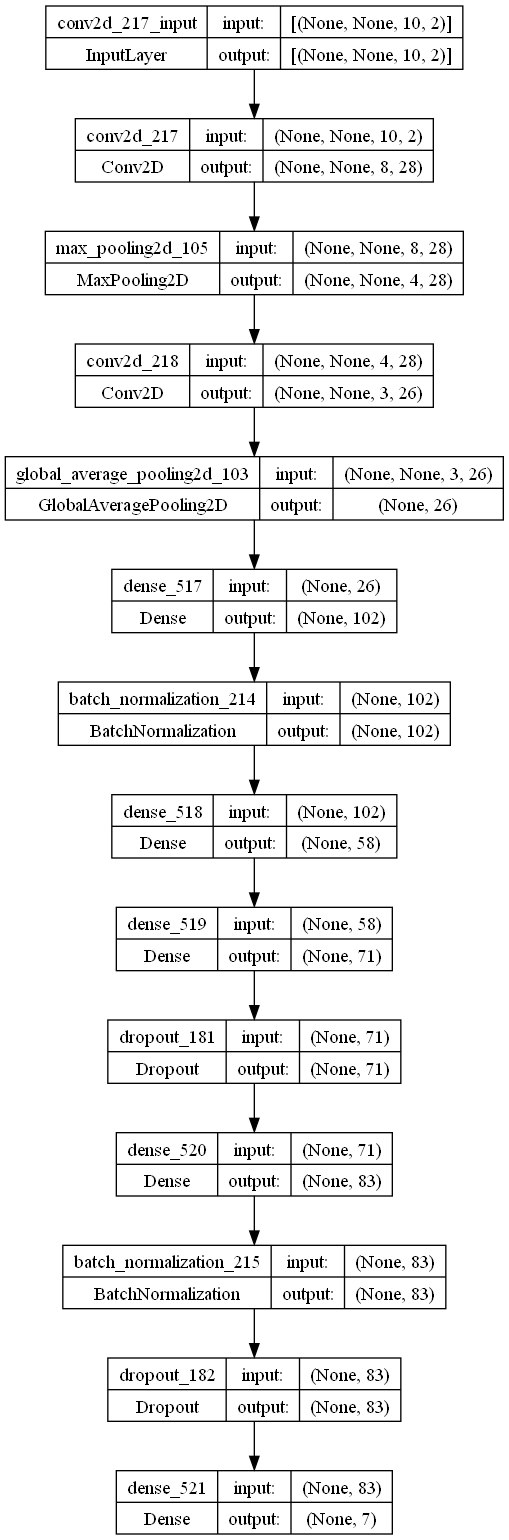

In [31]:
keras.utils.plot_model(model,show_shapes=True)

# Entrenamos el modelo

In [32]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=100.0)

In [33]:
def total_mae_loss(y_true, y_pred):
    total_loss = 0
    num_parameters = 7
    for i in range(num_parameters):
        total_loss += tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])
    tf.print(y_true, summarize = -1)
    tf.print(y_pred, summarize = -1)
    return total_loss / num_parameters

In [34]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [35]:
model.compile(optimizer=optimizer,
              loss= 'mean_squared_error',
              metrics=metrics)

In [36]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

def adaptive_learning_rate(epoch):
    initial_lr = 0.001
    final_lr = 0.00001  # Updated final learning rate
    start_decay_epoch = 200
    end_decay_epoch = 1000
    
    if epoch < start_decay_epoch:
        return initial_lr
    elif epoch >= start_decay_epoch and epoch <= end_decay_epoch:
        lr_range = initial_lr - final_lr
        decay_epochs = end_decay_epoch - start_decay_epoch
        decay_per_epoch = lr_range / decay_epochs
        return initial_lr - (epoch - start_decay_epoch) * decay_per_epoch
    else:
        return final_lr
    

In [37]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_mean_metric', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(adaptive_learning_rate)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/1000
70/70 [==============================] - 2s 16ms/step - loss: 10.0850 - a_1: 2.8607 - a_2: 2.8821 - b_1: 2.1472 - b_2: 2.9728 - d_1: 1.4848 - d_2: 1.6491 - n: 2.2978 - mean_metric: 0.5340 - val_loss: 11.0482 - val_a_1: 2.6468 - val_a_2: 2.6620 - val_b_1: 2.8954 - val_b_2: 2.8315 - val_d_1: 2.6734 - val_d_2: 2.9360 - val_n: 1.6683 - val_mean_metric: 0.5968 - lr: 0.0010
Epoch 2/1000
70/70 [==============================] - 1s 12ms/step - loss: 8.3563 - a_1: 2.7817 - a_2: 2.7764 - b_1: 1.6269 - b_2: 2.8781 - d_1: 1.3437 - d_2: 1.3872 - n: 1.7255 - mean_metric: 0.4757 - val_loss: 10.6017 - val_a_1: 2.6284 - val_a_2: 2.6623 - val_b_1: 2.6415 - val_b_2: 2.8583 - val_d_1: 2.5089 - val_d_2: 3.0684 - val_n: 1.4630 - val_mean_metric: 0.5810 - lr: 0.0010
Epoch 3/1000
70/70 [==============================] - 1s 12ms/step - loss: 7.7586 - a_1: 2.7380 - a_2: 2.7289 - b_1: 1.4649 - b_2: 2.8420 - d_1: 1.2270 - d_2: 1.2666 - n: 1.5991 - mean_metric: 0.4544 - val_loss: 10.8779 - val_a_1: 2.

70/70 [==============================] - 1s 12ms/step - loss: 4.7513 - a_1: 2.1805 - a_2: 2.1739 - b_1: 0.9190 - b_2: 2.7148 - d_1: 0.6425 - d_2: 0.6016 - n: 1.4037 - mean_metric: 0.3485 - val_loss: 4.7468 - val_a_1: 2.1836 - val_a_2: 2.1748 - val_b_1: 0.9440 - val_b_2: 2.8219 - val_d_1: 0.5609 - val_d_2: 0.5734 - val_n: 1.3974 - val_mean_metric: 0.3471 - lr: 0.0010
Epoch 44/1000
70/70 [==============================] - 1s 12ms/step - loss: 4.7232 - a_1: 2.1674 - a_2: 2.1620 - b_1: 0.9273 - b_2: 2.7117 - d_1: 0.6436 - d_2: 0.6293 - n: 1.3995 - mean_metric: 0.3486 - val_loss: 5.0601 - val_a_1: 2.2965 - val_a_2: 2.2801 - val_b_1: 0.9058 - val_b_2: 2.8219 - val_d_1: 0.6363 - val_d_2: 0.7583 - val_n: 1.3888 - val_mean_metric: 0.3612 - lr: 0.0010
Epoch 45/1000
70/70 [==============================] - 1s 12ms/step - loss: 4.7286 - a_1: 2.1733 - a_2: 2.1625 - b_1: 0.9321 - b_2: 2.7136 - d_1: 0.6456 - d_2: 0.6234 - n: 1.4040 - mean_metric: 0.3491 - val_loss: 5.1556 - val_a_1: 2.2725 - val_a_2:

70/70 [==============================] - 1s 12ms/step - loss: 4.2748 - a_1: 2.0347 - a_2: 2.0252 - b_1: 0.8824 - b_2: 2.7131 - d_1: 0.5397 - d_2: 0.5483 - n: 1.3716 - mean_metric: 0.3313 - val_loss: 4.5623 - val_a_1: 2.0789 - val_a_2: 2.2753 - val_b_1: 0.7456 - val_b_2: 2.8220 - val_d_1: 0.4458 - val_d_2: 0.4785 - val_n: 1.3770 - val_mean_metric: 0.3331 - lr: 0.0010
Epoch 86/1000
70/70 [==============================] - 1s 12ms/step - loss: 4.2326 - a_1: 2.0186 - a_2: 2.0179 - b_1: 0.8756 - b_2: 2.7101 - d_1: 0.5488 - d_2: 0.5184 - n: 1.3651 - mean_metric: 0.3295 - val_loss: 4.5019 - val_a_1: 2.0169 - val_a_2: 2.1795 - val_b_1: 0.9345 - val_b_2: 2.8247 - val_d_1: 0.5641 - val_d_2: 0.5308 - val_n: 1.3871 - val_mean_metric: 0.3401 - lr: 0.0010
Epoch 87/1000
70/70 [==============================] - 1s 12ms/step - loss: 4.1872 - a_1: 1.9931 - a_2: 1.9937 - b_1: 0.8546 - b_2: 2.7126 - d_1: 0.5276 - d_2: 0.5210 - n: 1.3646 - mean_metric: 0.3266 - val_loss: 4.2956 - val_a_1: 1.9897 - val_a_2:

70/70 [==============================] - 1s 12ms/step - loss: 4.0470 - a_1: 1.9251 - a_2: 1.9174 - b_1: 0.8534 - b_2: 2.7096 - d_1: 0.5202 - d_2: 0.4725 - n: 1.3492 - mean_metric: 0.3194 - val_loss: 4.3015 - val_a_1: 1.9827 - val_a_2: 2.1038 - val_b_1: 0.7354 - val_b_2: 2.8218 - val_d_1: 0.4298 - val_d_2: 0.3576 - val_n: 1.3941 - val_mean_metric: 0.3201 - lr: 0.0010
Epoch 128/1000
70/70 [==============================] - 1s 12ms/step - loss: 4.0931 - a_1: 1.9514 - a_2: 1.9516 - b_1: 0.8410 - b_2: 2.7107 - d_1: 0.5180 - d_2: 0.4851 - n: 1.3531 - mean_metric: 0.3214 - val_loss: 4.4756 - val_a_1: 2.1182 - val_a_2: 2.1331 - val_b_1: 0.8122 - val_b_2: 2.8245 - val_d_1: 0.5004 - val_d_2: 0.3701 - val_n: 1.3796 - val_mean_metric: 0.3303 - lr: 0.0010
Epoch 129/1000
70/70 [==============================] - 1s 12ms/step - loss: 4.0806 - a_1: 1.9404 - a_2: 1.9396 - b_1: 0.8537 - b_2: 2.7085 - d_1: 0.5235 - d_2: 0.4963 - n: 1.3538 - mean_metric: 0.3215 - val_loss: 4.4516 - val_a_1: 1.9990 - val_a_

70/70 [==============================] - 1s 12ms/step - loss: 3.9802 - a_1: 1.9019 - a_2: 1.8817 - b_1: 0.8444 - b_2: 2.7074 - d_1: 0.4867 - d_2: 0.4739 - n: 1.3473 - mean_metric: 0.3160 - val_loss: 4.1712 - val_a_1: 1.9549 - val_a_2: 1.9631 - val_b_1: 0.8698 - val_b_2: 2.8210 - val_d_1: 0.3930 - val_d_2: 0.5322 - val_n: 1.3645 - val_mean_metric: 0.3225 - lr: 0.0010
Epoch 170/1000
70/70 [==============================] - 1s 12ms/step - loss: 3.9644 - a_1: 1.8996 - a_2: 1.8748 - b_1: 0.8181 - b_2: 2.7096 - d_1: 0.4798 - d_2: 0.4816 - n: 1.3447 - mean_metric: 0.3148 - val_loss: 4.1290 - val_a_1: 1.9526 - val_a_2: 1.9467 - val_b_1: 0.8500 - val_b_2: 2.8177 - val_d_1: 0.4116 - val_d_2: 0.3744 - val_n: 1.3772 - val_mean_metric: 0.3170 - lr: 0.0010
Epoch 171/1000
70/70 [==============================] - 1s 12ms/step - loss: 4.0171 - a_1: 1.9131 - a_2: 1.9114 - b_1: 0.8553 - b_2: 2.7076 - d_1: 0.4931 - d_2: 0.4904 - n: 1.3442 - mean_metric: 0.3184 - val_loss: 4.0966 - val_a_1: 1.9604 - val_a_

70/70 [==============================] - 1s 12ms/step - loss: 3.9386 - a_1: 1.8721 - a_2: 1.8689 - b_1: 0.8335 - b_2: 2.7075 - d_1: 0.4734 - d_2: 0.4770 - n: 1.3412 - mean_metric: 0.3137 - val_loss: 4.1930 - val_a_1: 1.9856 - val_a_2: 1.9682 - val_b_1: 0.7666 - val_b_2: 2.8180 - val_d_1: 0.4780 - val_d_2: 0.3556 - val_n: 1.3852 - val_mean_metric: 0.3179 - lr: 9.8762e-04
Epoch 212/1000
70/70 [==============================] - 1s 12ms/step - loss: 3.8962 - a_1: 1.8459 - a_2: 1.8514 - b_1: 0.8326 - b_2: 2.7072 - d_1: 0.4603 - d_2: 0.4699 - n: 1.3356 - mean_metric: 0.3114 - val_loss: 4.2099 - val_a_1: 1.9703 - val_a_2: 2.0065 - val_b_1: 0.8808 - val_b_2: 2.8203 - val_d_1: 0.4186 - val_d_2: 0.4274 - val_n: 1.3750 - val_mean_metric: 0.3225 - lr: 9.8639e-04
Epoch 213/1000
70/70 [==============================] - 1s 12ms/step - loss: 3.9086 - a_1: 1.8579 - a_2: 1.8463 - b_1: 0.8402 - b_2: 2.7096 - d_1: 0.4625 - d_2: 0.4494 - n: 1.3355 - mean_metric: 0.3113 - val_loss: 4.1646 - val_a_1: 1.9396 

70/70 [==============================] - 1s 12ms/step - loss: 3.8397 - a_1: 1.8251 - a_2: 1.8112 - b_1: 0.8279 - b_2: 2.7056 - d_1: 0.4686 - d_2: 0.4552 - n: 1.3242 - mean_metric: 0.3086 - val_loss: 4.3519 - val_a_1: 1.9727 - val_a_2: 2.0057 - val_b_1: 0.9582 - val_b_2: 2.8230 - val_d_1: 0.4722 - val_d_2: 0.5171 - val_n: 1.3868 - val_mean_metric: 0.3302 - lr: 9.3565e-04
Epoch 254/1000
70/70 [==============================] - 1s 13ms/step - loss: 3.8643 - a_1: 1.8504 - a_2: 1.8163 - b_1: 0.8172 - b_2: 2.7057 - d_1: 0.4848 - d_2: 0.4575 - n: 1.3345 - mean_metric: 0.3102 - val_loss: 4.3057 - val_a_1: 2.0361 - val_a_2: 1.9822 - val_b_1: 0.8557 - val_b_2: 2.8248 - val_d_1: 0.4532 - val_d_2: 0.5159 - val_n: 1.3821 - val_mean_metric: 0.3274 - lr: 9.3441e-04
Epoch 255/1000
70/70 [==============================] - 1s 13ms/step - loss: 3.8528 - a_1: 1.8180 - a_2: 1.8400 - b_1: 0.8302 - b_2: 2.7018 - d_1: 0.4618 - d_2: 0.4592 - n: 1.3310 - mean_metric: 0.3094 - val_loss: 4.1721 - val_a_1: 1.9381 

70/70 [==============================] - 1s 12ms/step - loss: 3.8188 - a_1: 1.8004 - a_2: 1.8225 - b_1: 0.8070 - b_2: 2.7027 - d_1: 0.4609 - d_2: 0.4492 - n: 1.3357 - mean_metric: 0.3072 - val_loss: 4.2145 - val_a_1: 1.9545 - val_a_2: 1.9241 - val_b_1: 0.8524 - val_b_2: 2.8232 - val_d_1: 0.7470 - val_d_2: 0.3455 - val_n: 1.3676 - val_mean_metric: 0.3263 - lr: 8.8368e-04
Epoch 296/1000
70/70 [==============================] - 1s 12ms/step - loss: 3.7938 - a_1: 1.7928 - a_2: 1.7984 - b_1: 0.7985 - b_2: 2.7030 - d_1: 0.4437 - d_2: 0.4508 - n: 1.3226 - mean_metric: 0.3050 - val_loss: 4.1039 - val_a_1: 1.9618 - val_a_2: 1.9032 - val_b_1: 0.7220 - val_b_2: 2.8146 - val_d_1: 0.4471 - val_d_2: 0.3866 - val_n: 1.3785 - val_mean_metric: 0.3132 - lr: 8.8244e-04
Epoch 297/1000
70/70 [==============================] - 1s 12ms/step - loss: 3.7963 - a_1: 1.7991 - a_2: 1.7789 - b_1: 0.8163 - b_2: 2.7022 - d_1: 0.4562 - d_2: 0.4467 - n: 1.3287 - mean_metric: 0.3056 - val_loss: 4.1337 - val_a_1: 1.9327 

70/70 [==============================] - 1s 12ms/step - loss: 3.7869 - a_1: 1.7849 - a_2: 1.8014 - b_1: 0.8020 - b_2: 2.6972 - d_1: 0.4685 - d_2: 0.4603 - n: 1.3178 - mean_metric: 0.3058 - val_loss: 4.1606 - val_a_1: 1.9183 - val_a_2: 1.9680 - val_b_1: 0.7505 - val_b_2: 2.8247 - val_d_1: 0.4126 - val_d_2: 0.3476 - val_n: 1.3720 - val_mean_metric: 0.3125 - lr: 8.3170e-04
Epoch 338/1000
70/70 [==============================] - 1s 12ms/step - loss: 3.7473 - a_1: 1.7809 - a_2: 1.7913 - b_1: 0.7880 - b_2: 2.6932 - d_1: 0.4556 - d_2: 0.4281 - n: 1.3108 - mean_metric: 0.3030 - val_loss: 4.0884 - val_a_1: 1.8974 - val_a_2: 1.9256 - val_b_1: 0.6993 - val_b_2: 2.8223 - val_d_1: 0.4404 - val_d_2: 0.5072 - val_n: 1.3551 - val_mean_metric: 0.3143 - lr: 8.3046e-04
Epoch 339/1000
70/70 [==============================] - 1s 13ms/step - loss: 3.7603 - a_1: 1.7846 - a_2: 1.7803 - b_1: 0.7985 - b_2: 2.6935 - d_1: 0.4645 - d_2: 0.4581 - n: 1.3164 - mean_metric: 0.3046 - val_loss: 4.1651 - val_a_1: 1.9516 

70/70 [==============================] - 1s 13ms/step - loss: 3.7188 - a_1: 1.7685 - a_2: 1.7557 - b_1: 0.7972 - b_2: 2.6904 - d_1: 0.4335 - d_2: 0.4430 - n: 1.3082 - mean_metric: 0.3013 - val_loss: 4.1926 - val_a_1: 1.9492 - val_a_2: 1.9300 - val_b_1: 0.9156 - val_b_2: 2.8267 - val_d_1: 0.4016 - val_d_2: 0.3422 - val_n: 1.3501 - val_mean_metric: 0.3165 - lr: 7.7972e-04
Epoch 380/1000
70/70 [==============================] - 1s 13ms/step - loss: 3.7095 - a_1: 1.7651 - a_2: 1.7522 - b_1: 0.7842 - b_2: 2.6837 - d_1: 0.4457 - d_2: 0.4499 - n: 1.3084 - mean_metric: 0.3011 - val_loss: 4.1777 - val_a_1: 1.9884 - val_a_2: 1.9607 - val_b_1: 0.7408 - val_b_2: 2.8222 - val_d_1: 0.3485 - val_d_2: 0.3773 - val_n: 1.3560 - val_mean_metric: 0.3126 - lr: 7.7849e-04
Epoch 381/1000
70/70 [==============================] - 1s 12ms/step - loss: 3.7096 - a_1: 1.7670 - a_2: 1.7488 - b_1: 0.7907 - b_2: 2.6908 - d_1: 0.4306 - d_2: 0.4469 - n: 1.3079 - mean_metric: 0.3008 - val_loss: 4.0079 - val_a_1: 1.8584 

70/70 [==============================] - 1s 12ms/step - loss: 3.6642 - a_1: 1.7378 - a_2: 1.7460 - b_1: 0.7749 - b_2: 2.6828 - d_1: 0.4268 - d_2: 0.4306 - n: 1.3035 - mean_metric: 0.2982 - val_loss: 4.3385 - val_a_1: 2.0038 - val_a_2: 2.0624 - val_b_1: 0.7821 - val_b_2: 2.8272 - val_d_1: 0.3111 - val_d_2: 0.3929 - val_n: 1.3579 - val_mean_metric: 0.3172 - lr: 7.2775e-04
Epoch 422/1000
70/70 [==============================] - 1s 12ms/step - loss: 3.6793 - a_1: 1.7493 - a_2: 1.7443 - b_1: 0.7831 - b_2: 2.6890 - d_1: 0.4261 - d_2: 0.4355 - n: 1.2985 - mean_metric: 0.2990 - val_loss: 4.1803 - val_a_1: 1.9642 - val_a_2: 1.9603 - val_b_1: 0.8013 - val_b_2: 2.8276 - val_d_1: 0.3876 - val_d_2: 0.3325 - val_n: 1.3416 - val_mean_metric: 0.3133 - lr: 7.2651e-04
Epoch 423/1000
70/70 [==============================] - 1s 12ms/step - loss: 3.6769 - a_1: 1.7461 - a_2: 1.7436 - b_1: 0.7970 - b_2: 2.6880 - d_1: 0.4259 - d_2: 0.4324 - n: 1.2973 - mean_metric: 0.2992 - val_loss: 4.1641 - val_a_1: 1.8976 

70/70 [==============================] - 1s 12ms/step - loss: 3.6291 - a_1: 1.7132 - a_2: 1.7235 - b_1: 0.7881 - b_2: 2.6816 - d_1: 0.4286 - d_2: 0.4375 - n: 1.2967 - mean_metric: 0.2971 - val_loss: 4.2792 - val_a_1: 1.9743 - val_a_2: 2.0059 - val_b_1: 0.7295 - val_b_2: 2.8334 - val_d_1: 0.3596 - val_d_2: 0.3791 - val_n: 1.3826 - val_mean_metric: 0.3149 - lr: 6.7577e-04
Epoch 464/1000
70/70 [==============================] - 1s 12ms/step - loss: 3.6667 - a_1: 1.7340 - a_2: 1.7340 - b_1: 0.8005 - b_2: 2.6856 - d_1: 0.4385 - d_2: 0.4360 - n: 1.3043 - mean_metric: 0.2992 - val_loss: 4.1133 - val_a_1: 1.9141 - val_a_2: 1.8802 - val_b_1: 0.6804 - val_b_2: 2.8278 - val_d_1: 0.6232 - val_d_2: 0.4307 - val_n: 1.3344 - val_mean_metric: 0.3158 - lr: 6.7454e-04
Epoch 465/1000
70/70 [==============================] - 1s 12ms/step - loss: 3.6549 - a_1: 1.7371 - a_2: 1.7259 - b_1: 0.7896 - b_2: 2.6825 - d_1: 0.4295 - d_2: 0.4299 - n: 1.3045 - mean_metric: 0.2981 - val_loss: 4.1260 - val_a_1: 1.8918 

70/70 [==============================] - 1s 12ms/step - loss: 3.5984 - a_1: 1.7009 - a_2: 1.7104 - b_1: 0.7762 - b_2: 2.6755 - d_1: 0.4179 - d_2: 0.4273 - n: 1.2977 - mean_metric: 0.2950 - val_loss: 4.2252 - val_a_1: 1.9395 - val_a_2: 1.9438 - val_b_1: 0.7287 - val_b_2: 2.8399 - val_d_1: 0.5071 - val_d_2: 0.4352 - val_n: 1.3478 - val_mean_metric: 0.3174 - lr: 6.2380e-04
Epoch 506/1000
70/70 [==============================] - 1s 12ms/step - loss: 3.6128 - a_1: 1.7135 - a_2: 1.7127 - b_1: 0.7875 - b_2: 2.6784 - d_1: 0.4082 - d_2: 0.4428 - n: 1.2967 - mean_metric: 0.2962 - val_loss: 4.1883 - val_a_1: 1.9385 - val_a_2: 1.9748 - val_b_1: 0.8033 - val_b_2: 2.8327 - val_d_1: 0.3425 - val_d_2: 0.3221 - val_n: 1.3400 - val_mean_metric: 0.3113 - lr: 6.2256e-04
Epoch 507/1000
70/70 [==============================] - 1s 12ms/step - loss: 3.6338 - a_1: 1.7278 - a_2: 1.7349 - b_1: 0.7884 - b_2: 2.6776 - d_1: 0.4100 - d_2: 0.4346 - n: 1.2988 - mean_metric: 0.2972 - val_loss: 4.1393 - val_a_1: 1.8615 

70/70 [==============================] - 1s 12ms/step - loss: 3.5920 - a_1: 1.7095 - a_2: 1.6980 - b_1: 0.7833 - b_2: 2.6734 - d_1: 0.4304 - d_2: 0.4257 - n: 1.2969 - mean_metric: 0.2954 - val_loss: 4.1969 - val_a_1: 1.9739 - val_a_2: 1.9546 - val_b_1: 0.6874 - val_b_2: 2.8321 - val_d_1: 0.3637 - val_d_2: 0.3559 - val_n: 1.3447 - val_mean_metric: 0.3099 - lr: 5.7183e-04
Epoch 548/1000
70/70 [==============================] - 1s 12ms/step - loss: 3.6073 - a_1: 1.7119 - a_2: 1.7172 - b_1: 0.7728 - b_2: 2.6790 - d_1: 0.4087 - d_2: 0.4430 - n: 1.2939 - mean_metric: 0.2957 - val_loss: 4.2431 - val_a_1: 1.9850 - val_a_2: 1.9086 - val_b_1: 0.9329 - val_b_2: 2.8421 - val_d_1: 0.3538 - val_d_2: 0.4114 - val_n: 1.3431 - val_mean_metric: 0.3185 - lr: 5.7059e-04
Epoch 549/1000
70/70 [==============================] - 1s 13ms/step - loss: 3.6228 - a_1: 1.7106 - a_2: 1.7214 - b_1: 0.7897 - b_2: 2.6833 - d_1: 0.4154 - d_2: 0.4429 - n: 1.2949 - mean_metric: 0.2968 - val_loss: 4.1322 - val_a_1: 1.9189 

70/70 [==============================] - 1s 12ms/step - loss: 3.5817 - a_1: 1.7056 - a_2: 1.6992 - b_1: 0.7764 - b_2: 2.6787 - d_1: 0.4234 - d_2: 0.4294 - n: 1.2918 - mean_metric: 0.2950 - val_loss: 4.0762 - val_a_1: 1.8760 - val_a_2: 1.9194 - val_b_1: 0.6985 - val_b_2: 2.8409 - val_d_1: 0.4410 - val_d_2: 0.3567 - val_n: 1.3354 - val_mean_metric: 0.3085 - lr: 5.1985e-04
Epoch 590/1000
70/70 [==============================] - 1s 12ms/step - loss: 3.5920 - a_1: 1.7171 - a_2: 1.6980 - b_1: 0.7838 - b_2: 2.6793 - d_1: 0.4090 - d_2: 0.4314 - n: 1.2893 - mean_metric: 0.2951 - val_loss: 4.2521 - val_a_1: 1.9464 - val_a_2: 2.0180 - val_b_1: 0.8033 - val_b_2: 2.8368 - val_d_1: 0.3520 - val_d_2: 0.3863 - val_n: 1.3357 - val_mean_metric: 0.3153 - lr: 5.1861e-04
Epoch 591/1000
70/70 [==============================] - 1s 12ms/step - loss: 3.5783 - a_1: 1.6919 - a_2: 1.7068 - b_1: 0.7901 - b_2: 2.6688 - d_1: 0.4156 - d_2: 0.4331 - n: 1.2893 - mean_metric: 0.2947 - val_loss: 4.1706 - val_a_1: 1.9692 

70/70 [==============================] - 1s 13ms/step - loss: 3.5863 - a_1: 1.7115 - a_2: 1.6993 - b_1: 0.7886 - b_2: 2.6771 - d_1: 0.4237 - d_2: 0.4318 - n: 1.2837 - mean_metric: 0.2954 - val_loss: 4.2541 - val_a_1: 1.9806 - val_a_2: 1.9367 - val_b_1: 0.7098 - val_b_2: 2.8463 - val_d_1: 0.6067 - val_d_2: 0.4612 - val_n: 1.3329 - val_mean_metric: 0.3217 - lr: 4.6788e-04
Epoch 632/1000
70/70 [==============================] - 1s 13ms/step - loss: 3.5553 - a_1: 1.6972 - a_2: 1.6919 - b_1: 0.7710 - b_2: 2.6686 - d_1: 0.4169 - d_2: 0.4214 - n: 1.2848 - mean_metric: 0.2932 - val_loss: 4.1784 - val_a_1: 1.9208 - val_a_2: 1.9486 - val_b_1: 0.7861 - val_b_2: 2.8412 - val_d_1: 0.4427 - val_d_2: 0.3415 - val_n: 1.3238 - val_mean_metric: 0.3129 - lr: 4.6664e-04
Epoch 633/1000
70/70 [==============================] - 1s 12ms/step - loss: 3.5445 - a_1: 1.6916 - a_2: 1.6740 - b_1: 0.7771 - b_2: 2.6724 - d_1: 0.4137 - d_2: 0.4174 - n: 1.2867 - mean_metric: 0.2926 - val_loss: 4.1854 - val_a_1: 1.9096 

70/70 [==============================] - 1s 12ms/step - loss: 3.5515 - a_1: 1.6869 - a_2: 1.6835 - b_1: 0.7899 - b_2: 2.6665 - d_1: 0.4008 - d_2: 0.4340 - n: 1.2807 - mean_metric: 0.2930 - val_loss: 4.1408 - val_a_1: 1.8750 - val_a_2: 1.9925 - val_b_1: 0.6879 - val_b_2: 2.8407 - val_d_1: 0.3289 - val_d_2: 0.3145 - val_n: 1.3401 - val_mean_metric: 0.3056 - lr: 4.1590e-04
Epoch 674/1000
70/70 [==============================] - 1s 12ms/step - loss: 3.5229 - a_1: 1.6886 - a_2: 1.6625 - b_1: 0.7648 - b_2: 2.6689 - d_1: 0.3948 - d_2: 0.4204 - n: 1.2830 - mean_metric: 0.2910 - val_loss: 4.0972 - val_a_1: 1.9037 - val_a_2: 1.9194 - val_b_1: 0.7103 - val_b_2: 2.8544 - val_d_1: 0.2915 - val_d_2: 0.3134 - val_n: 1.3225 - val_mean_metric: 0.3035 - lr: 4.1466e-04
Epoch 675/1000
70/70 [==============================] - 1s 12ms/step - loss: 3.5191 - a_1: 1.6745 - a_2: 1.6620 - b_1: 0.7784 - b_2: 2.6676 - d_1: 0.4154 - d_2: 0.4274 - n: 1.2901 - mean_metric: 0.2922 - val_loss: 4.1281 - val_a_1: 1.9363 

70/70 [==============================] - 1s 12ms/step - loss: 3.5032 - a_1: 1.6742 - a_2: 1.6571 - b_1: 0.7632 - b_2: 2.6664 - d_1: 0.4151 - d_2: 0.4178 - n: 1.2788 - mean_metric: 0.2907 - val_loss: 4.0986 - val_a_1: 1.8619 - val_a_2: 1.9161 - val_b_1: 0.8837 - val_b_2: 2.8394 - val_d_1: 0.2988 - val_d_2: 0.3312 - val_n: 1.3234 - val_mean_metric: 0.3080 - lr: 3.6393e-04
Epoch 716/1000
70/70 [==============================] - 1s 12ms/step - loss: 3.4937 - a_1: 1.6656 - a_2: 1.6512 - b_1: 0.7657 - b_2: 2.6616 - d_1: 0.4145 - d_2: 0.4147 - n: 1.2795 - mean_metric: 0.2900 - val_loss: 4.1080 - val_a_1: 1.8455 - val_a_2: 1.9725 - val_b_1: 0.7223 - val_b_2: 2.8503 - val_d_1: 0.3261 - val_d_2: 0.3643 - val_n: 1.3367 - val_mean_metric: 0.3068 - lr: 3.6269e-04
Epoch 717/1000
70/70 [==============================] - 1s 12ms/step - loss: 3.5278 - a_1: 1.6760 - a_2: 1.6878 - b_1: 0.7555 - b_2: 2.6660 - d_1: 0.4004 - d_2: 0.4306 - n: 1.2826 - mean_metric: 0.2916 - val_loss: 4.0707 - val_a_1: 1.8434 

70/70 [==============================] - 1s 12ms/step - loss: 3.4909 - a_1: 1.6726 - a_2: 1.6539 - b_1: 0.7636 - b_2: 2.6668 - d_1: 0.4042 - d_2: 0.4149 - n: 1.2808 - mean_metric: 0.2902 - val_loss: 4.0835 - val_a_1: 1.8631 - val_a_2: 1.9734 - val_b_1: 0.7105 - val_b_2: 2.8504 - val_d_1: 0.2861 - val_d_2: 0.3646 - val_n: 1.3248 - val_mean_metric: 0.3054 - lr: 3.1195e-04
Epoch 758/1000
70/70 [==============================] - 1s 12ms/step - loss: 3.4639 - a_1: 1.6513 - a_2: 1.6553 - b_1: 0.7565 - b_2: 2.6584 - d_1: 0.3881 - d_2: 0.4112 - n: 1.2793 - mean_metric: 0.2883 - val_loss: 4.0453 - val_a_1: 1.8493 - val_a_2: 1.9475 - val_b_1: 0.6855 - val_b_2: 2.8473 - val_d_1: 0.3046 - val_d_2: 0.3222 - val_n: 1.3197 - val_mean_metric: 0.3022 - lr: 3.1071e-04
Epoch 759/1000
70/70 [==============================] - 1s 12ms/step - loss: 3.4713 - a_1: 1.6514 - a_2: 1.6399 - b_1: 0.7517 - b_2: 2.6671 - d_1: 0.4031 - d_2: 0.4252 - n: 1.2861 - mean_metric: 0.2891 - val_loss: 4.1609 - val_a_1: 1.9521 

70/70 [==============================] - 1s 12ms/step - loss: 3.4653 - a_1: 1.6479 - a_2: 1.6428 - b_1: 0.7527 - b_2: 2.6673 - d_1: 0.3914 - d_2: 0.4292 - n: 1.2804 - mean_metric: 0.2887 - val_loss: 4.0851 - val_a_1: 1.8949 - val_a_2: 1.9642 - val_b_1: 0.6941 - val_b_2: 2.8371 - val_d_1: 0.2652 - val_d_2: 0.3693 - val_n: 1.3142 - val_mean_metric: 0.3043 - lr: 2.5998e-04
Epoch 800/1000
70/70 [==============================] - 1s 12ms/step - loss: 3.4395 - a_1: 1.6494 - a_2: 1.6213 - b_1: 0.7494 - b_2: 2.6598 - d_1: 0.3974 - d_2: 0.4166 - n: 1.2765 - mean_metric: 0.2874 - val_loss: 4.2344 - val_a_1: 1.9825 - val_a_2: 1.9873 - val_b_1: 0.8141 - val_b_2: 2.8431 - val_d_1: 0.2910 - val_d_2: 0.3234 - val_n: 1.3262 - val_mean_metric: 0.3117 - lr: 2.5874e-04
Epoch 801/1000
70/70 [==============================] - 1s 12ms/step - loss: 3.4654 - a_1: 1.6521 - a_2: 1.6472 - b_1: 0.7545 - b_2: 2.6586 - d_1: 0.4062 - d_2: 0.4029 - n: 1.2831 - mean_metric: 0.2885 - val_loss: 4.0678 - val_a_1: 1.8760 

70/70 [==============================] - 1s 12ms/step - loss: 3.4190 - a_1: 1.6369 - a_2: 1.6173 - b_1: 0.7435 - b_2: 2.6547 - d_1: 0.3964 - d_2: 0.4173 - n: 1.2759 - mean_metric: 0.2864 - val_loss: 4.1871 - val_a_1: 1.9202 - val_a_2: 2.0229 - val_b_1: 0.7454 - val_b_2: 2.8442 - val_d_1: 0.2636 - val_d_2: 0.3124 - val_n: 1.3232 - val_mean_metric: 0.3073 - lr: 2.0800e-04
Epoch 842/1000
70/70 [==============================] - 1s 12ms/step - loss: 3.4164 - a_1: 1.6218 - a_2: 1.6279 - b_1: 0.7448 - b_2: 2.6519 - d_1: 0.3896 - d_2: 0.4135 - n: 1.2728 - mean_metric: 0.2858 - val_loss: 4.0889 - val_a_1: 1.8514 - val_a_2: 1.9980 - val_b_1: 0.6505 - val_b_2: 2.8428 - val_d_1: 0.2748 - val_d_2: 0.3098 - val_n: 1.3116 - val_mean_metric: 0.3010 - lr: 2.0676e-04
Epoch 843/1000
70/70 [==============================] - 1s 12ms/step - loss: 3.4338 - a_1: 1.6371 - a_2: 1.6305 - b_1: 0.7665 - b_2: 2.6604 - d_1: 0.3823 - d_2: 0.4124 - n: 1.2766 - mean_metric: 0.2871 - val_loss: 4.1802 - val_a_1: 1.9392 

70/70 [==============================] - 1s 12ms/step - loss: 3.3953 - a_1: 1.6174 - a_2: 1.6116 - b_1: 0.7564 - b_2: 2.6564 - d_1: 0.3862 - d_2: 0.4082 - n: 1.2747 - mean_metric: 0.2854 - val_loss: 4.0870 - val_a_1: 1.8649 - val_a_2: 1.9747 - val_b_1: 0.6937 - val_b_2: 2.8476 - val_d_1: 0.2802 - val_d_2: 0.2838 - val_n: 1.3090 - val_mean_metric: 0.3015 - lr: 1.5602e-04
Epoch 884/1000
70/70 [==============================] - 1s 12ms/step - loss: 3.3819 - a_1: 1.6059 - a_2: 1.6075 - b_1: 0.7434 - b_2: 2.6475 - d_1: 0.3846 - d_2: 0.4096 - n: 1.2761 - mean_metric: 0.2842 - val_loss: 4.1293 - val_a_1: 1.8974 - val_a_2: 1.9954 - val_b_1: 0.6675 - val_b_2: 2.8463 - val_d_1: 0.2707 - val_d_2: 0.3391 - val_n: 1.3125 - val_mean_metric: 0.3039 - lr: 1.5479e-04
Epoch 885/1000
70/70 [==============================] - 1s 12ms/step - loss: 3.3963 - a_1: 1.6218 - a_2: 1.6165 - b_1: 0.7490 - b_2: 2.6522 - d_1: 0.3916 - d_2: 0.4020 - n: 1.2704 - mean_metric: 0.2851 - val_loss: 4.1531 - val_a_1: 1.9177 

70/70 [==============================] - 1s 12ms/step - loss: 3.3683 - a_1: 1.6098 - a_2: 1.6112 - b_1: 0.7426 - b_2: 2.6492 - d_1: 0.3814 - d_2: 0.4065 - n: 1.2672 - mean_metric: 0.2840 - val_loss: 4.0982 - val_a_1: 1.8745 - val_a_2: 1.9848 - val_b_1: 0.6777 - val_b_2: 2.8475 - val_d_1: 0.2646 - val_d_2: 0.2818 - val_n: 1.3118 - val_mean_metric: 0.3011 - lr: 1.0405e-04
Epoch 926/1000
70/70 [==============================] - 1s 12ms/step - loss: 3.3635 - a_1: 1.6128 - a_2: 1.6018 - b_1: 0.7386 - b_2: 2.6443 - d_1: 0.3855 - d_2: 0.4133 - n: 1.2688 - mean_metric: 0.2839 - val_loss: 4.0248 - val_a_1: 1.8144 - val_a_2: 1.9649 - val_b_1: 0.6387 - val_b_2: 2.8487 - val_d_1: 0.2667 - val_d_2: 0.2892 - val_n: 1.3095 - val_mean_metric: 0.2975 - lr: 1.0281e-04
Epoch 927/1000
70/70 [==============================] - 1s 12ms/step - loss: 3.3673 - a_1: 1.6068 - a_2: 1.5996 - b_1: 0.7459 - b_2: 2.6476 - d_1: 0.3768 - d_2: 0.3943 - n: 1.2786 - mean_metric: 0.2834 - val_loss: 4.0247 - val_a_1: 1.8287 

70/70 [==============================] - 1s 12ms/step - loss: 3.3445 - a_1: 1.5931 - a_2: 1.5943 - b_1: 0.7380 - b_2: 2.6423 - d_1: 0.3658 - d_2: 0.4010 - n: 1.2671 - mean_metric: 0.2819 - val_loss: 3.9773 - val_a_1: 1.7824 - val_a_2: 1.9294 - val_b_1: 0.6332 - val_b_2: 2.8504 - val_d_1: 0.2798 - val_d_2: 0.2924 - val_n: 1.3090 - val_mean_metric: 0.2957 - lr: 5.2075e-05
Epoch 968/1000
70/70 [==============================] - 1s 12ms/step - loss: 3.3367 - a_1: 1.5999 - a_2: 1.5821 - b_1: 0.7349 - b_2: 2.6418 - d_1: 0.3804 - d_2: 0.3827 - n: 1.2724 - mean_metric: 0.2815 - val_loss: 3.9774 - val_a_1: 1.7869 - val_a_2: 1.9288 - val_b_1: 0.6517 - val_b_2: 2.8468 - val_d_1: 0.2528 - val_d_2: 0.2977 - val_n: 1.3097 - val_mean_metric: 0.2956 - lr: 5.0838e-05
Epoch 969/1000
70/70 [==============================] - 1s 12ms/step - loss: 3.3346 - a_1: 1.5982 - a_2: 1.5846 - b_1: 0.7293 - b_2: 2.6360 - d_1: 0.3833 - d_2: 0.3868 - n: 1.2745 - mean_metric: 0.2815 - val_loss: 3.9663 - val_a_1: 1.7855 

# Analizamos accuracy y loss

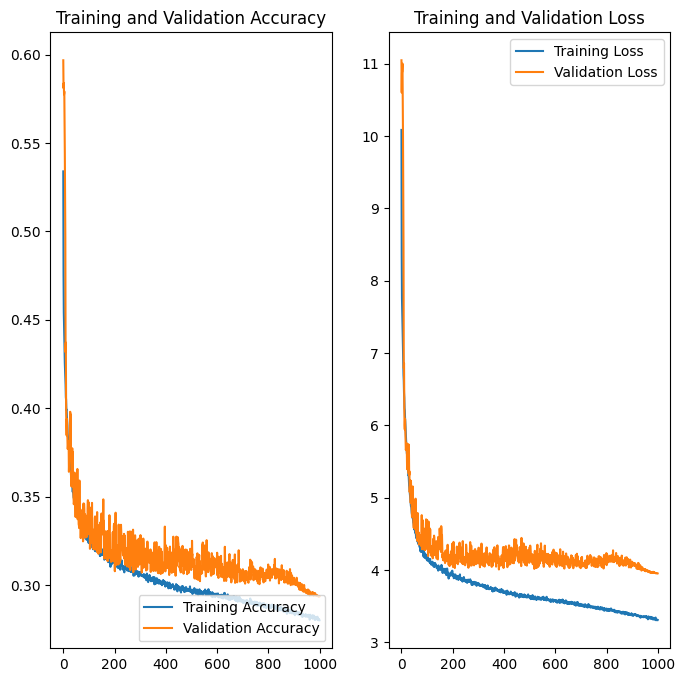

In [38]:
acc = history.history['mean_metric']
val_acc = history.history['val_mean_metric']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(val_epochs)
epochs_range = range(val_epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

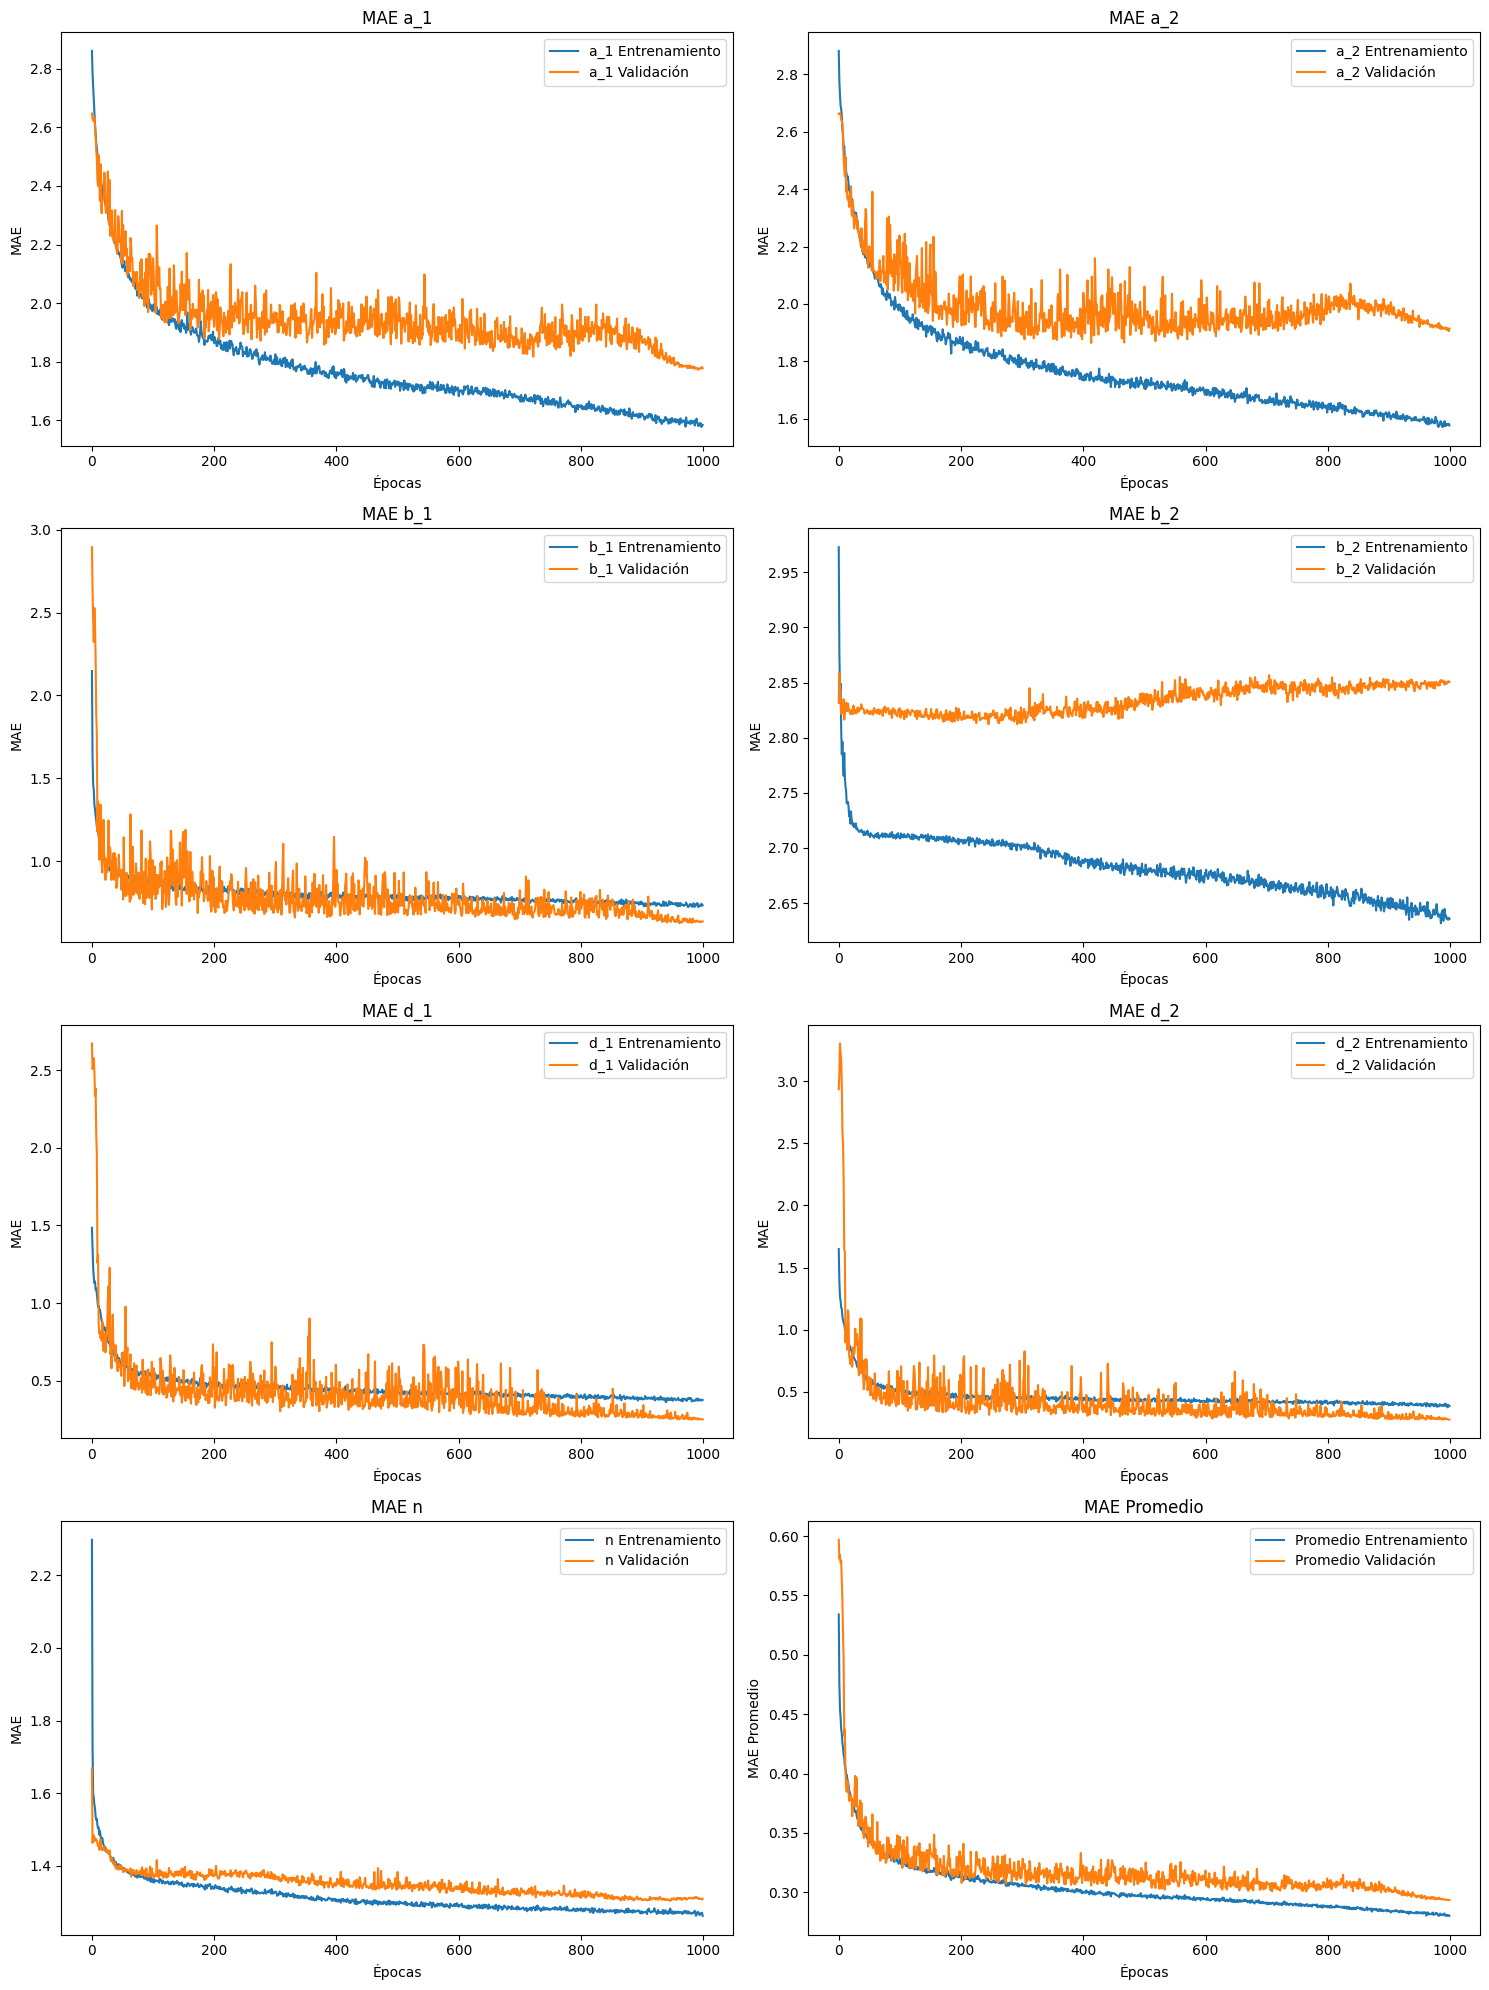

In [39]:
# Número de coeficientes más uno para la métrica adicional
n_coef = len(coeficientesnombres) + 1

# Número de filas y columnas para los subplots
n_rows = (n_coef + 1) // 2
n_cols = 2

# Crear una figura más grande para acomodar todos los subplots
plt.figure(figsize=(15, 5 * n_rows))

# Crear un subplot para cada coeficiente
for i, name in enumerate(coeficientesnombres):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.plot(history.history[name ], label=name + ' Entrenamiento')
    plt.plot(history.history['val_' + name ], label=name + ' Validación')
    plt.title('MAE ' + name)
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.legend()

# Agregar un subplot para la métrica prom_per
plt.subplot(n_rows, n_cols, n_coef)
plt.plot(history.history['mean_metric'], label='Promedio Entrenamiento')
plt.plot(history.history['val_mean_metric'], label='Promedio Validación')
plt.title('MAE Promedio')
plt.xlabel('Épocas')
plt.ylabel('MAE Promedio')
plt.legend()

# Ajustar el diseño para asegurarse de que todo encaje bien
plt.tight_layout()
plt.show()

# Evaluamos el modelo

In [40]:
test_loss, test_a1, test_a2, test_b1, test_b2, test_d1, test_d2, test_n, testprom_per = model.evaluate(
    varftest, coefvarftest)

63/63 [==============================] - 0s 4ms/step - loss: 3.8868 - a_1: 1.8050 - a_2: 1.8324 - b_1: 0.6727 - b_2: 2.8282 - d_1: 0.2567 - d_2: 0.2895 - n: 1.2850 - mean_metric: 0.2952


In [41]:
predictions = model.predict(varftest)

63/63 [==============================] - 0s 1ms/step


In [42]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Calcula el MAE
mae = mean_absolute_error(coefvarftest, predictions)

# Calcula la desviación estándar del error
error = coefvarftest - predictions
std_dev = np.std(error)

# Calcula el error absoluto máximo
max_error = np.max(np.abs(error))

print(f"MAE: {mae}, Desviación estándar del error: {std_dev}, Error absoluto máximo: {max_error}")

MAE: 1.2816471843741841, Desviación estándar del error: 1.9018903868070318, Error absoluto máximo: 9.99985522274801


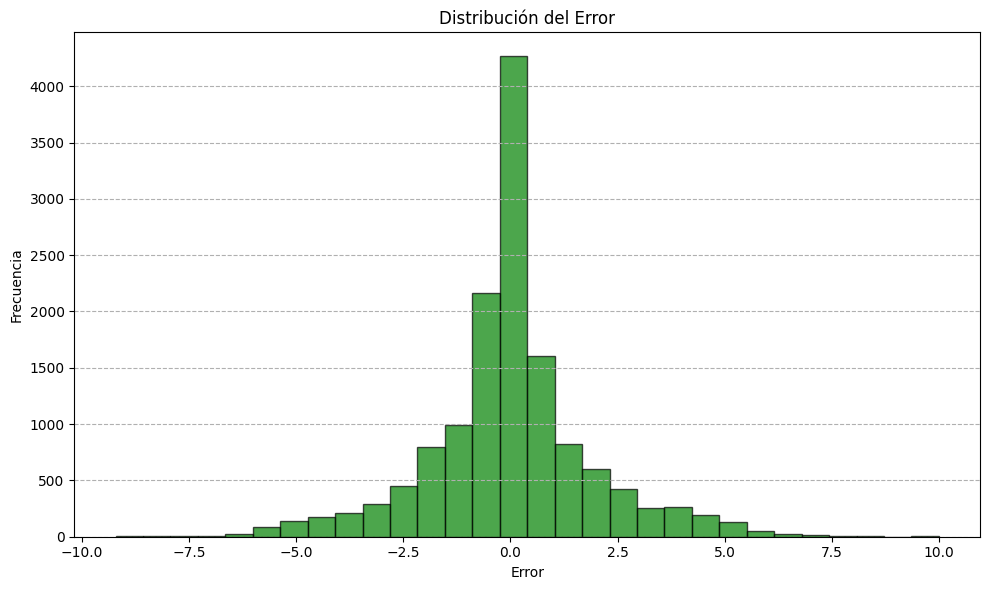

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(error.flatten(), bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error')  # Añade un título al gráfico
plt.xlabel('Error')  # Etiqueta el eje x
plt.ylabel('Frecuencia')  # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()

In [44]:
# Calcula el error absoluto para cada dato
absolute_error = np.abs(coefvarftest - predictions)

# Calcula el error para cada dato
error = coefvarftest - predictions

# Calcula la suma de los valores reales para cada dato
sum_real_values = np.sum(coefvarftest, axis=-1)

# Divide el error absoluto por la suma de los valores reales para cada dato
relative_error_per_data = np.sum(absolute_error, axis=-1) / sum_real_values

# Calcula el MAE relativo como la media de los errores relativos
relative_mae = np.mean(relative_error_per_data)

# Divide el error por la suma de los valores reales para cada dato
relative_error_per_data_std_max = np.sum(error, axis=-1) / sum_real_values

# Calcula la desviación estándar del error relativo
relative_std_dev = np.std(relative_error_per_data_std_max)

# Calcula el error absoluto máximo relativo
relative_max_error = np.max(np.abs(relative_error_per_data_std_max))

print(f"MAE relativo: {relative_mae}")
print(f"Desviación estándar del error relativo: {relative_std_dev}")
print(f"Error absoluto máximo relativo: {relative_max_error}")


MAE relativo: 0.2985040171110129
Desviación estándar del error relativo: 0.19611131387732506
Error absoluto máximo relativo: 2.257270942841257


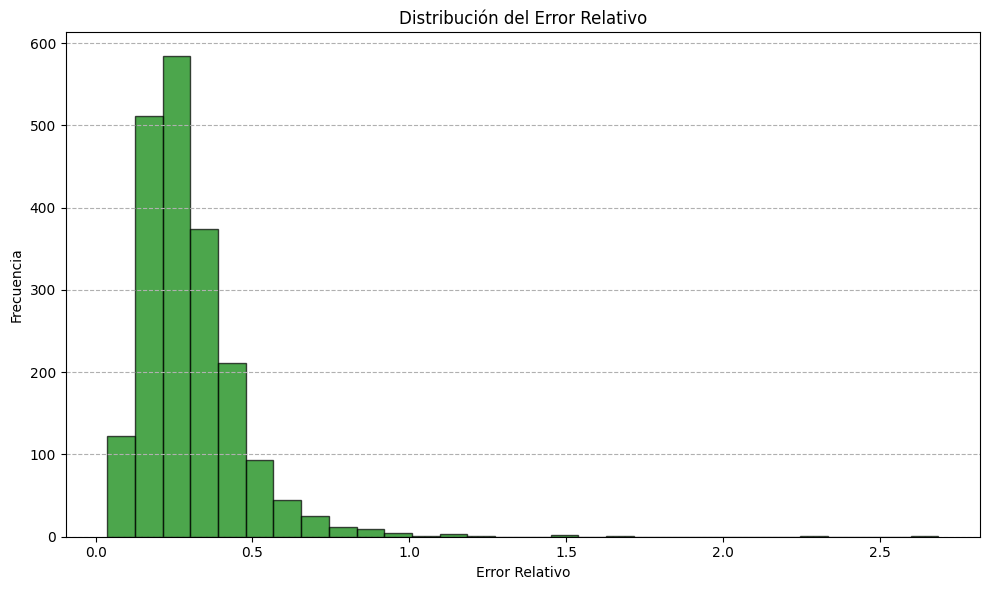

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(relative_error_per_data, bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error Relativo')  # Añade un título al gráfico
plt.xlabel('Error Relativo')  # Etiqueta el eje x
plt.ylabel('Frecuencia')      # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()

# Guardamos los datos de Accuracy y Loss

In [47]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../Graficas/historyconvtrayec.csv', index=False)

# Guardamos el modelo

In [48]:
path_to_save = '../Modelos'

In [49]:
model.save(path_to_save + '/convolucionaltr.h5')

# Importamos el modelo

In [1]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [2]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [3]:
import keras
import tensorflow as tf
# Creación de un diccionario con todas las métricas personalizadas
custom_objects = {'custom_activation':custom_activation,'mean_metric': mean_metric}
for i in range(7):
    custom_objects[coeficientesnombres[i]] = mse_component(i)
new_model = keras.models.load_model('../Modelos/convolucionaltr.h5', custom_objects=custom_objects)

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [54]:
import random
from scipy.integrate import solve_ivp
condini = []
varf = []
coef = []
contador = 0
for i in range(0, 1):
    # constantes
    a1 = random.randint(1, 10)
    a2 = random.randint(1, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(1, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        # dX_dt=a1/(1+Y**n)-d1*X+b1
        # dY_dt=a2/(1+X**n)-d2*Y+b2
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b1

        return [dX_dt, dY_dt]

    # Declaramos el vector de tiempo
    t_span = [0, 5]
    times = np.linspace(t_span[0], t_span[1], 200)
    
    varfci2 = []
    for i_ci in range(0, 10):
        # Definimos las condiciones iniciales
        y0 = np.array([random.randint(0, 10), random.randint(0, 10)])
        condini.append(y0)
        # Resolvemos
        # Modificar manualmente el intervalo de tiempo
        sol = solve_ivp(f, t_span, y0, t_eval=times)
        tiempo = sol.t
        var1 = sol.y[0]
        var2 = sol.y[1]

        varfci = np.append([var1], [var2], axis=0)
        varfci2.append(varfci)

       

    varf= varfci2
    print('--------------------------------------------')
    print(coef1)
    print(np.shape(varf))
varf = np.array(varf)
coef = np.array(coef)

--------------------------------------------
[6, 10, 3, 0, 9, 3, 4]
(10, 2, 200)


In [55]:
varfnone = varf[None, :]
varfnone = np.transpose(varfnone, (0,3,1,2))

## Predecimos con los datos nuevos

In [56]:
new_predictions = new_model.predict(varfnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 68ms/step
[[ 6. 10.  3.  4.  9.  3.  4.]]


## Graficamos con los coeficientes reales

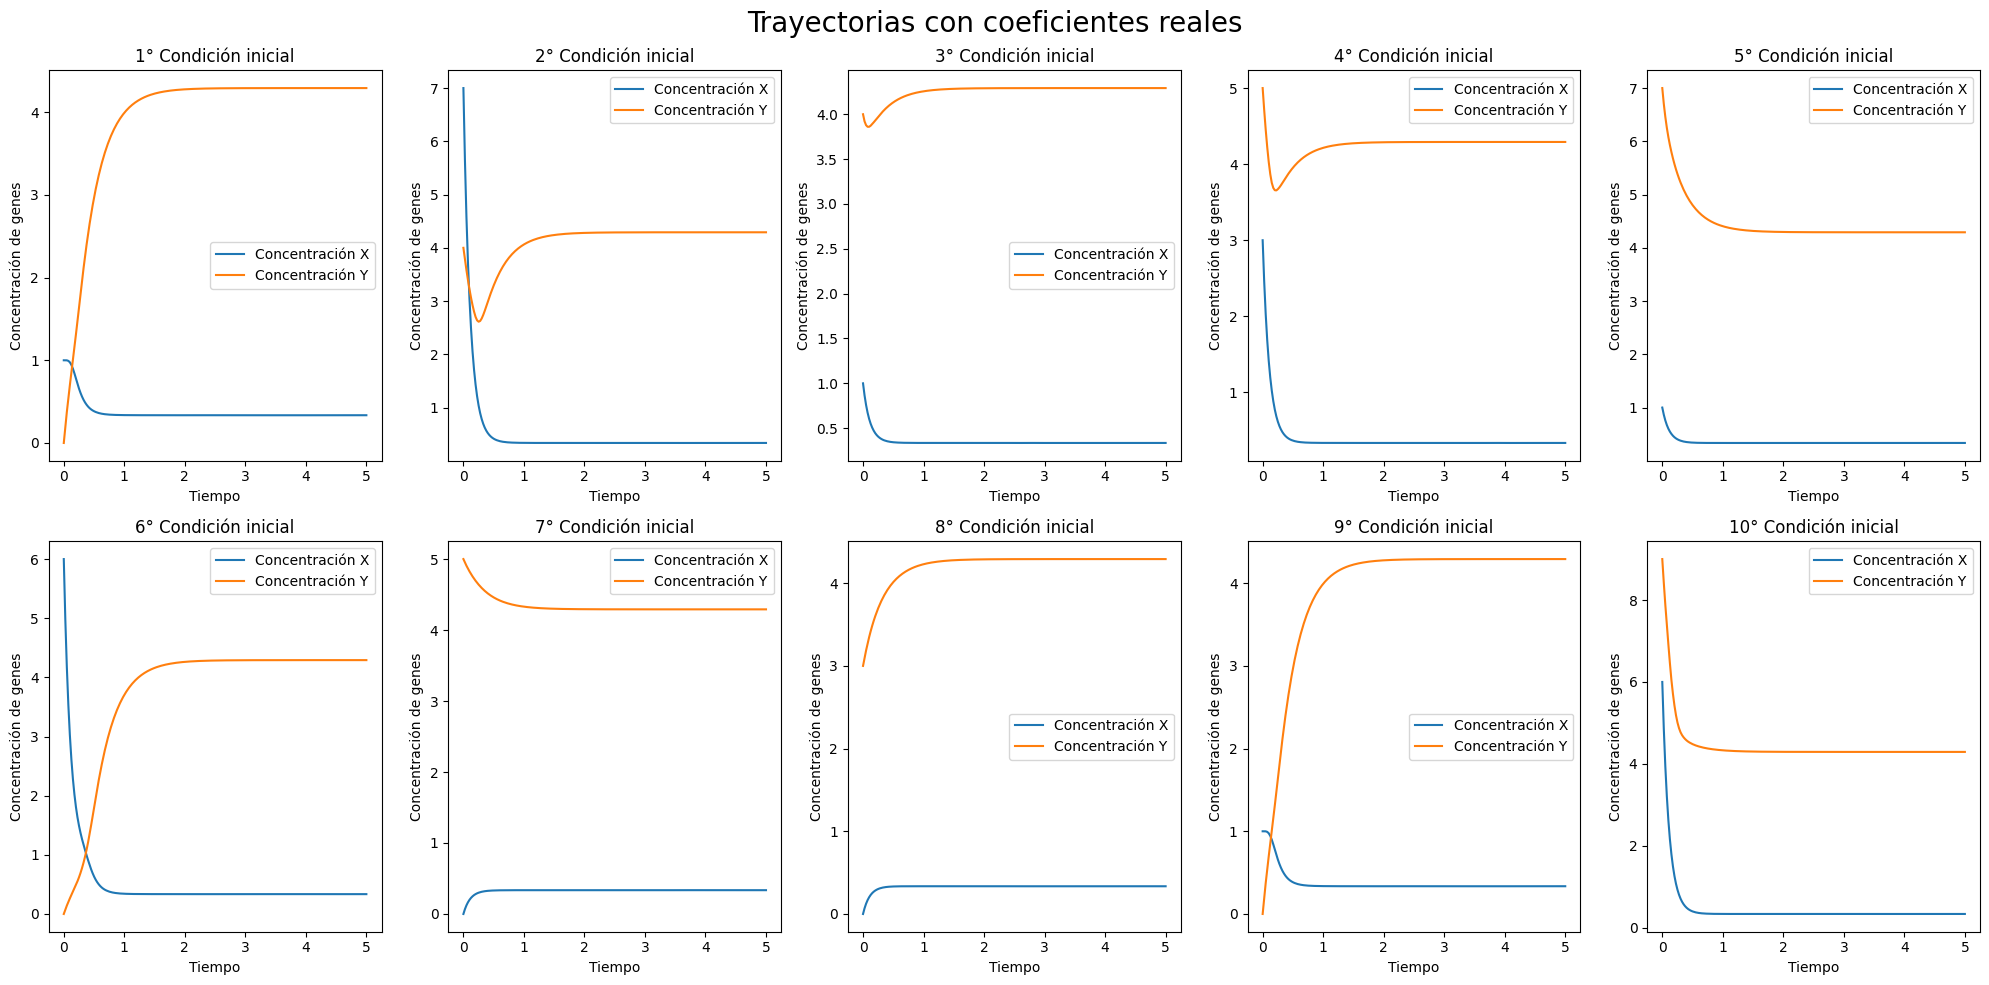

In [57]:
import matplotlib.pyplot as plt

t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 200)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes reales', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

## Graficamos con los coeficientes predecidos

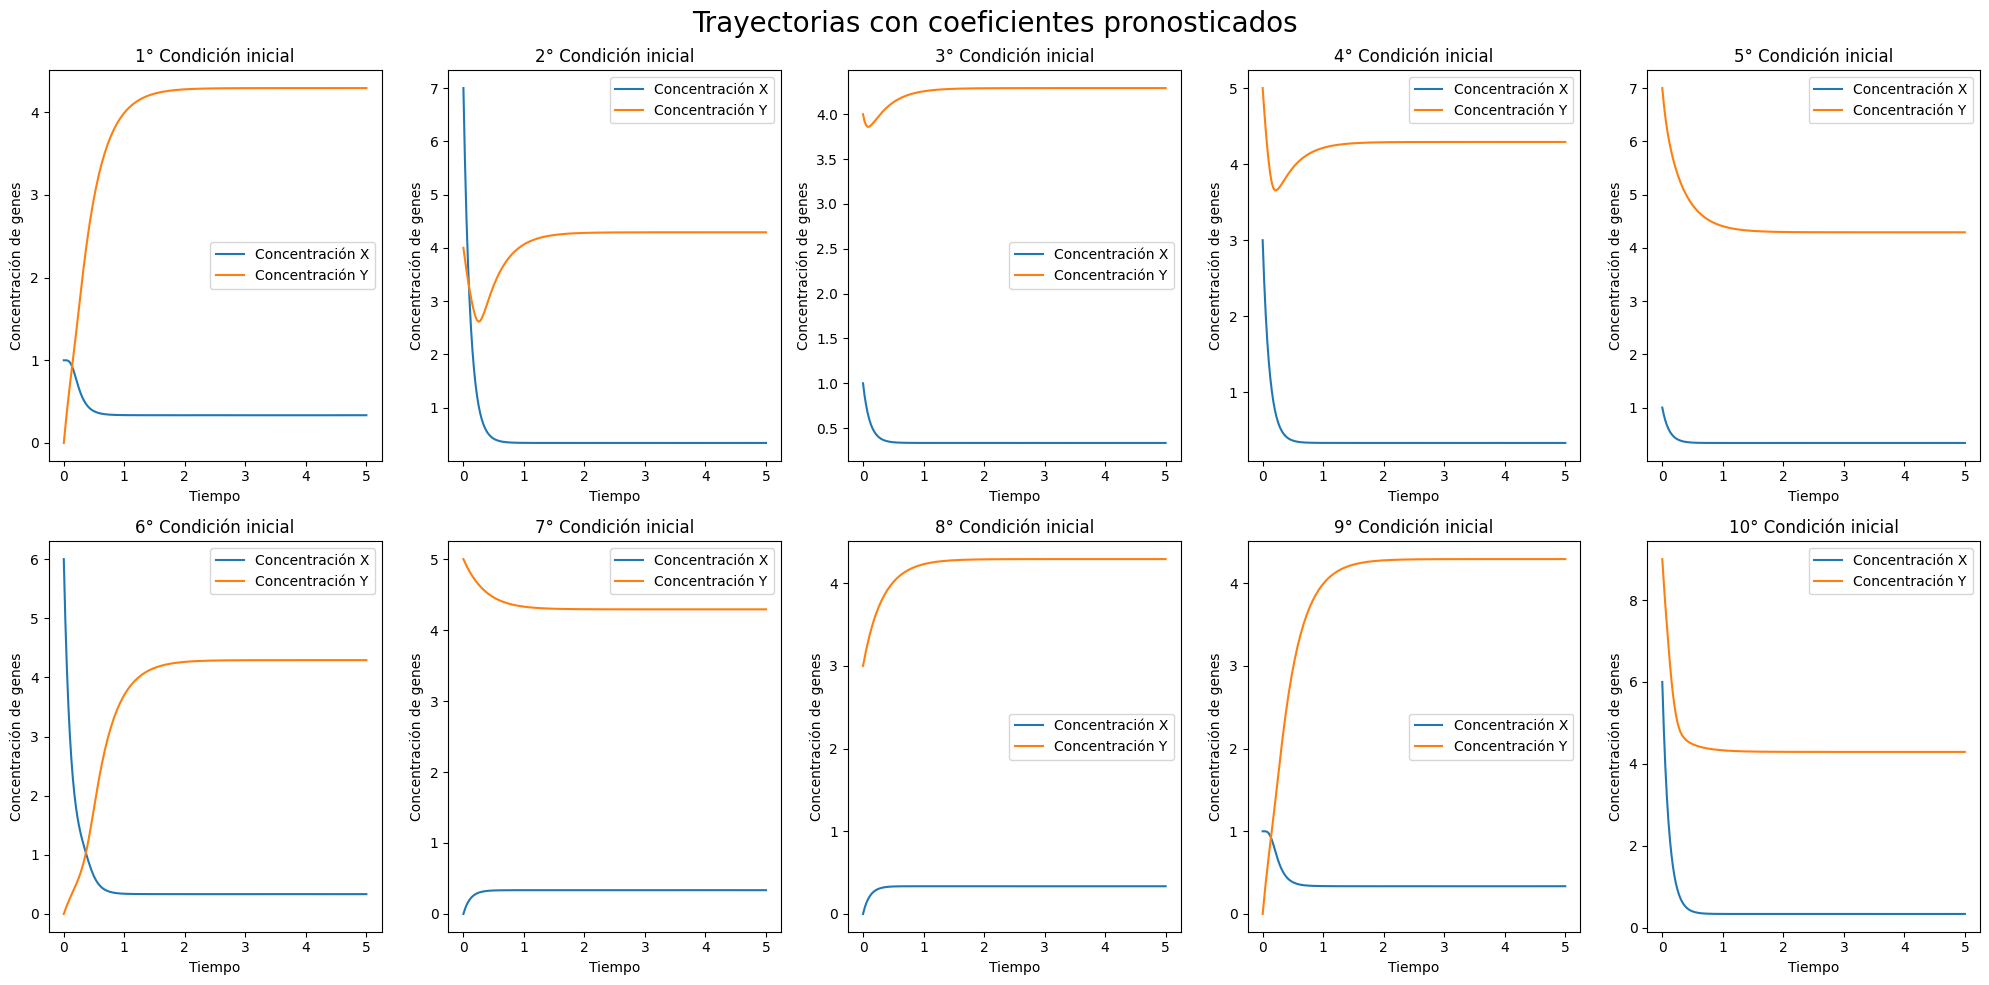

In [58]:
a1 = new_predictions[0,0]
a2 = new_predictions[0,1]
b1 = new_predictions[0,2]
b2 = new_predictions[0,3]
d1 = new_predictions[0,4]
d2 = new_predictions[0,5]
n = new_predictions[0,6]

varfpred = []

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1

    return [dX_dt, dY_dt]

# Declaramos el vector de tiempo
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 200)
varfci2pred = []

for i_ci in range(0, 10):
# Definimos las condiciones iniciales
    y0 = condini[i_ci]
    # Resolvemos
    sol = solve_ivp(f, t_span, y0, t_eval=times)
    tiempo = sol.t
    var1pred = sol.y[0]
    var2pred = sol.y[1]
    varfcipred = np.append([var1pred], [var2pred], axis=0)
    varfci2pred.append(varfcipred)
    
varfpred= varfci2pred

fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos
# Graficamos
for i in range(10):
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes pronosticados', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  
plt.show()

# Graficamos ambos

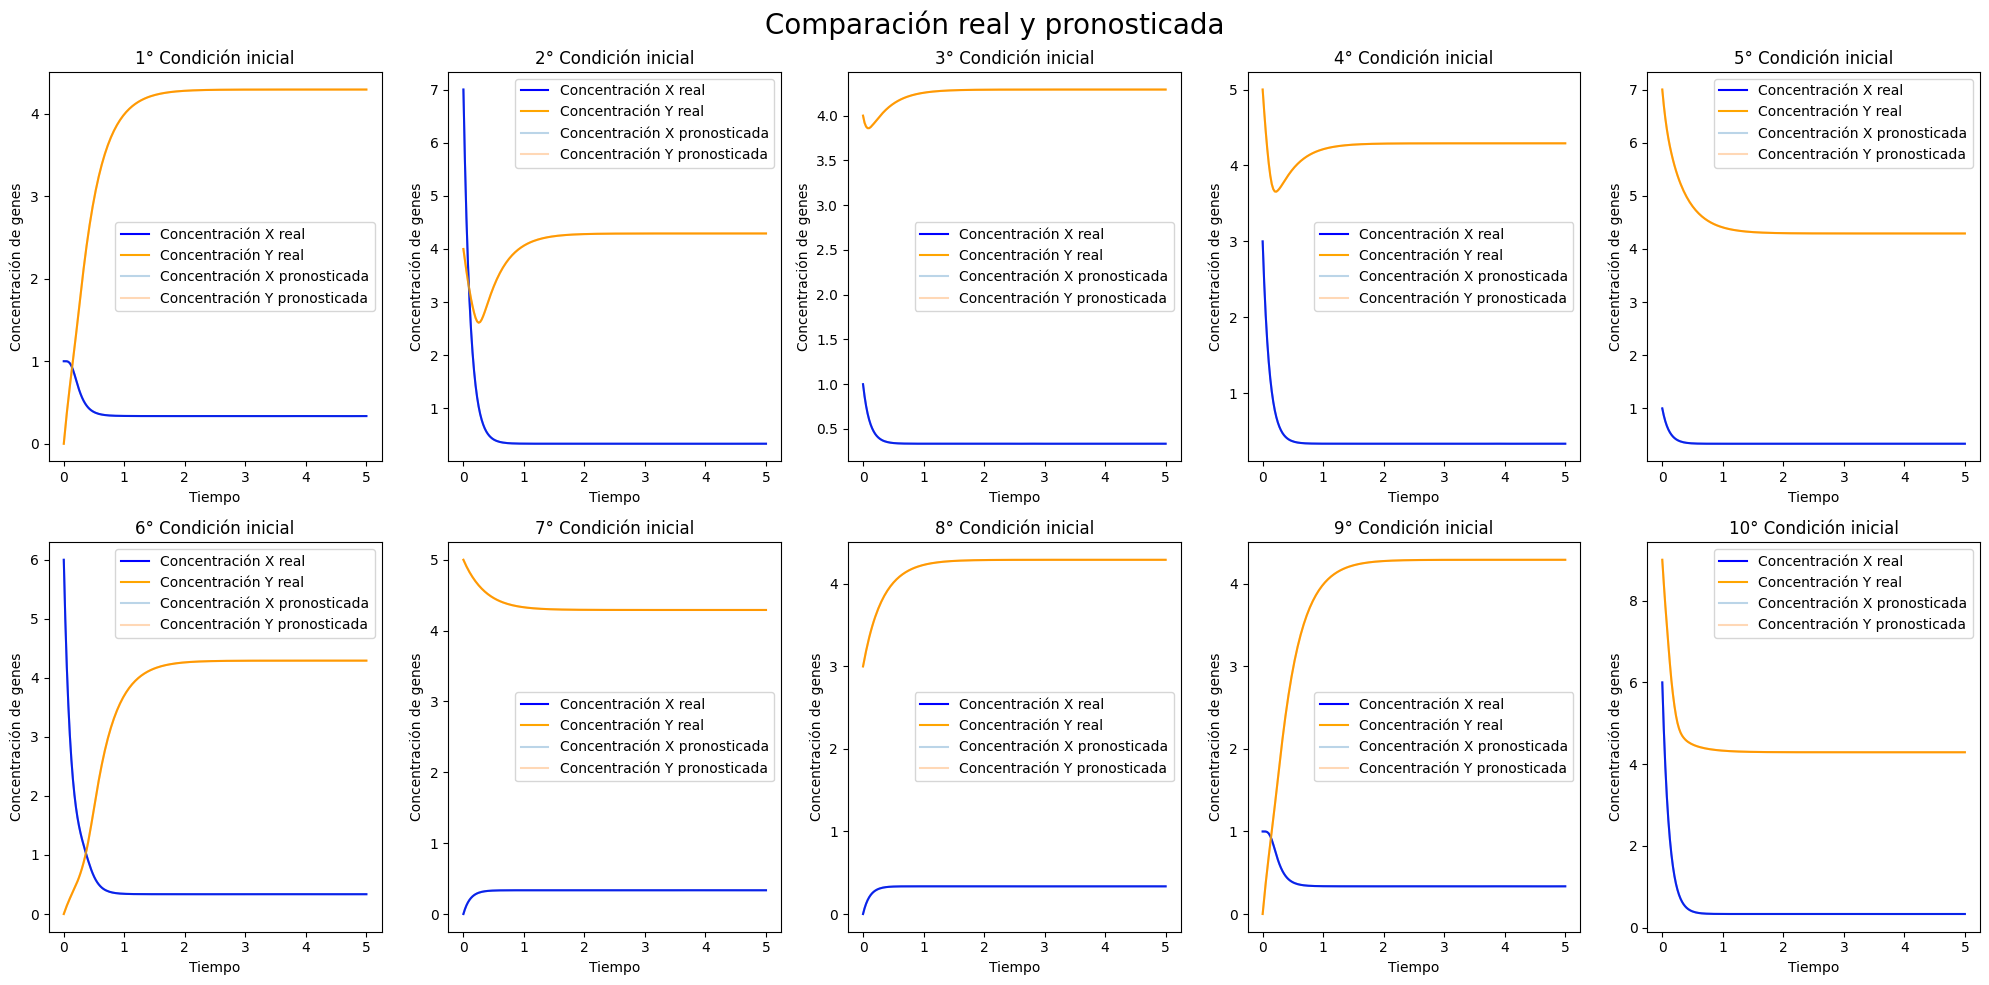

In [59]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 200)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    # varf
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X real", alpha=1, color = 'blue')
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y real", alpha=1, color = 'orange')

    # varfpred
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X pronosticada", alpha=0.3)
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y pronosticada", alpha=0.3)

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

## Graficamos las diferencias

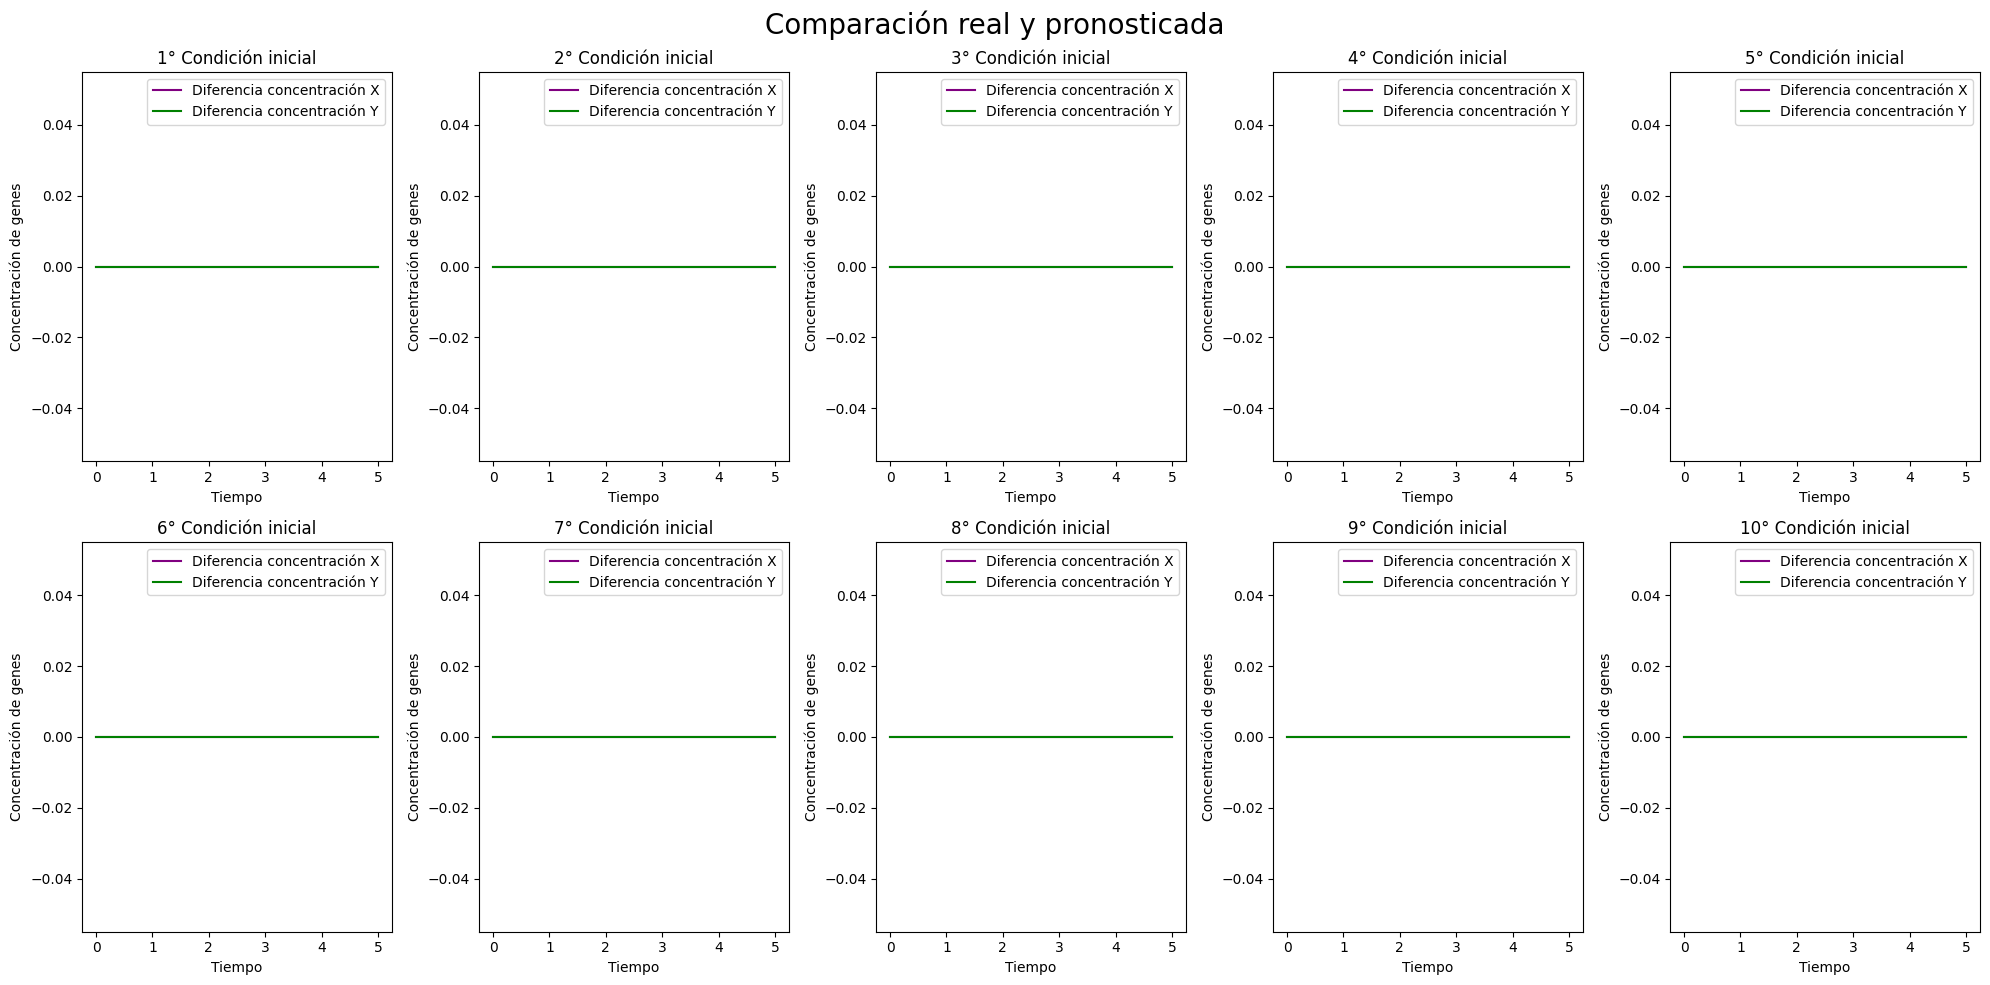

In [60]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 200)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

sum_errors_X = []
sum_errors_Y = []
for i in range(10):
    # Diferencia
    diff_X = np.array(varf)[i, 0, :] - np.array(varfpred)[i, 0, :]
    diff_Y = np.array(varf)[i, 1, :] - np.array(varfpred)[i, 1, :]
    axes[i].plot(times, diff_X, label=f"Diferencia concentración X", alpha=1, color = "purple")
    axes[i].plot(times, diff_Y, label=f"Diferencia concentración Y", alpha=1, color = "g")
    # Suma de los errores
    sum_errors_X.append(np.sum(np.abs(diff_X)))
    sum_errors_Y.append(np.sum(np.abs(diff_Y)))

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

In [61]:
print(np.sum(sum_errors_X)/2000)
print(np.sum(sum_errors_Y)/2000)

0.0
0.0


## Diferencias Relativas

C:\Users\rafae\AppData\Local\Temp\ipykernel_22276\2855101149.py:18: RuntimeWarning: invalid value encountered in divide
  relative_diff_Y = np.where(real_Y != 0, (pred_Y - real_Y) / real_Y, 0)
C:\Users\rafae\AppData\Local\Temp\ipykernel_22276\2855101149.py:17: RuntimeWarning: invalid value encountered in divide
  relative_diff_X = np.where(real_X != 0, (pred_X - real_X) / real_X, 0)


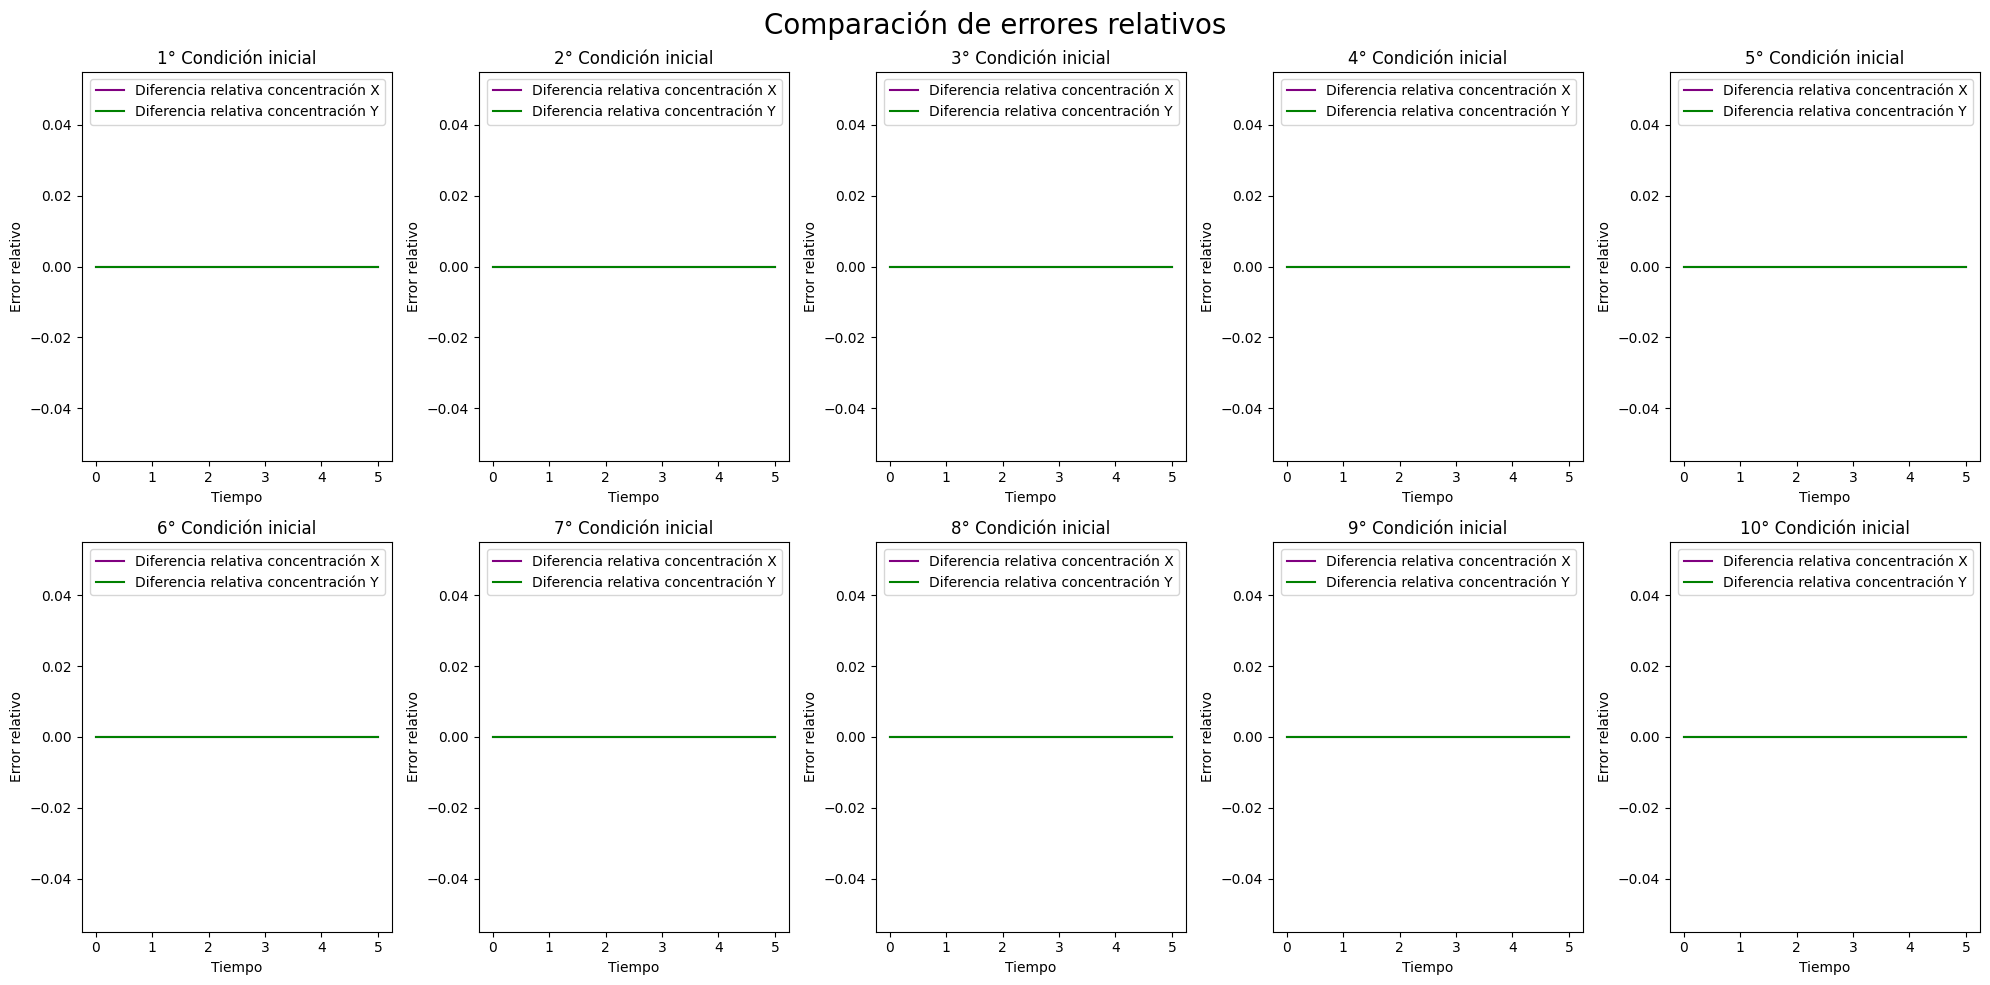

Suma mayor error relativo 0.0
Número de condición inicial 1


In [62]:
# Vamos a crear una lista para almacenar las sumas de los errores relativos para X y Y
sum_relative_errors_X = []
sum_relative_errors_Y = []

fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    # Diferencia relativa
    # Asegurándonos de evitar divisiones por cero
    real_X = np.array(varf)[i, 0, :]
    real_Y = np.array(varf)[i, 1, :]
    
    pred_X = np.array(varfpred)[i, 0, :]
    pred_Y = np.array(varfpred)[i, 1, :]
    
    relative_diff_X = np.where(real_X != 0, (pred_X - real_X) / real_X, 0)
    relative_diff_Y = np.where(real_Y != 0, (pred_Y - real_Y) / real_Y, 0)
    
    axes[i].plot(times, relative_diff_X, label=f"Diferencia relativa concentración X", alpha=1, color="purple")
    axes[i].plot(times, relative_diff_Y, label=f"Diferencia relativa concentración Y", alpha=1, color="g")
    
    # Suma de los errores relativos
    sum_relative_errors_X.append(np.sum(np.abs(relative_diff_X)))
    sum_relative_errors_Y.append(np.sum(np.abs(relative_diff_Y)))

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Error relativo')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación de errores relativos', fontsize=20)

plt.tight_layout()
plt.show()

# Podrías encontrar el máximo error relativo de la misma forma que el error absoluto
sum_total_relative_errors = [ex + ey for ex, ey in zip(sum_relative_errors_X, sum_relative_errors_Y)]
max_relative_error = max(sum_total_relative_errors)
index_max_relative_error = sum_total_relative_errors.index(max_relative_error) + 1  # Sumamos 1 porque las condiciones iniciales empiezan desde 1 en tu gráfico

print('Suma mayor error relativo', max_relative_error)
print('Número de condición inicial',index_max_relative_error)

## Error relativo global

In [63]:
# Vamos a crear listas para almacenar el máximo error relativo y el tiempo en que ocurre para cada condición inicial
max_relative_errors_X = []
max_relative_errors_Y = []
times_max_error_X = []
times_max_error_Y = []

for i in range(10):
    # Calcular la diferencia relativa como antes
    real_X = np.array(varf)[i, 0, :]
    real_Y = np.array(varf)[i, 1, :]
    
    pred_X = np.array(varfpred)[i, 0, :]
    pred_Y = np.array(varfpred)[i, 1, :]
    
    relative_diff_X = np.where(real_X != 0, np.abs((pred_X - real_X) / real_X), 0)
    relative_diff_Y = np.where(real_Y != 0, np.abs((pred_Y - real_Y) / real_Y), 0)
    
    # Encontrar el valor máximo y el tiempo en el que ocurre
    max_error_X = np.max(np.abs(relative_diff_X))
    max_error_Y = np.max(np.abs(relative_diff_Y))
    time_max_error_X = times[np.argmax(relative_diff_X)]
    time_max_error_Y = times[np.argmax(relative_diff_Y)]
    
    max_relative_errors_X.append(max_error_X)
    max_relative_errors_Y.append(max_error_Y)
    times_max_error_X.append(time_max_error_X)
    times_max_error_Y.append(time_max_error_Y)

# Ahora puedes encontrar el error relativo máximo global y la condición inicial y tiempo en el que ocurre
global_max_error_X = max(max_relative_errors_X)
global_max_error_Y = max(max_relative_errors_Y)

index_global_max_error_X = max_relative_errors_X.index(global_max_error_X) + 1  # Sumamos 1 porque las condiciones iniciales empiezan desde 1 en tu gráfico
index_global_max_error_Y = max_relative_errors_Y.index(global_max_error_Y) + 1

time_global_max_error_X = times_max_error_X[index_global_max_error_X - 1]  # Restamos 1 para ajustar el índice a la lista de Python
time_global_max_error_Y = times_max_error_Y[index_global_max_error_Y - 1]

print(f"El error relativo máximo para X es {global_max_error_X*100:.2f}%")
print("Ocurre en la condición inicial número:", index_global_max_error_X)
print("Ocurre en el tiempo:", time_global_max_error_X)

print(f"El error relativo máximo para Y es {global_max_error_Y*100:.2f}%")
print("Ocurre en la condición inicial número:", index_global_max_error_Y)
print("Ocurre en el tiempo:", time_global_max_error_Y)

El error relativo máximo para X es 0.00%
Ocurre en la condición inicial número: 1
Ocurre en el tiempo: 0.0
El error relativo máximo para Y es 0.00%
Ocurre en la condición inicial número: 1
Ocurre en el tiempo: 0.0


C:\Users\rafae\AppData\Local\Temp\ipykernel_22276\2700797786.py:16: RuntimeWarning: invalid value encountered in divide
  relative_diff_Y = np.where(real_Y != 0, np.abs((pred_Y - real_Y) / real_Y), 0)
C:\Users\rafae\AppData\Local\Temp\ipykernel_22276\2700797786.py:15: RuntimeWarning: invalid value encountered in divide
  relative_diff_X = np.where(real_X != 0, np.abs((pred_X - real_X) / real_X), 0)


In [64]:

# Vamos a crear una lista para almacenar el máximo error relativo combinado (X + Y) y los tiempos en los que ocurre para cada condición inicial
max_combined_relative_errors = []
times_max_combined_error = []

for i in range(10):
    # Calcular la diferencia relativa como antes
    real_X = np.array(varf)[i, 0, :]
    real_Y = np.array(varf)[i, 1, :]
    
    pred_X = np.array(varfpred)[i, 0, :]
    pred_Y = np.array(varfpred)[i, 1, :]
    
    relative_diff_X = np.where(real_X != 0, np.abs((pred_X - real_X) / real_X), 0)
    relative_diff_Y = np.where(real_Y != 0, np.abs((pred_Y - real_Y) / real_Y), 0)
    
    # Calculamos la suma de los errores relativos en X y Y para cada punto en el tiempo
    combined_relative_error = relative_diff_X + relative_diff_Y
    
    # Encontramos el valor máximo y el tiempo en el que ocurre
    max_combined_error = np.max(combined_relative_error)
    time_max_combined_error = times[np.argmax(combined_relative_error)]
    
    max_combined_relative_errors.append(max_combined_error)
    times_max_combined_error.append(time_max_combined_error)

# Ahora puedes encontrar el error relativo combinado máximo global y la condición inicial y tiempo en que ocurre
global_max_combined_error = max(max_combined_relative_errors)
index_global_max_combined_error = max_combined_relative_errors.index(global_max_combined_error) + 1  # Sumamos 1 porque las condiciones iniciales empiezan desde 1 en tu gráfico
time_global_max_combined_error = times_max_combined_error[index_global_max_combined_error - 1]  # Restamos 1 para ajustar el índice a la lista de Python

print(f"El error relativo combinado máximo (X + Y) es {global_max_combined_error*100:.2f}%")
print("Ocurre en la condición inicial número:", index_global_max_combined_error)
print("Ocurre en el tiempo:", time_global_max_combined_error)

El error relativo combinado máximo (X + Y) es 0.00%
Ocurre en la condición inicial número: 1
Ocurre en el tiempo: 0.0


C:\Users\rafae\AppData\Local\Temp\ipykernel_22276\2532752332.py:14: RuntimeWarning: invalid value encountered in divide
  relative_diff_Y = np.where(real_Y != 0, np.abs((pred_Y - real_Y) / real_Y), 0)
C:\Users\rafae\AppData\Local\Temp\ipykernel_22276\2532752332.py:13: RuntimeWarning: invalid value encountered in divide
  relative_diff_X = np.where(real_X != 0, np.abs((pred_X - real_X) / real_X), 0)


## Hacemos esto 10 veces

In [16]:
# Importando las librerías necesarias
import numpy as np
import random
from scipy.integrate import solve_ivp


# Inicializar la lista para almacenar los errores medios globales para cada número de puntos temporales
errores_medios_X_por_tiempos = []
errores_medios_Y_por_tiempos = []

# Inicializar las variables para almacenar los errores relativos máximos globales y los coeficientes correspondientes

for num_tiempos in range(50, 201, 10):
    

# Realizamos 10 iteraciones
    
    todas_diferencias_relativas_X = []
    todas_diferencias_relativas_Y = []

    for iteration in range(1000):
        
        condini = []
        varf = []
        coef = []
        # constantes
        a1 = random.randint(1, 10)
        a2 = random.randint(1, 10)
        b1 = random.randint(0, 10)
        b2 = random.randint(0, 10)
        d1 = random.randint(0, 10)
        d2 = random.randint(0, 10)
        n = random.randint(1, 5)

        coef1 = [a1, a2, b1, b2, d1, d2, n]
        coef.append(coef1)

        def f(t, y):

            # asignar a cada ODE a un elemento de vector
            X = y[0]
            Y = y[1]

            # definimos cada ODE
            dX_dt = a1/(1+Y**n)-d1*X+b1
            dY_dt = a2/(1+X**n)-d2*Y+b2

            return [dX_dt, dY_dt]

        # Declaramos el vector de tiempo
        t_span = [0, 5]
        times = np.linspace(t_span[0], t_span[1], num_tiempos)
    
        varfci2 = []
        for i_ci in range(0, 10):
            # Definimos las condiciones iniciales
            y0 = np.array([random.randint(0, 10), random.randint(0, 10)])
            condini.append(y0)
            # Resolvemos
            # Modificar manualmente el intervalo de tiempo
            sol = solve_ivp(f, t_span, y0, t_eval=times)
            # sol=solve_ivp(f, t_span, y0) #Dejar que la librería elija el mejor intervalo
            tiempo = sol.t
            var1 = sol.y[0]
            var2 = sol.y[1]

            varfci = np.append([var1], [var2], axis=0)
            varfci2.append(varfci)    

        varf= varfci2
        varf = np.array(varf)
        print(coef)
    
        varfnone = varf[None, :]
        varfnone = np.transpose(varfnone, (0,3,1,2))  
        new_predictions = new_model.predict(varfnone)
        new_predictions = np.round(new_predictions)
        print(new_predictions)  

        a1pred = new_predictions[0,0]
        a2pred = new_predictions[0,1]
        b1pred = new_predictions[0,2]
        b2pred = new_predictions[0,3]
        d1pred = new_predictions[0,4]
        d2pred = new_predictions[0,5]
        npred = new_predictions[0,6]
    
        # Verificar si a1pred, a2pred, o npred son iguales a cero
        if a1pred == 0 or a2pred == 0 or npred == 0:
            print("Uno de los coeficientes críticos es cero, saltando esta iteración.")
            continue  # Salta al inicio del bucle for para la próxima iteración

        varfpred = []

        def f_pred(t, y):
            X = y[0]
            Y = y[1]
            dX_dt = a1pred / (1 + Y ** npred) - d1pred * X + b1pred
            dY_dt = a2pred / (1 + X ** npred) - d2pred * Y + b2pred
            return [dX_dt, dY_dt]

        varfci2pred = []
        for i_ci in range(10):
            y0 = condini[i_ci]
            sol = solve_ivp(f_pred, t_span, y0, t_eval=times)
            var1pred = sol.y[0]
            var2pred = sol.y[1]
            varfcipred = np.append([var1pred], [var2pred], axis=0)
            varfci2pred.append(varfcipred)
        varfpred = varfci2pred
    
       # Calcular las diferencias relativas para cada conjunto de condiciones iniciales
        for i in range(10):  # Asumiendo que hay 10 condiciones iniciales
            real_X = np.array(varf)[i, 0, :]
            real_Y = np.array(varf)[i, 1, :]
            pred_X = np.array(varfpred)[i, 0, :]
            pred_Y = np.array(varfpred)[i, 1, :]
        
            # Calcular las diferencias relativas donde los valores reales no son cero
            diferencia_relativa_X = np.where(real_X != 0, np.abs((pred_X - real_X) / real_X), 0)
            diferencia_relativa_Y = np.where(real_Y != 0, np.abs((pred_Y - real_Y) / real_Y), 0)
        
            # Excluir los valores mayores a 500
            diferencia_relativa_X = np.extract(diferencia_relativa_X <= 5, diferencia_relativa_X)
            diferencia_relativa_Y = np.extract(diferencia_relativa_Y <= 5, diferencia_relativa_Y)
        
            # Agregar estas diferencias a la lista total
            todas_diferencias_relativas_X.extend(diferencia_relativa_X)
            todas_diferencias_relativas_Y.extend(diferencia_relativa_Y)
            
    print('--------------------------------------------------------------------------------------------------------')
    print('Final del tamaño', num_tiempos)
    # Aquí puedes calcular la métrica de error medio para este número específico de puntos temporales y almacenarla
    error_medio_X = np.mean(todas_diferencias_relativas_X)
    error_medio_Y = np.mean(todas_diferencias_relativas_Y)
    print(np.mean(error_medio_X))
    print(np.mean(error_medio_Y))
    error_medio_general = np.mean(error_medio_X)
    
    errores_medios_X_por_tiempos.append(error_medio_X)
    errores_medios_Y_por_tiempos.append(error_medio_Y)

[[6, 1, 7, 7, 8, 6, 1]]
1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 5, 6, 3, 7, 10, 2]]
1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 5, 4, 7, 9, 10, 3]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  2. 10. 10.  3.]]
[[4, 1, 7, 2, 1, 7, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 8. 10.  9.  8.  1. 10.  1.]]
[[3, 7, 0, 7, 0, 3, 2]]
1/1 [==============================] - 0s 12ms/step
[[ 0. 10.  9.  7.  0. 10.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 7, 5, 8, 7, 7, 2]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 9, 10, 4, 10, 3, 1]]
1/1 [==============================] - ETA: 0s

C:\Users\rafae\AppData\Local\Temp\ipykernel_18808\240765736.py:120: RuntimeWarning: invalid value encountered in true_divide
  diferencia_relativa_X = np.where(real_X != 0, np.abs((pred_X - real_X) / real_X), 0)
C:\Users\rafae\AppData\Local\Temp\ipykernel_18808\240765736.py:121: RuntimeWarning: invalid value encountered in true_divide
  diferencia_relativa_Y = np.where(real_Y != 0, np.abs((pred_Y - real_Y) / real_Y), 0)


1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 3, 6, 4, 2, 10, 4]]
1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  3. 10. 10.  1.]]
[[3, 3, 7, 7, 7, 9, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 10, 1, 7, 4, 9, 3]]
1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 3, 1, 5, 1, 6, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 2. 10.  4.  0.  3. 10.  3.]]
[[5, 8, 0, 6, 7, 9, 1]]
1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 6, 1, 5, 2, 4, 4]]
1/1 [==============================] - 0s 10ms/step
[[10. 10.  2.  0.  6. 10.  9.]

1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 7, 3, 10, 9, 5, 2]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 1, 10, 3, 6, 2, 3]]
1/1 [==============================] - 0s 10ms/step
[[10.  9. 10.  1. 10.  9.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 6, 5, 5, 3, 2, 3]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[9, 8, 2, 8, 6, 9, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 8, 10, 2, 2, 6, 2]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  5.  5. 10.  0.]]
Uno de los coeficientes críticos es ce

1/1 [==============================] - 0s 11ms/step
[[10.  6. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 4, 0, 1, 8, 9, 2]]
1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  1. 10. 10.  3.]]
[[5, 2, 0, 4, 3, 4, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 1, 3, 4, 8, 9, 4]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  3. 10. 10.  1.]]
[[3, 3, 2, 5, 8, 0, 4]]
1/1 [==============================] - 0s 11ms/step
[[10.  0. 10.  2. 10.  0.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 4, 1, 9, 0, 9, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  9.  8.  0. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 6, 10, 8, 0, 3, 4]]
1/1 [==============================] - 0s 12ms/step
[[ 0. 10. 10.  4.  0. 10.  0.]]

[[3, 3, 7, 8, 10, 8, 2]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 7, 8, 6, 0, 8, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 2. 10. 10.  9.  0. 10.  1.]]
[[3, 7, 0, 2, 5, 8, 2]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 5, 2, 9, 10, 6, 3]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 9, 6, 8, 1, 0, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 5.  1. 10.  6.  3.  0.  2.]]
[[9, 4, 5, 10, 9, 1, 5]]
1/1 [==============================] - 0s 12ms/step
[[10.  3. 10.  1. 10.  5.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 10, 0, 2, 5, 5, 2]]
1/1 [==============================] - 0s 11ms/step
[[10

1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 2, 3, 1, 5, 9, 3]]
1/1 [==============================] - 0s 10ms/step
[[10. 10.  9.  3. 10. 10.  4.]]
[[2, 3, 3, 0, 8, 4, 1]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 9, 3, 6, 2, 4, 1]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0.  9. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 7, 1, 4, 1, 10, 5]]
1/1 [==============================] - 0s 10ms/step
[[ 2. 10.  8.  1.  3. 10.  1.]]
[[2, 2, 0, 10, 10, 8, 1]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 2, 9, 5, 1, 6, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 9. 10. 10.  8.  2. 10.  0.

[[10, 2, 10, 9, 7, 5, 2]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 8, 10, 4, 2, 1, 5]]
1/1 [==============================] - 0s 11ms/step
[[10.  0. 10.  3. 10.  2.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[9, 1, 7, 8, 10, 6, 5]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 3, 3, 4, 8, 2, 5]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 8, 5, 4, 2, 8, 2]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  0.  9. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 1, 9, 9, 5, 4, 1]]
1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los co

1/1 [==============================] - 0s 12ms/step
[[ 1. 10.  1.  9.  0. 10.  5.]]
[[7, 6, 4, 10, 4, 6, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 8, 6, 9, 1, 9, 3]]
1/1 [==============================] - 0s 11ms/step
[[10.  0. 10.  1.  5. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 8, 10, 3, 10, 3, 3]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 4, 3, 6, 0, 3, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 0. 10. 10.  5.  0. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 9, 2, 6, 4, 7, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  2.]]
[[5, 6, 1, 2, 2, 8, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  1.

1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 5, 10, 6, 7, 5, 2]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 1, 10, 0, 5, 5, 3]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  2. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 7, 10, 7, 2, 6, 3]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  3.  9. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 6, 9, 5, 4, 1, 1]]
1/1 [==============================] - 0s 10ms/step
[[10.  5. 10.  2. 10.  2.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 10, 6, 8, 8, 1, 1]]
1/1 [==============================] - 0s 12ms/step
[[10.  6. 10.  4. 10.  3.  0.]]
Uno de los coeficientes críticos es c

1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 3, 6, 8, 6, 8, 5]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 8, 10, 10, 3, 9, 4]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  2. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 5, 8, 10, 9, 9, 5]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 1, 1, 9, 10, 9, 3]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  1.]]
[[10, 7, 10, 2, 1, 1, 3]]
1/1 [==============================] - 0s 11ms/step
[[10.  9.  6.  2.  3.  7.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 9, 4, 3, 7, 10, 4]]
1/1 [====

1/1 [==============================] - 0s 13ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 7, 1, 3, 9, 9, 1]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  4. 10. 10.  7.]]
[[7, 10, 6, 0, 1, 2, 4]]
1/1 [==============================] - 0s 12ms/step
[[10. 10.  1.  7.  3. 10.  7.]]
[[6, 2, 7, 5, 3, 6, 2]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  3. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[9, 1, 7, 6, 3, 6, 4]]
1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 1, 9, 1, 0, 0, 2]]
1/1 [==============================] - 0s 12ms/step
[[10.  7.  8.  1.  1.  2.  4.]]
[[6, 4, 8, 7, 6, 5, 2]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración

1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 3, 0, 9, 5, 0, 4]]
1/1 [==============================] - 0s 11ms/step
[[10.  0. 10.  2. 10.  0.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 10, 9, 1, 9, 3, 2]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 10, 4, 8, 10, 5, 1]]
1/1 [==============================] - 0s 9ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 9, 8, 1, 6, 3, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 5, 0, 6, 6, 6, 5]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es ce

1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  2. 10. 10.  3.]]
[[9, 1, 7, 3, 9, 1, 2]]
1/1 [==============================] - 0s 11ms/step
[[10.  0. 10.  4. 10.  7.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 9, 7, 1, 10, 6, 1]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 3, 8, 5, 6, 9, 2]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  4. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[9, 2, 7, 0, 3, 5, 1]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  5.  6. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 8, 8, 0, 2, 3, 5]]
1/1 [==============================] - 0s 11ms/step
[[10.  9.  9.  3.  8. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 9, 1, 1, 9, 3, 1]]
1/1 [===========

1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  2. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[9, 8, 3, 2, 7, 5, 1]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 4, 5, 7, 9, 1, 4]]
1/1 [==============================] - 0s 11ms/step
[[10.  1. 10.  4. 10.  7.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 5, 7, 3, 2, 8, 3]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  5.  6. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 4, 2, 4, 3, 6, 2]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 8, 2, 9, 8, 2, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  2. 10. 10.  0.]]
Uno de los coeficientes críticos es cero,

1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  4. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 9, 6, 1, 4, 2, 4]]
1/1 [==============================] - 0s 10ms/step
[[10.  1. 10.  6. 10.  8.  3.]]
[[10, 2, 2, 4, 8, 8, 5]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 9, 0, 8, 4, 4, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 5, 7, 6, 5, 7, 5]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 6, 3, 10, 4, 0, 2]]
1/1 [==============================] - 0s 11ms/step
[[10.  9. 10.  2. 10.  0.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 7, 0, 6, 10, 4, 4]]
1/1 [========

1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[9, 4, 0, 0, 4, 8, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  2. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 8, 8, 5, 6, 8, 2]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  2. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 9, 10, 2, 10, 8, 4]]
1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 8, 3, 9, 3, 7, 3]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 10, 1, 7, 8, 3, 1]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es c

1/1 [==============================] - 0s 10ms/step
[[10. 10.  9.  2. 10. 10.  9.]]
[[2, 6, 4, 3, 6, 7, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  1.]]
[[1, 7, 6, 3, 4, 4, 5]]
1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 5, 7, 2, 4, 1, 3]]
1/1 [==============================] - 0s 11ms/step
[[10.  0. 10.  4. 10.  7.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 9, 3, 2, 5, 3, 5]]
1/1 [==============================] - 0s 11ms/step
[[10. 10.  0.  1. 10. 10.  9.]]
[[2, 4, 4, 1, 0, 1, 1]]
1/1 [==============================] - 0s 12ms/step
[[6. 8. 3. 6. 0. 3. 3.]]
[[3, 10, 0, 10, 4, 6, 3]]
1/1 [==============================] - 0s 10ms/step
[[10. 10.  9.  0. 10. 10.  1.]]
[[9, 3, 2, 10, 1, 6, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 0. 10. 10.  5.  2. 10.  0.]]
Uno de los coeficientes críti

1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1.  6. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 5, 6, 7, 2, 0, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 9.  0. 10.  4. 10.  0.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 7, 3, 3, 8, 1, 1]]
1/1 [==============================] - 0s 12ms/step
[[10.  9. 10.  4. 10.  8.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 2, 7, 4, 2, 10, 5]]
1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  7.  4. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 7, 0, 10, 2, 8, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  5.  0.  6. 10.  6.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 1, 2, 6, 4, 2, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 9. 10. 10.  1. 10.  7.  0.]]
Uno de los coeficientes críticos es ce

1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 10, 2, 4, 9, 4, 2]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 1, 1, 4, 6, 3, 2]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 6, 6, 2, 8, 1, 2]]
1/1 [==============================] - 0s 11ms/step
[[10.  0. 10.  3. 10.  4.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 5, 7, 3, 10, 1, 2]]
1/1 [==============================] - 0s 11ms/step
[[10.  0. 10.  2. 10.  2.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 9, 2, 2, 6, 5, 2]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es ce

1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 1, 4, 8, 4, 5, 1]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 10, 6, 8, 1, 10, 2]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  9.  1. 10.  1.]]
[[2, 4, 6, 0, 0, 5, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 1. 10.  2.  7.  0. 10.  2.]]
[[5, 6, 2, 10, 8, 5, 3]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 6, 2, 9, 9, 10, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 2, 9, 3, 10, 10, 1]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  4. 10. 10

1/1 [==============================] - 0s 11ms/step
[[8. 6. 6. 4. 0. 7. 1.]]
[[9, 2, 2, 0, 9, 6, 3]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 1, 4, 2, 1, 10, 5]]
1/1 [==============================] - 0s 9ms/step
[[ 3. 10.  8.  3.  1. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 9, 1, 9, 8, 5, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  2. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 7, 3, 2, 5, 6, 1]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 6, 8, 10, 10, 6, 2]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 7, 1, 9, 0, 3, 4]]
1/1 [================

1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 6, 10, 3, 4, 10, 2]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  2. 10. 10.  1.]]
[[1, 6, 9, 10, 8, 1, 5]]
1/1 [==============================] - 0s 11ms/step
[[10.  1. 10.  3. 10.  1.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 2, 1, 4, 4, 10, 1]]
1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 8, 6, 2, 4, 8, 3]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  2. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 4, 6, 4, 10, 7, 4]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 7, 6, 6, 0, 3, 5]]
1/1 [======

1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  1. 10. 10.  6.]]
[[3, 1, 1, 0, 0, 8, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 1.  9.  1.  8.  0. 10.  1.]]
[[6, 7, 2, 1, 5, 3, 5]]
1/1 [==============================] - 0s 11ms/step
[[10. 10.  9.  1. 10. 10.  7.]]
[[2, 5, 2, 3, 4, 2, 1]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10.  8.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 7, 7, 7, 3, 10, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 10, 6, 7, 1, 2, 2]]
1/1 [==============================] - 0s 11ms/step
[[4. 9. 9. 2. 3. 5. 0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 4, 5, 3, 4, 10, 1]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  3. 10. 10.  2.]]
[[3, 5, 7, 4, 4, 5, 2]]
1/1 [==============================] - 0s 10ms

1/1 [==============================] - 0s 10ms/step
[[10. 10.  2.  3. 10.  0.  3.]]
[[6, 3, 1, 7, 3, 2, 2]]
1/1 [==============================] - 0s 12ms/step
[[ 9. 10.  9.  1. 10.  6.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 7, 8, 0, 5, 7, 1]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 9, 7, 8, 8, 9, 2]]
1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  2. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 5, 8, 7, 1, 6, 1]]
1/1 [==============================] - 0s 9ms/step
[[ 4. 10. 10.  3.  2. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 7, 8, 1, 1, 10, 5]]
1/1 [==============================] - 0s 11ms/step
[[10. 10.  9.  7.  1. 10.  1.]]
[[6, 6, 7, 3, 1, 3, 5]]
1/1 [==============================] - 0s 10ms/step
[[ 2.  8.  8.  3.  1. 10.  0.]]


1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 5, 6, 8, 0, 5, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 0.  2.  9.  5.  0. 10.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 4, 0, 6, 3, 6, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 5. 10.  4.  1. 10. 10.  5.]]
[[10, 1, 3, 5, 1, 0, 2]]
1/1 [==============================] - 0s 12ms/step
[[8. 2. 6. 5. 3. 0. 2.]]
[[4, 8, 0, 6, 3, 1, 3]]
1/1 [==============================] - 0s 11ms/step
[[10. 10.  1.  4. 10.  4.  4.]]
[[9, 5, 1, 1, 6, 8, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  2. 10. 10.  1.]]
[[3, 4, 3, 9, 5, 7, 3]]
1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 10, 0, 5, 0, 6, 1]]
1/1 [==============================] - 0s 10ms/s

1/1 [==============================] - 0s 11ms/step
[[ 9.  8.  9.  4.  1. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 10, 7, 0, 7, 3, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  7. 10. 10.  7.]]
[[3, 10, 1, 0, 6, 9, 5]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 1, 10, 0, 10, 10, 1]]
1/1 [==============================] - 0s 10ms/step
[[10. 10.  9.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 7, 6, 7, 9, 7, 5]]
1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 3, 8, 9, 1, 5, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 8. 10. 10.  6.  2. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 8, 10, 4, 3, 0, 5]]
1/1 [======

1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 7, 8, 1, 3, 1, 3]]
1/1 [==============================] - 0s 10ms/step
[[10.  1.  2.  8.  9.  4.  4.]]
[[3, 1, 6, 9, 8, 7, 3]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[9, 10, 8, 1, 2, 8, 5]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  7.  2. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 4, 8, 2, 9, 10, 1]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[9, 5, 8, 4, 5, 1, 1]]
1/1 [==============================] - 0s 12ms/step
[[10.  0. 10.  3. 10.  2.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 3, 7, 9, 6, 2, 1]]
1/1 [========

1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 2, 10, 10, 10, 0, 5]]
1/1 [==============================] - 0s 12ms/step
[[ 9.  1. 10.  5. 10.  0.  2.]]
[[4, 2, 2, 3, 10, 6, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 9, 3, 7, 8, 6, 1]]
1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 8, 5, 4, 0, 1, 4]]
1/1 [==============================] - 0s 11ms/step
[[1. 8. 6. 4. 0. 4. 2.]]
[[10, 10, 7, 4, 6, 1, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  0. 10.  2. 10.  5.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 3, 2, 6, 4, 0, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 7.  0. 10.  3. 10.  0.  2.]]
U

1/1 [==============================] - 0s 10ms/step
[[10. 10.  7.  1.  6. 10.  9.]]
[[3, 3, 10, 10, 8, 3, 1]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 6, 0, 6, 1, 3, 1]]
1/1 [==============================] - 0s 12ms/step
[[ 0. 10.  2.  4.  3.  8.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 9, 5, 10, 6, 7, 1]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 4, 2, 1, 6, 6, 2]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 8, 5, 4, 7, 6, 5]]
1/1 [==============================] - 0s 12ms/step
[[10. 10.  8.  1. 10. 10. 10.]]
[[3, 3, 3, 2, 6, 10, 5]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  

[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 6, 0, 3, 2, 1, 3]]
1/1 [==============================] - 0s 12ms/step
[[10. 10.  0.  3.  8.  5.  5.]]
[[1, 7, 6, 6, 10, 7, 5]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 8, 3, 4, 5, 8, 1]]
1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  1. 10. 10.  2.]]
[[5, 7, 8, 9, 8, 10, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 10, 4, 1, 1, 3, 4]]
1/1 [==============================] - 0s 11ms/step
[[10.  6.  8.  3.  4. 10.  3.]]
[[6, 6, 0, 2, 9, 1, 2]]
1/1 [==============================] - 0s 11ms/step
[[10. 10.  4.  4. 10.  7.  5.]]
[[7, 5, 7, 0, 1, 2, 4]]
1/1 [==============================] - 0s 12ms/step
[[9. 6. 1. 6. 1. 7. 3.]]
[[8, 10, 5, 9, 

1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  2. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 8, 3, 1, 5, 8, 5]]
1/1 [==============================] - 0s 10ms/step
[[10.  9.  9.  2. 10. 10.  2.]]
[[3, 7, 9, 0, 9, 10, 2]]
1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  1. 10. 10.  1.]]
[[3, 9, 3, 9, 4, 4, 2]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 2, 4, 5, 1, 3, 3]]
1/1 [==============================] - 0s 12ms/step
[[ 4.  9. 10.  4.  4.  9.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 2, 1, 10, 1, 7, 5]]
1/1 [==============================] - 0s 12ms/step
[[ 0. 10.  6.  3.  1. 10.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 3, 9, 2, 6, 0, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  0. 10.  8. 10.  0.  1.

[[9, 4, 10, 8, 7, 0, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 9.  1. 10.  5. 10.  0.  2.]]
[[4, 9, 6, 1, 5, 9, 1]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 6, 8, 3, 8, 9, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 5, 7, 3, 10, 10, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 5, 3, 10, 0, 5, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 0. 10. 10.  6.  0. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 8, 2, 1, 3, 5, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10.  2.  1.  7. 10.  7.]]
[[3, 10, 4, 10, 0, 8, 1]]
1/1 [==============================] - 0s 11ms/step
[[

1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  2. 10. 10.  1.]]
[[9, 7, 2, 1, 5, 2, 1]]
1/1 [==============================] - 0s 12ms/step
[[10.  3. 10.  2. 10.  6.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 7, 9, 6, 1, 9, 5]]
1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  8.  1. 10.  1.]]
[[5, 5, 3, 8, 6, 6, 2]]
1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 3, 8, 10, 7, 3, 3]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 5, 2, 2, 9, 6, 2]]
1/1 [==============================] - 0s 13ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 8, 3, 10, 1, 5, 3]]
1/1 [==============================] - 0s 12ms/step
[[ 0. 10.  9.  5.  2. 10.  0.]

1/1 [==============================] - 0s 10ms/step
[[ 4. 10. 10.  7.  1. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 2, 2, 8, 1, 5, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 0. 10.  9.  2.  2. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 3, 2, 8, 6, 1, 5]]
1/1 [==============================] - 0s 11ms/step
[[10.  9.  9.  4. 10.  4.  1.]]
[[8, 10, 2, 8, 7, 6, 5]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 5, 0, 10, 2, 2, 4]]
1/1 [==============================] - 0s 12ms/step
[[ 9. 10.  0.  1.  8.  5.  5.]]
[[9, 2, 9, 5, 9, 8, 5]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  2. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 10, 0, 5, 9, 3, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  2. 10. 10.  0.

1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 10, 6, 0, 4, 7, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 4, 2, 0, 6, 0, 3]]
1/1 [==============================] - 0s 11ms/step
[[10.  0.  1.  1.  9.  0.  3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 2, 10, 1, 9, 5, 5]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 4, 2, 10, 4, 5, 1]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 2, 4, 3, 0, 4, 5]]
1/1 [==============================] - 0s 12ms/step
[[ 1.  3.  7.  7.  0. 10.  1.]]
[[5, 7, 2, 9, 9, 5, 5]]
1/1 [========

1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 6, 10, 0, 10, 5, 1]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 3, 6, 7, 5, 1, 4]]
1/1 [==============================] - 0s 11ms/step
[[10.  0. 10.  3. 10.  2.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 5, 5, 1, 8, 4, 2]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 8, 0, 9, 4, 8, 5]]
1/1 [==============================] - 0s 10ms/step
[[ 5. 10.  5.  1. 10. 10.  3.]]
[[5, 7, 6, 7, 9, 1, 1]]
1/1 [==============================] - 0s 10ms/step
[[10.  1. 10.  2. 10.  1.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 6, 8, 0, 3, 10, 1]]
1/1 [=========

1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  3. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 10, 10, 2, 4, 5, 3]]
1/1 [==============================] - 0s 11ms/step
[[10.  9. 10.  2. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 3, 5, 2, 0, 5, 5]]
1/1 [==============================] - 0s 12ms/step
[[ 5.  4.  8.  6.  0. 10.  1.]]
[[4, 8, 8, 6, 9, 8, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 5, 5, 10, 10, 6, 1]]
1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 1, 1, 6, 0, 5, 4]]
1/1 [==============================] - 0s 12ms/step
[[ 0. 10.  7.  8.  0. 10.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 4, 8, 2, 8, 2, 5]]
1/1 [=======

1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  4.  8. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 5, 9, 8, 5, 3, 4]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  1. 10.  9.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 5, 10, 10, 0, 0, 2]]
1/1 [==============================] - 0s 11ms/step
[[5. 8. 9. 3. 0. 0. 1.]]
[[6, 4, 7, 6, 10, 9, 2]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  2. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 1, 2, 8, 7, 6, 2]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 8, 4, 2, 5, 2, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  1. 10.  2. 10.  7.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 4, 10, 3, 10, 7, 1]]
1/1 [==============

1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  8. 10. 10.  1.]]
[[7, 6, 2, 6, 4, 9, 1]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  2. 10. 10.  1.]]
[[9, 4, 4, 4, 6, 4, 3]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  1. 10. 10.  1.]]
[[10, 1, 2, 4, 3, 10, 5]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  3.  9. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[9, 5, 1, 0, 0, 6, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 2. 10.  3.  7.  0. 10.  3.]]
[[6, 10, 0, 9, 8, 7, 1]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 7, 10, 0, 5, 9, 5]]
1/1 [==============================] - 0s 12ms/step
[[10. 10.  8.  1. 10. 10.  1.]]
[[8, 5, 7, 10, 0, 2, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 0. 10.  9.  7.  0.  6.  1.]]
Uno de los coeficient

1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 4, 3, 5, 7, 7, 2]]
1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 7, 10, 6, 1, 1, 1]]
1/1 [==============================] - 0s 10ms/step
[[10.  2. 10.  5.  4.  3.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 4, 5, 3, 8, 7, 3]]
1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 10, 6, 5, 3, 8, 1]]
1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  2. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 10, 9, 6, 4, 1, 3]]
1/1 [==============================] - 0s 10ms/step
[[10.  0. 10.  3. 10.  2.  0.]]
Uno de los coeficientes críticos es ce

1/1 [==============================] - 0s 12ms/step
[[ 0. 10.  8.  4.  1. 10.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 9, 3, 4, 10, 7, 5]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 3, 6, 4, 1, 3, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 3.  8. 10.  4.  2. 10.  1.]]
[[5, 7, 6, 1, 5, 0, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 7.  0.  7.  7. 10.  0.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 6, 2, 4, 2, 2, 5]]
1/1 [==============================] - 0s 11ms/step
[[10.  0.  2.  5.  8.  3.  4.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[9, 3, 7, 1, 10, 2, 3]]
1/1 [==============================] - 0s 11ms/step
[[10.  0.  9.  8. 10.  7.  4.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 4, 8, 4, 3, 10, 3]]
1/1 [=========

1/1 [==============================] - 0s 11ms/step
[[ 2. 10.  9.  4. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 4, 10, 3, 10, 0, 5]]
1/1 [==============================] - 0s 11ms/step
[[10.  1. 10.  4. 10.  0.  2.]]
[[8, 10, 9, 5, 4, 4, 5]]
1/1 [==============================] - 0s 10ms/step
[[10.  3. 10.  2.  9. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 5, 0, 10, 7, 4, 3]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 1, 3, 1, 6, 1, 5]]
1/1 [==============================] - 0s 13ms/step
[[10.  0.  3.  3. 10.  3.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 7, 10, 5, 9, 5, 5]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  2. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 9, 10, 5, 8, 9, 2]]
1/1 [======

[[9, 1, 10, 9, 3, 10, 1]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  6.  8. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 9, 8, 5, 3, 6, 3]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[9, 10, 9, 0, 8, 2, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  0. 10.  5. 10.  7.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 3, 10, 4, 2, 4, 2]]
1/1 [==============================] - 0s 10ms/step
[[10.  3. 10.  2.  6. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 10, 10, 9, 9, 8, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 3, 4, 0, 6, 5, 2]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los 

1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  2. 10. 10.  1.]]
[[3, 6, 7, 3, 9, 1, 5]]
1/1 [==============================] - 0s 11ms/step
[[10.  0. 10.  4. 10.  5.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 2, 5, 8, 1, 10, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 3. 10. 10.  6.  1. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 5, 5, 2, 10, 8, 3]]
1/1 [==============================] - 0s 11ms/step
[[10.  9. 10.  2. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 3, 2, 6, 3, 5, 3]]
1/1 [==============================] - 0s 10ms/step
[[10. 10.  9.  1. 10. 10.  3.]]
[[9, 6, 2, 7, 3, 10, 3]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  1. 10. 10.  1.]]
[[3, 4, 1, 8, 6, 1, 3]]
1/1 [==============================] - 0s 11ms/step
[[10. 10.  6.  5. 10.  7.  4.]]
[[4, 8, 6, 7, 8, 9, 3]]
1/1 [==============================] - 0

[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 3, 9, 8, 10, 8, 1]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 1, 3, 3, 6, 1, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  0.  9.  4. 10.  2.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 5, 9, 6, 10, 7, 1]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  2. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 1, 7, 9, 3, 8, 4]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  2.  9. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 4, 5, 0, 6, 9, 2]]
1/1 [==============================] - 0s 10ms/step
[[10. 10.  4.  1. 10. 10.  3.]]
[[5, 1, 10, 9, 0, 9, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 2.  9. 10.

1/1 [==============================] - 0s 11ms/step
[[ 8. 10.  9.  1. 10. 10.  1.]]
[[3, 5, 5, 6, 3, 5, 2]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0.  8. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 10, 5, 3, 4, 1, 3]]
1/1 [==============================] - 0s 10ms/step
[[ 7.  0.  7.  5. 10.  0.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 5, 5, 4, 8, 9, 3]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  1.]]
[[10, 2, 8, 4, 5, 2, 2]]
1/1 [==============================] - 0s 11ms/step
[[10.  0. 10.  7. 10.  6.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 7, 3, 7, 7, 3, 3]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 2, 6, 7, 4, 4, 2]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  1. 10. 10.  0.]

[[2, 10, 1, 7, 7, 10, 2]]
1/1 [==============================] - 0s 11ms/step
[[10. 10.  8.  0. 10. 10.  3.]]
[[3, 9, 2, 10, 7, 4, 2]]
1/1 [==============================] - 0s 12ms/step
[[ 6. 10. 10.  2. 10.  9.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 2, 1, 7, 5, 0, 1]]
1/1 [==============================] - 0s 10ms/step
[[ 8.  9.  9.  3. 10.  0.  2.]]
[[7, 8, 6, 6, 10, 10, 1]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 3, 3, 8, 10, 8, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 5, 4, 3, 7, 0, 5]]
1/1 [==============================] - 0s 10ms/step
[[10.  5. 10.  3. 10.  0.  2.]]
[[4, 9, 9, 4, 9, 4, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  9. 10.  2. 10. 10.  0.]]
Uno de los coeficientes críticos es 

1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  5. 10. 10.  1.]]
[[9, 8, 1, 8, 0, 7, 1]]
1/1 [==============================] - 0s 12ms/step
[[ 0.  8.  8.  8.  0. 10.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 9, 1, 2, 5, 1, 2]]
1/1 [==============================] - 0s 11ms/step
[[10. 10.  4.  3. 10.  4.  3.]]
[[5, 1, 0, 4, 8, 0, 4]]
1/1 [==============================] - 0s 11ms/step
[[10.  6.  1.  3. 10.  0.  3.]]
[[7, 1, 10, 5, 1, 0, 4]]
1/1 [==============================] - 0s 12ms/step
[[ 5.  5. 10.  6.  1.  0.  1.]]
[[6, 1, 2, 7, 5, 1, 4]]
1/1 [==============================] - 0s 12ms/step
[[10.  7.  8.  3. 10.  4.  3.]]
[[5, 3, 0, 8, 9, 0, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 5.  9.  8.  3. 10.  0.  2.]]
[[3, 2, 10, 1, 9, 7, 3]]
1/1 [==============================] - 0s 11ms/step
[[10. 10.  9.  2. 10. 10.  1.]]
[[9, 3, 4, 3, 0, 2, 2]]
1/1 [==============================] - 0s 11ms/step
[[1. 8. 6. 5. 0

[[6, 1, 9, 0, 10, 2, 2]]
1/1 [==============================] - 0s 17ms/step
[[10.  0.  9.  9. 10.  7.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 8, 7, 3, 8, 2, 3]]
1/1 [==============================] - 0s 11ms/step
[[10.  5. 10.  5. 10.  6.  1.]]
[[6, 9, 9, 5, 5, 8, 3]]
1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 4, 2, 3, 10, 3, 2]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  2. 10.  9.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 3, 7, 3, 8, 0, 1]]
1/1 [==============================] - 0s 13ms/step
[[10.  0. 10.  7. 10.  0.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 9, 1, 10, 5, 10, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 1. 10.  3.  2. 10. 10.  5.]]
[[2, 5, 6, 4, 9, 6, 2]]
1/1 [==============================] - 0s 12ms/step
[[

1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  9.  7.  0. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 10, 6, 3, 8, 4, 3]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 3, 7, 5, 5, 6, 5]]
1/1 [==============================] - 0s 12ms/step
[[10.  4. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 5, 10, 6, 9, 2, 1]]
1/1 [==============================] - 0s 10ms/step
[[10.  0. 10.  3. 10.  6.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 7, 4, 3, 4, 9, 3]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  2. 10. 10.  1.]]
[[4, 10, 8, 5, 1, 0, 5]]
1/1 [==============================] - 0s 11ms/step
[[7. 1. 9. 5. 2. 0. 2.]]
[[10, 5, 8, 6, 10, 5, 4]]
1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  2. 10. 10.  0.]]
Un

1/1 [==============================] - 0s 10ms/step
[[10.  3. 10.  6. 10.  2.  2.]]
[[3, 2, 7, 5, 10, 10, 3]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 3, 3, 3, 8, 3, 2]]
1/1 [==============================] - 0s 11ms/step
[[10.  2. 10.  2. 10.  8.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 10, 8, 8, 9, 3, 5]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  2. 10.  9.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 8, 2, 2, 7, 2, 5]]
1/1 [==============================] - 0s 10ms/step
[[10. 10.  4.  5. 10.  7.  5.]]
[[5, 4, 4, 6, 8, 5, 3]]
1/1 [==============================] - 0s 13ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[9, 6, 3, 5, 4, 9, 3]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0

1/1 [==============================] - 0s 11ms/step
[[ 5. 10. 10.  5.  2. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 8, 8, 2, 9, 4, 5]]
1/1 [==============================] - 0s 11ms/step
[[10. 10.  9.  3. 10. 10.  6.]]
[[9, 4, 9, 9, 7, 5, 3]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 8, 5, 3, 3, 0, 2]]
1/1 [==============================] - 0s 10ms/step
[[6. 0. 7. 4. 8. 0. 2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 4, 2, 9, 1, 1, 5]]
1/1 [==============================] - 0s 12ms/step
[[1. 9. 4. 3. 2. 2. 2.]]
[[5, 4, 3, 7, 0, 8, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  6.  7.  0. 10.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 7, 1, 10, 7, 8, 2]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  1. 10. 10.  1.]]
[[5, 9, 1, 6,

1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 3, 7, 8, 2, 3, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 9. 10. 10.  2.  7.  7.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 7, 6, 2, 6, 1, 2]]
1/1 [==============================] - 0s 10ms/step
[[10.  0. 10.  4. 10.  1.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 7, 5, 6, 10, 5, 2]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 10, 9, 6, 8, 1, 3]]
1/1 [==============================] - 0s 10ms/step
[[10.  0. 10.  3. 10.  1.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 2, 9, 0, 9, 10, 5]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es ce

1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  2. 10. 10.  1.]]
[[7, 10, 9, 7, 3, 5, 2]]
1/1 [==============================] - 0s 11ms/step
[[10.  3. 10.  2.  9.  8.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 7, 9, 9, 7, 2, 1]]
1/1 [==============================] - 0s 10ms/step
[[10.  3. 10.  4. 10.  5.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 2, 0, 9, 6, 2, 2]]
1/1 [==============================] - 0s 10ms/step
[[10. 10.  8.  2. 10.  6.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 3, 6, 5, 6, 6, 2]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 10, 3, 9, 2, 5, 2]]
1/1 [==============================] - 0s 9ms/step
[[ 0. 10. 10.  3.  6.  9.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 7, 5, 2, 8, 10, 5]]
1/1 [==========

1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  2. 10.  9.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 8, 9, 5, 10, 3, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  2. 10.  9.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 3, 1, 7, 10, 10, 4]]
1/1 [==============================] - 0s 10ms/step
[[10. 10.  8.  1. 10. 10.  2.]]
[[7, 10, 10, 10, 5, 3, 4]]
1/1 [==============================] - 0s 11ms/step
[[10.  4. 10.  1. 10.  8.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[9, 7, 7, 3, 4, 10, 2]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 9, 1, 10, 0, 1, 5]]
1/1 [==============================] - 0s 11ms/step
[[10. 10.  0.  1.  0.  1.  2.]]
[[1, 3, 0, 9, 5, 7, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 9. 10.  5.  0. 10. 10

[[2, 7, 2, 9, 8, 0, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 6.  9. 10.  3. 10.  0.  2.]]
[[7, 1, 2, 1, 6, 10, 3]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 1, 2, 2, 7, 9, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10.  8.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 7, 3, 6, 5, 8, 2]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  3. 10. 10.  2.]]
[[3, 4, 8, 8, 5, 3, 4]]
1/1 [==============================] - 0s 10ms/step
[[10.  9. 10.  1. 10.  9.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 2, 0, 9, 9, 0, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 5.  9.  7.  2. 10.  0.  3.]]
[[8, 4, 2, 10, 3, 4, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 1. 10. 10.  2.  8.  8.  0.]]
Uno de los coeficientes críticos es cero

1/1 [==============================] - 0s 10ms/step
[[ 0. 10.  9.  7.  0. 10.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 2, 1, 6, 1, 7, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 0.  9.  7.  4.  1. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 1, 2, 7, 5, 8, 4]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  0. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 7, 0, 7, 1, 3, 1]]
1/1 [==============================] - 0s 10ms/step
[[ 1. 10.  1.  3.  1.  7.  2.]]
[[7, 3, 10, 6, 9, 4, 2]]
1/1 [==============================] - 0s 11ms/step
[[10.  9. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[9, 6, 4, 0, 5, 7, 2]]
1/1 [==============================] - 0s 11ms/step
[[10.  8. 10.  2. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 1, 6, 9, 6, 7, 2]]
1/1 [===========

1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  1.]]
[[7, 1, 9, 5, 1, 0, 5]]
1/1 [==============================] - 0s 11ms/step
[[8. 1. 8. 4. 2. 0. 2.]]
[[6, 9, 0, 7, 0, 1, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 1. 10.  1.  4.  0.  0.  2.]]
[[10, 7, 4, 1, 8, 6, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10.  6.  4. 10. 10.  7.]]
[[4, 2, 2, 9, 10, 1, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 9.  3.  8.  2. 10.  1.  2.]]
[[10, 7, 3, 10, 9, 7, 5]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 8, 6, 10, 9, 4, 5]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 9, 1, 4, 9, 6, 3]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes crít

1/1 [==============================] - 0s 11ms/step
[[10. 10.  8.  5. 10.  5.  3.]]
[[8, 10, 9, 2, 9, 3, 4]]
1/1 [==============================] - 0s 11ms/step
[[10.  2. 10.  4. 10.  7.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 1, 5, 5, 3, 3, 2]]
1/1 [==============================] - 0s 12ms/step
[[ 9.  2. 10.  4.  8.  7.  1.]]
[[4, 8, 5, 7, 3, 6, 5]]
1/1 [==============================] - 0s 10ms/step
[[ 8.  8. 10.  2.  8. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 2, 1, 1, 1, 8, 4]]
1/1 [==============================] - 0s 12ms/step
[[ 2. 10.  3.  3.  2. 10.  3.]]
[[3, 2, 4, 10, 10, 7, 1]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 2, 10, 7, 8, 6, 1]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  2. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteraci

1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  9.  6.  0.  7.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 3, 10, 2, 5, 7, 3]]
1/1 [==============================] - 0s 10ms/step
[[10.  3. 10.  2. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 2, 5, 9, 0, 5, 2]]
1/1 [==============================] - 0s 12ms/step
[[ 0. 10.  9.  7.  0. 10.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[9, 10, 2, 6, 0, 7, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 0.  7.  8.  8.  0. 10.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[9, 4, 3, 4, 8, 8, 1]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  2. 10. 10.  1.]]
[[9, 8, 7, 1, 10, 4, 4]]
1/1 [==============================] - 0s 10ms/step
[[10.  9. 10.  3. 10. 10.  1.]]
[[10, 8, 1, 6, 2, 9, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10.  9.  5.  4. 10.  4

[[10. 10. 10.  5. 10. 10.  5.]]
[[7, 2, 5, 7, 1, 6, 5]]
1/1 [==============================] - 0s 10ms/step
[[ 3. 10. 10.  5.  2. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 4, 0, 6, 9, 10, 5]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  2. 10. 10.  1.]]
[[8, 1, 5, 10, 3, 10, 2]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  3.  7. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 7, 2, 4, 7, 4, 2]]
1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  2. 10.  9.  1.]]
[[4, 4, 3, 0, 9, 4, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  2.  8.  2. 10.  9.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 7, 4, 4, 1, 8, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 3. 10.  9.  4.  2. 10.  3.]]
[[1, 1, 2, 2, 7, 2, 3]]
1/1 [==============================] - 0s 11ms/step
[[10.  0.  3.  3. 10.  4.  1.]]
Uno de l

1/1 [==============================] - 0s 10ms/step
[[ 5.  9.  8.  1. 10. 10.  2.]]
[[6, 9, 5, 2, 6, 7, 1]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  2. 10. 10.  1.]]
[[3, 5, 3, 4, 4, 4, 1]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10.  9.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 8, 1, 8, 4, 1, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 6. 10.  3.  4. 10.  3.  3.]]
[[2, 10, 1, 8, 3, 2, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 6. 10.  2.  6.  8.  4.  4.]]
[[2, 1, 2, 8, 8, 6, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 9. 10.  9.  2. 10. 10.  3.]]
[[10, 9, 10, 7, 3, 7, 4]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  2.  9. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 2, 6, 10, 4, 9, 3]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  2. 10. 10.  0.]]
Uno de los coeficiente

[[2, 4, 4, 1, 8, 3, 2]]
1/1 [==============================] - 0s 11ms/step
[[10.  0.  8.  4. 10.  5.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 2, 0, 0, 8, 3, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  0.  2.  3. 10.  6.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 2, 4, 3, 3, 3, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  1. 10.  5.  9.  7.  1.]]
[[7, 10, 8, 4, 2, 4, 5]]
1/1 [==============================] - 0s 10ms/step
[[ 6.  8. 10.  5.  3. 10.  2.]]
[[2, 3, 4, 7, 7, 5, 1]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 7, 1, 7, 1, 6, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  6.  6.  1. 10.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 5, 1, 8, 0, 1, 2]]
1/1 [==============================] - 0s 11ms/step
[[2. 8.

1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  4. 10. 10.  1.]]
[[8, 6, 1, 6, 10, 6, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 8. 10.  9.  2. 10. 10.  1.]]
[[9, 8, 9, 0, 3, 10, 4]]
1/1 [==============================] - 0s 10ms/step
[[10. 10.  9.  2.  6. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 2, 3, 6, 0, 9, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  6.  7.  0. 10.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 4, 6, 0, 5, 9, 1]]
1/1 [==============================] - 0s 11ms/step
[[10. 10.  6.  2. 10. 10.  2.]]
[[8, 6, 6, 6, 1, 8, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 8. 10. 10.  6.  1. 10.  2.]]
[[9, 5, 6, 8, 10, 9, 5]]
1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  1. 10. 10.  1.]]
[[7, 5, 9, 0, 10, 0, 4]]
1/1 [==============================] - 0s 11ms/step
[[10.  1.  9.  5. 10.  0.  2.]]
[[6, 3, 5, 9, 6, 8, 5]

1/1 [==============================] - 0s 10ms/step
[[10.  7. 10.  2.  8. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[9, 6, 8, 7, 9, 10, 3]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  3. 10. 10.  1.]]
[[8, 1, 7, 3, 2, 6, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  2.  7.  5.  3. 10.  3.]]
[[7, 2, 9, 3, 2, 9, 2]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  6.  2. 10.  1.]]
[[7, 3, 4, 5, 8, 5, 1]]
1/1 [==============================] - 0s 10ms/step
[[10.  9. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 2, 4, 9, 8, 2, 1]]
1/1 [==============================] - 0s 10ms/step
[[10.  2. 10.  4. 10.  4.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 6, 8, 2, 2, 5, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  0. 10.  2.  5. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.

1/1 [==============================] - 0s 11ms/step
[[10. 10.  7.  2. 10. 10.  3.]]
[[8, 6, 5, 0, 6, 7, 1]]
1/1 [==============================] - 0s 10ms/step
[[10.  3.  9.  2. 10. 10.  1.]]
[[5, 5, 6, 9, 6, 4, 1]]
1/1 [==============================] - 0s 10ms/step
[[ 8. 10. 10.  4. 10.  9.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 2, 8, 7, 10, 7, 3]]
1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 1, 2, 5, 3, 9, 4]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  0.  8. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 7, 10, 5, 8, 4, 3]]
1/1 [==============================] - 0s 10ms/step
[[10.  3. 10.  2. 10.  9.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 7, 5, 1, 7, 9, 5]]
1/1 [==============================] - 0s 10ms/step
[[10.  7.  7.  2. 10. 10.  1.

1/1 [==============================] - 0s 11ms/step
[[ 8. 10. 10.  2.  5. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 6, 3, 6, 5, 2, 2]]
1/1 [==============================] - 0s 11ms/step
[[10.  9.  9.  4. 10.  4.  3.]]
[[6, 6, 9, 9, 1, 8, 5]]
1/1 [==============================] - 0s 12ms/step
[[ 7. 10. 10.  5.  1. 10.  1.]]
[[7, 2, 10, 6, 10, 6, 4]]
1/1 [==============================] - 0s 12ms/step
[[10.  6. 10.  4. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 2, 1, 0, 6, 8, 5]]
1/1 [==============================] - 0s 9ms/step
[[10. 10.  7.  2. 10. 10.  1.]]
[[4, 4, 7, 1, 0, 6, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 7.  3.  5.  6.  0. 10.  1.]]
[[4, 5, 8, 4, 0, 5, 5]]
1/1 [==============================] - 0s 10ms/step
[[ 3.  2.  8.  6.  0. 10.  1.]]
[[6, 5, 5, 1, 4, 6, 3]]
1/1 [==============================] - 0s 10ms/step
[[10.  9.  8.  2.  9. 10.  1.]]
[[2, 7, 1, 3, 0, 7, 5]]


1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  2. 10. 10.  1.]]
[[8, 2, 2, 0, 1, 9, 2]]
1/1 [==============================] - 0s 10ms/step
[[10. 10.  7.  5.  2. 10.  1.]]
[[2, 4, 6, 9, 9, 3, 2]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  2. 10.  8.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 1, 8, 5, 7, 9, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  2. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 5, 1, 4, 10, 0, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 9.  6.  6.  2. 10.  0.  2.]]
[[10, 6, 0, 5, 4, 0, 5]]
1/1 [==============================] - 0s 13ms/step
[[ 8. 10.  1.  3. 10.  0.  3.]]
[[10, 5, 2, 10, 2, 4, 4]]
1/1 [==============================] - 0s 12ms/step
[[ 0. 10.  3.  3.  3.  7.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 8, 9, 6, 2, 9, 2]]
1/1 [==============================] - 

1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  1.]]
[[2, 3, 8, 3, 5, 3, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  1. 10.  2. 10.  8.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 2, 1, 2, 8, 8, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  8.  8.  2. 10. 10.  2.]]
[[9, 4, 3, 0, 7, 0, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 3.  0.  4.  1. 10.  0.  4.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 1, 6, 10, 8, 9, 4]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  1. 10. 10.  1.]]
[[4, 2, 3, 2, 0, 1, 5]]
1/1 [==============================] - 0s 12ms/step
[[5. 3. 3. 6. 0. 1. 3.]]
[[4, 2, 3, 0, 7, 7, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  9.  6.  1. 10. 10.  1.]]
[[6, 5, 8, 10, 5, 8, 2]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes crítico

1/1 [==============================] - 0s 11ms/step
[[ 9. 10. 10.  3. 10. 10.  1.]]
[[8, 2, 10, 6, 3, 3, 3]]
1/1 [==============================] - 0s 12ms/step
[[10.  5. 10.  5.  7.  6.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 8, 3, 1, 10, 0, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 4.  0.  9.  3. 10.  0.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 2, 7, 5, 6, 10, 2]]
1/1 [==============================] - 0s 11ms/step
[[10.  9. 10.  2. 10. 10.  1.]]
[[6, 8, 8, 1, 10, 9, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10.  9.  2. 10. 10.  1.]]
[[3, 4, 9, 6, 10, 10, 4]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  2. 10. 10.  2.]]
[[4, 5, 2, 8, 5, 7, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  8.  2. 10. 10.  4.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 5, 1, 9, 0, 9, 1]]
1/1 [==============================] 

1/1 [==============================] - 0s 11ms/step
[[ 8.  3. 10.  4. 10.  1.  1.]]
[[4, 10, 10, 6, 6, 4, 4]]
1/1 [==============================] - 0s 11ms/step
[[10.  1. 10.  3. 10.  7.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 7, 3, 10, 9, 1, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 3.  9.  8.  5. 10.  1.  2.]]
[[6, 9, 1, 5, 0, 0, 5]]
1/1 [==============================] - 0s 11ms/step
[[4. 6. 2. 5. 0. 0. 3.]]
[[7, 3, 2, 7, 2, 5, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 0. 10. 10.  4.  5. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 6, 6, 5, 8, 7, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  5. 10.  3. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 6, 0, 1, 0, 0, 2]]
1/1 [==============================] - 0s 12ms/step
[[10. 10.  0.  7.  0.  0.  2.]]
[[2, 2, 5, 9, 5, 6, 1]]
1/1 [==============================] - 0s 11ms

1/1 [==============================] - 0s 10ms/step
[[ 6.  2. 10.  4. 10.  1.  1.]]
[[6, 3, 1, 9, 1, 8, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  4.  4.  1. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 5, 0, 8, 7, 0, 1]]
1/1 [==============================] - 0s 10ms/step
[[ 7.  9.  8.  3. 10.  0.  3.]]
[[6, 5, 10, 6, 9, 4, 3]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  2. 10.  9.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 10, 5, 4, 7, 2, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 7.  3. 10.  4. 10.  3.  1.]]
[[2, 9, 4, 5, 1, 2, 1]]
1/1 [==============================] - 0s 11ms/step
[[4. 9. 3. 2. 1. 3. 4.]]
[[2, 7, 5, 10, 0, 4, 4]]
1/1 [==============================] - 0s 11ms/step
[[0. 9. 8. 5. 0. 6. 1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 6, 4, 4, 1, 1, 1]]
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step
[[9. 9. 2. 5. 9. 1. 3.]]
[[8, 6, 8, 4, 8, 3, 5]]
1/1 [==============================] - 0s 11ms/step
[[10.  5. 10.  3. 10.  6.  1.]]
[[3, 10, 5, 1, 9, 4, 5]]
1/1 [==============================] - 0s 12ms/step
[[10.  5. 10.  3. 10.  6.  1.]]
[[8, 4, 5, 10, 9, 8, 2]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  2. 10. 10.  1.]]
[[4, 5, 1, 10, 3, 9, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  4.  3.  6. 10.  3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 1, 0, 6, 0, 0, 3]]
1/1 [==============================] - 0s 11ms/step
[[5. 5. 2. 6. 1. 0. 3.]]
[[7, 5, 10, 1, 2, 0, 5]]
1/1 [==============================] - 0s 10ms/step
[[10.  0.  5.  6.  5.  0.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[9, 4, 1, 4, 0, 4, 5]]
1/1 [==============================] - 0s 11ms/step
[[0. 8. 6. 7. 0. 9. 2.]]
Uno de los coeficientes críticos es cero, s

1/1 [==============================] - 0s 10ms/step
[[10. 10.  8.  1. 10. 10.  5.]]
[[10, 1, 10, 6, 7, 5, 3]]
1/1 [==============================] - 0s 11ms/step
[[10.  9. 10.  4. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 1, 6, 8, 3, 10, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 8. 10. 10.  3.  6. 10.  2.]]
[[8, 7, 2, 5, 2, 6, 3]]
1/1 [==============================] - 0s 10ms/step
[[10. 10.  7.  4.  5. 10.  5.]]
[[7, 10, 4, 3, 2, 3, 5]]
1/1 [==============================] - 0s 10ms/step
[[9. 8. 6. 6. 5. 7. 4.]]
[[2, 4, 1, 2, 7, 7, 1]]
1/1 [==============================] - 0s 12ms/step
[[ 2. 10.  6.  1. 10. 10.  3.]]
[[9, 5, 9, 0, 1, 0, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  0.  3.  5.  4.  0.  3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[9, 9, 7, 5, 5, 8, 2]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  2. 10. 10.  1.]]
[[8, 9, 2, 4, 1, 10, 4]]
1/1 

1/1 [==============================] - 0s 11ms/step
[[10.  1. 10.  4. 10.  8.  4.]]
[[6, 6, 9, 6, 6, 6, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  8. 10.  2. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 2, 0, 0, 5, 5, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 2.  4.  1.  2. 10. 10.  3.]]
[[4, 5, 3, 6, 7, 8, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 9. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[9, 6, 1, 2, 1, 4, 4]]
1/1 [==============================] - 0s 10ms/step
[[7. 9. 6. 5. 1. 9. 3.]]
[[3, 4, 3, 3, 5, 8, 5]]
1/1 [==============================] - 0s 10ms/step
[[10. 10.  8.  1. 10. 10.  4.]]
[[1, 10, 9, 4, 7, 10, 1]]
1/1 [==============================] - 0s 12ms/step
[[10.  8. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 1, 7, 8, 0, 0, 1]]
1/1 [==============================] - 0s 11ms/s

1/1 [==============================] - 0s 11ms/step
[[ 8. 10.  5.  5.  5. 10.  4.]]
[[9, 5, 4, 8, 0, 4, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  9.  7.  0.  9.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 7, 6, 7, 3, 2, 5]]
1/1 [==============================] - 0s 11ms/step
[[6. 4. 9. 5. 7. 3. 2.]]
[[9, 9, 5, 8, 1, 8, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 2. 10. 10.  5.  1. 10.  1.]]
[[5, 2, 6, 6, 3, 4, 5]]
1/1 [==============================] - 0s 11ms/step
[[10.  5. 10.  3.  7.  8.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 9, 3, 10, 3, 5, 3]]
1/1 [==============================] - 0s 9ms/step
[[ 1. 10.  9.  1.  8.  9.  1.]]
[[9, 1, 9, 1, 7, 7, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  1. 10.  2. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 7, 8, 7, 5, 8, 4]]
1/1 [==============================] - 0s 10ms/ste

1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  5. 10.  7.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 3, 0, 10, 9, 5, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 7. 10.  8.  3. 10.  8.  1.]]
[[1, 5, 10, 6, 10, 5, 5]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 9, 0, 5, 1, 9, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 2. 10.  7.  5.  2. 10.  2.]]
[[7, 9, 1, 5, 2, 0, 1]]
1/1 [==============================] - 0s 10ms/step
[[8. 7. 3. 5. 4. 0. 3.]]
[[4, 5, 10, 1, 7, 8, 2]]
1/1 [==============================] - 0s 10ms/step
[[10. 10.  9.  2. 10. 10.  1.]]
[[9, 10, 0, 5, 2, 7, 1]]
1/1 [==============================] - 0s 12ms/step
[[ 5. 10.  9.  2.  5. 10.  2.]]
[[10, 1, 0, 4, 4, 5, 4]]
1/1 [==============================] - 0s 10ms/step
[[10. 10.  9.  2.  9. 10.  6.]]
[[9, 9, 9, 1, 3, 6, 5]]
1/1

1/1 [==============================] - 0s 12ms/step
[[ 9.  7. 10.  2. 10.  7.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 1, 7, 7, 3, 2, 1]]
1/1 [==============================] - 0s 12ms/step
[[ 9.  7. 10.  4.  7.  4.  1.]]
[[2, 5, 8, 5, 4, 5, 4]]
1/1 [==============================] - 0s 11ms/step
[[10.  3. 10.  2.  9. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 6, 2, 7, 8, 1, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 9. 10.  2.  3. 10.  1.  3.]]
[[7, 7, 1, 4, 6, 5, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 8. 10.  8.  1. 10. 10.  5.]]
[[4, 8, 8, 9, 7, 8, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 7, 8, 5, 1, 8, 3]]
1/1 [==============================] - 0s 13ms/step
[[ 5.  9. 10.  4.  1. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.


1/1 [==============================] - 0s 11ms/step
[[ 4.  0.  8.  5. 10.  0.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 6, 4, 6, 6, 5, 5]]
1/1 [==============================] - 0s 12ms/step
[[ 8. 10.  9.  3. 10.  9.  4.]]
[[7, 6, 9, 10, 2, 2, 5]]
1/1 [==============================] - 0s 12ms/step
[[ 8.  7. 10.  5.  4.  3.  1.]]
[[1, 9, 7, 5, 5, 8, 2]]
1/1 [==============================] - 0s 11ms/step
[[10.  3. 10.  3. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 5, 5, 8, 0, 9, 5]]
1/1 [==============================] - 0s 12ms/step
[[ 0. 10.  9.  7.  0. 10.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 5, 5, 10, 3, 4, 5]]
1/1 [==============================] - 0s 12ms/step
[[ 4. 10. 10.  2.  8.  7.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[9, 5, 1, 0, 0, 8, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 9.  1.  2.  3.  0. 10.  2.]

1/1 [==============================] - 0s 11ms/step
[[ 8.  2.  4.  4. 10.  0.  2.]]
[[9, 6, 6, 6, 7, 7, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  1. 10. 10.  1.]]
[[7, 2, 6, 5, 4, 6, 5]]
1/1 [==============================] - 0s 11ms/step
[[10.  4. 10.  2.  8. 10.  1.]]
[[3, 6, 3, 5, 8, 3, 1]]
1/1 [==============================] - 0s 10ms/step
[[ 7.  6.  9.  4. 10.  4.  1.]]
[[7, 3, 0, 3, 6, 9, 5]]
1/1 [==============================] - 0s 10ms/step
[[10.  8.  7.  2. 10. 10.  5.]]
[[4, 6, 5, 0, 1, 4, 4]]
1/1 [==============================] - 0s 10ms/step
[[8. 9. 1. 5. 1. 8. 4.]]
[[2, 8, 7, 0, 8, 6, 3]]
1/1 [==============================] - 0s 11ms/step
[[10.  8.  8.  3. 10. 10.  4.]]
[[1, 6, 7, 6, 4, 4, 4]]
1/1 [==============================] - 0s 10ms/step
[[10.  2. 10.  4.  8.  6.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 4, 6, 2, 1, 6, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 5.  8.  6.  6.  1. 10

1/1 [==============================] - 0s 12ms/step
[[ 2.  8.  8.  2. 10.  9.  1.]]
[[5, 6, 3, 4, 0, 2, 1]]
1/1 [==============================] - 0s 11ms/step
[[4. 7. 3. 6. 0. 3. 3.]]
[[3, 2, 3, 5, 0, 2, 3]]
1/1 [==============================] - 0s 11ms/step
[[1. 8. 3. 5. 0. 3. 2.]]
[[7, 6, 5, 10, 9, 1, 1]]
1/1 [==============================] - 0s 12ms/step
[[ 1.  2.  9.  5. 10.  1.  2.]]
[[5, 6, 8, 0, 3, 1, 4]]
1/1 [==============================] - 0s 12ms/step
[[10.  0.  1.  7.  4.  2.  3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[9, 9, 5, 7, 10, 9, 1]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  2. 10. 10.  1.]]
[[4, 7, 8, 2, 10, 7, 4]]
1/1 [==============================] - 0s 12ms/step
[[10.  9.  9.  3. 10. 10.  4.]]
[[4, 3, 9, 10, 0, 1, 4]]
1/1 [==============================] - 0s 12ms/step
[[2. 8. 9. 4. 0. 2. 3.]]
[[9, 1, 8, 4, 6, 10, 1]]
1/1 [==============================] - 0s 12ms/step
[[10.  2. 10.  2. 10. 10.  0.]]
U

1/1 [==============================] - 0s 11ms/step
[[ 0.  9.  8.  6.  1. 10.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 2, 1, 7, 1, 2, 4]]
1/1 [==============================] - 0s 11ms/step
[[6. 9. 1. 3. 1. 2. 4.]]
[[9, 7, 2, 9, 6, 4, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 2. 10.  8.  3. 10. 10.  2.]]
[[3, 9, 2, 3, 10, 5, 3]]
1/1 [==============================] - 0s 12ms/step
[[ 8. 10.  9.  3. 10. 10.  4.]]
[[6, 6, 10, 9, 2, 6, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 9. 10. 10.  2.  4. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 4, 2, 3, 8, 3, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 5.  4.  6.  3. 10.  4.  3.]]
[[1, 2, 5, 3, 5, 10, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  9.  6.  1.  9. 10.  2.]]
[[8, 9, 3, 9, 9, 6, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 6. 10. 10.  3. 10. 10.  0.]]
Uno de los coeficientes crític

1/1 [==============================] - 0s 11ms/step
[[ 5. 10. 10.  5.  2. 10.  1.]]
[[1, 10, 9, 5, 6, 9, 3]]
1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  3. 10. 10.  2.]]
[[5, 9, 0, 9, 7, 1, 3]]
1/1 [==============================] - 0s 12ms/step
[[ 5. 10.  1.  3. 10.  1.  3.]]
[[4, 10, 1, 5, 8, 9, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 6. 10.  5.  3. 10. 10.  5.]]
[[7, 3, 6, 2, 0, 7, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 9.  6.  5.  4.  0. 10.  3.]]
[[10, 10, 4, 8, 8, 3, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 9. 10. 10.  3. 10.  6.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 3, 8, 0, 10, 8, 3]]
1/1 [==============================] - 0s 10ms/step
[[10.  7.  4.  3. 10. 10.  2.]]
[[3, 8, 2, 3, 10, 2, 5]]
1/1 [==============================] - 0s 12ms/step
[[ 7. 10.  3.  3. 10.  4.  4.]]
[[9, 9, 10, 4, 9, 9, 2]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 

[[4, 3, 6, 5, 4, 5, 4]]
1/1 [==============================] - 0s 11ms/step
[[10.  1. 10.  4.  8.  9.  1.]]
[[3, 6, 8, 5, 1, 4, 5]]
1/1 [==============================] - 0s 11ms/step
[[3. 8. 9. 5. 1. 7. 2.]]
[[8, 2, 1, 8, 8, 0, 4]]
1/1 [==============================] - 0s 13ms/step
[[ 4.  7.  3.  2. 10.  0.  3.]]
[[6, 5, 7, 10, 5, 5, 1]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  2. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 10, 6, 0, 9, 6, 3]]
1/1 [==============================] - 0s 11ms/step
[[10.  9.  9.  4. 10. 10.  6.]]
[[6, 4, 8, 5, 4, 0, 1]]
1/1 [==============================] - 0s 11ms/step
[[7. 1. 9. 4. 8. 0. 2.]]
[[7, 10, 3, 1, 0, 10, 2]]
1/1 [==============================] - 0s 12ms/step
[[ 7.  2.  3.  5.  0. 10.  2.]]
[[9, 1, 5, 1, 9, 4, 2]]
1/1 [==============================] - 0s 12ms/step
[[10.  0.  4.  5. 10.  7.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 10, 7, 

1/1 [==============================] - 0s 12ms/step
[[ 9. 10. 10.  4. 10. 10.  1.]]
[[6, 4, 9, 6, 7, 9, 4]]
1/1 [==============================] - 0s 12ms/step
[[10.  9. 10.  2. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 9, 8, 8, 5, 2, 5]]
1/1 [==============================] - 0s 11ms/step
[[10.  5. 10.  5. 10.  4.  1.]]
[[2, 10, 9, 9, 8, 0, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 5.  4. 10.  6. 10.  0.  2.]]
[[10, 6, 7, 6, 7, 10, 2]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  2. 10. 10.  1.]]
[[6, 1, 6, 4, 1, 9, 2]]
1/1 [==============================] - 0s 12ms/step
[[ 5.  8.  8.  7.  1. 10.  2.]]
[[6, 6, 10, 10, 6, 7, 5]]
1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 6, 7, 6, 6, 10, 5]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  2. 10. 10.  1.]]
[[3, 1, 2, 3, 0, 7, 

1/1 [==============================] - 0s 11ms/step
[[ 9.  6.  1.  4.  2. 10.  3.]]
[[5, 2, 0, 8, 3, 4, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  0.  5.  6.  6.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 4, 7, 0, 7, 7, 3]]
1/1 [==============================] - 0s 12ms/step
[[10.  1.  3.  5. 10. 10.  2.]]
[[10, 1, 7, 5, 0, 6, 3]]
1/1 [==============================] - 0s 13ms/step
[[ 7.  3.  9.  4.  0. 10.  2.]]
[[4, 6, 6, 6, 5, 3, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 9.  7. 10.  5. 10.  5.  2.]]
[[6, 10, 10, 9, 7, 1, 3]]
1/1 [==============================] - 0s 10ms/step
[[ 9.  3. 10.  6. 10.  1.  1.]]
[[9, 5, 2, 7, 7, 0, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 6.  8.  6.  4. 10.  0.  3.]]
[[10, 1, 9, 6, 8, 6, 2]]
1/1 [==============================] - 0s 12ms/step
[[10.  2. 10.  3. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 1, 0, 4, 0, 4, 5]

[[10. 10. 10.  3. 10. 10.  1.]]
[[1, 5, 4, 8, 8, 1, 1]]
1/1 [==============================] - 0s 12ms/step
[[10.  7.  9.  4. 10.  1.  2.]]
[[4, 7, 4, 5, 7, 2, 4]]
1/1 [==============================] - 0s 12ms/step
[[ 8.  9.  9.  3. 10.  3.  1.]]
[[7, 4, 4, 6, 9, 9, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  9. 10.  2. 10. 10.  1.]]
[[1, 1, 3, 4, 7, 8, 2]]
1/1 [==============================] - 0s 12ms/step
[[ 4.  6.  8.  2. 10. 10.  1.]]
[[6, 10, 7, 3, 5, 4, 4]]
1/1 [==============================] - 0s 12ms/step
[[10.  1.  8.  6.  9.  8.  4.]]
[[8, 5, 4, 8, 4, 2, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 6. 10.  8.  3.  8.  3.  4.]]
[[9, 6, 2, 5, 4, 0, 2]]
1/1 [==============================] - 0s 12ms/step
[[7. 5. 4. 5. 8. 0. 3.]]
[[5, 8, 0, 4, 4, 8, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 7. 10.  1.  3.  7. 10.  6.]]
[[7, 3, 8, 8, 5, 9, 4]]
1/1 [==============================] - 0s 10ms/step
[[10.  9. 10.  4. 10. 10.  1.]]
[[

1/1 [==============================] - 0s 11ms/step
[[ 8. 10.  4.  2.  5.  9.  4.]]
[[7, 9, 1, 2, 0, 3, 1]]
1/1 [==============================] - 0s 10ms/step
[[2. 9. 3. 5. 0. 5. 3.]]
[[1, 5, 1, 1, 3, 9, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 2.  8.  1.  5.  6. 10.  3.]]
[[3, 1, 4, 4, 3, 9, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 7.  2.  8.  2.  6. 10.  1.]]
[[3, 6, 10, 3, 8, 6, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  3. 10.  4. 10. 10.  1.]]
[[10, 2, 5, 9, 6, 7, 1]]
1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 1, 6, 0, 4, 0, 5]]
1/1 [==============================] - 0s 10ms/step
[[10.  2.  1.  5.  8.  2.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 9, 6, 10, 3, 2, 1]]
1/1 [==============================] - 0s 12ms/step
[[ 5. 10. 10.  4.  6.  3.  1.]]
[[8, 4, 5, 10, 3, 3, 1]]
1/1 [

1/1 [==============================] - 0s 11ms/step
[[ 7.  2.  3.  4.  0. 10.  2.]]
[[5, 7, 7, 6, 10, 9, 5]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  5. 10. 10.  4.]]
[[4, 7, 0, 9, 8, 2, 3]]
1/1 [==============================] - 0s 10ms/step
[[ 7. 10.  1.  5. 10.  3.  5.]]
[[7, 5, 5, 7, 6, 3, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 1.  5.  9.  5. 10.  5.  1.]]
[[9, 8, 7, 3, 4, 3, 5]]
1/1 [==============================] - 0s 11ms/step
[[10.  9.  4.  6.  7.  7.  4.]]
[[7, 6, 2, 4, 10, 2, 3]]
1/1 [==============================] - 0s 11ms/step
[[10.  9.  5.  4. 10.  4.  3.]]
[[4, 8, 7, 1, 1, 0, 5]]
1/1 [==============================] - 0s 11ms/step
[[10.  4.  3.  7.  2.  0.  3.]]
[[3, 3, 2, 10, 5, 2, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 1. 10.  3.  4. 10.  3.  4.]]
[[3, 6, 3, 1, 7, 10, 4]]
1/1 [==============================] - 0s 10ms/step
[[10.  9.  3.  2. 10. 10.  5.]]
[[6, 4, 3, 7, 2, 8, 5]]
1/1 [===================

1/1 [==============================] - 0s 12ms/step
[[10.  9. 10.  2. 10. 10.  1.]]
[[1, 8, 9, 10, 5, 8, 2]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  4.  9. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 5, 3, 2, 3, 9, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 6.  9.  3.  3.  6. 10.  3.]]
[[9, 5, 8, 5, 0, 9, 5]]
1/1 [==============================] - 0s 12ms/step
[[10.  4.  8.  3.  0. 10.  2.]]
[[10, 6, 1, 5, 10, 1, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  8.  3.  3. 10.  1.  3.]]
[[5, 7, 8, 4, 9, 1, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 9.  1. 10.  6. 10.  1.  2.]]
[[3, 6, 1, 6, 8, 2, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 6. 10.  2.  4. 10.  4.  4.]]
[[3, 4, 10, 8, 1, 7, 2]]
1/1 [==============================] - 0s 12ms/step
[[ 7.  7. 10.  3.  1. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 4, 8, 8, 0, 4, 2

1/1 [==============================] - 0s 11ms/step
[[10.  4.  9.  6.  4.  6.  3.]]
[[6, 8, 9, 7, 8, 1, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 6.  1. 10.  6. 10.  1.  1.]]
[[6, 8, 4, 0, 2, 6, 2]]
1/1 [==============================] - 0s 10ms/step
[[10.  8.  2.  4.  4. 10.  3.]]
[[1, 7, 4, 6, 2, 7, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 0. 10. 10.  4.  3. 10.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 3, 3, 6, 8, 4, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 9. 10.  9.  2. 10.  8.  2.]]
[[2, 1, 3, 7, 4, 10, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 1.  8.  7.  4.  7. 10.  1.]]
[[10, 7, 10, 3, 0, 9, 2]]
1/1 [==============================] - 0s 11ms/step
[[10.  8.  8.  4.  0. 10.  1.]]
[[4, 2, 9, 4, 9, 0, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 9.  0. 10.  4. 10.  0.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 1, 6, 1, 7, 7, 4]]

1/1 [==============================] - 0s 10ms/step
[[10.  9.  2.  5. 10. 10.  4.]]
[[9, 3, 10, 9, 3, 4, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  9. 10.  3.  6.  6.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 5, 3, 0, 0, 9, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 7.  4.  2.  7.  0. 10.  2.]]
[[5, 5, 3, 0, 2, 9, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 9.  0.  2.  3.  2. 10.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 2, 2, 3, 7, 1, 2]]
1/1 [==============================] - 0s 11ms/step
[[10.  4.  2.  3. 10.  1.  2.]]
[[9, 3, 10, 4, 0, 3, 4]]
1/1 [==============================] - 0s 11ms/step
[[8. 6. 8. 5. 0. 6. 3.]]
[[1, 2, 4, 8, 7, 10, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 4.  9. 10.  1. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 6, 4, 7, 6, 10, 5]]
1/1 [==============================] - 0s 10ms

1/1 [==============================] - 0s 11ms/step
[[10. 10.  9.  2. 10. 10.  3.]]
[[2, 7, 7, 10, 2, 5, 3]]
1/1 [==============================] - 0s 10ms/step
[[ 3. 10. 10.  3.  4.  8.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 7, 9, 9, 0, 5, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 4.  2. 10.  5.  0.  7.  3.]]
[[10, 7, 8, 8, 1, 8, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 5.  9. 10.  3.  1. 10.  1.]]
[[4, 8, 8, 3, 7, 1, 2]]
1/1 [==============================] - 0s 10ms/step
[[10.  0.  9.  4. 10.  1.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 10, 2, 2, 6, 8, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 8. 10.  2.  1. 10. 10.  6.]]
[[5, 5, 7, 9, 0, 9, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 0.  8.  9.  6.  0. 10.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 10, 2, 0, 9, 0, 5]]
1/1 [==============================] -

1/1 [==============================] - 0s 11ms/step
[[10.  1. 10.  5. 10.  5.  2.]]
[[6, 7, 5, 9, 7, 9, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 9. 10. 10.  4. 10. 10.  3.]]
[[4, 5, 8, 3, 0, 2, 4]]
1/1 [==============================] - 0s 10ms/step
[[8. 3. 5. 5. 0. 3. 2.]]
[[6, 2, 8, 4, 2, 9, 5]]
1/1 [==============================] - 0s 10ms/step
[[10.  9.  6.  4.  3. 10.  3.]]
[[9, 6, 1, 8, 9, 0, 3]]
1/1 [==============================] - 0s 10ms/step
[[ 0. 10.  6.  6. 10.  0.  3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 6, 6, 8, 6, 0, 4]]
1/1 [==============================] - 0s 11ms/step
[[5. 4. 9. 5. 9. 0. 2.]]
[[10, 5, 10, 5, 1, 0, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 3.  3. 10.  5.  1.  0.  2.]]
[[2, 10, 1, 1, 1, 0, 1]]
1/1 [==============================] - 0s 9ms/step
[[8. 4. 1. 4. 1. 0. 3.]]
[[9, 7, 5, 10, 3, 3, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 5. 10. 10.  5.  5.  4.  3.]]
[[

1/1 [==============================] - 0s 12ms/step
[[7. 2. 2. 5. 4. 0. 3.]]
[[7, 2, 10, 9, 5, 3, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 6.  2. 10.  4.  8.  4.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 8, 0, 9, 1, 8, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  5.  4.  1. 10.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[9, 2, 4, 10, 10, 10, 1]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  2. 10. 10.  1.]]
[[6, 4, 5, 9, 4, 1, 5]]
1/1 [==============================] - 0s 10ms/step
[[4. 4. 8. 4. 7. 1. 2.]]
[[3, 1, 8, 9, 1, 7, 1]]
1/1 [==============================] - 0s 10ms/step
[[ 2.  8.  9.  2.  1. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 9, 4, 6, 5, 9, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 8. 10.  9.  3.  8. 10.  5.]]
[[10, 10, 0, 7, 1, 10, 4]]
1/1 [==============================] - 0s 11ms/ste

1/1 [==============================] - 0s 10ms/step
[[10.  2.  8.  5. 10.  9.  5.]]
[[5, 4, 0, 2, 2, 2, 1]]
1/1 [==============================] - 0s 10ms/step
[[4. 8. 1. 5. 3. 3. 2.]]
[[10, 9, 10, 1, 7, 7, 1]]
1/1 [==============================] - 0s 10ms/step
[[10.  1. 10.  3. 10. 10.  1.]]
[[7, 5, 5, 5, 8, 9, 4]]
1/1 [==============================] - 0s 10ms/step
[[10.  9.  9.  3. 10. 10.  5.]]
[[2, 9, 1, 1, 7, 1, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 9.  9.  1.  5. 10.  2.  4.]]
[[7, 4, 3, 7, 0, 10, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 1.  5.  8.  6.  0. 10.  1.]]
[[2, 6, 8, 1, 4, 4, 4]]
1/1 [==============================] - 0s 10ms/step
[[10.  0.  2.  6.  8.  7.  4.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 9, 2, 6, 4, 1, 3]]
1/1 [==============================] - 0s 10ms/step
[[3. 7. 4. 5. 8. 1. 3.]]
[[3, 5, 5, 5, 7, 4, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 9. 10. 10.  2. 10.  8.  1

1/1 [==============================] - 0s 11ms/step
[[ 6. 10.  4.  3. 10.  5.  4.]]
[[1, 10, 2, 5, 0, 4, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 0. 10.  6.  7.  0.  6.  3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 4, 8, 2, 7, 4, 1]]
1/1 [==============================] - 0s 12ms/step
[[10.  0.  9.  5. 10.  7.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 1, 8, 0, 0, 3, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  7.  1.  4.  0.  5.  3.]]
[[7, 10, 3, 6, 1, 1, 2]]
1/1 [==============================] - 0s 11ms/step
[[4. 6. 3. 5. 1. 1. 2.]]
[[5, 2, 5, 8, 5, 3, 5]]
1/1 [==============================] - 0s 11ms/step
[[3. 9. 9. 4. 9. 5. 3.]]
[[8, 4, 1, 7, 0, 8, 3]]
1/1 [==============================] - 0s 12ms/step
[[ 0.  8.  6.  8.  0. 10.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 8, 0, 7, 4, 7, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 

1/1 [==============================] - 0s 11ms/step
[[ 8. 10.  9.  6. 10. 10.  3.]]
[[5, 10, 3, 6, 5, 8, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 8. 10.  4.  2.  8. 10.  6.]]
[[1, 5, 9, 2, 4, 9, 5]]
1/1 [==============================] - 0s 10ms/step
[[10.  8.  4.  2.  7. 10.  2.]]
[[7, 4, 7, 2, 3, 1, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  0.  4.  5.  6.  1.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 3, 3, 5, 5, 2, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  9.  4.  3.  9.  4.  3.]]
[[7, 2, 1, 5, 6, 9, 5]]
1/1 [==============================] - 0s 11ms/step
[[10. 10.  9.  2. 10. 10.  4.]]
[[3, 6, 2, 9, 4, 6, 5]]
1/1 [==============================] - 0s 10ms/step
[[ 0. 10.  4.  3.  8.  9.  3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 10, 1, 1, 4, 2, 4]]
1/1 [==============================] - 0s 10ms/step
[[10.  8.  1.  4.  7.  4.  4.]]
[[4, 2, 5, 9, 5, 7, 1]]


1/1 [==============================] - 0s 11ms/step
[[ 2. 10.  9.  4. 10. 10.  1.]]
[[4, 3, 2, 2, 2, 3, 4]]
1/1 [==============================] - 0s 11ms/step
[[7. 6. 3. 5. 3. 5. 3.]]
[[9, 9, 10, 7, 5, 6, 1]]
1/1 [==============================] - 0s 10ms/step
[[10.  8. 10.  3.  8. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 9, 5, 0, 0, 0, 2]]
1/1 [==============================] - 0s 11ms/step
[[10.  9.  4.  0.  1.  2.  2.]]
[[5, 4, 1, 4, 3, 4, 3]]
1/1 [==============================] - 0s 10ms/step
[[ 2. 10.  2.  4.  5.  7.  4.]]
[[3, 6, 8, 1, 10, 0, 3]]
1/1 [==============================] - 0s 10ms/step
[[ 9.  3.  8.  5. 10.  0.  2.]]
[[8, 2, 5, 1, 6, 10, 3]]
1/1 [==============================] - 0s 11ms/step
[[10.  7.  2.  3. 10. 10.  2.]]
[[3, 6, 2, 8, 9, 5, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 1. 10.  7.  4. 10.  8.  1.]]
[[7, 7, 5, 0, 3, 1, 5]]
1/1 [==============================] - 0s 11ms/step
[[10.  0.  1.  8.  4.

1/1 [==============================] - 0s 11ms/step
[[10.  1. 10.  5. 10.  6.  1.]]
[[6, 5, 10, 9, 1, 7, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 4.  7. 10.  3.  1. 10.  1.]]
[[3, 10, 8, 2, 9, 9, 3]]
1/1 [==============================] - 0s 10ms/step
[[10.  2.  9.  3. 10. 10.  2.]]
[[3, 3, 6, 10, 9, 7, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 9. 10. 10.  2. 10. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 10, 7, 6, 2, 4, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 6.  9. 10.  4.  3.  7.  2.]]
[[7, 8, 9, 8, 9, 8, 3]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  2. 10. 10.  1.]]
[[9, 1, 1, 9, 6, 2, 1]]
1/1 [==============================] - 0s 10ms/step
[[ 0.  9.  5.  4. 10.  3.  3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 4, 3, 9, 6, 7, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  7.  3. 10. 10.  2.]]
Uno de los coeficiente

1/1 [==============================] - 0s 11ms/step
[[ 7.  2. 10.  6. 10.  1.  1.]]
[[7, 2, 10, 5, 3, 4, 5]]
1/1 [==============================] - 0s 10ms/step
[[10.  1.  9.  6.  5.  7.  1.]]
[[6, 6, 9, 5, 3, 6, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  5. 10.  3.  6. 10.  1.]]
[[2, 7, 8, 4, 3, 6, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 8.  2.  9.  4.  5. 10.  2.]]
[[10, 3, 4, 10, 7, 5, 1]]
1/1 [==============================] - 0s 10ms/step
[[10. 10. 10.  2. 10.  9.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 4, 6, 7, 5, 2, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 5.  4. 10.  4.  8.  3.  1.]]
[[10, 5, 2, 6, 6, 2, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 8. 10.  6.  5. 10.  4.  3.]]
[[9, 1, 6, 3, 4, 3, 4]]
1/1 [==============================] - 0s 12ms/step
[[10.  1.  5.  6.  7.  5.  4.]]
[[4, 3, 3, 6, 8, 7, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 6. 10.  9.

1/1 [==============================] - 0s 12ms/step
[[ 4.  9.  3.  6.  1. 10.  4.]]
[[6, 8, 10, 9, 10, 10, 4]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  3. 10. 10.  1.]]
[[4, 2, 7, 9, 0, 0, 4]]
1/1 [==============================] - 0s 11ms/step
[[4. 9. 8. 3. 0. 0. 3.]]
[[1, 6, 10, 10, 6, 10, 1]]
1/1 [==============================] - 0s 11ms/step
[[10. 10. 10.  4. 10. 10.  1.]]
[[3, 3, 0, 0, 5, 1, 4]]
1/1 [==============================] - 0s 11ms/step
[[2. 4. 0. 5. 9. 2. 3.]]
[[8, 3, 5, 6, 7, 3, 5]]
1/1 [==============================] - 0s 10ms/step
[[ 8.  2.  9.  4. 10.  4.  2.]]
[[8, 2, 6, 2, 9, 1, 5]]
1/1 [==============================] - 0s 10ms/step
[[10.  0.  5.  5. 10.  1.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 8, 1, 0, 9, 10, 3]]
1/1 [==============================] - 0s 10ms/step
[[ 6. 10.  5.  2. 10. 10.  4.]]
[[10, 2, 3, 7, 10, 8, 5]]
1/1 [==============================] - 0s 12ms/step
[[ 9. 10.  8.  3. 10. 

1/1 [==============================] - 0s 11ms/step
[[ 8.  2.  2.  5.  5. 10.  2.]]
[[5, 10, 9, 8, 8, 6, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 9.  9. 10.  3. 10.  9.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 9, 8, 0, 2, 10, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 9. 10.  3.  4.  2. 10.  3.]]
[[3, 9, 0, 4, 2, 9, 2]]
1/1 [==============================] - 0s 12ms/step
[[ 0. 10.  1.  5.  2.  9.  5.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 5, 4, 7, 7, 8, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 3. 10.  9.  2. 10. 10.  1.]]
[[1, 10, 3, 10, 7, 1, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 8. 10.  8.  4. 10.  2.  2.]]
[[9, 7, 3, 10, 1, 6, 3]]
1/1 [==============================] - 0s 10ms/step
[[ 0. 10.  7.  6.  1.  9.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 4, 1, 8, 4, 6, 3]]
1/1 [==============================] -

1/1 [==============================] - 0s 11ms/step
[[9. 4. 9. 5. 0. 4. 1.]]
[[5, 6, 4, 3, 3, 6, 5]]
1/1 [==============================] - 0s 10ms/step
[[ 9.  2.  6.  5.  5. 10.  3.]]
[[1, 6, 6, 1, 7, 10, 3]]
1/1 [==============================] - 0s 11ms/step
[[10.  9.  3.  2. 10. 10.  4.]]
[[9, 3, 3, 0, 5, 9, 2]]
1/1 [==============================] - 0s 10ms/step
[[10.  8.  2.  4.  9. 10.  4.]]
[[6, 7, 0, 2, 4, 6, 5]]
1/1 [==============================] - 0s 12ms/step
[[ 7. 10.  0.  4.  6.  8.  7.]]
[[10, 7, 9, 10, 7, 2, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 7.  6. 10.  6. 10.  3.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 5, 2, 5, 3, 4, 1]]
1/1 [==============================] - 0s 11ms/step
[[1. 9. 6. 6. 4. 5. 2.]]
[[9, 9, 10, 4, 8, 6, 4]]
1/1 [==============================] - 0s 10ms/step
[[10.  3. 10.  6. 10. 10.  4.]]
[[2, 2, 8, 7, 3, 1, 1]]
1/1 [==============================] - 0s 10ms/step
[[9. 1. 9. 5. 5. 1. 2.]]
[[

[[10.  4.  9.  3. 10. 10.  3.]]
[[5, 3, 0, 6, 3, 5, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  0.  7.  4.  7.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 4, 1, 9, 6, 7, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  4.  2. 10. 10.  3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[9, 9, 7, 3, 0, 8, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  6.  4.  4.  0. 10.  3.]]
[[7, 10, 1, 5, 9, 10, 1]]
1/1 [==============================] - 0s 10ms/step
[[ 6. 10.  8.  2. 10. 10.  4.]]
[[8, 5, 9, 2, 10, 2, 4]]
1/1 [==============================] - 0s 11ms/step
[[10.  0.  9.  5. 10.  4.  3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 6, 2, 7, 8, 9, 1]]
1/1 [==============================] - 0s 10ms/step
[[ 9. 10.  9.  1. 10. 10.  2.]]
[[5, 1, 3, 9, 8, 2, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 4.  8.  7.  5. 10.  3.  3.]]
[[5, 10,

1/1 [==============================] - 0s 11ms/step
[[ 5.  7.  5.  3. 10. 10.  3.]]
[[1, 1, 5, 3, 9, 10, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 9.  7.  3.  3. 10. 10.  3.]]
[[4, 2, 6, 7, 8, 4, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 7.  7.  9.  4. 10.  6.  2.]]
[[1, 4, 3, 9, 10, 10, 5]]
1/1 [==============================] - 0s 12ms/step
[[ 8. 10.  6.  3. 10. 10.  6.]]
[[10, 5, 2, 5, 8, 8, 3]]
1/1 [==============================] - 0s 11ms/step
[[10. 10.  9.  3. 10. 10.  5.]]
[[5, 2, 9, 8, 6, 1, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 7.  0. 10.  4. 10.  1.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 10, 6, 2, 3, 9, 3]]
1/1 [==============================] - 0s 11ms/step
[[10.  8.  4.  4.  5. 10.  5.]]
[[8, 1, 0, 2, 4, 4, 1]]
1/1 [==============================] - 0s 11ms/step
[[8. 1. 3. 6. 7. 6. 3.]]
[[10, 5, 4, 10, 6, 4, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  9.  3

1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  0.  7.  4.  5.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 1, 3, 4, 6, 5, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  0.  7.  5. 10.  8.  3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 8, 8, 0, 6, 8, 5]]
1/1 [==============================] - 0s 11ms/step
[[10.  9.  2.  4. 10. 10.  2.]]
[[2, 10, 3, 5, 10, 3, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 7. 10.  8.  4. 10.  4.  2.]]
[[5, 3, 7, 10, 10, 4, 3]]
1/1 [==============================] - 0s 12ms/step
[[ 6.  8. 10.  2. 10.  6.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 8, 8, 8, 6, 4, 4]]
1/1 [==============================] - 0s 10ms/step
[[10.  9. 10.  3. 10.  6.  1.]]
[[7, 10, 10, 10, 4, 1, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 6.  5. 10.  4.  6.  1.  2.]]
[[1, 2, 0, 5, 8, 4, 4]]
1/1 [=============================

1/1 [==============================] - 0s 10ms/step
[[ 5.  8.  4.  5. 10. 10.  3.]]
[[6, 3, 3, 4, 6, 3, 1]]
1/1 [==============================] - 0s 10ms/step
[[ 9.  2.  6.  5. 10.  4.  3.]]
[[10, 9, 0, 1, 1, 9, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 8. 10.  2.  5.  1. 10.  5.]]
[[2, 4, 0, 2, 6, 10, 5]]
1/1 [==============================] - 0s 12ms/step
[[ 5.  9.  2.  2. 10. 10.  5.]]
[[1, 2, 6, 1, 6, 6, 5]]
1/1 [==============================] - 0s 10ms/step
[[ 9.  0.  2.  4. 10. 10.  4.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 2, 4, 0, 0, 2, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  6.  1.  5.  0.  3.  3.]]
[[6, 9, 6, 6, 7, 10, 1]]
1/1 [==============================] - 0s 12ms/step
[[10. 10. 10.  2. 10. 10.  2.]]
[[10, 7, 6, 10, 4, 5, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 3.  6. 10.  5.  6.  5.  1.]]
[[2, 6, 3, 10, 5, 6, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  

1/1 [==============================] - 0s 10ms/step
[[ 0. 10.  1.  4.  8.  5.  5.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[9, 7, 8, 4, 3, 3, 2]]
1/1 [==============================] - 0s 10ms/step
[[10.  1.  8.  6.  5.  4.  2.]]
[[6, 1, 7, 0, 8, 4, 4]]
1/1 [==============================] - 0s 11ms/step
[[10.  0.  1.  8. 10.  6.  4.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 7, 5, 2, 4, 4, 2]]
1/1 [==============================] - 0s 11ms/step
[[10.  4.  4.  5.  7.  6.  4.]]
[[7, 10, 8, 8, 1, 5, 4]]
1/1 [==============================] - 0s 11ms/step
[[2. 7. 9. 4. 1. 7. 2.]]
[[7, 6, 9, 9, 9, 3, 1]]
1/1 [==============================] - 0s 10ms/step
[[10.  5. 10.  4. 10.  4.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 1, 1, 8, 4, 5, 3]]
1/1 [==============================] - 0s 13ms/step
[[ 0. 10.  2.  5.  6.  6.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 4

1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  2.  3.  7. 10.  3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 8, 10, 2, 6, 10, 5]]
1/1 [==============================] - 0s 11ms/step
[[10.  0.  4.  4.  9. 10.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 6, 8, 5, 3, 9, 1]]
1/1 [==============================] - 0s 10ms/step
[[ 6.  6.  9.  2.  5. 10.  1.]]
[[6, 5, 3, 2, 10, 10, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 8.  1.  6.  5. 10. 10.  1.]]
[[3, 10, 6, 5, 7, 3, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 3.  6.  9.  4. 10.  4.  2.]]
[[4, 3, 3, 1, 2, 4, 2]]
1/1 [==============================] - 0s 11ms/step
[[9. 4. 2. 6. 3. 6. 3.]]
[[5, 8, 9, 0, 5, 9, 2]]
1/1 [==============================] - 0s 11ms/step
[[10.  6.  2.  3.  7. 10.  2.]]
[[7, 3, 4, 2, 2, 7, 1]]
1/1 [==============================] - 0s 16ms/step
[[ 9.  6.  5.  4.  3. 10.  2.]]
[[7, 3, 9, 8, 1, 2, 4]]
1/1 

1/1 [==============================] - 0s 11ms/step
[[ 1. 10.  4.  5.  0.  3.  2.]]
[[9, 4, 4, 0, 0, 1, 2]]
1/1 [==============================] - 0s 11ms/step
[[10.  5.  1.  5.  0.  2.  3.]]
[[3, 10, 6, 9, 1, 6, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 0.  9.  9.  5.  1. 10.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 7, 0, 7, 1, 4, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 2. 10.  0.  3.  1.  4.  5.]]
[[7, 10, 10, 1, 8, 9, 4]]
1/1 [==============================] - 0s 20ms/step
[[10.  4.  4.  5. 10. 10.  3.]]
[[2, 5, 8, 1, 7, 3, 5]]
1/1 [==============================] - 0s 11ms/step
[[10.  0.  3.  5. 10.  5.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 10, 6, 3, 3, 6, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 6.  1.  5.  5.  4. 10.  2.]]
[[6, 10, 2, 4, 7, 5, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 4. 10.  5.  3. 10.  7.  4.]]
[[5, 1, 8, 7, 7, 0, 5

1/1 [==============================] - 0s 10ms/step
[[4. 9. 1. 6. 5. 1. 3.]]
[[8, 3, 8, 1, 8, 1, 5]]
1/1 [==============================] - 0s 11ms/step
[[10.  0.  3.  4. 10.  1.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 4, 1, 8, 5, 10, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 3.  9.  9.  3.  8. 10.  3.]]
[[10, 2, 6, 3, 0, 1, 4]]
1/1 [==============================] - 0s 11ms/step
[[4. 2. 7. 5. 0. 2. 2.]]
[[7, 9, 3, 7, 0, 8, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 0.  7.  8.  7.  0. 10.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 1, 5, 9, 4, 7, 3]]
1/1 [==============================] - 0s 12ms/step
[[ 1. 10. 10.  5.  7. 10.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 8, 1, 6, 3, 2, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 4. 10.  2.  5.  5.  2.  3.]]
[[10, 5, 9, 2, 7, 3, 2]]
1/1 [==============================] - 0s 11ms/step
[

1/1 [==============================] - 0s 11ms/step
[[ 7.  7. 10.  5. 10.  0.  2.]]
[[5, 5, 0, 3, 4, 5, 3]]
1/1 [==============================] - 0s 10ms/step
[[ 3. 10.  1.  5.  6.  8.  4.]]
[[8, 4, 2, 1, 2, 3, 2]]
1/1 [==============================] - 0s 12ms/step
[[9. 7. 2. 5. 2. 5. 3.]]
[[10, 1, 9, 3, 7, 7, 3]]
1/1 [==============================] - 0s 12ms/step
[[10.  3.  9.  4. 10. 10.  1.]]
[[6, 1, 9, 7, 5, 9, 5]]
1/1 [==============================] - 0s 12ms/step
[[10.  6. 10.  4.  9. 10.  1.]]
[[2, 2, 10, 2, 2, 5, 5]]
1/1 [==============================] - 0s 11ms/step
[[9. 1. 3. 4. 2. 8. 3.]]
[[7, 1, 1, 10, 4, 9, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  7.  2.  7. 10.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 10, 2, 5, 5, 3, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 9. 10.  2.  4.  7.  3.  4.]]
[[7, 5, 0, 5, 4, 8, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 4. 10.  3.  7.  6. 10.  

1/1 [==============================] - 0s 12ms/step
[[10.  7.  8.  3. 10. 10.  4.]]
[[6, 1, 1, 5, 0, 0, 4]]
1/1 [==============================] - 0s 11ms/step
[[4. 2. 4. 4. 0. 0. 3.]]
[[7, 1, 5, 6, 2, 5, 1]]
1/1 [==============================] - 0s 10ms/step
[[6. 4. 9. 3. 3. 8. 2.]]
[[4, 5, 9, 9, 8, 0, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 7.  2. 10.  4. 10.  0.  2.]]
[[8, 2, 6, 5, 10, 0, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 5.  5.  7.  4. 10.  0.  2.]]
[[2, 6, 10, 9, 8, 5, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 8.  8. 10.  4. 10.  7.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 2, 0, 5, 9, 2, 2]]
1/1 [==============================] - 0s 11ms/step
[[10.  8.  1.  4. 10.  3.  3.]]
[[5, 2, 3, 6, 2, 7, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 0.  4.  7.  5.  3. 10.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 8, 5, 4, 3, 0, 3]]
1/1 [========

[[5, 3, 9, 1, 7, 8, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  6.  3.  3. 10. 10.  2.]]
[[7, 2, 2, 9, 1, 5, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  4.  4.  1.  9.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 5, 3, 3, 7, 0, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 7.  6.  5.  4. 10.  0.  3.]]
[[8, 4, 0, 9, 4, 8, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 0. 10.  4.  5.  6. 10.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 7, 0, 0, 0, 5, 1]]
1/1 [==============================] - 0s 12ms/step
[[2. 7. 1. 6. 0. 8. 3.]]
[[4, 5, 4, 4, 5, 10, 4]]
1/1 [==============================] - 0s 13ms/step
[[10. 10.  6.  2.  9. 10.  4.]]
[[3, 2, 10, 8, 4, 9, 2]]
1/1 [==============================] - 0s 11ms/step
[[10.  7. 10.  3.  7. 10.  1.]]
[[6, 7, 4, 2, 0, 4, 1]]
1/1 [==============================] - 0s 11ms/step
[[4. 6. 4. 5. 0. 6. 2.]]
[[9, 3, 5, 5,

1/1 [==============================] - 0s 10ms/step
[[10.  1.  7.  7. 10.  5.  3.]]
[[9, 4, 0, 0, 10, 10, 5]]
1/1 [==============================] - 0s 11ms/step
[[10.  7.  3.  2. 10. 10.  3.]]
[[9, 6, 1, 3, 2, 3, 3]]
1/1 [==============================] - 0s 12ms/step
[[ 8. 10.  1.  6.  3.  6.  4.]]
[[8, 10, 8, 8, 10, 2, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 9.  9. 10.  6. 10.  4.  1.]]
[[2, 7, 7, 9, 7, 3, 1]]
1/1 [==============================] - 0s 10ms/step
[[ 8.  9. 10.  4. 10.  4.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 4, 6, 2, 2, 2, 5]]
1/1 [==============================] - 0s 11ms/step
[[9. 1. 3. 5. 2. 3. 1.]]
[[1, 2, 4, 2, 8, 9, 1]]
1/1 [==============================] - 0s 12ms/step
[[ 7.  6.  4.  2. 10. 10.  1.]]
[[9, 7, 10, 9, 4, 1, 5]]
1/1 [==============================] - 0s 10ms/step
[[ 8.  1. 10.  5.  6.  1.  2.]]
[[9, 8, 3, 10, 3, 10, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 8. 10. 10.  5.

1/1 [==============================] - 0s 11ms/step
[[9. 0. 6. 5. 4. 1. 2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 4, 0, 8, 6, 2, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 6. 10.  0.  4.  9.  3.  4.]]
[[9, 8, 2, 6, 4, 1, 2]]
1/1 [==============================] - 0s 11ms/step
[[8. 8. 3. 5. 6. 1. 3.]]
[[10, 9, 3, 1, 9, 4, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 8.  9.  3.  4. 10.  5.  4.]]
[[2, 3, 10, 10, 10, 1, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 5.  8. 10.  6. 10.  1.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 7, 8, 0, 9, 9, 4]]
1/1 [==============================] - 0s 12ms/step
[[10.  2.  1.  5. 10. 10.  4.]]
[[6, 10, 1, 8, 0, 2, 1]]
1/1 [==============================] - 0s 11ms/step
[[3. 4. 2. 7. 0. 1. 3.]]
[[9, 8, 5, 8, 3, 9, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 8.  8. 10.  5.  5. 10.  3.]]
[[2, 2, 1, 4, 7, 2, 5]]
1/1 [============

1/1 [==============================] - 0s 10ms/step
[[ 3. 10.  9.  3.  8. 10.  3.]]
[[6, 5, 4, 1, 6, 5, 4]]
1/1 [==============================] - 0s 10ms/step
[[10.  2.  2.  7. 10.  7.  4.]]
[[4, 8, 2, 9, 6, 9, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 1. 10.  3.  3.  8. 10.  4.]]
[[8, 2, 1, 9, 1, 2, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 5. 10.  1.  4.  2.  3.  2.]]
[[2, 10, 0, 4, 2, 10, 4]]
1/1 [==============================] - 0s 13ms/step
[[ 0. 10.  0.  7.  2.  9.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 4, 3, 8, 3, 9, 4]]
1/1 [==============================] - 0s 12ms/step
[[ 1.  8.  6.  4.  4. 10.  1.]]
[[8, 10, 7, 3, 10, 6, 2]]
1/1 [==============================] - 0s 12ms/step
[[10.  5.  9.  5. 10.  9.  4.]]
[[5, 4, 10, 7, 8, 0, 1]]
1/1 [==============================] - 0s 12ms/step
[[2. 2. 8. 6. 9. 0. 2.]]
[[7, 4, 8, 10, 10, 5, 2]]
1/1 [==============================] - 0s 12ms/step
[[ 9.  9. 10.  4.

1/1 [==============================] - 0s 11ms/step
[[ 7.  6. 10.  6. 10.  3.  2.]]
[[7, 2, 8, 10, 3, 4, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 6.  9. 10.  4.  5.  6.  1.]]
[[3, 7, 8, 4, 7, 1, 4]]
1/1 [==============================] - 0s 12ms/step
[[ 7.  1.  9.  5. 10.  1.  2.]]
[[10, 1, 10, 9, 9, 1, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 8.  1.  9.  6. 10.  0.  2.]]
[[6, 10, 4, 9, 4, 3, 2]]
1/1 [==============================] - 0s 12ms/step
[[ 1. 10.  7.  2.  6.  4.  3.]]
[[9, 7, 5, 0, 8, 7, 2]]
1/1 [==============================] - 0s 12ms/step
[[10.  1.  2.  4. 10. 10.  5.]]
[[9, 6, 9, 2, 8, 10, 4]]
1/1 [==============================] - 0s 11ms/step
[[10.  4.  7.  2. 10. 10.  1.]]
[[5, 2, 7, 9, 3, 9, 1]]
1/1 [==============================] - 0s 10ms/step
[[ 5.  9. 10.  4.  4. 10.  1.]]
[[3, 3, 5, 2, 9, 4, 5]]
1/1 [==============================] - 0s 11ms/step
[[10.  3.  3.  5. 10.  5.  3.]]
[[10, 4, 4, 9, 5, 1, 3]]
1/1 [=================

1/1 [==============================] - 0s 11ms/step
[[4. 5. 7. 5. 1. 1. 2.]]
[[6, 1, 2, 6, 4, 3, 2]]
1/1 [==============================] - 0s 11ms/step
[[4. 9. 4. 5. 6. 4. 3.]]
[[7, 10, 3, 0, 10, 0, 5]]
1/1 [==============================] - 0s 10ms/step
[[ 4.  9.  3.  3. 10.  0.  3.]]
[[7, 5, 0, 2, 9, 7, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 7.  8.  4.  3. 10. 10.  4.]]
[[4, 4, 4, 5, 1, 0, 5]]
1/1 [==============================] - 0s 13ms/step
[[6. 2. 5. 5. 1. 0. 2.]]
[[2, 9, 1, 9, 9, 8, 5]]
1/1 [==============================] - 0s 12ms/step
[[ 1. 10.  5.  3. 10. 10.  5.]]
[[4, 9, 9, 3, 8, 7, 4]]
1/1 [==============================] - 0s 11ms/step
[[10.  0.  8.  5. 10. 10.  5.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 10, 3, 8, 6, 8, 1]]
1/1 [==============================] - 0s 10ms/step
[[ 1. 10.  9.  4.  9. 10.  2.]]
[[3, 3, 2, 9, 8, 10, 1]]
1/1 [==============================] - 0s 10ms/step
[[ 2. 10.  6.  2. 10. 10.  3.]]
[[

1/1 [==============================] - 0s 11ms/step
[[ 1. 10.  4.  5. 10. 10.  4.]]
[[1, 5, 1, 3, 0, 10, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 1.  7.  1.  5.  0. 10.  1.]]
[[10, 6, 0, 8, 8, 2, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  1.  4. 10.  3.  4.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 3, 10, 0, 8, 4, 3]]
1/1 [==============================] - 0s 12ms/step
[[10.  0.  1.  8. 10.  6.  4.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 5, 7, 5, 3, 8, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 9.  2.  7.  5.  4. 10.  2.]]
[[2, 7, 9, 0, 4, 7, 3]]
1/1 [==============================] - 0s 11ms/step
[[10.  1.  1.  6.  6. 10.  4.]]
[[3, 1, 10, 7, 10, 4, 4]]
1/1 [==============================] - 0s 11ms/step
[[10.  1. 10.  5. 10.  5.  1.]]
[[5, 2, 7, 3, 1, 0, 5]]
1/1 [==============================] - 0s 10ms/step
[[6. 6. 4. 6. 1. 0. 3.]]
[[1, 6, 1, 4, 6, 0, 5]]
1/1 

1/1 [==============================] - 0s 11ms/step
[[ 7.  2.  8.  4.  0. 10.  2.]]
[[5, 2, 9, 7, 5, 4, 2]]
1/1 [==============================] - 0s 12ms/step
[[10.  2.  9.  5.  7.  6.  1.]]
[[10, 1, 6, 0, 0, 2, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  6.  1.  4.  0.  3.  3.]]
[[3, 4, 1, 3, 1, 2, 1]]
1/1 [==============================] - 0s 10ms/step
[[2. 8. 2. 5. 1. 2. 3.]]
[[10, 7, 4, 7, 4, 1, 4]]
1/1 [==============================] - 0s 11ms/step
[[7. 6. 5. 6. 6. 1. 2.]]
[[4, 9, 2, 10, 6, 6, 3]]
1/1 [==============================] - 0s 10ms/step
[[ 1. 10.  3.  5.  9.  7.  3.]]
[[8, 10, 1, 9, 1, 1, 5]]
1/1 [==============================] - 0s 10ms/step
[[2. 6. 2. 5. 1. 1. 2.]]
[[10, 10, 10, 6, 4, 6, 4]]
1/1 [==============================] - 0s 10ms/step
[[10.  2. 10.  6.  5.  8.  2.]]
[[1, 10, 6, 3, 2, 10, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 4.  9.  4.  5.  2. 10.  2.]]
[[4, 4, 6, 10, 9, 2, 2]]
1/1 [==============================] - 

1/1 [==============================] - 0s 13ms/step
[[10.  0.  7.  6. 10.  5.  3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 2, 7, 8, 2, 6, 2]]
1/1 [==============================] - 0s 12ms/step
[[ 5.  7. 10.  6.  3.  9.  2.]]
[[7, 4, 5, 1, 6, 8, 4]]
1/1 [==============================] - 0s 11ms/step
[[10.  0.  2.  6. 10. 10.  4.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 7, 0, 10, 9, 10, 3]]
1/1 [==============================] - 0s 10ms/step
[[ 1. 10.  3.  2. 10. 10.  6.]]
[[6, 9, 8, 0, 10, 1, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 9.  0.  6.  5. 10.  1.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[9, 2, 0, 10, 4, 10, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  5.  4.  6. 10.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 5, 6, 8, 1, 9, 5]]
1/1 [==============================] - 0s 12ms/step
[[ 4. 10. 10.  4.  1. 10. 

1/1 [==============================] - 0s 13ms/step
[[10.  0.  2.  5.  5.  3.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 9, 4, 2, 1, 6, 1]]
1/1 [==============================] - 0s 11ms/step
[[1. 9. 5. 4. 1. 9. 2.]]
[[6, 10, 9, 7, 0, 6, 5]]
1/1 [==============================] - 0s 11ms/step
[[6. 7. 8. 4. 0. 9. 3.]]
[[9, 5, 2, 5, 9, 1, 3]]
1/1 [==============================] - 0s 10ms/step
[[ 3.  8.  2.  4. 10.  1.  2.]]
[[3, 9, 7, 7, 2, 6, 2]]
1/1 [==============================] - 0s 11ms/step
[[1. 5. 9. 5. 2. 8. 2.]]
[[5, 7, 0, 2, 1, 3, 1]]
1/1 [==============================] - 0s 11ms/step
[[2. 9. 1. 5. 1. 2. 4.]]
[[4, 6, 3, 7, 0, 3, 2]]
1/1 [==============================] - 0s 11ms/step
[[1. 9. 5. 5. 0. 4. 2.]]
[[3, 5, 0, 1, 4, 6, 4]]
1/1 [==============================] - 0s 11ms/step
[[2. 9. 1. 5. 6. 9. 5.]]
[[6, 2, 4, 5, 1, 4, 1]]
1/1 [==============================] - 0s 11ms/step
[[2. 7. 7. 4. 1. 6. 2.]]
[[3, 4, 1, 4, 6, 7, 4]]
1/1 [====

1/1 [==============================] - 0s 13ms/step
[[ 8. 10.  4.  2. 10. 10.  5.]]
[[2, 8, 2, 0, 3, 6, 2]]
1/1 [==============================] - 0s 10ms/step
[[3. 8. 2. 5. 4. 9. 3.]]
[[8, 3, 9, 7, 5, 7, 4]]
1/1 [==============================] - 0s 11ms/step
[[10.  7. 10.  4.  8. 10.  2.]]
[[7, 7, 4, 1, 1, 10, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 9.  4.  2.  3.  1. 10.  3.]]
[[7, 8, 2, 0, 2, 2, 4]]
1/1 [==============================] - 0s 12ms/step
[[10.  5.  1.  7.  4.  3.  4.]]
[[6, 5, 0, 2, 5, 6, 1]]
1/1 [==============================] - 0s 11ms/step
[[2. 5. 3. 5. 8. 9. 3.]]
[[2, 10, 5, 4, 2, 9, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 0.  7.  8.  4.  3. 10.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 10, 0, 9, 2, 8, 1]]
1/1 [==============================] - 0s 13ms/step
[[ 0. 10.  3.  5.  2. 10.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 2, 7, 0, 6, 9, 1]]
1/1 [========

1/1 [==============================] - 0s 10ms/step
[[ 3. 10.  9.  3. 10. 10.  2.]]
[[10, 3, 10, 5, 0, 8, 2]]
1/1 [==============================] - 0s 10ms/step
[[10.  5.  7.  5.  0. 10.  2.]]
[[5, 10, 0, 5, 0, 0, 1]]
1/1 [==============================] - 0s 12ms/step
[[8. 4. 3. 5. 0. 0. 3.]]
[[1, 5, 8, 10, 10, 8, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 8.  9. 10.  4. 10. 10.  1.]]
[[1, 6, 0, 3, 10, 3, 5]]
1/1 [==============================] - 0s 12ms/step
[[ 7.  9.  1.  5. 10.  3.  3.]]
[[3, 7, 10, 7, 7, 6, 5]]
1/1 [==============================] - 0s 11ms/step
[[10.  1. 10.  4.  9.  8.  1.]]
[[2, 10, 4, 8, 1, 3, 2]]
1/1 [==============================] - 0s 11ms/step
[[1. 7. 6. 3. 1. 4. 3.]]
[[3, 8, 10, 1, 7, 7, 5]]
1/1 [==============================] - 0s 10ms/step
[[10.  0.  2.  7. 10.  9.  5.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[9, 9, 6, 3, 6, 8, 3]]
1/1 [==============================] - 0s 12ms/step
[[10.  6.  5.  5.  8. 

1/1 [==============================] - 0s 11ms/step
[[10.  7.  7.  4.  6. 10.  3.]]
[[8, 3, 3, 2, 0, 8, 5]]
1/1 [==============================] - 0s 11ms/step
[[8. 5. 4. 5. 0. 9. 3.]]
[[7, 7, 2, 4, 3, 4, 1]]
1/1 [==============================] - 0s 11ms/step
[[2. 9. 6. 5. 4. 5. 3.]]
[[10, 3, 0, 3, 1, 7, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 8.  6.  4.  4.  1. 10.  3.]]
[[7, 7, 4, 8, 4, 7, 3]]
1/1 [==============================] - 0s 10ms/step
[[ 1. 10.  8.  4.  6.  9.  2.]]
[[10, 2, 9, 2, 10, 3, 2]]
1/1 [==============================] - 0s 10ms/step
[[10.  0.  5.  6. 10.  4.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 6, 10, 9, 1, 8, 1]]
1/1 [==============================] - 0s 10ms/step
[[ 5.  6. 10.  4.  1. 10.  1.]]
[[1, 2, 9, 10, 0, 4, 3]]
1/1 [==============================] - 0s 11ms/step
[[2. 9. 9. 6. 0. 5. 1.]]
[[4, 2, 2, 4, 1, 7, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 1.  8.  7.  5.  1. 10.  1.]]
[

1/1 [==============================] - 0s 10ms/step
[[10.  0.  2.  4.  1. 10.  3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 4, 3, 1, 7, 6, 4]]
1/1 [==============================] - 0s 10ms/step
[[10.  3.  1.  6. 10.  8.  4.]]
[[5, 5, 9, 0, 1, 5, 3]]
1/1 [==============================] - 0s 10ms/step
[[10.  0.  1.  4.  1.  6.  5.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 9, 7, 5, 3, 4, 2]]
1/1 [==============================] - 0s 10ms/step
[[9. 4. 7. 5. 4. 5. 3.]]
[[7, 8, 10, 8, 6, 5, 4]]
1/1 [==============================] - 0s 10ms/step
[[10.  3. 10.  5.  8.  7.  1.]]
[[5, 3, 4, 10, 3, 2, 2]]
1/1 [==============================] - 0s 10ms/step
[[2. 9. 6. 5. 4. 2. 3.]]
[[7, 2, 5, 5, 2, 10, 3]]
1/1 [==============================] - 0s 10ms/step
[[ 9.  8.  6.  5.  3. 10.  3.]]
[[9, 5, 5, 1, 10, 9, 5]]
1/1 [==============================] - 0s 10ms/step
[[10.  0.  2.  6. 10. 10.  5.]]
Uno de los coeficientes críticos es

1/1 [==============================] - 0s 12ms/step
[[6. 4. 8. 5. 1. 5. 2.]]
[[5, 6, 2, 1, 7, 5, 2]]
1/1 [==============================] - 0s 12ms/step
[[ 9.  6.  2.  6. 10.  7.  4.]]
[[6, 1, 6, 10, 6, 7, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 3.  9. 10.  4.  8.  9.  1.]]
[[8, 9, 9, 4, 5, 8, 5]]
1/1 [==============================] - 0s 11ms/step
[[10.  1.  8.  4.  7. 10.  2.]]
[[9, 6, 7, 6, 8, 4, 5]]
1/1 [==============================] - 0s 10ms/step
[[ 9.  6.  8.  4. 10.  5.  3.]]
[[10, 3, 9, 2, 4, 3, 3]]
1/1 [==============================] - 0s 11ms/step
[[10.  1.  3.  6.  5.  4.  4.]]
[[5, 3, 7, 1, 0, 10, 1]]
1/1 [==============================] - 0s 10ms/step
[[10.  2.  2.  3.  0. 10.  2.]]
[[1, 7, 7, 2, 5, 3, 3]]
1/1 [==============================] - 0s 11ms/step
[[9. 1. 5. 5. 7. 4. 2.]]
[[10, 8, 7, 4, 10, 2, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 9.  4.  8.  6. 10.  3.  3.]]
[[2, 4, 4, 8, 3, 4, 4]]
1/1 [==============================] 

1/1 [==============================] - 0s 11ms/step
[[ 5. 10.  9.  5. 10.  4.  2.]]
[[5, 1, 3, 4, 7, 2, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 3.  1.  4.  5. 10.  3.  2.]]
[[3, 5, 2, 4, 0, 6, 4]]
1/1 [==============================] - 0s 10ms/step
[[6. 6. 2. 5. 0. 6. 2.]]
[[6, 4, 6, 10, 5, 1, 4]]
1/1 [==============================] - 0s 10ms/step
[[4. 7. 7. 4. 6. 1. 3.]]
[[2, 10, 7, 0, 8, 6, 2]]
1/1 [==============================] - 0s 12ms/step
[[ 8.  3.  6.  5. 10. 10.  3.]]
[[8, 3, 9, 0, 7, 8, 2]]
1/1 [==============================] - 0s 11ms/step
[[10.  0.  2.  5.  8. 10.  3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 6, 6, 3, 7, 4, 2]]
1/1 [==============================] - 0s 11ms/step
[[10.  1.  6.  5. 10.  5.  3.]]
[[10, 6, 9, 9, 9, 8, 2]]
1/1 [==============================] - 0s 10ms/step
[[10.  8. 10.  5. 10. 10.  1.]]
[[8, 2, 5, 4, 5, 4, 4]]
1/1 [==============================] - 0s 10ms/step
[[10.  3.  5.  5.  7.  5.  3

[[10.  4.  8.  5.  0.  7.  3.]]
[[9, 10, 1, 5, 10, 9, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 3. 10.  2.  5. 10. 10.  5.]]
[[4, 9, 7, 7, 1, 9, 5]]
1/1 [==============================] - 0s 10ms/step
[[ 5.  7.  9.  4.  1. 10.  2.]]
[[3, 2, 1, 2, 2, 5, 4]]
1/1 [==============================] - 0s 11ms/step
[[1. 5. 3. 4. 2. 8. 2.]]
[[8, 1, 4, 2, 1, 0, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 9. 10.  1.  4.  1.  1.  3.]]
[[2, 9, 5, 0, 4, 7, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 8.  8.  2.  5.  5. 10.  3.]]
[[5, 9, 8, 0, 2, 0, 2]]
1/1 [==============================] - 0s 10ms/step
[[10. 10.  0.  1.  2.  1.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 8, 8, 8, 2, 7, 4]]
1/1 [==============================] - 0s 11ms/step
[[4. 5. 9. 4. 2. 9. 1.]]
[[7, 1, 7, 4, 0, 2, 4]]
1/1 [==============================] - 0s 13ms/step
[[6. 4. 6. 5. 0. 2. 3.]]
[[9, 10, 2, 10, 5, 1, 3]]
1/1 [========================

[[9. 4. 3. 6. 0. 3. 3.]]
[[7, 9, 0, 8, 8, 0, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 3. 10.  1.  4. 10.  0.  4.]]
[[2, 3, 1, 9, 3, 1, 5]]
1/1 [==============================] - 0s 12ms/step
[[5. 8. 1. 5. 5. 1. 3.]]
[[3, 9, 7, 4, 1, 10, 5]]
1/1 [==============================] - 0s 10ms/step
[[ 7.  6.  5.  4.  1. 10.  3.]]
[[5, 8, 4, 1, 3, 7, 5]]
1/1 [==============================] - 0s 12ms/step
[[9. 8. 1. 5. 3. 9. 4.]]
[[9, 4, 3, 8, 10, 0, 1]]
1/1 [==============================] - 0s 10ms/step
[[ 4.  7.  5.  3. 10.  0.  3.]]
[[2, 10, 0, 2, 9, 7, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 1. 10.  1.  4. 10. 10.  5.]]
[[4, 7, 4, 8, 4, 0, 5]]
1/1 [==============================] - 0s 11ms/step
[[7. 6. 6. 5. 6. 0. 3.]]
[[5, 5, 4, 6, 4, 10, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 1.  9.  9.  4.  5. 10.  1.]]
[[6, 6, 8, 4, 4, 0, 2]]
1/1 [==============================] - 0s 11ms/step
[[7. 1. 7. 4. 6. 0. 2.]]
[[2, 6, 0, 5, 5, 9, 4]]
1/1

1/1 [==============================] - 0s 11ms/step
[[10.  5. 10.  4.  8. 10.  1.]]
[[3, 9, 6, 4, 2, 3, 5]]
1/1 [==============================] - 0s 10ms/step
[[9. 1. 4. 5. 3. 3. 3.]]
[[6, 7, 2, 7, 3, 9, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 4. 10.  6.  4.  4. 10.  3.]]
[[8, 4, 6, 2, 10, 6, 5]]
1/1 [==============================] - 0s 10ms/step
[[10.  1.  4.  7. 10.  8.  4.]]
[[7, 9, 6, 1, 8, 5, 3]]
1/1 [==============================] - 0s 10ms/step
[[10.  5.  4.  6. 10.  7.  4.]]
[[3, 4, 3, 4, 1, 6, 3]]
1/1 [==============================] - 0s 10ms/step
[[1. 9. 4. 5. 1. 8. 1.]]
[[2, 1, 1, 6, 4, 7, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 1.  9.  2.  5.  6. 10.  2.]]
[[10, 4, 2, 3, 5, 7, 5]]
1/1 [==============================] - 0s 10ms/step
[[10.  8.  3.  5.  6. 10.  4.]]
[[7, 9, 7, 4, 3, 1, 3]]
1/1 [==============================] - 0s 10ms/step
[[9. 0. 6. 4. 4. 1. 2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7,

1/1 [==============================] - 0s 11ms/step
[[9. 0. 5. 6. 6. 0. 2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 2, 4, 9, 4, 0, 2]]
1/1 [==============================] - 0s 10ms/step
[[3. 9. 9. 5. 6. 0. 3.]]
[[2, 10, 4, 0, 2, 5, 2]]
1/1 [==============================] - 0s 11ms/step
[[7. 8. 1. 5. 2. 7. 3.]]
[[2, 7, 4, 0, 3, 1, 4]]
1/1 [==============================] - 0s 11ms/step
[[9. 0. 1. 5. 4. 1. 3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 4, 10, 9, 5, 1, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 7.  2. 10.  6.  7.  1.  2.]]
[[2, 2, 10, 2, 3, 9, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 9.  2.  3.  4.  3. 10.  2.]]
[[4, 8, 0, 6, 9, 0, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 3.  9.  2.  4. 10.  0.  4.]]
[[3, 10, 8, 10, 5, 4, 5]]
1/1 [==============================] - 0s 10ms/step
[[ 4. 10. 10.  4.  8.  5.  1.]]
[[5, 2, 2, 10, 10, 10, 1]]
1/1 [=================

1/1 [==============================] - 0s 10ms/step
[[ 4.  5.  9.  5.  0. 10.  3.]]
[[1, 3, 7, 2, 7, 5, 1]]
1/1 [==============================] - 0s 10ms/step
[[8. 1. 4. 4. 9. 6. 1.]]
[[8, 7, 8, 5, 4, 2, 1]]
1/1 [==============================] - 0s 10ms/step
[[9. 1. 9. 6. 5. 3. 2.]]
[[10, 1, 8, 1, 10, 10, 2]]
1/1 [==============================] - 0s 12ms/step
[[10.  2.  2.  5. 10. 10.  3.]]
[[3, 2, 1, 1, 8, 10, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 4.  3.  1.  5. 10. 10.  2.]]
[[1, 1, 10, 1, 0, 9, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  1.  1.  3.  0. 10.  3.]]
[[4, 1, 7, 10, 7, 8, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 3.  8. 10.  4.  9. 10.  1.]]
[[5, 7, 7, 7, 6, 1, 3]]
1/1 [==============================] - 0s 10ms/step
[[6. 5. 7. 5. 8. 1. 2.]]
[[5, 8, 1, 1, 0, 2, 3]]
1/1 [==============================] - 0s 10ms/step
[[8. 5. 2. 6. 0. 2. 3.]]
[[8, 4, 4, 4, 9, 8, 1]]
1/1 [==============================] - 0s 12ms/ste

[[2, 5, 9, 5, 7, 8, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 9.  1.  7.  4.  8. 10.  3.]]
[[7, 8, 5, 2, 5, 6, 5]]
1/1 [==============================] - 0s 11ms/step
[[10.  3.  2.  5.  6.  8.  4.]]
[[10, 5, 8, 0, 10, 8, 5]]
1/1 [==============================] - 0s 10ms/step
[[10.  0.  1.  7. 10. 10.  5.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 9, 8, 10, 2, 6, 4]]
1/1 [==============================] - 0s 10ms/step
[[2. 7. 9. 4. 2. 7. 1.]]
[[5, 6, 2, 1, 9, 8, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 9.  9.  2.  4. 10. 10.  4.]]
[[5, 1, 6, 5, 1, 4, 3]]
1/1 [==============================] - 0s 11ms/step
[[5. 9. 7. 5. 1. 5. 3.]]
[[5, 6, 5, 5, 7, 4, 5]]
1/1 [==============================] - 0s 10ms/step
[[4. 7. 6. 6. 9. 4. 3.]]
[[4, 7, 5, 0, 3, 7, 1]]
1/1 [==============================] - 0s 11ms/step
[[8. 0. 2. 5. 4. 9. 3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 5, 3, 4, 7, 3, 5]]
1/1

1/1 [==============================] - 0s 10ms/step
[[10.  7. 10.  4.  7. 10.  3.]]
[[4, 7, 5, 4, 10, 7, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 6.  9.  6.  4. 10. 10.  4.]]
[[10, 2, 5, 6, 5, 10, 2]]
1/1 [==============================] - 0s 10ms/step
[[10.  7.  8.  4.  7. 10.  4.]]
[[9, 8, 0, 7, 4, 1, 2]]
1/1 [==============================] - 0s 10ms/step
[[2. 9. 0. 5. 5. 1. 3.]]
[[5, 2, 2, 4, 9, 2, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 4.  6.  3.  6. 10.  3.  3.]]
[[2, 9, 3, 7, 6, 8, 1]]
1/1 [==============================] - 0s 10ms/step
[[ 0. 10.  5.  3.  7. 10.  3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 7, 8, 6, 4, 2, 5]]
1/1 [==============================] - 0s 10ms/step
[[8. 1. 7. 5. 5. 3. 2.]]
[[2, 8, 10, 10, 4, 0, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 5.  2. 10.  4.  5.  0.  2.]]
[[1, 1, 5, 10, 1, 2, 1]]
1/1 [==============================] - 0s 11ms/step
[[1. 7. 5. 5. 1. 2. 2.]]

1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  3.  6.  1. 10.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[9, 8, 1, 1, 6, 3, 5]]
1/1 [==============================] - 0s 10ms/step
[[10.  9.  1.  5.  7.  5.  4.]]
[[9, 1, 10, 8, 0, 7, 4]]
1/1 [==============================] - 0s 10ms/step
[[8. 5. 9. 5. 0. 9. 2.]]
[[10, 9, 6, 1, 5, 5, 5]]
1/1 [==============================] - 0s 11ms/step
[[10.  6.  1.  5.  5.  7.  4.]]
[[4, 4, 9, 2, 10, 8, 3]]
1/1 [==============================] - 0s 10ms/step
[[10.  0.  5.  5. 10. 10.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 5, 7, 1, 5, 3, 5]]
1/1 [==============================] - 0s 12ms/step
[[10.  0.  1.  5.  6.  4.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 6, 4, 2, 4, 5, 4]]
1/1 [==============================] - 0s 11ms/step
[[10.  6.  2.  6.  5.  6.  4.]]
[[6, 6, 2, 3, 0, 7, 5]]
1/1 [==============================] - 0s 10ms/

1/1 [==============================] - 0s 10ms/step
[[ 8.  3.  9.  5. 10.  2.  2.]]
[[7, 9, 6, 2, 2, 2, 2]]
1/1 [==============================] - 0s 10ms/step
[[10.  1.  3.  6.  2.  1.  3.]]
[[4, 8, 9, 7, 3, 4, 5]]
1/1 [==============================] - 0s 11ms/step
[[8. 4. 8. 5. 4. 5. 1.]]
[[5, 5, 1, 9, 7, 1, 3]]
1/1 [==============================] - 0s 12ms/step
[[ 2.  9.  1.  5. 10.  1.  3.]]
[[5, 10, 4, 3, 6, 7, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 9. 10.  4.  5.  8.  8.  4.]]
[[7, 2, 2, 8, 0, 6, 1]]
1/1 [==============================] - 0s 10ms/step
[[0. 8. 6. 6. 0. 8. 2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 1, 5, 5, 10, 2, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 7.  0.  6.  5. 10.  3.  3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 3, 7, 7, 9, 1, 3]]
1/1 [==============================] - 0s 10ms/step
[[ 6.  4.  8.  5. 10.  1.  2.]]
[[3, 5, 6, 4, 0, 7, 4]]
1/1 [=========

1/1 [==============================] - 0s 10ms/step
[[10.  9.  4.  5.  7. 10.  6.]]
[[7, 5, 8, 7, 9, 7, 3]]
1/1 [==============================] - 0s 11ms/step
[[5. 8. 7. 4. 9. 8. 2.]]
[[4, 5, 9, 9, 8, 4, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 8.  7. 10.  4. 10.  5.  2.]]
[[10, 2, 1, 3, 8, 9, 3]]
1/1 [==============================] - 0s 10ms/step
[[10.  2.  5.  4. 10. 10.  4.]]
[[9, 10, 0, 0, 3, 1, 2]]
1/1 [==============================] - 0s 11ms/step
[[8. 6. 0. 5. 4. 1. 3.]]
[[5, 2, 6, 10, 1, 10, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 2.  8.  9.  4.  1. 10.  2.]]
[[1, 8, 1, 8, 0, 7, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 1. 10.  2.  5.  0.  8.  1.]]
[[3, 3, 6, 7, 3, 0, 3]]
1/1 [==============================] - 0s 13ms/step
[[6. 4. 7. 5. 4. 0. 2.]]
[[10, 9, 6, 0, 0, 3, 3]]
1/1 [==============================] - 0s 11ms/step
[[10.  6.  1.  5.  0.  4.  2.]]
[[9, 9, 6, 7, 4, 2, 5]]
1/1 [==============================] - 0s 10

1/1 [==============================] - 0s 11ms/step
[[ 9.  5.  2.  4.  1. 10.  3.]]
[[4, 10, 6, 5, 3, 4, 5]]
1/1 [==============================] - 0s 10ms/step
[[9. 3. 5. 5. 3. 4. 3.]]
[[4, 3, 10, 3, 10, 6, 1]]
1/1 [==============================] - 0s 10ms/step
[[10.  0.  6.  5. 10.  8.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 6, 1, 8, 3, 6, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 1. 10.  1.  3.  3.  6.  4.]]
[[4, 3, 0, 5, 1, 2, 3]]
1/1 [==============================] - 0s 10ms/step
[[5. 7. 0. 4. 1. 2. 3.]]
[[1, 4, 0, 2, 5, 5, 5]]
1/1 [==============================] - 0s 11ms/step
[[1. 9. 0. 6. 6. 6. 3.]]
[[9, 2, 5, 8, 0, 1, 3]]
1/1 [==============================] - 0s 10ms/step
[[1. 4. 4. 4. 0. 2. 1.]]
[[7, 4, 0, 3, 0, 0, 2]]
1/1 [==============================] - 0s 11ms/step
[[1. 3. 0. 7. 0. 0. 2.]]
[[9, 1, 10, 3, 0, 2, 5]]
1/1 [==============================] - 0s 11ms/step
[[9. 1. 6. 5. 0. 2. 2.]]
[[3, 10, 4, 8, 3, 8, 5

[[ 7.  2.  5.  4.  1. 10.  2.]]
[[8, 4, 0, 5, 7, 0, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 2.  8.  0.  3. 10.  0.  3.]]
[[2, 7, 8, 5, 9, 3, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 6.  3.  8.  5. 10.  3.  2.]]
[[10, 5, 4, 10, 8, 8, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 1. 10.  6.  7.  9. 10.  3.]]
[[7, 6, 7, 9, 3, 10, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 5.  5. 10.  5.  4. 10.  2.]]
[[9, 3, 7, 6, 5, 1, 1]]
1/1 [==============================] - 0s 11ms/step
[[7. 2. 8. 5. 6. 1. 2.]]
[[4, 6, 4, 8, 2, 1, 2]]
1/1 [==============================] - 0s 12ms/step
[[2. 8. 5. 5. 2. 1. 3.]]
[[3, 2, 5, 7, 10, 7, 3]]
1/1 [==============================] - 0s 12ms/step
[[ 1.  7.  8.  4. 10.  9.  1.]]
[[4, 8, 4, 4, 7, 1, 4]]
1/1 [==============================] - 0s 10ms/step
[[8. 8. 5. 4. 9. 1. 3.]]
[[10, 8, 1, 10, 5, 8, 1]]
1/1 [==============================] - 0s 10ms/step
[[ 0. 10.  5.  5.  6.  8.  2.]]
Uno de los 

1/1 [==============================] - 0s 12ms/step
[[3. 7. 9. 5. 1. 5. 2.]]
[[10, 9, 2, 7, 7, 1, 2]]
1/1 [==============================] - 0s 11ms/step
[[6. 9. 2. 4. 9. 1. 3.]]
[[2, 8, 10, 8, 2, 4, 2]]
1/1 [==============================] - 0s 11ms/step
[[7. 5. 9. 5. 2. 4. 2.]]
[[2, 6, 5, 9, 4, 1, 4]]
1/1 [==============================] - 0s 10ms/step
[[5. 7. 6. 5. 5. 1. 3.]]
[[9, 6, 9, 3, 7, 1, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  0.  6.  4.  9.  1.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 10, 0, 6, 5, 0, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 4. 10.  2.  7.  8.  0.  3.]]
[[5, 9, 2, 5, 6, 0, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 3. 10.  2.  5.  8.  0.  3.]]
[[4, 3, 6, 3, 7, 0, 5]]
1/1 [==============================] - 0s 11ms/step
[[5. 1. 6. 6. 8. 0. 2.]]
[[8, 9, 8, 8, 1, 10, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 9.  6.  9.  5.  1. 10.  2.]]
[[2, 8, 2, 0, 9,

1/1 [==============================] - 0s 10ms/step
[[ 5.  5.  0.  4. 10.  1.  3.]]
[[1, 3, 5, 4, 5, 4, 2]]
1/1 [==============================] - 0s 11ms/step
[[4. 3. 5. 5. 6. 5. 1.]]
[[3, 3, 10, 9, 8, 4, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 9.  4. 10.  5. 10.  5.  2.]]
[[10, 6, 0, 3, 4, 2, 1]]
1/1 [==============================] - 0s 10ms/step
[[7. 6. 2. 5. 5. 2. 3.]]
[[7, 2, 5, 8, 8, 0, 5]]
1/1 [==============================] - 0s 10ms/step
[[ 4.  4.  6.  6. 10.  0.  3.]]
[[7, 4, 2, 6, 4, 6, 3]]
1/1 [==============================] - 0s 10ms/step
[[2. 9. 4. 5. 5. 7. 3.]]
[[3, 3, 4, 1, 9, 0, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 9.  0.  1.  6. 10.  0.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 1, 8, 3, 4, 4, 3]]
1/1 [==============================] - 0s 11ms/step
[[10.  0.  4.  5.  5.  5.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[9, 6, 1, 6, 1, 3, 2]]
1/1 [================

1/1 [==============================] - 0s 11ms/step
[[6. 5. 0. 5. 1. 5. 3.]]
[[7, 1, 0, 2, 6, 9, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 8.  1.  2.  5.  8. 10.  3.]]
[[5, 3, 8, 8, 8, 9, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 8.  5. 10.  4. 10. 10.  3.]]
[[9, 10, 3, 8, 7, 2, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 4. 10.  5.  4. 10.  3.  3.]]
[[2, 10, 1, 10, 10, 0, 3]]
1/1 [==============================] - 0s 10ms/step
[[ 3. 10.  7.  4. 10.  0.  2.]]
[[5, 9, 0, 9, 6, 7, 1]]
1/1 [==============================] - 0s 10ms/step
[[ 0. 10.  1.  5.  7.  7.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 7, 9, 5, 3, 4, 3]]
1/1 [==============================] - 0s 11ms/step
[[8. 2. 7. 5. 4. 4. 3.]]
[[3, 1, 5, 3, 8, 5, 5]]
1/1 [==============================] - 0s 12ms/step
[[ 8.  1.  4.  5. 10.  6.  2.]]
[[10, 4, 10, 8, 8, 10, 2]]
1/1 [==============================] - 0s 11ms/step
[[10.  6. 10.  6.  9. 10

1/1 [==============================] - 0s 11ms/step
[[ 2. 10.  5.  5.  2. 10.  3.]]
[[7, 1, 1, 2, 3, 2, 3]]
1/1 [==============================] - 0s 11ms/step
[[7. 1. 1. 5. 3. 2. 3.]]
[[5, 4, 8, 0, 6, 5, 2]]
1/1 [==============================] - 0s 11ms/step
[[10.  0.  1.  6.  7.  6.  4.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 5, 2, 7, 6, 3, 1]]
1/1 [==============================] - 0s 12ms/step
[[ 1. 10.  3.  6.  8.  4.  3.]]
[[7, 4, 2, 5, 1, 1, 1]]
1/1 [==============================] - 0s 11ms/step
[[4. 7. 3. 5. 1. 1. 2.]]
[[2, 9, 8, 7, 3, 5, 4]]
1/1 [==============================] - 0s 11ms/step
[[5. 6. 8. 5. 3. 6. 3.]]
[[1, 4, 6, 1, 0, 0, 4]]
1/1 [==============================] - 0s 10ms/step
[[8. 8. 2. 2. 0. 1. 3.]]
[[3, 7, 4, 7, 9, 0, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 6.  7.  6.  5. 10.  0.  3.]]
[[7, 5, 7, 2, 0, 1, 1]]
1/1 [==============================] - 0s 11ms/step
[[8. 2. 6. 5. 0. 2. 2.]]
[[8, 6, 10, 9, 7, 0,

1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  3.  5.  4.  8.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 5, 10, 10, 8, 8, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 8.  8. 10.  4.  9.  9.  1.]]
[[5, 9, 10, 0, 2, 10, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  1.  2.  4.  1. 10.  3.]]
[[6, 1, 0, 10, 7, 10, 3]]
1/1 [==============================] - 0s 12ms/step
[[ 1.  9.  3.  4.  8. 10.  2.]]
[[7, 1, 8, 6, 7, 5, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  1.  9.  5.  8.  6.  2.]]
[[3, 7, 10, 6, 5, 4, 1]]
1/1 [==============================] - 0s 11ms/step
[[9. 2. 9. 5. 6. 5. 2.]]
[[3, 1, 10, 9, 3, 3, 1]]
1/1 [==============================] - 0s 10ms/step
[[5. 5. 9. 5. 3. 4. 2.]]
[[2, 10, 7, 4, 4, 6, 5]]
1/1 [==============================] - 0s 10ms/step
[[8. 1. 4. 4. 5. 7. 2.]]
[[8, 6, 3, 10, 2, 4, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 1. 10.  5.  4.  2.  4.  2

[[9, 7, 4, 8, 10, 4, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 7.  9.  5.  6. 10.  4.  3.]]
[[6, 2, 6, 7, 3, 9, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 6.  5.  8.  5.  3. 10.  3.]]
[[8, 4, 2, 4, 8, 8, 3]]
1/1 [==============================] - 0s 12ms/step
[[9. 8. 4. 5. 9. 9. 4.]]
[[1, 4, 7, 6, 3, 0, 3]]
1/1 [==============================] - 0s 11ms/step
[[5. 2. 6. 4. 4. 0. 2.]]
[[5, 9, 0, 0, 2, 4, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 2. 10.  1.  5.  2.  6.  4.]]
[[4, 6, 5, 7, 0, 5, 1]]
1/1 [==============================] - 0s 10ms/step
[[3. 7. 5. 4. 0. 5. 2.]]
[[10, 3, 1, 10, 8, 0, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 5.  9.  2.  5. 10.  0.  3.]]
[[8, 2, 5, 9, 7, 5, 2]]
1/1 [==============================] - 0s 10ms/step
[[2. 9. 7. 5. 8. 6. 3.]]
[[4, 6, 8, 4, 4, 4, 2]]
1/1 [==============================] - 0s 10ms/step
[[10.  1.  5.  5.  5.  4.  2.]]
[[1, 6, 4, 10, 8, 8, 1]]
1/1 [=======================

1/1 [==============================] - 0s 10ms/step
[[ 3. 10.  2.  3.  1.  2.  2.]]
[[5, 8, 3, 10, 7, 6, 3]]
1/1 [==============================] - 0s 10ms/step
[[ 1. 10.  4.  6.  8.  7.  3.]]
[[9, 6, 8, 0, 0, 3, 4]]
1/1 [==============================] - 0s 10ms/step
[[10.  5.  1.  4.  0.  3.  1.]]
[[8, 2, 1, 4, 3, 2, 1]]
1/1 [==============================] - 0s 11ms/step
[[4. 6. 3. 5. 4. 2. 3.]]
[[1, 10, 3, 2, 10, 5, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 3. 10.  4.  3. 10.  6.  4.]]
[[9, 8, 8, 10, 3, 1, 4]]
1/1 [==============================] - 0s 12ms/step
[[6. 8. 7. 5. 3. 1. 3.]]
[[1, 2, 2, 4, 1, 9, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 1.  8.  4.  6.  1. 10.  1.]]
[[10, 3, 6, 6, 8, 1, 1]]
1/1 [==============================] - 0s 12ms/step
[[ 6.  1.  8.  5. 10.  1.  2.]]
[[7, 3, 7, 3, 6, 1, 2]]
1/1 [==============================] - 0s 11ms/step
[[8. 0. 5. 5. 7. 1. 2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[

1/1 [==============================] - 0s 10ms/step
[[ 3.  9.  8.  4.  5. 10.  2.]]
[[5, 2, 6, 5, 2, 8, 3]]
1/1 [==============================] - 0s 10ms/step
[[ 8.  5.  6.  5.  2. 10.  3.]]
[[4, 9, 4, 9, 5, 1, 3]]
1/1 [==============================] - 0s 10ms/step
[[2. 9. 5. 5. 6. 1. 3.]]
[[5, 10, 5, 8, 5, 6, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 3. 10.  5.  5.  6.  7.  3.]]
[[10, 7, 0, 5, 10, 4, 3]]
1/1 [==============================] - 0s 10ms/step
[[ 1. 10.  1.  7. 10.  5.  4.]]
[[3, 10, 0, 8, 0, 2, 4]]
1/1 [==============================] - 0s 10ms/step
[[10. 10.  0.  1.  0.  1.  3.]]
[[2, 4, 8, 9, 7, 3, 1]]
1/1 [==============================] - 0s 11ms/step
[[4. 6. 9. 5. 8. 3. 3.]]
[[4, 3, 8, 9, 5, 3, 5]]
1/1 [==============================] - 0s 10ms/step
[[4. 5. 9. 6. 6. 3. 2.]]
[[5, 7, 8, 3, 5, 7, 2]]
1/1 [==============================] - 0s 11ms/step
[[9. 2. 5. 5. 6. 8. 4.]]
[[1, 2, 2, 8, 5, 5, 2]]
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step
[[10.  6.  1.  4.  5. 10.  4.]]
[[2, 1, 1, 6, 0, 6, 2]]
1/1 [==============================] - 0s 11ms/step
[[0. 9. 3. 6. 0. 7. 1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 4, 0, 10, 6, 8, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  0.  5.  7.  8.  3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 2, 7, 7, 6, 9, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 9.  5.  9.  5.  7. 10.  3.]]
[[8, 9, 7, 3, 4, 2, 4]]
1/1 [==============================] - 0s 11ms/step
[[10.  1.  5.  5.  6.  2.  3.]]
[[5, 2, 0, 1, 0, 10, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 4.  5.  1.  7.  0. 10.  3.]]
[[3, 2, 8, 0, 8, 7, 4]]
1/1 [==============================] - 0s 11ms/step
[[10.  0.  1.  7.  9.  9.  4.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 9, 3, 0, 7, 2, 2]]
1/1 [==============================] - 0s 10ms/

1/1 [==============================] - 0s 10ms/step
[[10.  3.  8.  5.  4. 10.  4.]]
[[8, 10, 2, 2, 10, 10, 3]]
1/1 [==============================] - 0s 10ms/step
[[ 8.  9.  3.  5. 10. 10.  4.]]
[[8, 5, 10, 2, 3, 9, 2]]
1/1 [==============================] - 0s 11ms/step
[[10.  2.  3.  5.  3. 10.  4.]]
[[4, 4, 9, 6, 8, 8, 1]]
1/1 [==============================] - 0s 10ms/step
[[ 9.  3.  9.  5. 10. 10.  4.]]
[[9, 9, 10, 5, 0, 7, 4]]
1/1 [==============================] - 0s 11ms/step
[[10.  7.  8.  5.  0.  9.  0.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 6, 4, 7, 9, 0, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 7.  7.  4.  5. 10.  0.  3.]]
[[10, 9, 1, 9, 0, 9, 1]]
1/1 [==============================] - 0s 10ms/step
[[0. 8. 8. 7. 0. 9. 2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 8, 0, 0, 3, 0, 2]]
1/1 [==============================] - 0s 10ms/step
[[3. 9. 1. 7. 4. 0. 3.]]
[[7, 10, 5, 5, 8, 10, 5]]
1/1 [==

1/1 [==============================] - 0s 11ms/step
[[ 1. 10.  6.  4. 10.  6.  3.]]
[[2, 6, 0, 5, 10, 6, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  1.  4. 10.  7.  4.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 10, 10, 5, 6, 1, 1]]
1/1 [==============================] - 0s 10ms/step
[[ 8.  2. 10.  6.  7.  1.  2.]]
[[10, 8, 0, 5, 2, 9, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 5. 10.  6.  5.  3. 10.  3.]]
[[10, 5, 6, 2, 7, 6, 2]]
1/1 [==============================] - 0s 10ms/step
[[10.  2.  4.  5.  8.  7.  4.]]
[[5, 8, 6, 3, 2, 8, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 9.  3.  4.  4.  2. 10.  3.]]
[[8, 6, 3, 0, 9, 8, 3]]
1/1 [==============================] - 0s 11ms/step
[[10.  2.  1.  6. 10. 10.  4.]]
[[2, 1, 9, 1, 1, 6, 3]]
1/1 [==============================] - 0s 11ms/step
[[9. 1. 1. 3. 1. 6. 3.]]
[[9, 1, 6, 7, 6, 7, 5]]
1/1 [==============================] - 0s 10ms/step
[[9. 1. 9. 5. 8. 8.

1/1 [==============================] - 0s 11ms/step
[[9. 1. 1. 5. 4. 9. 4.]]
[[8, 4, 2, 4, 8, 2, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 7.  7.  2.  6. 10.  2.  3.]]
[[9, 1, 9, 5, 7, 2, 3]]
1/1 [==============================] - 0s 11ms/step
[[10.  1.  7.  5.  8.  2.  3.]]
[[3, 7, 3, 9, 7, 5, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  5.  4.  8.  6.  3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 7, 1, 10, 10, 1, 3]]
1/1 [==============================] - 0s 10ms/step
[[ 1. 10.  1.  5. 10.  1.  4.]]
[[3, 9, 10, 5, 4, 2, 5]]
1/1 [==============================] - 0s 10ms/step
[[10.  1.  8.  5.  5.  3.  2.]]
[[4, 7, 8, 5, 10, 9, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 8.  7.  8.  4. 10. 10.  4.]]
[[9, 5, 4, 1, 6, 8, 3]]
1/1 [==============================] - 0s 11ms/step
[[10.  3.  2.  6.  8. 10.  5.]]
[[8, 2, 1, 1, 9, 3, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 6.  1.  2.  5. 10

1/1 [==============================] - 0s 11ms/step
[[10.  9.  3.  2.  7.  5.  5.]]
[[1, 4, 7, 0, 8, 8, 3]]
1/1 [==============================] - 0s 11ms/step
[[7. 1. 1. 5. 8. 9. 2.]]
[[5, 9, 2, 9, 6, 3, 1]]
1/1 [==============================] - 0s 10ms/step
[[ 3. 10.  3.  3.  7.  2.  4.]]
[[8, 9, 3, 5, 9, 10, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 6.  8.  4.  5. 10.  9.  4.]]
[[10, 5, 9, 7, 7, 0, 3]]
1/1 [==============================] - 0s 10ms/step
[[6. 1. 8. 4. 7. 0. 2.]]
[[9, 5, 9, 10, 1, 10, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  7. 10.  5.  1. 10.  2.]]
[[8, 9, 2, 6, 8, 7, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 2. 10.  4.  4.  9.  8.  4.]]
[[5, 10, 1, 3, 0, 2, 2]]
1/1 [==============================] - 0s 11ms/step
[[5. 5. 2. 6. 0. 1. 3.]]
[[1, 1, 2, 3, 6, 3, 5]]
1/1 [==============================] - 0s 11ms/step
[[2. 5. 2. 5. 7. 3. 2.]]
[[4, 8, 9, 9, 10, 4, 3]]
1/1 [==============================] - 0s 11ms/ste

1/1 [==============================] - 0s 11ms/step
[[10.  0.  5.  4.  7.  3.  3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 1, 8, 2, 3, 10, 2]]
1/1 [==============================] - 0s 12ms/step
[[ 9.  3.  2.  4.  3. 10.  3.]]
[[7, 10, 5, 3, 5, 0, 3]]
1/1 [==============================] - 0s 11ms/step
[[5. 7. 5. 6. 5. 0. 3.]]
[[3, 1, 6, 4, 3, 8, 2]]
1/1 [==============================] - 0s 11ms/step
[[6. 1. 5. 5. 3. 9. 2.]]
[[1, 3, 4, 7, 2, 3, 4]]
1/1 [==============================] - 0s 11ms/step
[[1. 9. 5. 5. 2. 4. 2.]]
[[10, 10, 6, 6, 7, 3, 2]]
1/1 [==============================] - 0s 10ms/step
[[8. 8. 7. 5. 8. 3. 3.]]
[[10, 10, 1, 8, 2, 5, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 0. 10.  2.  3.  1.  5.  4.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 2, 3, 5, 0, 0, 5]]
1/1 [==============================] - 0s 12ms/step
[[6. 0. 1. 3. 0. 0. 3.]]
Uno de los coeficientes críticos es cero, saltando esta

1/1 [==============================] - 0s 11ms/step
[[1. 9. 4. 6. 0. 6. 1.]]
[[1, 8, 3, 3, 0, 9, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 2.  6.  2.  5.  0. 10.  2.]]
[[7, 3, 1, 1, 5, 5, 4]]
1/1 [==============================] - 0s 11ms/step
[[8. 2. 1. 5. 5. 5. 3.]]
[[2, 10, 6, 8, 5, 4, 2]]
1/1 [==============================] - 0s 10ms/step
[[3. 9. 6. 4. 6. 4. 3.]]
[[10, 10, 1, 3, 10, 2, 3]]
1/1 [==============================] - 0s 10ms/step
[[ 7.  9.  1.  5. 10.  2.  4.]]
[[3, 10, 10, 3, 2, 0, 4]]
1/1 [==============================] - 0s 10ms/step
[[8. 4. 4. 4. 2. 0. 2.]]
[[8, 4, 2, 1, 5, 2, 4]]
1/1 [==============================] - 0s 11ms/step
[[9. 5. 1. 5. 6. 2. 3.]]
[[3, 9, 10, 3, 3, 9, 5]]
1/1 [==============================] - 0s 10ms/step
[[ 9.  3.  3.  5.  3. 10.  3.]]
[[7, 2, 6, 5, 0, 1, 2]]
1/1 [==============================] - 0s 11ms/step
[[5. 3. 5. 6. 0. 1. 3.]]
[[9, 5, 9, 1, 1, 5, 5]]
1/1 [==============================] - 0s 12ms/step
[[10.  0.  

1/1 [==============================] - 0s 10ms/step
[[5. 2. 6. 5. 0. 2. 2.]]
[[2, 4, 10, 7, 0, 6, 2]]
1/1 [==============================] - 0s 10ms/step
[[7. 5. 7. 6. 0. 6. 2.]]
[[6, 4, 8, 10, 5, 4, 1]]
1/1 [==============================] - 0s 12ms/step
[[4. 8. 9. 5. 6. 5. 2.]]
[[8, 4, 1, 7, 9, 6, 1]]
1/1 [==============================] - 0s 10ms/step
[[ 2.  9.  4.  3. 10.  6.  3.]]
[[4, 7, 8, 2, 10, 3, 4]]
1/1 [==============================] - 0s 10ms/step
[[10.  1.  6.  6. 10.  4.  3.]]
[[1, 9, 0, 1, 6, 2, 5]]
1/1 [==============================] - 0s 10ms/step
[[2. 9. 0. 4. 7. 2. 3.]]
[[7, 1, 8, 4, 6, 3, 5]]
1/1 [==============================] - 0s 11ms/step
[[10.  1.  5.  5.  6.  3.  3.]]
[[2, 9, 7, 0, 1, 4, 3]]
1/1 [==============================] - 0s 10ms/step
[[9. 1. 1. 4. 1. 5. 4.]]
[[5, 8, 7, 10, 4, 4, 2]]
1/1 [==============================] - 0s 11ms/step
[[2. 9. 9. 5. 5. 5. 2.]]
[[1, 8, 1, 6, 3, 6, 1]]
1/1 [==============================] - 0s 12ms/step
[[ 0. 10.  1. 

1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  0.  6.  3.  6.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 4, 5, 2, 9, 5, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 7.  1.  4.  4. 10.  5.  1.]]
[[4, 7, 8, 4, 7, 3, 4]]
1/1 [==============================] - 0s 11ms/step
[[10.  3.  7.  6.  8.  4.  3.]]
[[8, 7, 0, 4, 10, 1, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 6.  9.  1.  4. 10.  1.  3.]]
[[4, 5, 7, 3, 7, 2, 4]]
1/1 [==============================] - 0s 11ms/step
[[7. 1. 6. 6. 8. 2. 2.]]
[[5, 9, 10, 9, 3, 7, 2]]
1/1 [==============================] - 0s 11ms/step
[[7. 5. 9. 5. 3. 7. 2.]]
[[4, 9, 0, 7, 0, 5, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 7. 10.  1.  4.  0.  3.  3.]]
[[2, 5, 0, 6, 5, 10, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 1. 10.  0.  6.  5. 10.  3.]]
[[7, 8, 8, 10, 9, 6, 5]]
1/1 [==============================] - 0s 9ms/step
[[ 2. 10.  9.  5. 10.  7.  3

1/1 [==============================] - 0s 11ms/step
[[ 2. 10.  2.  5. 10.  0.  3.]]
[[1, 10, 2, 2, 1, 4, 3]]
1/1 [==============================] - 0s 10ms/step
[[2. 5. 2. 5. 1. 5. 2.]]
[[6, 8, 9, 1, 9, 10, 2]]
1/1 [==============================] - 0s 10ms/step
[[10.  0.  4.  5. 10. 10.  5.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 10, 0, 1, 2, 1, 1]]
1/1 [==============================] - 0s 11ms/step
[[8. 7. 1. 4. 2. 0. 3.]]
[[4, 2, 7, 2, 1, 8, 4]]
1/1 [==============================] - 0s 10ms/step
[[9. 2. 2. 3. 1. 9. 4.]]
[[9, 2, 4, 6, 6, 3, 2]]
1/1 [==============================] - 0s 10ms/step
[[7. 7. 4. 5. 7. 3. 3.]]
[[5, 2, 7, 8, 9, 4, 1]]
1/1 [==============================] - 0s 10ms/step
[[ 8.  3.  8.  5. 10.  4.  3.]]
[[7, 4, 0, 10, 2, 2, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 2. 10.  0.  4.  2.  2.  3.]]
[[10, 4, 2, 1, 7, 5, 5]]
1/1 [==============================] - 0s 10ms/step
[[10.  6.  1.  6.  7.  7.  4.]]
[[8, 1, 

1/1 [==============================] - 0s 11ms/step
[[9. 4. 6. 5. 0. 5. 3.]]
[[7, 7, 9, 0, 10, 8, 3]]
1/1 [==============================] - 0s 10ms/step
[[10.  0.  2.  7. 10.  9.  5.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 9, 1, 5, 5, 9, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 1. 10.  2.  5.  5.  9.  3.]]
[[9, 3, 3, 0, 7, 7, 5]]
1/1 [==============================] - 0s 9ms/step
[[10.  3.  0.  6.  8.  8.  4.]]
[[6, 6, 8, 8, 7, 0, 1]]
1/1 [==============================] - 0s 11ms/step
[[6. 6. 9. 5. 8. 0. 2.]]
[[4, 1, 9, 8, 3, 5, 1]]
1/1 [==============================] - 0s 11ms/step
[[6. 3. 9. 6. 3. 6. 2.]]
[[6, 5, 9, 10, 10, 3, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 4.  8.  9.  5. 10.  3.  3.]]
[[2, 4, 0, 10, 3, 7, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  0.  6.  4.  7.  3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[7, 5, 5, 9, 3, 3, 5]]
1/1 [===============

1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  1.  5. 10.  8.  4.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 7, 0, 10, 1, 9, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  4.  7.  0.  9.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 6, 10, 0, 9, 3, 3]]
1/1 [==============================] - 0s 11ms/step
[[10.  0.  2.  5. 10.  4.  3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 2, 9, 6, 1, 3, 4]]
1/1 [==============================] - 0s 11ms/step
[[7. 4. 7. 5. 1. 3. 2.]]
[[10, 6, 0, 3, 0, 9, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 4.  5.  3.  4.  0. 10.  2.]]
[[10, 8, 1, 1, 8, 4, 2]]
1/1 [==============================] - 0s 11ms/step
[[10.  6.  2.  5.  8.  5.  4.]]
[[4, 7, 8, 0, 4, 2, 2]]
1/1 [==============================] - 0s 11ms/step
[[10.  0.  1.  5.  4.  2.  3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6

1/1 [==============================] - 0s 11ms/step
[[0. 9. 6. 4. 2. 7. 1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 5, 8, 2, 8, 5, 3]]
1/1 [==============================] - 0s 11ms/step
[[9. 1. 4. 5. 9. 6. 3.]]
[[1, 6, 5, 9, 7, 8, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  6.  3.  8.  9.  3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 1, 9, 8, 7, 5, 2]]
1/1 [==============================] - 0s 11ms/step
[[6. 2. 8. 5. 8. 6. 2.]]
[[4, 7, 10, 7, 9, 5, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 8.  4.  9.  5. 10.  6.  3.]]
[[2, 3, 4, 5, 9, 6, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 1.  7.  5.  5. 10.  7.  3.]]
[[3, 5, 9, 4, 3, 6, 5]]
1/1 [==============================] - 0s 11ms/step
[[9. 2. 5. 5. 3. 7. 4.]]
[[1, 10, 5, 8, 5, 10, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 2. 10.  5.  5.  5.  9.  4.]]
[[9, 4, 3, 9, 0, 10, 3]]
1/1 [=====================

1/1 [==============================] - 0s 10ms/step
[[ 9.  5.  2.  3.  1. 10.  3.]]
[[2, 4, 3, 10, 1, 8, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 0.  9.  6.  6.  1. 10.  1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 6, 9, 7, 0, 7, 5]]
1/1 [==============================] - 0s 10ms/step
[[4. 5. 8. 6. 0. 8. 3.]]
[[4, 7, 2, 8, 10, 4, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 2. 10.  2.  6. 10.  4.  4.]]
[[1, 6, 2, 8, 0, 1, 2]]
1/1 [==============================] - 0s 11ms/step
[[2. 3. 4. 8. 0. 1. 3.]]
[[6, 3, 6, 6, 1, 3, 2]]
1/1 [==============================] - 0s 11ms/step
[[7. 5. 6. 5. 1. 3. 3.]]
[[7, 9, 8, 7, 3, 0, 5]]
1/1 [==============================] - 0s 10ms/step
[[5. 7. 5. 6. 2. 0. 3.]]
[[1, 2, 2, 2, 10, 6, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 2.  5.  1.  5. 10.  7.  2.]]
[[9, 8, 6, 9, 5, 1, 5]]
1/1 [==============================] - 0s 10ms/step
[[4. 8. 6. 4. 5. 1. 3.]]
[[2, 4, 5, 5, 2, 

[[ 0. 10.  1.  5.  8.  7.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 5, 10, 1, 5, 10, 1]]
1/1 [==============================] - 0s 10ms/step
[[ 8.  1.  3.  5.  5. 10.  3.]]
--------------------------------------------------------------------------------------------------------
Final del tamaño 180
0.2148300004015056
0.4707862962244339
[[2, 3, 3, 3, 6, 10, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 5.  5.  2.  5.  6. 10.  2.]]
[[1, 4, 4, 8, 0, 8, 3]]
1/1 [==============================] - 0s 12ms/step
[[1. 5. 5. 6. 0. 8. 1.]]
[[6, 8, 5, 7, 7, 5, 2]]
1/1 [==============================] - 0s 11ms/step
[[3. 9. 6. 5. 8. 5. 3.]]
[[7, 10, 3, 4, 5, 4, 5]]
1/1 [==============================] - 0s 11ms/step
[[7. 9. 3. 5. 5. 4. 4.]]
[[1, 1, 8, 9, 2, 6, 1]]
1/1 [==============================] - 0s 11ms/step
[[2. 3. 9. 5. 2. 6. 2.]]
[[3, 9, 0, 2, 6, 5, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 2. 10.  0.  5.  6.  5.  4.]]
[[10,

[[ 7.  1.  6.  5. 10.  1.  2.]]
[[9, 8, 4, 3, 4, 6, 3]]
1/1 [==============================] - 0s 11ms/step
[[9. 2. 3. 4. 4. 6. 3.]]
[[9, 4, 6, 5, 9, 6, 5]]
1/1 [==============================] - 0s 10ms/step
[[10.  8.  4.  6.  9.  6.  4.]]
[[5, 10, 4, 1, 0, 0, 2]]
1/1 [==============================] - 0s 10ms/step
[[9. 3. 1. 4. 0. 0. 4.]]
[[8, 4, 8, 6, 9, 7, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 9.  1.  9.  5. 10.  8.  3.]]
[[7, 2, 10, 6, 7, 10, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 9.  1.  8.  4.  7. 10.  2.]]
[[8, 1, 0, 3, 8, 9, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 7.  3.  2.  5.  9. 10.  3.]]
[[2, 8, 2, 3, 1, 1, 3]]
1/1 [==============================] - 0s 10ms/step
[[5. 6. 2. 5. 1. 0. 3.]]
[[9, 9, 4, 4, 5, 10, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 9.  7.  4.  5.  5. 10.  3.]]
[[2, 8, 9, 0, 5, 1, 5]]
1/1 [==============================] - 0s 11ms/step
[[10.  0.  0.  5.  7.  2.  1.]]
Uno de los co

1/1 [==============================] - 0s 10ms/step
[[8. 1. 3. 5. 7. 4. 1.]]
[[4, 2, 8, 2, 0, 7, 1]]
1/1 [==============================] - 0s 11ms/step
[[9. 8. 3. 5. 0. 8. 3.]]
[[3, 8, 0, 5, 5, 0, 5]]
1/1 [==============================] - 0s 10ms/step
[[3. 9. 0. 7. 5. 0. 3.]]
[[1, 10, 5, 0, 0, 0, 4]]
1/1 [==============================] - 0s 10ms/step
[[8. 2. 2. 7. 1. 0. 3.]]
[[8, 3, 7, 1, 6, 8, 2]]
1/1 [==============================] - 0s 10ms/step
[[10.  1.  1.  5.  6. 10.  4.]]
[[4, 8, 1, 8, 6, 0, 3]]
1/1 [==============================] - 0s 10ms/step
[[ 1. 10.  1.  5.  6.  0.  3.]]
[[3, 1, 5, 1, 2, 1, 2]]
1/1 [==============================] - 0s 12ms/step
[[10.  1.  1.  6.  2.  1.  3.]]
[[2, 2, 2, 9, 10, 1, 5]]
1/1 [==============================] - 0s 10ms/step
[[ 2.  9.  2.  4. 10.  1.  3.]]
[[8, 2, 7, 7, 2, 9, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 9.  5.  7.  5.  2. 10.  3.]]
[[6, 8, 4, 7, 1, 0, 2]]
1/1 [==============================] - 0s 11ms/step
[[

1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  2.  4.  8.  8.  3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 10, 7, 3, 8, 8, 4]]
1/1 [==============================] - 0s 12ms/step
[[10.  3.  4.  5.  9.  9.  4.]]
[[6, 3, 7, 3, 7, 10, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 9.  1.  4.  5.  7. 10.  4.]]
[[3, 10, 1, 7, 7, 9, 3]]
1/1 [==============================] - 0s 12ms/step
[[ 1. 10.  1.  4.  7.  9.  4.]]
[[6, 2, 8, 1, 7, 6, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  0.  1.  5.  7.  6.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 8, 3, 6, 6, 3, 2]]
1/1 [==============================] - 0s 12ms/step
[[3. 9. 3. 5. 7. 3. 3.]]
[[7, 4, 1, 1, 6, 3, 1]]
1/1 [==============================] - 0s 12ms/step
[[7. 2. 2. 5. 7. 3. 3.]]
[[6, 7, 3, 5, 3, 10, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 3.  5.  5.  6.  3. 10.  3.]]
[[8, 5, 6, 2, 10, 0, 4]]
1/1 [======

1/1 [==============================] - 0s 10ms/step
[[10.  0.  1.  6. 10.  6.  3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[9, 5, 2, 2, 0, 3, 4]]
1/1 [==============================] - 0s 11ms/step
[[9. 5. 2. 5. 0. 3. 3.]]
[[10, 4, 8, 8, 2, 5, 1]]
1/1 [==============================] - 0s 11ms/step
[[6. 3. 9. 5. 2. 5. 2.]]
[[3, 7, 4, 10, 10, 3, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 4. 10.  4.  5. 10.  3.  4.]]
[[2, 5, 8, 6, 7, 10, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 4.  2.  7.  5.  7. 10.  1.]]
[[8, 5, 7, 4, 10, 5, 2]]
1/1 [==============================] - 0s 11ms/step
[[10.  1.  6.  6. 10.  5.  3.]]
[[6, 10, 7, 0, 7, 6, 1]]
1/1 [==============================] - 0s 12ms/step
[[9. 0. 4. 5. 7. 6. 3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 7, 1, 0, 4, 10, 1]]
1/1 [==============================] - 0s 10ms/step
[[ 1.  4.  1.  5.  4. 10.  2.]]
[[6, 6, 5, 8, 6, 0, 2]]
1/1 [===========

1/1 [==============================] - 0s 11ms/step
[[5. 3. 9. 5. 6. 2. 2.]]
[[3, 6, 9, 3, 2, 6, 1]]
1/1 [==============================] - 0s 10ms/step
[[8. 2. 4. 4. 2. 6. 3.]]
[[8, 8, 9, 6, 5, 0, 3]]
1/1 [==============================] - 0s 11ms/step
[[7. 1. 8. 4. 5. 0. 2.]]
[[4, 4, 5, 5, 9, 1, 3]]
1/1 [==============================] - 0s 10ms/step
[[5. 5. 5. 5. 9. 1. 2.]]
[[6, 9, 9, 2, 10, 3, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  1.  8.  6. 10.  4.  2.]]
[[4, 7, 0, 6, 1, 0, 5]]
1/1 [==============================] - 0s 10ms/step
[[ 5. 10.  1.  5.  1.  0.  3.]]
[[7, 6, 8, 2, 6, 5, 5]]
1/1 [==============================] - 0s 10ms/step
[[10.  0.  2.  5.  6.  6.  4.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 1, 2, 9, 2, 6, 2]]
1/1 [==============================] - 0s 10ms/step
[[0. 9. 5. 4. 2. 6. 1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 5, 2, 9, 3, 3, 3]]
1/1 [==============================

1/1 [==============================] - 0s 11ms/step
[[ 8. 10.  0.  5.  0.  6.  3.]]
[[3, 10, 5, 8, 2, 9, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 1.  7.  7.  5.  2. 10.  2.]]
[[10, 3, 5, 9, 9, 5, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 3.  9.  6.  5. 10.  5.  3.]]
[[8, 1, 9, 0, 8, 1, 3]]
1/1 [==============================] - 0s 10ms/step
[[10.  0.  1.  6.  7.  2.  3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 10, 1, 1, 9, 3, 5]]
1/1 [==============================] - 0s 10ms/step
[[ 5. 10.  1.  5. 10.  3.  4.]]
[[2, 6, 2, 8, 8, 5, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  3.  3.  8.  6.  3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 9, 1, 7, 7, 7, 1]]
1/1 [==============================] - 0s 10ms/step
[[ 1. 10.  4.  4.  8.  7.  3.]]
[[9, 1, 10, 0, 7, 9, 3]]
1/1 [==============================] - 0s 10ms/step
[[10.  1.  1.  5.  7. 10.  4.]]
[[9, 3, 4, 3, 1, 7, 5]

1/1 [==============================] - 0s 10ms/step
[[ 4. 10.  2.  6.  1.  6.  4.]]
[[8, 1, 8, 7, 6, 9, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 9.  2.  8.  5.  6. 10.  3.]]
[[4, 8, 9, 8, 4, 7, 5]]
1/1 [==============================] - 0s 11ms/step
[[7. 5. 8. 5. 4. 8. 3.]]
[[3, 3, 7, 1, 5, 8, 3]]
1/1 [==============================] - 0s 10ms/step
[[9. 1. 1. 5. 5. 9. 3.]]
[[2, 6, 10, 9, 9, 10, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 6.  7.  9.  4. 10. 10.  3.]]
[[8, 3, 6, 6, 1, 7, 2]]
1/1 [==============================] - 0s 10ms/step
[[7. 4. 7. 4. 1. 7. 3.]]
[[8, 6, 1, 10, 1, 3, 2]]
1/1 [==============================] - 0s 11ms/step
[[2. 9. 2. 5. 1. 2. 3.]]
[[3, 7, 5, 9, 5, 2, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 2. 10.  5.  4.  5.  2.  3.]]
[[1, 1, 1, 10, 1, 0, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 6. 10.  2.  5.  2.  0.  3.]]
[[10, 7, 2, 6, 9, 4, 4]]
1/1 [==============================] - 0s 11ms/step

1/1 [==============================] - 0s 10ms/step
[[4. 4. 7. 6. 0. 1. 3.]]
[[9, 1, 1, 7, 7, 9, 1]]
1/1 [==============================] - 0s 11ms/step
[[2. 5. 5. 5. 8. 9. 1.]]
[[4, 3, 10, 6, 4, 1, 4]]
1/1 [==============================] - 0s 10ms/step
[[9. 1. 8. 5. 5. 1. 2.]]
[[3, 6, 7, 6, 6, 7, 3]]
1/1 [==============================] - 0s 11ms/step
[[4. 4. 6. 5. 6. 7. 3.]]
[[2, 5, 2, 7, 3, 7, 3]]
1/1 [==============================] - 0s 10ms/step
[[0. 9. 2. 4. 3. 6. 1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 10, 0, 7, 0, 5, 5]]
1/1 [==============================] - 0s 11ms/step
[[5. 5. 0. 6. 0. 3. 2.]]
[[6, 3, 10, 0, 9, 7, 2]]
1/1 [==============================] - 0s 10ms/step
[[10.  0.  1.  5.  9.  7.  3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 5, 0, 1, 6, 10, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 1.  8.  0.  6.  7. 10.  2.]]
[[8, 5, 3, 0, 10, 2, 5]]
1/1 [==============================] - 

1/1 [==============================] - 0s 11ms/step
[[2. 8. 5. 6. 0. 4. 2.]]
[[9, 1, 9, 10, 6, 6, 3]]
1/1 [==============================] - 0s 10ms/step
[[9. 4. 9. 5. 7. 6. 2.]]
[[5, 10, 7, 1, 10, 7, 4]]
1/1 [==============================] - 0s 11ms/step
[[10.  5.  3.  6. 10.  7.  4.]]
[[7, 6, 6, 10, 4, 4, 4]]
1/1 [==============================] - 0s 12ms/step
[[ 1. 10.  7.  5.  4.  4.  3.]]
[[3, 10, 4, 2, 1, 5, 4]]
1/1 [==============================] - 0s 10ms/step
[[6. 7. 2. 5. 1. 5. 3.]]
[[9, 2, 3, 6, 10, 10, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 6.  2.  6.  5. 10. 10.  1.]]
[[9, 1, 3, 3, 2, 3, 5]]
1/1 [==============================] - 0s 10ms/step
[[7. 7. 3. 5. 2. 4. 3.]]
[[6, 9, 3, 7, 3, 8, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 2. 10.  4.  5.  3.  8.  3.]]
[[6, 6, 9, 7, 2, 9, 3]]
1/1 [==============================] - 0s 10ms/step
[[ 8.  4.  8.  5.  2. 10.  2.]]
[[4, 2, 0, 9, 7, 9, 2]]
1/1 [==============================] - 0s 10ms/st

1/1 [==============================] - 0s 10ms/step
[[10.  0.  4.  4.  8.  6.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 6, 1, 2, 10, 5, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 3.  4.  3.  6. 10.  5.  3.]]
[[4, 3, 3, 2, 1, 4, 2]]
1/1 [==============================] - 0s 11ms/step
[[6. 2. 3. 5. 1. 5. 3.]]
[[8, 4, 0, 2, 6, 7, 2]]
1/1 [==============================] - 0s 11ms/step
[[6. 5. 2. 5. 6. 7. 3.]]
[[5, 8, 10, 9, 0, 8, 1]]
1/1 [==============================] - 0s 12ms/step
[[8. 7. 9. 5. 0. 9. 3.]]
[[10, 4, 9, 3, 0, 8, 3]]
1/1 [==============================] - 0s 11ms/step
[[10.  7.  4.  6.  0. 10.  1.]]
[[3, 10, 6, 0, 7, 7, 4]]
1/1 [==============================] - 0s 11ms/step
[[9. 4. 2. 5. 7. 8. 3.]]
[[7, 2, 0, 8, 8, 10, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 1.  9.  3.  4.  9. 10.  2.]]
[[5, 6, 4, 7, 7, 9, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 2.  9.  6.  5.  8. 10.  1.]]
[[4, 9, 

1/1 [==============================] - 0s 11ms/step
[[5. 9. 5. 6. 1. 0. 3.]]
[[2, 8, 4, 4, 5, 7, 3]]
1/1 [==============================] - 0s 10ms/step
[[2. 9. 5. 5. 5. 7. 3.]]
[[1, 8, 6, 5, 1, 4, 1]]
1/1 [==============================] - 0s 10ms/step
[[7. 5. 4. 5. 1. 4. 3.]]
[[2, 6, 5, 1, 2, 7, 4]]
1/1 [==============================] - 0s 11ms/step
[[6. 3. 1. 6. 2. 7. 3.]]
[[4, 3, 10, 3, 4, 6, 1]]
1/1 [==============================] - 0s 10ms/step
[[9. 1. 4. 4. 4. 6. 2.]]
[[4, 5, 0, 9, 1, 9, 4]]
1/1 [==============================] - 0s 10ms/step
[[0. 8. 1. 4. 1. 6. 2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[1, 7, 5, 6, 5, 0, 5]]
1/1 [==============================] - 0s 11ms/step
[[5. 7. 5. 5. 5. 0. 3.]]
[[9, 6, 10, 2, 4, 2, 5]]
1/1 [==============================] - 0s 10ms/step
[[10.  1.  4.  5.  4.  2.  3.]]
[[8, 7, 1, 2, 9, 3, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 4.  8.  2.  5. 10.  4.  3.]]
[[9, 10, 0, 8, 6, 5, 2]]
1/1 [==

1/1 [==============================] - 0s 11ms/step
[[10.  0.  4.  5.  4.  2.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 7, 1, 7, 1, 2, 3]]
1/1 [==============================] - 0s 10ms/step
[[5. 9. 1. 5. 1. 1. 3.]]
[[4, 2, 1, 9, 7, 10, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 1.  9.  2.  5.  7. 10.  2.]]
[[10, 10, 1, 9, 8, 4, 5]]
1/1 [==============================] - 0s 10ms/step
[[ 2. 10.  1.  5.  8.  2.  4.]]
[[1, 7, 5, 0, 1, 5, 2]]
1/1 [==============================] - 0s 10ms/step
[[7. 1. 1. 4. 1. 6. 2.]]
[[4, 4, 3, 3, 3, 8, 4]]
1/1 [==============================] - 0s 10ms/step
[[7. 2. 3. 5. 3. 8. 3.]]
[[6, 1, 6, 1, 6, 6, 2]]
1/1 [==============================] - 0s 11ms/step
[[9. 0. 1. 5. 6. 6. 3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 3, 9, 10, 6, 5, 4]]
1/1 [==============================] - 0s 11ms/step
[[2. 5. 9. 4. 7. 5. 1.]]
[[9, 3, 6, 6, 10, 10, 4]]
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
[[3. 7. 7. 6. 6. 4. 2.]]
[[8, 8, 0, 1, 7, 0, 5]]
1/1 [==============================] - 0s 11ms/step
[[5. 9. 0. 6. 7. 0. 3.]]
[[3, 3, 7, 0, 0, 4, 5]]
1/1 [==============================] - 0s 11ms/step
[[10.  6.  1.  4.  0.  5.  3.]]
[[10, 9, 6, 5, 1, 9, 5]]
1/1 [==============================] - 0s 11ms/step
[[10.  4.  5.  5.  1. 10.  4.]]
[[9, 8, 8, 4, 3, 8, 5]]
1/1 [==============================] - 0s 11ms/step
[[10.  3.  4.  5.  2.  8.  4.]]
[[7, 4, 10, 2, 1, 0, 2]]
1/1 [==============================] - 0s 11ms/step
[[7. 5. 4. 4. 1. 0. 3.]]
[[2, 2, 10, 6, 3, 10, 4]]
1/1 [==============================] - 0s 12ms/step
[[ 8.  2.  7.  5.  3. 10.  3.]]
[[7, 3, 6, 7, 3, 10, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 9.  4.  8.  5.  4. 10.  3.]]
[[5, 4, 9, 7, 5, 0, 3]]
1/1 [==============================] - 0s 12ms/step
[[4. 4. 8. 5. 6. 0. 3.]]
[[8, 8, 1, 8, 6, 8, 1]]
1/1 [==============================] - 0s 12ms/step

1/1 [==============================] - 0s 12ms/step
[[9. 5. 6. 5. 0. 6. 3.]]
[[2, 7, 3, 8, 2, 4, 4]]
1/1 [==============================] - 0s 11ms/step
[[0. 9. 4. 4. 1. 4. 2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[5, 9, 1, 6, 4, 5, 2]]
1/1 [==============================] - 0s 12ms/step
[[ 0. 10.  1.  5.  4.  4.  3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[10, 5, 3, 4, 1, 7, 2]]
1/1 [==============================] - 0s 12ms/step
[[9. 5. 4. 5. 1. 6. 4.]]
[[7, 9, 8, 3, 2, 10, 3]]
1/1 [==============================] - 0s 14ms/step
[[ 9.  1.  3.  3.  2. 10.  4.]]
[[5, 5, 2, 6, 9, 1, 1]]
1/1 [==============================] - 0s 12ms/step
[[ 5.  8.  2.  4. 10.  1.  3.]]
[[7, 1, 7, 7, 8, 10, 4]]
1/1 [==============================] - 0s 12ms/step
[[ 9.  1.  8.  4.  8. 10.  3.]]
[[10, 10, 2, 2, 4, 0, 3]]
1/1 [==============================] - 0s 12ms/step
[[8. 8. 2. 7. 5. 0. 3.]]
[[7, 4, 0, 2, 5, 4, 4]]
1/1 [====================

1/1 [==============================] - 0s 11ms/step
[[ 1. 10.  2.  4.  6.  3.  3.]]
[[8, 4, 10, 6, 6, 5, 5]]
1/1 [==============================] - 0s 11ms/step
[[10.  1.  7.  5.  6.  5.  3.]]
[[8, 7, 2, 5, 3, 8, 5]]
1/1 [==============================] - 0s 10ms/step
[[7. 8. 4. 5. 3. 7. 3.]]
[[5, 4, 9, 4, 5, 6, 5]]
1/1 [==============================] - 0s 10ms/step
[[9. 1. 4. 5. 5. 7. 2.]]
[[9, 4, 2, 6, 3, 4, 2]]
1/1 [==============================] - 0s 11ms/step
[[1. 9. 5. 5. 3. 4. 3.]]
[[5, 5, 10, 8, 4, 5, 4]]
1/1 [==============================] - 0s 11ms/step
[[9. 3. 9. 6. 4. 5. 3.]]
[[6, 3, 4, 9, 1, 7, 2]]
1/1 [==============================] - 0s 10ms/step
[[1. 7. 7. 5. 1. 8. 1.]]
[[10, 3, 1, 6, 9, 10, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 6.  7.  4.  5. 10. 10.  3.]]
[[1, 6, 1, 7, 0, 1, 1]]
1/1 [==============================] - 0s 10ms/step
[[3. 8. 3. 5. 0. 1. 2.]]
[[2, 10, 1, 7, 8, 1, 2]]
1/1 [==============================] - 0s 12ms/step
[[ 1. 10.  1.

1/1 [==============================] - 0s 10ms/step
[[6. 1. 7. 5. 9. 0. 2.]]
[[5, 4, 3, 0, 6, 9, 2]]
1/1 [==============================] - 0s 10ms/step
[[7. 2. 1. 5. 6. 9. 3.]]
[[2, 9, 0, 3, 4, 0, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 5. 10.  1.  8.  6.  0.  4.]]
[[6, 10, 6, 5, 7, 8, 1]]
1/1 [==============================] - 0s 10ms/step
[[2. 5. 8. 5. 7. 8. 2.]]
[[7, 6, 8, 4, 8, 0, 2]]
1/1 [==============================] - 0s 11ms/step
[[6. 2. 7. 6. 8. 0. 3.]]
[[10, 4, 6, 6, 3, 6, 2]]
1/1 [==============================] - 0s 11ms/step
[[9. 5. 6. 5. 3. 6. 4.]]
[[2, 6, 2, 9, 3, 2, 4]]
1/1 [==============================] - 0s 10ms/step
[[5. 9. 2. 5. 4. 1. 3.]]
[[3, 1, 8, 6, 3, 8, 1]]
1/1 [==============================] - 0s 10ms/step
[[5. 3. 6. 5. 3. 8. 3.]]
[[5, 6, 1, 7, 3, 1, 1]]
1/1 [==============================] - 0s 11ms/step
[[6. 8. 2. 5. 4. 1. 3.]]
[[7, 7, 1, 3, 7, 10, 1]]
1/1 [==============================] - 0s 12ms/step
[[ 4.  6.  3.  5.  7. 10.  3.

1/1 [==============================] - 0s 11ms/step
[[ 2.  8.  6.  5. 10.  5.  2.]]
[[4, 2, 3, 6, 3, 5, 3]]
1/1 [==============================] - 0s 10ms/step
[[0. 7. 4. 5. 2. 5. 2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[2, 7, 1, 5, 4, 7, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 2. 10.  1.  5.  4.  6.  4.]]
[[1, 5, 6, 10, 1, 3, 4]]
1/1 [==============================] - 0s 10ms/step
[[2. 8. 6. 5. 1. 3. 2.]]
[[8, 2, 7, 10, 1, 6, 4]]
1/1 [==============================] - 0s 11ms/step
[[1. 6. 8. 5. 1. 7. 2.]]
[[10, 8, 9, 9, 3, 8, 5]]
1/1 [==============================] - 0s 11ms/step
[[7. 2. 9. 5. 3. 8. 2.]]
[[1, 7, 7, 2, 0, 10, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 6.  7.  3.  4.  0. 10.  3.]]
[[2, 6, 8, 6, 5, 5, 4]]
1/1 [==============================] - 0s 11ms/step
[[6. 2. 6. 5. 5. 5. 3.]]
[[4, 3, 8, 5, 2, 8, 1]]
1/1 [==============================] - 0s 10ms/step
[[7. 5. 6. 4. 2. 8. 3.]]
[[9, 4, 5, 4, 2, 7, 1]]

[[2. 1. 0. 3. 4. 9. 2.]]
[[4, 2, 6, 0, 9, 10, 1]]
1/1 [==============================] - 0s 10ms/step
[[ 8.  1.  1.  5.  9. 10.  3.]]
[[4, 10, 5, 6, 8, 7, 3]]
1/1 [==============================] - 0s 10ms/step
[[ 4. 10.  5.  5.  8.  7.  3.]]
[[5, 2, 7, 7, 9, 4, 4]]
1/1 [==============================] - 0s 10ms/step
[[6. 4. 6. 5. 9. 4. 3.]]
[[8, 6, 7, 7, 4, 8, 2]]
1/1 [==============================] - 0s 11ms/step
[[8. 8. 7. 6. 4. 9. 4.]]
[[2, 9, 2, 9, 8, 9, 5]]
1/1 [==============================] - 0s 10ms/step
[[ 0. 10.  2.  6.  8.  9.  3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[9, 1, 7, 6, 7, 5, 1]]
1/1 [==============================] - 0s 11ms/step
[[10.  1.  7.  6.  7.  5.  3.]]
[[4, 9, 9, 9, 6, 4, 4]]
1/1 [==============================] - 0s 11ms/step
[[4. 8. 9. 5. 6. 4. 2.]]
[[10, 2, 9, 0, 3, 3, 3]]
1/1 [==============================] - 0s 10ms/step
[[10.  0.  1.  7.  1.  3.  4.]]
Uno de los coeficientes críticos es cero, saltando esta iterac

[[4. 5. 7. 4. 0. 2. 3.]]
[[5, 1, 8, 0, 0, 8, 4]]
1/1 [==============================] - 0s 10ms/step
[[10.  5.  2.  4.  0.  9.  4.]]
[[6, 1, 0, 3, 2, 3, 2]]
1/1 [==============================] - 0s 10ms/step
[[1. 4. 2. 5. 2. 3. 2.]]
[[8, 2, 8, 9, 4, 6, 2]]
1/1 [==============================] - 0s 12ms/step
[[5. 4. 9. 6. 4. 6. 3.]]
[[4, 9, 10, 3, 4, 0, 4]]
1/1 [==============================] - 0s 11ms/step
[[8. 0. 3. 5. 4. 0. 2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[3, 7, 3, 2, 8, 1, 4]]
1/1 [==============================] - 0s 11ms/step
[[6. 8. 2. 5. 7. 1. 3.]]
[[6, 6, 4, 5, 8, 4, 3]]
1/1 [==============================] - 0s 11ms/step
[[6. 9. 4. 5. 8. 4. 3.]]
[[6, 3, 4, 10, 3, 6, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  6.  4.  3.  6.  2.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[8, 6, 1, 8, 0, 6, 3]]
1/1 [==============================] - 0s 10ms/step
[[2. 7. 3. 6. 0. 5. 2.]]
[[4, 5, 1, 4, 8, 

1/1 [==============================] - 0s 11ms/step
[[ 4.  8.  8.  5.  9. 10.  3.]]
[[2, 4, 6, 10, 9, 0, 5]]
1/1 [==============================] - 0s 10ms/step
[[ 4. 10.  7.  5. 10.  0.  3.]]
[[7, 4, 1, 1, 3, 6, 4]]
1/1 [==============================] - 0s 10ms/step
[[8. 1. 1. 6. 3. 6. 3.]]
[[3, 2, 1, 4, 7, 5, 1]]
1/1 [==============================] - 0s 13ms/step
[[3. 5. 1. 5. 7. 5. 3.]]
[[9, 3, 10, 4, 6, 7, 5]]
1/1 [==============================] - 0s 10ms/step
[[10.  1.  4.  5.  5.  8.  5.]]
[[7, 4, 0, 8, 3, 6, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 0. 10.  0.  5.  3.  5.  3.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[4, 2, 4, 3, 6, 8, 1]]
1/1 [==============================] - 0s 12ms/step
[[7. 2. 3. 5. 6. 8. 2.]]
[[1, 7, 2, 1, 3, 7, 5]]
1/1 [==============================] - 0s 11ms/step
[[2. 8. 1. 4. 3. 7. 3.]]
[[7, 4, 2, 6, 10, 9, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 5.  9.  3.  4. 10.  9.  4.]]
[[4, 8, 4,

1/1 [==============================] - 0s 11ms/step
[[10.  2.  1.  6.  1.  2.  3.]]
[[8, 10, 0, 4, 2, 9, 1]]
1/1 [==============================] - 0s 10ms/step
[[1. 9. 5. 5. 2. 9. 2.]]
[[9, 4, 3, 0, 9, 0, 3]]
1/1 [==============================] - 0s 10ms/step
[[ 6.  2.  2.  5. 10.  0.  2.]]
[[6, 3, 7, 3, 1, 5, 2]]
1/1 [==============================] - 0s 10ms/step
[[9. 4. 3. 4. 1. 5. 3.]]
[[4, 1, 9, 5, 1, 3, 3]]
1/1 [==============================] - 0s 10ms/step
[[9. 4. 5. 5. 1. 3. 3.]]
[[8, 9, 5, 8, 3, 0, 1]]
1/1 [==============================] - 0s 11ms/step
[[6. 9. 7. 5. 3. 0. 3.]]
[[4, 5, 3, 4, 10, 6, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 2.  5.  4.  6. 10.  5.  3.]]
[[9, 10, 9, 9, 0, 2, 4]]
1/1 [==============================] - 0s 11ms/step
[[ 5.  4. 10.  5.  0.  2.  1.]]
[[3, 2, 8, 5, 8, 7, 1]]
1/1 [==============================] - 0s 10ms/step
[[7. 0. 6. 5. 8. 7. 1.]]
Uno de los coeficientes críticos es cero, saltando esta iteración.
[[6, 2, 4, 7, 3, 

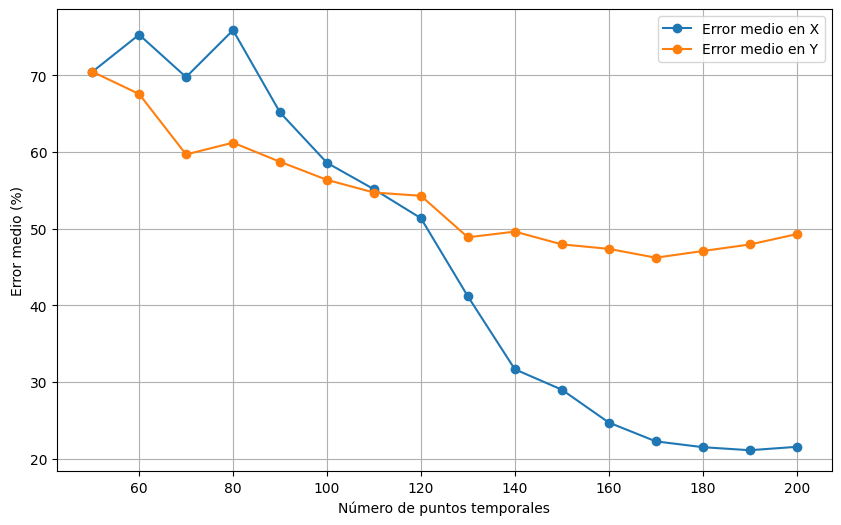

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
errores_medios_promedio_porcentajeX = [x * 100 for x in errores_medios_X_por_tiempos]
errores_medios_promedio_porcentajeY = [x * 100 for x in errores_medios_Y_por_tiempos]


plt.plot(range(50, 201, 10), errores_medios_promedio_porcentajeX, label='Error medio en X', marker = 'o')
plt.plot(range(50, 201, 10), errores_medios_promedio_porcentajeY, label='Error medio en Y',marker = 'o')
plt.xlabel('Número de puntos temporales')
plt.ylabel('Error medio (%)')
plt.grid(True)
plt.legend()
plt.show()

In [37]:
promedio_lista = [(a + b) / 2 for a, b in zip(errores_medios_X_por_tiempos, 
                                             errores_medios_Y_por_tiempos)]
print(promedio_lista)
print(errores_medios_X_por_tiempos)

[0.7046812611693396, 0.7144365557349739, 0.6473250472641312, 0.685548616365245, 0.619436631440501, 0.5747590810067209, 0.5492601858177184, 0.5282397037297557, 0.45014366113595705, 0.40628852996799364, 0.38465667607244036, 0.36029049450773665, 0.3422517394942142, 0.34280814831296974, 0.3450708438007886, 0.354027281911807]
[0.7044598167446842, 0.7531244205771463, 0.6978148071286431, 0.7589236596103227, 0.651632218975026, 0.5858791294108161, 0.5514166044157099, 0.5136028481428261, 0.4115795907595073, 0.3164564468048324, 0.28984509822475596, 0.2469641089535683, 0.22242531858708656, 0.2148300004015056, 0.2108403112671415, 0.21527425342153783]


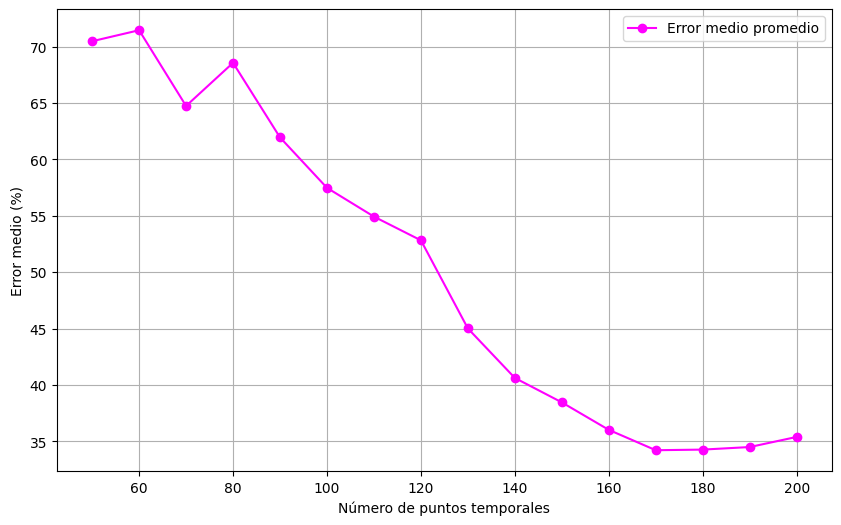

In [38]:
errores_medios_promedio_porcentaje = [x * 100 for x in promedio_lista]

plt.figure(figsize=(10, 6))
plt.plot(range(50, 201, 10), errores_medios_promedio_porcentaje, label='Error medio promedio', marker='o', color = 'magenta')
plt.xlabel('Número de puntos temporales')
plt.ylabel('Error medio (%)')  # Ahora el eje y está en porcentaje
plt.grid(True)
plt.legend()
plt.show()